In [1]:
import os
import h5py
import json
import random 
import imageio
import datetime
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import tree
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

In [2]:
Data = pd.read_csv('DsDnsPrScTch.csv') 

C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
Data["Teacher First Project Posted Date"]=pd.to_datetime(Data["Teacher First Project Posted Date"])
Data["Project Fully Funded Date"]=pd.to_datetime(Data["Project Fully Funded Date"])
Data["Project Expiration Date"]=pd.to_datetime(Data["Project Expiration Date"])
Data["Project Posted Date"]=pd.to_datetime(Data["Project Posted Date"])
Data["Donation Received Date"]=pd.to_datetime(Data["Donation Received Date"])
Data["Number of dates since posted"]=Data.loc[:,"Donation Received Date"]-Data.loc[:,"Project Posted Date"]

In [4]:
Data.dtypes

Unnamed: 0                                          int64
Project ID                                         object
Donation ID                                        object
Donor ID                                           object
Donation Included Optional Donation                object
Donation Amount                                   float64
Donor Cart Sequence                                 int64
Donation Received Date                     datetime64[ns]
Donor City                                         object
Donor State                                        object
Donor Is Teacher                                   object
Donor Zip                                          object
Unnamed: 0.1                                        int64
School ID                                          object
Teacher ID                                         object
Teacher Project Posted Sequence                     int64
Project Type                                       object
Project Title 

count    743945.000000
mean          0.462287
std           0.332363
min           0.000030
25%           0.138487
50%           0.480108
75%           0.742170
max           2.550013
Name: Raised funds to project cost ratio, dtype: float64


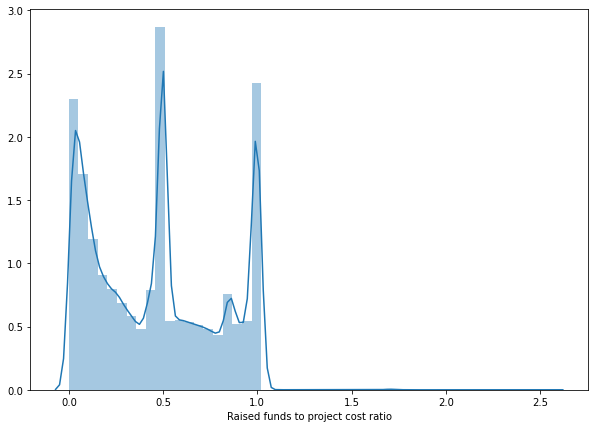

In [5]:
T=pd.Timedelta('30 days')
sub_var=["Number of dates since posted","Project ID","Donation Amount","Project Cost",
         "Project Posted Date","Project Expiration Date","Donation Received Date"]
sub_Data =Data.loc[:,sub_var]
sub_Data=sub_Data[sub_Data["Number of dates since posted"] < T]
sub_Data["Raised funds to project cost ratio"]=sub_Data["Donation Amount"]/sub_Data["Project Cost"]
Grouped_data=sub_Data.groupby(["Project ID"]).sum()
Grouped_data_Final = sub_Data.groupby(["Project ID"]).max()
Grouped_data_Final["Raised funds to project cost ratio"]=Grouped_data["Raised funds to project cost ratio"]

f, axes = plt.subplots(1, 1,figsize=(10,7))

y="Raised funds to project cost ratio"
q1 = Grouped_data_Final[y].quantile(0)
q3 = Grouped_data_Final[y].quantile(1)
mask = Grouped_data_Final[y].between(q1, q3, inclusive=True)
iqr = Grouped_data_Final.loc[mask, y]
sns.distplot(iqr, ax=axes,axlabel=y )
print(iqr.describe())


count    870802.000000
mean          0.555950
std           0.337268
min           0.000026
25%           0.255094
50%           0.500019
75%           0.889879
max           2.550013
Name: Raised funds to project cost ratio, dtype: float64


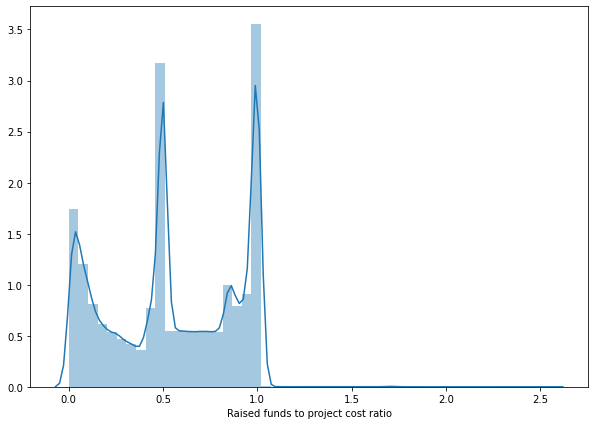

In [6]:
T=pd.Timedelta('120 days')
sub_var=["Number of dates since posted","Project ID","Donation Amount","Project Cost",
         "Project Posted Date","Project Expiration Date","Donation Received Date"]
sub_Data =Data.loc[:,sub_var]
sub_Data=sub_Data[sub_Data["Number of dates since posted"] < T]
sub_Data["Raised funds to project cost ratio"]=sub_Data["Donation Amount"]/sub_Data["Project Cost"]
Grouped_data=sub_Data.groupby(["Project ID"]).sum()
Grouped_data_Final = sub_Data.groupby(["Project ID"]).max()
Grouped_data_Final["Raised funds to project cost ratio"]=Grouped_data["Raised funds to project cost ratio"]

f, axes = plt.subplots(1, 1,figsize=(10,7))

y="Raised funds to project cost ratio"
q1 = Grouped_data_Final[y].quantile(0)
q3 = Grouped_data_Final[y].quantile(1)
mask = Grouped_data_Final[y].between(q1, q3, inclusive=True)
iqr = Grouped_data_Final.loc[mask, y]
sns.distplot(iqr, ax=axes,axlabel=y )
print(iqr.describe())

G120=Grouped_data_Final

In [7]:
#===============================================================================================
#                                  Model Training Funstion
#===============================================================================================

def Train_Model(Classifier,hyper_parameters, Model_variables_con,Model_variables_cat,Data,
                Time_period_indays=30,K=100,Fund_Ratio_treshold=0.142):
    # Time_period should be in days 
    # K is the Top-K value

    #=================================== Initiate the List Variables ================================
    
    Time_points = []
    Output=dict()
    count_itr=0
    
    Overall_Training_Accuracy_GS=[]
    Overall_Training_Precision_GS=[]
    Overall_Training_Recall_GS=[]

    Overall_Testing_Accuracy_GS=[]
    Overall_Testing_Precision_GS=[]
    Overall_Testing_Recall_GS=[]
    
    Overall_Top_K_Accuracy_GS=[]
    Overall_Top_K_Precision_GS=[]
    Overall_Top_K_Recall_GS=[]
    
    Classifier_models=[]
    
    #=================================== Initiate the Columns ======================================
    
    print("Initiatnig the Columns")
    Main_Variables = list(set(["Project ID","Project Posted Date","Project Expiration Date","Donation Received Date",
         "Project Cost","Donation Amount","Number of dates since posted"]+Model_variables_cat+Model_variables_con))
    Model_variables = Model_variables_con.copy()
    print("Variables considered in model training")
    for i in sub_var: print(">",i,i in Data.columns) # print all variables considered.
    print()
    Data["Number of dates since posted"]=Data.loc[:,"Donation Received Date"]-Data.loc[:,"Project Posted Date"]
    sub_Data = Data.loc[:,Main_Variables]
    sub_Data["Number of dates since posted"] = sub_Data["Number of dates since posted"]/ np.timedelta64(1, 'D')

    #================================= One-Hot-Encoding Columns to remove ==========================
    
    print("One-Hot-Encoding removing columns identification")
    Sub_Variables_to_remove=dict()
    for i in Model_variables_cat:
        sub_variables = Data[i].unique()
        Model_variables+=sorted([i+"_"+str(j) for j in Data[i].unique()])
        Model_variables.remove(i+"_"+str(sub_variables[0]))
        Sub_Variables_to_remove[i]=sub_variables[0]
        
    
    
    
    
    #======================================= Grid Search ===========================================
    keys=list(hyper_parameters.keys())
    vals=[]
    
    for i in keys:
        vals+=[hyper_parameters[i]]

    combinations=vals[0]
    for i in range (1,len(vals)):
        combinations = list(itertools.product(combinations,vals[i]))

    for i in range (len (combinations)): #tupples to single list
        try:
            p=list(combinations[i][0])
        except:
            p=[combinations[i][0]]
            
        for j in range (1,len(combinations[i])):
            p+=[combinations[i][j]]
        combinations[i]=p    


    for i in combinations:
        for j in range (len(keys)):
            setattr(Classifier, keys[j],i[j])
        print(Classifier)
        count_itr+=1
        print(count_itr,"/",len(combinations),"Time iteration is starting\n")
        #=================================== Initiate Time Variables ====================================
    
        print("Initiate Time Variables")
        MaxT = pd.Timestamp("2018-05-01 00:00:00")  #max(Data["Project Posted Date"])
        MinT = pd.Timestamp("2013-01-01 00:00:00")  #min(Data["Project Posted Date"])
        Time_period = timedelta(days=Time_period_indays)  
        T_current = MinT- Time_period +timedelta(days=120) 
        

        #=================================== Loop over time frams =======================================
        
        Output["Overall_Training_Accuracy"], Output["Overall_Training_Precision"], Output["Overall_Training_Recall"] = list(),list(),list()
        Output["Overall_Testing_Accuracy"], Output["Overall_Testing_Precision"], Output["Overall_Testing_Recall"] = list(),list(),list()
        Output["Top_K_Accuracy"], Output["Top_K_Precision"], Output["Top_K_Recall"] = list(),list(),list()
        
        print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

        print("Time iteration is starting\n")
        while (T_current<MaxT-Time_period):

            T_current = T_current+ Time_period
            Time_points+=[T_current]
            T_Train_start = T_current-timedelta(days=120)  # Start of the data frame
            T_Train_end = T_current-Time_period  #End of the data frame
            print("As of Date:",T_current,"\n"+"="*85)

        #====================================== Extract the frams ======================================= 

            # Extracts projects posted before the Current(As of) date
            Data_in_TimeWindow = sub_Data[sub_Data["Project Posted Date"] < pd.to_datetime(T_current)]  

            # Extracts projects posted after the start date of the Time window
            Data_in_TimeWindow = Data_in_TimeWindow[Data_in_TimeWindow["Project Posted Date"] > pd.to_datetime(T_Train_start)]

            #Time period to be consided for the donations since posted (30days, as default)
            Data_in_TimeWindow = Data_in_TimeWindow[Data_in_TimeWindow["Number of dates since posted"]< Time_period_indays]

            #Express the donation amount as a ratio of to the Project cost
            Data_in_TimeWindow["Fund_Ratio"]=Data_in_TimeWindow["Donation Amount"]/Data_in_TimeWindow["Project Cost"]


        #=========================== Do One-Hot_Encoding for Categorical Variables ======================

            for var in Model_variables_cat:
                Sub_Dummied_Data=pd.get_dummies(Data_in_TimeWindow[var])  #create dummpy variables with one hot encoding 
                Sub_Dummied_Data_columns=sorted(Sub_Dummied_Data.columns)  #extract the column names of dummpy variables
                Sub_Dummied_Data_columns.remove(Sub_Variables_to_remove[var]) #remove a pre defined column from dummpy variables
                Data_in_TimeWindow=Data_in_TimeWindow.drop([var], axis=1) #remove main variable from the dataset
                #copy the columns to the main data set 
                for col in Sub_Dummied_Data_columns : Data_in_TimeWindow[var+"_"+col] = Sub_Dummied_Data[col]

            #Add the columns which have not been one-hot-encoded
            for i in Model_variables:
                if i not in Data_in_TimeWindow.columns:  Data_in_TimeWindow[i]=0


        #============================================ Imputing ==========================================
            Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


        #=================================== Training set Creation =====================================

            #extract the training set from the timewindow
            Train_Data = Data_in_TimeWindow[Data_in_TimeWindow["Project Posted Date"] < pd.to_datetime(T_Train_end)]

            #Group by Project ID
            Train_Data_CR=Train_Data.groupby(["Project ID"]).sum() 
            Train_Data_Final=Train_Data.groupby(["Project ID"]).max()
            Train_Data_Final["Fund_Ratio"]=Train_Data_CR["Fund_Ratio"]
            Train_Data_Final["Donation Amount"]=Train_Data_CR["Donation Amount"]

            # Define Fund_Ratio_Treshold
            Fund_Ratio_Treshold = Fund_Ratio_treshold
            Fund_Ratio_Treshold = Train_Data_Final["Fund_Ratio"].median()

            # Genarate the Label for the dataset 
            Train_Data_Final['Label'] = Train_Data_Final.apply(lambda x : 1  if x['Fund_Ratio'] < 
                                                               Fund_Ratio_Treshold  else 0, axis=1)

            X_train = Train_Data_Final.loc[:,Model_variables]
            Y_train = np.array(Train_Data_Final.loc[:,["Label"]])[:,0]


        #==================================== Testing set Creation =====================================

            #extract the training set from the timewindow
            Test_Data = Data_in_TimeWindow[Data_in_TimeWindow["Project Posted Date"] >= pd.to_datetime(T_Train_end)]

            #Group by Project ID
            Test_Data_CR=Test_Data.groupby(["Project ID"]).sum() 
            Test_Data_Final=Test_Data.groupby(["Project ID"]).max()
            Test_Data_Final["Fund_Ratio"]=Test_Data_CR["Fund_Ratio"]
            Test_Data_Final["Donation Amount"]=Test_Data_CR["Donation Amount"]

            # Genarate the Label for the dataset 
            Test_Data_Final['Label'] = Test_Data_Final.apply(lambda x : 1  if x['Fund_Ratio'] < 
                                                             Fund_Ratio_Treshold  else 0, axis=1)
            X_test = Test_Data_Final.loc[:,Model_variables]
            Y_test = np.array(Test_Data_Final.loc[:,["Label"]])[:,0]


        #===================================== Model Training =========================================

            Classifier.fit(X_train, Y_train)

            # Predict on training 
            Train_Data_Final["Y_pred_prob"] = Classifier.predict_proba(X_train)[:,1]
            Train_Data_Final["Y_pred"]= Classifier.predict(X_train)
            # Predict on testing 
            Test_Data_Final["Y_pred_prob"] = Classifier.predict_proba(X_test)[:,1]
            Test_Data_Final["Y_pred"] = Classifier.predict(X_test)


        #====================================== Evaluation Trainign  ============================================

            Training_CM= confusion_matrix(Y_train,Train_Data_Final["Y_pred"])
            Training_TN, Training_FP ,Training_FN, Training_TP =  Training_CM.ravel()

            Training_Accuracy=(Training_TP+Training_TN)/(Training_TN+ Training_FP +Training_FN+ Training_TP)
            Training_Precision=Training_TP/(Training_TP+Training_FP)
            Training_Recall=Training_TP/(Training_TP+Training_FN)

            print(Classifier.__class__.__name__,' Testing Accuracy = ',Training_Accuracy)
            print("\tTraining_TP:",Training_TP,"\tTraining_FP:",Training_FP,
                  "\n\tTraining_TN:",Training_TN,"\tTraining_FN:",Training_FN ,end="\n"*2)


        #====================================== Evaluation Testign  ============================================   

            Testing_CM= confusion_matrix(Y_test,Test_Data_Final["Y_pred"])
            Testing_TN, Testing_FP ,Testing_FN, Testing_TP =  Testing_CM.ravel()

            Testing_Accuracy=(Testing_TP+Testing_TN)/(Testing_TN+ Testing_FP +Testing_FN+ Testing_TP)
            Testing_Precision=Testing_TP/(Testing_TP+Testing_FP)
            Testing_Recall=Testing_TP/(Testing_TP+Testing_FN)

            print(Classifier.__class__.__name__,' Testing Accuracy = ',Testing_Accuracy)
            print("\tTesting_TP:",Testing_TP,"\tTesting_FP:",Testing_FP,
                  "\n\tTesting_TN:",Testing_TN,"\tTesting_FN:",Testing_FN ,end="\n"*2)

        #====================================== Evaluation Top K  ============================================        

            Test_Data_Final=Test_Data_Final.sort_values(by=['Y_pred_prob'], ascending=False)
            Top_K=Test_Data_Final.head(K)
            Y_test_Top_K =  Top_K.loc[:,["Label"]] 
            Y_pred_Top_K =  Top_K.loc[:,["Y_pred"]]
            Testing_Top_K_CM= confusion_matrix(Y_test_Top_K,Y_pred_Top_K)
            if len(Testing_Top_K_CM.ravel())==4:
                Testing_Top_K_TN, Testing_Top_K_FP ,Testing_Top_K_FN, Testing_Top_K_TP =  Testing_Top_K_CM.ravel()
            else:
                Testing_Top_K_TN, Testing_Top_K_FP ,Testing_Top_K_FN, Testing_Top_K_TP=0,0,0,K

            Testing_Top_K_Accuracy=(Testing_Top_K_TP+Testing_Top_K_TN)/(Testing_Top_K_TN
                                                                        + Testing_Top_K_FP +Testing_Top_K_FN+ Testing_Top_K_TP)
            Testing_Top_K_Precision=Testing_Top_K_TP/(Testing_Top_K_TP+Testing_Top_K_FP)
            Testing_Top_K_Recall=Testing_Top_K_TP/(Testing_Top_K_TP+Testing_Top_K_FN)

            print(Classifier.__class__.__name__,' Testing Accuracy = ',Testing_Top_K_Accuracy)
            print("\tTesting_Top_K_TP:",Testing_Top_K_TP,"\tTesting_Top_K_FP:",Testing_Top_K_FP,
                  "\n\tTesting_Top_K_TN:",Testing_Top_K_TN,"\tTesting_Top_K_FN:",Testing_Top_K_FN ,end="\n"*2)

         #====================================== save computed values  ============================================       
            Output["Overall_Training_Accuracy"] += [Training_Accuracy]
            Output["Overall_Training_Precision"] += [Training_Precision]
            Output["Overall_Training_Recall"] += [Training_Recall ]

            Output["Overall_Testing_Accuracy"] += [Testing_Accuracy]
            Output["Overall_Testing_Precision"] += [Testing_Precision]
            Output["Overall_Testing_Recall"] += [Testing_Recall]

            Output["Top_K_Accuracy"] += [Testing_Top_K_Accuracy] 
            Output["Top_K_Precision"] += [Testing_Top_K_Precision]  
            Output["Top_K_Recall"] += [Testing_Top_K_Recall] 
            
            
        Overall_Training_Accuracy_GS+=[sum(Output["Overall_Training_Accuracy"])/len(Output["Overall_Training_Accuracy"])]
        Overall_Training_Precision_GS+=[sum(Output["Overall_Training_Precision"])/len(Output["Overall_Training_Precision"])]
        Overall_Training_Recall_GS+=[sum(Output["Overall_Training_Recall"])/len(Output["Overall_Training_Recall"])]

        Overall_Testing_Accuracy_GS+=[sum(Output["Overall_Testing_Accuracy"])/len(Output["Overall_Testing_Accuracy"])]
        Overall_Testing_Precision_GS+=[sum(Output["Overall_Testing_Precision"])/len(Output["Overall_Testing_Precision"])]
        Overall_Testing_Recall_GS+=[sum(Output["Overall_Testing_Recall"])/len(Output["Overall_Testing_Recall"])]

        Overall_Top_K_Accuracy_GS+=[sum(Output["Top_K_Accuracy"])/len(Output["Top_K_Accuracy"])]
        Overall_Top_K_Precision_GS+=[sum(Output["Top_K_Precision"])/len(Output["Top_K_Precision"])]
        Overall_Top_K_Recall_GS+=[sum(Output["Top_K_Recall"])/len(Output["Top_K_Recall"])]
        
        Classifier_models+=[Classifier]
        
    
    
    Output["Overall_Training_Accuracy"] = Overall_Training_Accuracy_GS
    Output["Overall_Training_Precision"] =Overall_Training_Precision_GS
    Output["Overall_Training_Recall"] =Overall_Training_Precision_GS

    Output["Overall_Testing_Accuracy"] =Overall_Testing_Accuracy_GS
    Output["Overall_Testing_Precision"] =Overall_Testing_Precision_GS
    Output["Overall_Testing_Recall"] =Overall_Testing_Recall_GS

    Output["Top_K_Accuracy"] = Overall_Top_K_Accuracy_GS
    Output["Top_K_Precision"] = Overall_Top_K_Precision_GS
    Output["Top_K_Recall"] = Overall_Top_K_Recall_GS
    
    Output["Classifier"]=Classifier_models
    Output["Model_variables"]=Model_variables
    Output["Time_points"]=Time_points
    
    print(Overall_Training_Accuracy_GS)
    return Output,Test_Data_Final,Train_Data_Final
        

In [8]:
from sklearn.linear_model import LogisticRegression 

clf = LogisticRegression(n_jobs=8)

hyper_para=dict()
hyper_para["tol"]=[0.1,0.01,0.0001]
hyper_para["solver"]=["newton-cg", "lbfgs", "liblinear", "sag", "saga"]
hyper_para["random_state"]=[23,17,43]
# hyper_para["criterion"]=["gini", "entropy"]
0112702394
Model_variables_con= ["Project Cost","Number of dates since posted","School Percentage Free Lunch",
                      "Project Short Description_polarity","Project Short Description_subjectivity",
                      "Project Essay_polarity","Project Essay_subjectivity","Project Need Statement_polarity",
                      "Project Need Statement_subjectivity"]
Model_variables_cat= ["School Metro Type","Teacher Prefix","Project Grade Level Category"]

Output,Test_Data_Final,Train_Data_Final= Train_Model(clf, hyper_para,Model_variables_con,Model_variables_cat,
                                    Data,Time_period_indays=30,K=100,Fund_Ratio_treshold=0.14)

Initiatnig the Columns
Variables considered in model training
> Number of dates since posted True
> Project ID True
> Donation Amount True
> Project Cost True
> Project Posted Date True
> Project Expiration Date True
> Donation Received Date True

One-Hot-Encoding removing columns identification
LogisticRegression(n_jobs=8, random_state=23, solver='newton-cg', tol=0.1)
1 / 45 Time iteration is starting

Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Time iteration is starting

As of Date: 2013-05-01 00:00:00 
LogisticRegression  Testing Accuracy =  0.6064089391215002
	Training_TP: 4351 	Training_FP: 2694 
	Training_TN: 5092 	Training_FN: 3435

LogisticRegression  Testing Accuracy =  0.5999027710257657
	Testing_TP: 1044 	Testing_FP: 778 
	Testing_TN: 1424 	Testing_FN: 868

LogisticRegression  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-

LogisticRegression  Testing Accuracy =  0.6130204890945142
	Training_TP: 4191 	Training_FP: 2481 
	Training_TN: 5084 	Training_FN: 3374

LogisticRegression  Testing Accuracy =  0.6054613935969868
	Testing_TP: 1669 	Testing_FP: 976 
	Testing_TN: 1546 	Testing_FN: 1119

LogisticRegression  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 
LogisticRegression  Testing Accuracy =  0.6034779158952658
	Training_TP: 4203 	Training_FP: 2638 
	Training_TN: 4924 	Training_FN: 3359

LogisticRegression  Testing Accuracy =  0.5702519379844961
	Testing_TP: 3112 	Testing_FP: 2561 
	Testing_TN: 5127 	Testing_FN: 3648

LogisticRegression  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 
LogisticRegression  Testing Accuracy =  0.6014020618556701
	Training_TP: 6366 	Training_FP: 3907 
	Training_TN: 8218 	Training_FN

LogisticRegression  Testing Accuracy =  0.6253254490093112
	Training_TP: 12504 	Training_FP: 6824 
	Training_TN: 15837 	Training_FN: 10157

LogisticRegression  Testing Accuracy =  0.629155024568841
	Testing_TP: 2917 	Testing_FP: 1648 
	Testing_TN: 3613 	Testing_FN: 2201

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 
LogisticRegression  Testing Accuracy =  0.6280757455493821
	Training_TP: 12246 	Training_FP: 6599 
	Training_TN: 15449 	Training_FN: 9801

LogisticRegression  Testing Accuracy =  0.6117820324005891
	Testing_TP: 3579 	Testing_FP: 2284 
	Testing_TN: 4729 	Testing_FN: 2988

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 
LogisticRegression  Testing Accuracy =  0.6217971554629909
	Training_TP: 9528 	Training_FP: 5084 
	Training_TN: 13162 	Train

LogisticRegression  Testing Accuracy =  0.6334973705794374
	Training_TP: 11265 	Training_FP: 5731 
	Training_TN: 14996 	Training_FN: 9462

LogisticRegression  Testing Accuracy =  0.6411175855371284
	Testing_TP: 3171 	Testing_FP: 2112 
	Testing_TN: 5411 	Testing_FN: 2692

LogisticRegression  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 
LogisticRegression  Testing Accuracy =  0.6338003589948146
	Training_TP: 11005 	Training_FP: 5638 
	Training_TN: 14418 	Training_FN: 9051

LogisticRegression  Testing Accuracy =  0.5957167530224525
	Testing_TP: 3206 	Testing_FP: 1807 
	Testing_TN: 5417 	Testing_FN: 4045

LogisticRegression  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 
LogisticRegression  Testing Accuracy =  0.6228429805665578
	Training_TP: 11027 	Training_FP: 5919 
	Training_TN: 15863 	Train

LogisticRegression  Testing Accuracy =  0.5933835520695814
	Training_TP: 3451 	Training_FP: 2249 
	Training_TN: 4190 	Training_FN: 2987

LogisticRegression  Testing Accuracy =  0.5217619297325642
	Testing_TP: 1200 	Testing_FP: 576 
	Testing_TN: 790 	Testing_FN: 1248

LogisticRegression  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 
LogisticRegression  Testing Accuracy =  0.5661022604053716
	Training_TP: 3253 	Training_FP: 2461 
	Training_TN: 3534 	Training_FN: 2741

LogisticRegression  Testing Accuracy =  0.5454353338968724
	Testing_TP: 1197 	Testing_FP: 1156 
	Testing_TN: 1384 	Testing_FN: 995

LogisticRegression  Testing Accuracy =  0.44
	Testing_Top_K_TP: 44 	Testing_Top_K_FP: 56 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 
LogisticRegression  Testing Accuracy =  0.5510529674537332
	Training_TP: 3466 	Training_FP: 2826 
	Training_TN: 3442 	Training_FN: 2

LogisticRegression  Testing Accuracy =  0.635144779771615
	Training_TP: 10042 	Training_FP: 4740 
	Training_TN: 14876 	Training_FN: 9574

LogisticRegression  Testing Accuracy =  0.6129281483389132
	Testing_TP: 3579 	Testing_FP: 1428 
	Testing_TN: 3561 	Testing_FN: 3081

LogisticRegression  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 
LogisticRegression  Testing Accuracy =  0.6384639125259027
	Training_TP: 11753 	Training_FP: 5472 
	Training_TN: 17209 	Training_FN: 10928

LogisticRegression  Testing Accuracy =  0.6218507181539911
	Testing_TP: 2181 	Testing_FP: 1279 
	Testing_TN: 3101 	Testing_FN: 1933

LogisticRegression  Testing Accuracy =  0.6
	Testing_Top_K_TP: 60 	Testing_Top_K_FP: 40 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 
LogisticRegression  Testing Accuracy =  0.6376973965002134
	Training_TP: 9929 	Training_FP: 4767 
	Training_TN: 13977 	Traini

LogisticRegression  Testing Accuracy =  0.6211294396457638
	Training_TP: 8535 	Training_FP: 4651 
	Training_TN: 11384 	Training_FN: 7499

LogisticRegression  Testing Accuracy =  0.6149063103940845
	Testing_TP: 2866 	Testing_FP: 1749 
	Testing_TN: 4452 	Testing_FN: 2834

LogisticRegression  Testing Accuracy =  0.57
	Testing_Top_K_TP: 57 	Testing_Top_K_FP: 43 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 
LogisticRegression  Testing Accuracy =  0.6126102136221078
	Training_TP: 8896 	Training_FP: 5090 
	Training_TN: 11809 	Training_FN: 8003

LogisticRegression  Testing Accuracy =  0.6254844006568144
	Testing_TP: 3167 	Testing_FP: 1888 
	Testing_TN: 6356 	Testing_FN: 3814

LogisticRegression  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 
LogisticRegression  Testing Accuracy =  0.6064243448858834
	Training_TP: 9185 	Training_FP: 5408 
	Training_TN: 12337 	Training

LogisticRegression  Testing Accuracy =  0.6146636229354102
	Training_TP: 9175 	Training_FP: 5172 
	Training_TN: 13712 	Training_FN: 9176

LogisticRegression  Testing Accuracy =  0.5789712213913437
	Testing_TP: 2665 	Testing_FP: 944 
	Testing_TN: 2445 	Testing_FN: 2772

LogisticRegression  Testing Accuracy =  0.95
	Testing_Top_K_TP: 95 	Testing_Top_K_FP: 5 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 
LogisticRegression  Testing Accuracy =  0.6152277362338545
	Training_TP: 8500 	Training_FP: 4771 
	Training_TN: 11410 	Training_FN: 7681

LogisticRegression  Testing Accuracy =  0.5909132969371703
	Testing_TP: 3466 	Testing_FP: 1695 
	Testing_TN: 2920 	Testing_FN: 2726

LogisticRegression  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 
LogisticRegression  Testing Accuracy =  0.622706065318818
	Training_TP: 7828 	Training_FP: 4278 
	Training_TN: 10190 	Training_F

LogisticRegression  Testing Accuracy =  0.572527533344402
	Training_TP: 4964 	Training_FP: 3654 
	Training_TN: 5381 	Training_FN: 4070

LogisticRegression  Testing Accuracy =  0.5382414353104942
	Testing_TP: 3595 	Testing_FP: 1974 
	Testing_TN: 3365 	Testing_FN: 3997

LogisticRegression  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 
LogisticRegression  Testing Accuracy =  0.5768624142610864
	Training_TP: 7451 	Training_FP: 5356 
	Training_TN: 8276 	Training_FN: 6180

LogisticRegression  Testing Accuracy =  0.5447075882068633
	Testing_TP: 2622 	Testing_FP: 1972 
	Testing_TN: 3013 	Testing_FN: 2738

LogisticRegression  Testing Accuracy =  0.61
	Testing_Top_K_TP: 61 	Testing_Top_K_FP: 39 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 
LogisticRegression  Testing Accuracy =  0.5862289685442575
	Training_TP: 9067 	Training_FP: 6238 
	Training_TN: 10166 	Training_F

LogisticRegression  Testing Accuracy =  0.6123527468897941
	Training_TP: 7416 	Training_FP: 4355 
	Training_TN: 9270 	Training_FN: 6208

LogisticRegression  Testing Accuracy =  0.617697256137587
	Testing_TP: 1558 	Testing_FP: 1309 
	Testing_TN: 3147 	Testing_FN: 1603

LogisticRegression  Testing Accuracy =  0.24
	Testing_Top_K_TP: 24 	Testing_Top_K_FP: 76 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 
LogisticRegression  Testing Accuracy =  0.591553544494721
	Training_TP: 6329 	Training_FP: 4205 
	Training_TN: 7398 	Training_FN: 5273

LogisticRegression  Testing Accuracy =  0.5808597748208802
	Testing_TP: 2186 	Testing_FP: 1542 
	Testing_TN: 3489 	Testing_FN: 2553

LogisticRegression  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 
LogisticRegression  Testing Accuracy =  0.584122596642413
	Training_TP: 6787 	Training_FP: 4718 
	Training_TN: 7583 	Training_FN: 

LogisticRegression  Testing Accuracy =  0.6098110860607945
	Training_TP: 10042 	Training_FP: 5805 
	Training_TN: 13490 	Training_FN: 9252

LogisticRegression  Testing Accuracy =  0.6105117912694431
	Testing_TP: 2342 	Testing_FP: 1242 
	Testing_TN: 2525 	Testing_FN: 1863

LogisticRegression  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 
LogisticRegression  Testing Accuracy =  0.6170181986517375
	Training_TP: 9003 	Training_FP: 4959 
	Training_TN: 12323 	Training_FN: 8278

LogisticRegression  Testing Accuracy =  0.605625717566016
	Testing_TP: 2337 	Testing_FP: 877 
	Testing_TN: 1883 	Testing_FN: 1871

LogisticRegression  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 
LogisticRegression  Testing Accuracy =  0.6208244091233608
	Training_TP: 7008 	Training_FP: 3793 
	Training_TN: 9514 	Training_

LogisticRegression  Testing Accuracy =  0.6146895873246
	Training_TP: 10221 	Training_FP: 5791 
	Training_TN: 13522 	Training_FN: 9092

LogisticRegression  Testing Accuracy =  0.6321176738190917
	Testing_TP: 6906 	Testing_FP: 3920 
	Testing_TN: 9768 	Testing_FN: 5784

LogisticRegression  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 
LogisticRegression  Testing Accuracy =  0.6186868686868687
	Training_TP: 15172 	Training_FP: 8498 
	Training_TN: 19618 	Training_FN: 12944

LogisticRegression  Testing Accuracy =  0.6022360480890677
	Testing_TP: 5772 	Testing_FP: 3053 
	Testing_TN: 7102 	Testing_FN: 5450

LogisticRegression  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 
LogisticRegression  Testing Accuracy =  0.6181030995790325
	Training_TP: 17730 	Training_FP: 9847 
	Training_TN: 23529 	Trainin

LogisticRegression  Testing Accuracy =  0.6254953764861294
	Training_TP: 9238 	Training_FP: 5058 
	Training_TN: 11596 	Training_FN: 7416

LogisticRegression  Testing Accuracy =  0.6605762473647224
	Testing_TP: 1507 	Testing_FP: 1375 
	Testing_TN: 3193 	Testing_FN: 1040

LogisticRegression  Testing Accuracy =  0.34
	Testing_Top_K_TP: 34 	Testing_Top_K_FP: 66 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 
LogisticRegression  Testing Accuracy =  0.6208027999562507
	Training_TP: 7631 	Training_FP: 4318 
	Training_TN: 9397 	Training_FN: 6083

LogisticRegression  Testing Accuracy =  0.620594891690915
	Testing_TP: 1477 	Testing_FP: 972 
	Testing_TN: 2362 	Testing_FN: 1375

LogisticRegression  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 
LogisticRegression  Testing Accuracy =  0.6209437015586406
	Training_TP: 6606 	Training_FP: 3766 
	Training_TN: 7975 	Training_FN

LogisticRegression  Testing Accuracy =  0.5974896702268652
	Training_TP: 7531 	Training_FP: 5030 
	Training_TN: 7797 	Training_FN: 5296

LogisticRegression  Testing Accuracy =  0.6157635467980296
	Testing_TP: 2207 	Testing_FP: 1436 
	Testing_TN: 2293 	Testing_FN: 1372

LogisticRegression  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 
LogisticRegression  Testing Accuracy =  0.6383279641706608
	Training_TP: 7734 	Training_FP: 4213 
	Training_TN: 8514 	Training_FN: 4993

LogisticRegression  Testing Accuracy =  0.6286019210245464
	Testing_TP: 1652 	Testing_FP: 887 
	Testing_TN: 1882 	Testing_FN: 1201

LogisticRegression  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 
LogisticRegression  Testing Accuracy =  0.647006086915491
	Training_TP: 6298 	Training_FP: 3183 
	Training_TN: 7414 	Training_FN: 

LogisticRegression  Testing Accuracy =  0.6138191293409407
	Training_TP: 5579 	Training_FP: 3046 
	Training_TN: 8084 	Training_FN: 5550

LogisticRegression  Testing Accuracy =  0.6541518687637409
	Testing_TP: 5082 	Testing_FP: 2623 
	Testing_TN: 6522 	Testing_FN: 3512

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 
LogisticRegression  Testing Accuracy =  0.6385057112539791
	Training_TP: 8685 	Training_FP: 4247 
	Training_TN: 11774 	Training_FN: 7336

LogisticRegression  Testing Accuracy =  0.6506379554772214
	Testing_TP: 7563 	Testing_FP: 3691 
	Testing_TN: 9418 	Testing_FN: 5427

LogisticRegression  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 
LogisticRegression  Testing Accuracy =  0.6479471079553234
	Training_TP: 14586 	Training_FP: 7023 
	Training_TN: 18539 	Training

LogisticRegression  Testing Accuracy =  0.6177111094190207
	Training_TP: 17458 	Training_FP: 9729 
	Training_TN: 23104 	Training_FN: 15374

LogisticRegression  Testing Accuracy =  0.6110248893487383
	Testing_TP: 4848 	Testing_FP: 2848 
	Testing_TN: 5782 	Testing_FN: 3919

LogisticRegression  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 
LogisticRegression  Testing Accuracy =  0.6116878796897705
	Training_TP: 14810 	Training_FP: 8431 
	Training_TN: 20129 	Training_FN: 13749

LogisticRegression  Testing Accuracy =  0.6511522478277295
	Testing_TP: 3152 	Testing_FP: 2171 
	Testing_TN: 5466 	Testing_FN: 2446

LogisticRegression  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 
LogisticRegression  Testing Accuracy =  0.620373021391468
	Training_TP: 12748 	Training_FP: 6862 
	Training_TN: 17587 	Tra

LogisticRegression  Testing Accuracy =  0.5973932281646788
	Training_TP: 5790 	Training_FP: 3765 
	Training_TN: 6631 	Training_FN: 4606

LogisticRegression  Testing Accuracy =  0.5895160336054904
	Testing_TP: 2314 	Testing_FP: 1487 
	Testing_TN: 2668 	Testing_FN: 1982

LogisticRegression  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 
LogisticRegression  Testing Accuracy =  0.6086112740894526
	Training_TP: 6087 	Training_FP: 3681 
	Training_TN: 7398 	Training_FN: 4991

LogisticRegression  Testing Accuracy =  0.6144274120829576
	Testing_TP: 1530 	Testing_FP: 995 
	Testing_TN: 1877 	Testing_FN: 1143

LogisticRegression  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 
LogisticRegression  Testing Accuracy =  0.6033983755018205
	Training_TP: 5854 	Training_FP: 3639 
	Training_TN: 7072 	Training_FN

LogisticRegression  Testing Accuracy =  0.6381494503041464
	Training_TP: 5408 	Training_FP: 2933 
	Training_TN: 6027 	Training_FN: 3551

LogisticRegression  Testing Accuracy =  0.602979665794242
	Testing_TP: 1453 	Testing_FP: 1014 
	Testing_TN: 1542 	Testing_FN: 958

LogisticRegression  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 
LogisticRegression  Testing Accuracy =  0.6244232349409014
	Training_TP: 4490 	Training_FP: 2522 
	Training_TN: 5389 	Training_FN: 3420

LogisticRegression  Testing Accuracy =  0.6213248638838476
	Testing_TP: 2505 	Testing_FP: 2389 
	Testing_TN: 4342 	Testing_FN: 1784

LogisticRegression  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 
LogisticRegression  Testing Accuracy =  0.6123476542280363
	Training_TP: 5750 	Training_FP: 3363 
	Training_TN: 7263 	Training_FN:

LogisticRegression  Testing Accuracy =  0.6469208410531863
	Training_TP: 16858 	Training_FP: 8215 
	Training_TN: 21201 	Training_FN: 12557

LogisticRegression  Testing Accuracy =  0.637123745819398
	Testing_TP: 2820 	Testing_FP: 1525 
	Testing_TN: 4038 	Testing_FN: 2381

LogisticRegression  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 
LogisticRegression  Testing Accuracy =  0.6416450233357418
	Training_TP: 14708 	Training_FP: 7455 
	Training_TN: 18150 	Training_FN: 10896

LogisticRegression  Testing Accuracy =  0.644755432954316
	Testing_TP: 3560 	Testing_FP: 2323 
	Testing_TN: 6023 	Testing_FN: 2957

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 
LogisticRegression  Testing Accuracy =  0.6373800336400515
	Training_TP: 10721 	Training_FP: 5167 
	Training_TN: 15047 	Trai

LogisticRegression  Testing Accuracy =  0.6056032394939259
	Training_TP: 13584 	Training_FP: 8134 
	Training_TN: 17673 	Training_FN: 12222

LogisticRegression  Testing Accuracy =  0.6033564736806633
	Testing_TP: 3500 	Testing_FP: 2315 
	Testing_TN: 5452 	Testing_FN: 3570

LogisticRegression  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 
LogisticRegression  Testing Accuracy =  0.6073417410531488
	Training_TP: 12024 	Training_FP: 6954 
	Training_TN: 17641 	Training_FN: 12225

LogisticRegression  Testing Accuracy =  0.5887834339948231
	Testing_TP: 7691 	Testing_FP: 2308 
	Testing_TN: 5957 	Testing_FN: 7224

LogisticRegression  Testing Accuracy =  0.96
	Testing_Top_K_TP: 96 	Testing_Top_K_FP: 4 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

LogisticRegression(n_jobs=8, random_state=43, tol=0.1)
6 / 45 Time iteration is starting

Initiate Time Variables
++++++++++++++++++++++++++++++++++++++++++

LogisticRegression  Testing Accuracy =  0.6099769681742043
	Training_TP: 5170 	Training_FP: 3069 
	Training_TN: 6483 	Training_FN: 4382

LogisticRegression  Testing Accuracy =  0.5938987451319775
	Testing_TP: 1401 	Testing_FP: 680 
	Testing_TN: 1344 	Testing_FN: 1197

LogisticRegression  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 
LogisticRegression  Testing Accuracy =  0.6129543952412425
	Training_TP: 4215 	Training_FP: 2506 
	Training_TN: 5059 	Training_FN: 3350

LogisticRegression  Testing Accuracy =  0.6037664783427495
	Testing_TP: 1665 	Testing_FP: 981 
	Testing_TN: 1541 	Testing_FN: 1123

LogisticRegression  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 
LogisticRegression  Testing Accuracy =  0.5991139910076699
	Training_TP: 4153 	Training_FP: 2654 
	Training_TN: 4908 	Training_FN:

LogisticRegression  Testing Accuracy =  0.6236653386454183
	Training_TP: 10395 	Training_FP: 5739 
	Training_TN: 13086 	Training_FN: 8430

LogisticRegression  Testing Accuracy =  0.6169358014966523
	Testing_TP: 3545 	Testing_FP: 1769 
	Testing_TN: 4287 	Testing_FN: 3094

LogisticRegression  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 
LogisticRegression  Testing Accuracy =  0.6237147522174661
	Training_TP: 12534 	Training_FP: 6927 
	Training_TN: 15734 	Training_FN: 10127

LogisticRegression  Testing Accuracy =  0.6312746892764235
	Testing_TP: 2958 	Testing_FP: 1667 
	Testing_TN: 3594 	Testing_FN: 2160

LogisticRegression  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 
LogisticRegression  Testing Accuracy =  0.6287334164871301
	Training_TP: 12131 	Training_FP: 6455 
	Training_TN: 15593 	Tra

LogisticRegression  Testing Accuracy =  0.6316788642491609
	Training_TP: 9861 	Training_FP: 5075 
	Training_TN: 13098 	Training_FN: 8312

LogisticRegression  Testing Accuracy =  0.6380067779590812
	Testing_TP: 4035 	Testing_FP: 2310 
	Testing_TN: 6131 	Testing_FN: 3458

LogisticRegression  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 
LogisticRegression  Testing Accuracy =  0.6335456168282916
	Training_TP: 11295 	Training_FP: 5759 
	Training_TN: 14968 	Training_FN: 9432

LogisticRegression  Testing Accuracy =  0.6396234872254595
	Testing_TP: 3184 	Testing_FP: 2145 
	Testing_TN: 5378 	Testing_FN: 2679

LogisticRegression  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 
LogisticRegression  Testing Accuracy =  0.631706222576785
	Training_TP: 11006 	Training_FP: 5723 
	Training_TN: 14333 	Traini

C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 7786 	Training_FP: 7786 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4647544968400583
	Testing_TP: 1912 	Testing_FP: 2202 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5263836136733586
	Training_TP: 7263 	Training_FP: 6874 
	Training_TN: 498 	Training_FN: 109

LogisticRegression  Testing Accuracy =  0.5395665936206476
	Testing_TP: 2087 	Testing_FP: 1851 
	Testing_TN: 129 	Testing_FN: 40

LogisticRegression  Testing Accuracy =  0.63
	Testing_Top_K_TP: 63 	Testing_Top_K_FP: 37 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5279179933214257
	Training_TP: 6309 	Training_FP: 5950 
	Training_TN: 489 	Training_FN: 129

LogisticRegression  Testing Accuracy =  0.6533822758259046
	Testing_TP: 2411 	Testing_FP: 1285 
	Testing_TN: 81 	Testing_FN: 37

LogisticRegression  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.4999582951038452
	Training_TP: 5994 	Training_FP: 5995 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.463229078613694
	Testing_TP: 2192 	Testing_FP: 2540 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.37
	Testing_Top_K_TP: 37 	Testing_Top_K_FP: 63 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 6268 	Training_FP: 6268 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4314562298324139
	Testing_TP: 4145 	Testing_FP: 5462 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.07
	Testing_Top_K_TP: 7 	Testing_Top_K_FP: 93 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5658309812385854
	Training_TP: 4746 	Training_FP: 3557 
	Training_TN: 5478 	Training_FN: 4288

LogisticRegression  Testing Accuracy =  0.5216920578454876
	Testing_TP: 3435 	Testing_FP: 2028 
	Testing_TN: 3311 	Testing_FN: 4157

LogisticRegression  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5829145728643216
	Training_TP: 6168 	Training_FP: 3908 
	Training_TN: 9724 	Training_FN: 7463

LogisticRegression  Testing Accuracy =  0.5582406959884002
	Testing_TP: 2412 	Testing_FP: 1622 
	Testing_TN: 3363 	Testing_FN: 2948

LogisticRegression  Testing Accuracy =  0.59
	Testing_Top_K_TP: 59 	Testing_Top_K_FP: 41 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 16404 	Training_FP: 16404 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.518468641785302
	Testing_TP: 5390 	Testing_FP: 5006 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.41
	Testing_Top_K_TP: 41 	Testing_Top_K_FP: 59 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 16654 	Training_FP: 16654 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.3579761068165847
	Testing_TP: 2547 	Testing_FP: 4568 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.31
	Testing_Top_K_TP: 31 	Testing_Top_K_FP: 69 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.4999817711181596
	Training_TP: 13714 	Training_FP: 13715 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4610410604591012
	Testing_TP: 2852 	Testing_FP: 3334 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 11741 	Training_FP: 11741 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.43892045454545453
	Testing_TP: 3399 	Testing_FP: 4345 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 10396 	Training_FP: 10396 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.5083422080227192
	Testing_TP: 4296 	Testing_FP: 4155 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.4999774337681094
	Training_TP: 11078 	Training_FP: 11079 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4820559062218215
	Testing_TP: 2673 	Testing_FP: 2872 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 10711 	Training_FP: 10711 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.5186588369009282
	Testing_TP: 2738 	Testing_FP: 2541 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 9552 	Training_FP: 9552 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.5620943314582432
	Testing_TP: 2598 	Testing_FP: 2024 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 7565 	Training_FP: 7565 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.5250470809792843
	Testing_TP: 2788 	Testing_FP: 2522 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 7562 	Training_FP: 7562 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4678848283499446
	Testing_TP: 6760 	Testing_FP: 7688 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5789278350515464
	Training_TP: 5889 	Training_FP: 3975 
	Training_TN: 8150 	Training_FN: 6236

LogisticRegression  Testing Accuracy =  0.6101963591736551
	Testing_TP: 7160 	Testing_FP: 3085 
	Testing_TN: 4773 	Testing_FN: 4538

LogisticRegression  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5703252446982056
	Training_TP: 17745 	Training_FP: 14986 
	Training_TN: 4630 	Training_FN: 1871

LogisticRegression  Testing Accuracy =  0.6085500901364924
	Testing_TP: 6086 	Testing_FP: 3986 
	Testing_TN: 1003 	Testing_FN: 574

LogisticRegression  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 22681 	Training_FP: 22681 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.484341888391806
	Testing_TP: 4114 	Testing_FP: 4380 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.55
	Testing_Top_K_TP: 55 	Testing_Top_K_FP: 45 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 18744 	Training_FP: 18744 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.3795463696148168
	Testing_TP: 2828 	Testing_FP: 4623 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.49
	Testing_Top_K_TP: 49 	Testing_Top_K_FP: 51 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.49998165070277806
	Training_TP: 13624 	Training_FP: 13625 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4149927793094394
	Testing_TP: 3161 	Testing_FP: 4456 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.17
	Testing_Top_K_TP: 17 	Testing_Top_K_FP: 83 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.4999784529196294
	Training_TP: 11602 	Training_FP: 11603 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4850562947799386
	Testing_TP: 4739 	Testing_FP: 5031 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.29
	Testing_Top_K_TP: 29 	Testing_Top_K_FP: 71 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.49997967562294215
	Training_TP: 12300 	Training_FP: 12301 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.56667057581799
	Testing_TP: 4832 	Testing_FP: 3695 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 12827 	Training_FP: 12827 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4897372742200328
	Testing_TP: 3579 	Testing_FP: 3729 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.49
	Testing_Top_K_TP: 49 	Testing_Top_K_FP: 51 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 12727 	Training_FP: 12727 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.5074706510138741
	Testing_TP: 2853 	Testing_FP: 2769 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.6
	Testing_Top_K_TP: 60 	Testing_Top_K_FP: 40 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.4999764073042986
	Training_TP: 10596 	Training_FP: 10597 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.5746891816663574
	Testing_TP: 3097 	Testing_FP: 2292 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.4999720966571795
	Training_TP: 8959 	Training_FP: 8960 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.48540366418361186
	Testing_TP: 2411 	Testing_FP: 2556 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.49996839643511787
	Training_TP: 7910 	Training_FP: 7911 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.38920145190562616
	Testing_TP: 4289 	Testing_FP: 6731 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5378570420215519
	Training_TP: 10134 	Training_FP: 9330 
	Training_TN: 1296 	Training_FN: 491

LogisticRegression  Testing Accuracy =  0.5374327864332
	Testing_TP: 10619 	Testing_FP: 9635 
	Testing_TN: 1075 	Testing_FN: 430

LogisticRegression  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5000265604249668
	Training_TP: 18825 	Training_FP: 18824 
	Training_TN: 1 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.5229617959826703
	Testing_TP: 6639 	Testing_FP: 6056 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5000220643396143
	Training_TP: 22661 	Training_FP: 22660 
	Training_TN: 1 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4931110897003565
	Testing_TP: 5118 	Testing_FP: 5261 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5000113391540991
	Training_TP: 22047 	Training_FP: 22047 
	Training_TN: 1 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.48357879234167894
	Testing_TP: 6567 	Testing_FP: 7013 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.4999862979912855
	Training_TP: 18245 	Training_FP: 18246 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.46595229865191845
	Testing_TP: 4044 	Testing_FP: 4635 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.49998440861891547
	Training_TP: 16034 	Training_FP: 16035 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4789513486261659
	Testing_TP: 5700 	Testing_FP: 6201 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.56
	Testing_Top_K_TP: 56 	Testing_Top_K_FP: 44 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 16899 	Training_FP: 16899 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4585221674876847
	Testing_TP: 6981 	Testing_FP: 8244 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 17745 	Training_FP: 17745 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.5109501347708895
	Testing_TP: 6066 	Testing_FP: 5806 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.49998704293969787
	Training_TP: 19294 	Training_FP: 19295 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.5274711490215755
	Testing_TP: 4205 	Testing_FP: 3767 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.49998553366316584
	Training_TP: 17281 	Training_FP: 17282 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.6039035591274398
	Testing_TP: 4208 	Testing_FP: 2760 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.49998121218953145
	Training_TP: 13306 	Training_FP: 13307 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.5259602649006623
	Testing_TP: 3971 	Testing_FP: 3579 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.49997753717597376
	Training_TP: 11129 	Training_FP: 11130 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4844692485483962
	Testing_TP: 8594 	Testing_FP: 9145 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5750577367205543
	Training_TP: 14294 	Training_FP: 11889 
	Training_TN: 4132 	Training_FN: 1727

LogisticRegression  Testing Accuracy =  0.5774933905513622
	Testing_TP: 11848 	Testing_FP: 9885 
	Testing_TN: 3224 	Testing_FN: 1142

LogisticRegression  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5970502513545762
	Training_TP: 21562 	Training_FP: 16601 
	Training_TN: 8961 	Training_FN: 3999

LogisticRegression  Testing Accuracy =  0.5952988934721404
	Testing_TP: 6700 	Testing_FP: 5030 
	Testing_TN: 2392 	Testing_FN: 1151

LogisticRegression  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6159847699342184
	Training_TP: 20258 	Training_FP: 13435 
	Training_TN: 15981 	Training_FN: 9157

LogisticRegression  Testing Accuracy =  0.6004273504273504
	Testing_TP: 3372 	Testing_FP: 2472 
	Testing_TN: 3091 	Testing_FN: 1829

LogisticRegression  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6077642601886387
	Training_TP: 19151 	Training_FP: 13633 
	Training_TN: 11972 	Training_FN: 6453

LogisticRegression  Testing Accuracy =  0.6186503397698984
	Testing_TP: 4568 	Testing_FP: 3719 
	Testing_TN: 4627 	Testing_FN: 1949

LogisticRegression  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 20214 	Training_FP: 20214 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4203003437669622
	Testing_TP: 4646 	Testing_FP: 6408 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 18173 	Training_FP: 18173 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.47025229069913393
	Testing_TP: 7493 	Testing_FP: 8441 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 20727 	Training_FP: 20727 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4379949200657403
	Testing_TP: 5863 	Testing_FP: 7523 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5886517750299163
	Training_TP: 16878 	Training_FP: 13322 
	Training_TN: 6734 	Training_FN: 3178

LogisticRegression  Testing Accuracy =  0.5643523316062177
	Testing_TP: 5730 	Testing_FP: 4785 
	Testing_TN: 2439 	Testing_FN: 1521

LogisticRegression  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.4954717068538207
	Training_TP: 21391 	Training_FP: 21782 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.494460402133771
	Testing_TP: 4820 	Testing_FP: 4928 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.4928427554720021
	Training_TP: 18351 	Training_FP: 18884 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.6160208474960345
	Testing_TP: 5437 	Testing_FP: 3389 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.95
	Testing_Top_K_TP: 95 	Testing_Top_K_FP: 5 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 16181 	Training_FP: 16181 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.5729619690941057
	Testing_TP: 6192 	Testing_FP: 4615 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5911180231553482
	Training_TP: 10206 	Training_FP: 7570 
	Training_TN: 6898 	Training_FN: 4261

LogisticRegression  Testing Accuracy =  0.565943758431047
	Testing_TP: 5910 	Testing_FP: 5739 
	Testing_TN: 4998 	Testing_FN: 2627

LogisticRegression  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5866514782788795
	Training_TP: 11294 	Training_FP: 7947 
	Training_TN: 11366 	Training_FN: 8019

LogisticRegression  Testing Accuracy =  0.5874592463416484
	Testing_TP: 8066 	Testing_FP: 6258 
	Testing_TN: 7430 	Testing_FN: 4624

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5859830701379997
	Training_TP: 16270 	Training_FP: 11435 
	Training_TN: 16681 	Training_FN: 11846

LogisticRegression  Testing Accuracy =  0.5780511764981054
	Testing_TP: 6559 	Testing_FP: 4357 
	Testing_TN: 5798 	Testing_FN: 4663

LogisticRegression  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5844107204386451
	Training_TP: 20251 	Training_FP: 14617 
	Training_TN: 18759 	Training_FN: 13124

LogisticRegression  Testing Accuracy =  0.5862361486665606
	Testing_TP: 5898 	Testing_FP: 4042 
	Testing_TN: 5159 	Testing_FN: 3762

LogisticRegression  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5830807888525089
	Training_TP: 23443 	Training_FP: 17988 
	Training_TN: 14845 	Training_FN: 9389

LogisticRegression  Testing Accuracy =  0.591193884002989
	Testing_TP: 6090 	Testing_FP: 4435 
	Testing_TN: 4195 	Testing_FN: 2677

LogisticRegression  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5762005637353595
	Training_TP: 23271 	Training_FP: 18919 
	Training_TN: 9641 	Training_FN: 5288

LogisticRegression  Testing Accuracy =  0.5707593502077823
	Testing_TP: 4571 	Testing_FP: 4654 
	Testing_TN: 2983 	Testing_FN: 1027

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5118818765593685
	Training_TP: 24187 	Training_FP: 23606 
	Training_TN: 843 	Training_FN: 262

LogisticRegression  Testing Accuracy =  0.47418978782933086
	Testing_TP: 9760 	Testing_FP: 11137 
	Testing_TN: 409 	Testing_FN: 139

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.499990312518164
	Training_TP: 25806 	Training_FP: 25807 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4765114241423468
	Testing_TP: 7070 	Testing_FP: 7767 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.4964581115387765
	Training_TP: 24249 	Training_FP: 24595 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.6434426229508197
	Testing_TP: 14915 	Testing_FP: 8265 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.96
	Testing_Top_K_TP: 96 	Testing_Top_K_FP: 4 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

LogisticRegression(n_jobs=8, random_state=17, solver='liblinear', tol=0.1)
8 / 45 Time iteration is starting

Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Time iteration is starting

As of Date: 2013-05-01 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 7786 	Training_FP: 7786 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4647544968400583
	Testing_TP: 1912 	Testing_FP: 2202 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5263836136733586
	Training_TP: 7263 	Training_FP: 6874 
	Training_TN: 498 	Training_FN: 109

LogisticRegression  Testing Accuracy =  0.5395665936206476
	Testing_TP: 2087 	Testing_FP: 1851 
	Testing_TN: 129 	Testing_FN: 40

LogisticRegression  Testing Accuracy =  0.63
	Testing_Top_K_TP: 63 	Testing_Top_K_FP: 37 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5279179933214257
	Training_TP: 6309 	Training_FP: 5950 
	Training_TN: 489 	Training_FN: 129

LogisticRegression  Testing Accuracy =  0.6533822758259046
	Testing_TP: 2411 	Testing_FP: 1285 
	Testing_TN: 81 	Testing_FN: 37

LogisticRegression  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.4999582951038452
	Training_TP: 5994 	Training_FP: 5995 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.463229078613694
	Testing_TP: 2192 	Testing_FP: 2540 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.37
	Testing_Top_K_TP: 37 	Testing_Top_K_FP: 63 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 6268 	Training_FP: 6268 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4314562298324139
	Testing_TP: 4145 	Testing_FP: 5462 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.07
	Testing_Top_K_TP: 7 	Testing_Top_K_FP: 93 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5658309812385854
	Training_TP: 4746 	Training_FP: 3557 
	Training_TN: 5478 	Training_FN: 4288

LogisticRegression  Testing Accuracy =  0.5216920578454876
	Testing_TP: 3435 	Testing_FP: 2028 
	Testing_TN: 3311 	Testing_FN: 4157

LogisticRegression  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5829145728643216
	Training_TP: 6168 	Training_FP: 3908 
	Training_TN: 9724 	Training_FN: 7463

LogisticRegression  Testing Accuracy =  0.5582406959884002
	Testing_TP: 2412 	Testing_FP: 1622 
	Testing_TN: 3363 	Testing_FN: 2948

LogisticRegression  Testing Accuracy =  0.59
	Testing_Top_K_TP: 59 	Testing_Top_K_FP: 41 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 16404 	Training_FP: 16404 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.518468641785302
	Testing_TP: 5390 	Testing_FP: 5006 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.41
	Testing_Top_K_TP: 41 	Testing_Top_K_FP: 59 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 16654 	Training_FP: 16654 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.3579761068165847
	Testing_TP: 2547 	Testing_FP: 4568 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.31
	Testing_Top_K_TP: 31 	Testing_Top_K_FP: 69 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.4999817711181596
	Training_TP: 13714 	Training_FP: 13715 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4610410604591012
	Testing_TP: 2852 	Testing_FP: 3334 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 11741 	Training_FP: 11741 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.43892045454545453
	Testing_TP: 3399 	Testing_FP: 4345 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 10396 	Training_FP: 10396 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.5083422080227192
	Testing_TP: 4296 	Testing_FP: 4155 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.4999774337681094
	Training_TP: 11078 	Training_FP: 11079 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4820559062218215
	Testing_TP: 2673 	Testing_FP: 2872 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 10711 	Training_FP: 10711 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.5186588369009282
	Testing_TP: 2738 	Testing_FP: 2541 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 9552 	Training_FP: 9552 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.5620943314582432
	Testing_TP: 2598 	Testing_FP: 2024 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 7565 	Training_FP: 7565 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.5250470809792843
	Testing_TP: 2788 	Testing_FP: 2522 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 7562 	Training_FP: 7562 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4678848283499446
	Testing_TP: 6760 	Testing_FP: 7688 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5789278350515464
	Training_TP: 5889 	Training_FP: 3975 
	Training_TN: 8150 	Training_FN: 6236

LogisticRegression  Testing Accuracy =  0.6101963591736551
	Testing_TP: 7160 	Testing_FP: 3085 
	Testing_TN: 4773 	Testing_FN: 4538

LogisticRegression  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5703252446982056
	Training_TP: 17745 	Training_FP: 14986 
	Training_TN: 4630 	Training_FN: 1871

LogisticRegression  Testing Accuracy =  0.6085500901364924
	Testing_TP: 6086 	Testing_FP: 3986 
	Testing_TN: 1003 	Testing_FN: 574

LogisticRegression  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 22681 	Training_FP: 22681 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.484341888391806
	Testing_TP: 4114 	Testing_FP: 4380 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.55
	Testing_Top_K_TP: 55 	Testing_Top_K_FP: 45 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 18744 	Training_FP: 18744 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.3795463696148168
	Testing_TP: 2828 	Testing_FP: 4623 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.49
	Testing_Top_K_TP: 49 	Testing_Top_K_FP: 51 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.49998165070277806
	Training_TP: 13624 	Training_FP: 13625 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4149927793094394
	Testing_TP: 3161 	Testing_FP: 4456 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.17
	Testing_Top_K_TP: 17 	Testing_Top_K_FP: 83 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.4999784529196294
	Training_TP: 11602 	Training_FP: 11603 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4850562947799386
	Testing_TP: 4739 	Testing_FP: 5031 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.29
	Testing_Top_K_TP: 29 	Testing_Top_K_FP: 71 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.49997967562294215
	Training_TP: 12300 	Training_FP: 12301 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.56667057581799
	Testing_TP: 4832 	Testing_FP: 3695 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 12827 	Training_FP: 12827 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4897372742200328
	Testing_TP: 3579 	Testing_FP: 3729 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.49
	Testing_Top_K_TP: 49 	Testing_Top_K_FP: 51 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 12727 	Training_FP: 12727 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.5074706510138741
	Testing_TP: 2853 	Testing_FP: 2769 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.6
	Testing_Top_K_TP: 60 	Testing_Top_K_FP: 40 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.4999764073042986
	Training_TP: 10596 	Training_FP: 10597 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.5746891816663574
	Testing_TP: 3097 	Testing_FP: 2292 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.4999720966571795
	Training_TP: 8959 	Training_FP: 8960 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.48540366418361186
	Testing_TP: 2411 	Testing_FP: 2556 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.49996839643511787
	Training_TP: 7910 	Training_FP: 7911 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.38920145190562616
	Testing_TP: 4289 	Testing_FP: 6731 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5378570420215519
	Training_TP: 10134 	Training_FP: 9330 
	Training_TN: 1296 	Training_FN: 491

LogisticRegression  Testing Accuracy =  0.5374327864332
	Testing_TP: 10619 	Testing_FP: 9635 
	Testing_TN: 1075 	Testing_FN: 430

LogisticRegression  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5000265604249668
	Training_TP: 18825 	Training_FP: 18824 
	Training_TN: 1 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.5229617959826703
	Testing_TP: 6639 	Testing_FP: 6056 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5000220643396143
	Training_TP: 22661 	Training_FP: 22660 
	Training_TN: 1 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4931110897003565
	Testing_TP: 5118 	Testing_FP: 5261 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5000113391540991
	Training_TP: 22047 	Training_FP: 22047 
	Training_TN: 1 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.48357879234167894
	Testing_TP: 6567 	Testing_FP: 7013 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.4999862979912855
	Training_TP: 18245 	Training_FP: 18246 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.46595229865191845
	Testing_TP: 4044 	Testing_FP: 4635 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.49998440861891547
	Training_TP: 16034 	Training_FP: 16035 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4789513486261659
	Testing_TP: 5700 	Testing_FP: 6201 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.56
	Testing_Top_K_TP: 56 	Testing_Top_K_FP: 44 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 16899 	Training_FP: 16899 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4585221674876847
	Testing_TP: 6981 	Testing_FP: 8244 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 17745 	Training_FP: 17745 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.5109501347708895
	Testing_TP: 6066 	Testing_FP: 5806 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.49998704293969787
	Training_TP: 19294 	Training_FP: 19295 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.5274711490215755
	Testing_TP: 4205 	Testing_FP: 3767 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.49998553366316584
	Training_TP: 17281 	Training_FP: 17282 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.6039035591274398
	Testing_TP: 4208 	Testing_FP: 2760 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.49998121218953145
	Training_TP: 13306 	Training_FP: 13307 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.5259602649006623
	Testing_TP: 3971 	Testing_FP: 3579 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.49997753717597376
	Training_TP: 11129 	Training_FP: 11130 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4844692485483962
	Testing_TP: 8594 	Testing_FP: 9145 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5750577367205543
	Training_TP: 14294 	Training_FP: 11889 
	Training_TN: 4132 	Training_FN: 1727

LogisticRegression  Testing Accuracy =  0.5774933905513622
	Testing_TP: 11848 	Testing_FP: 9885 
	Testing_TN: 3224 	Testing_FN: 1142

LogisticRegression  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5970502513545762
	Training_TP: 21562 	Training_FP: 16601 
	Training_TN: 8961 	Training_FN: 3999

LogisticRegression  Testing Accuracy =  0.5952988934721404
	Testing_TP: 6700 	Testing_FP: 5030 
	Testing_TN: 2392 	Testing_FN: 1151

LogisticRegression  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6159847699342184
	Training_TP: 20258 	Training_FP: 13435 
	Training_TN: 15981 	Training_FN: 9157

LogisticRegression  Testing Accuracy =  0.6004273504273504
	Testing_TP: 3372 	Testing_FP: 2472 
	Testing_TN: 3091 	Testing_FN: 1829

LogisticRegression  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6077642601886387
	Training_TP: 19151 	Training_FP: 13633 
	Training_TN: 11972 	Training_FN: 6453

LogisticRegression  Testing Accuracy =  0.6186503397698984
	Testing_TP: 4568 	Testing_FP: 3719 
	Testing_TN: 4627 	Testing_FN: 1949

LogisticRegression  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 20214 	Training_FP: 20214 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4203003437669622
	Testing_TP: 4646 	Testing_FP: 6408 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 18173 	Training_FP: 18173 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.47025229069913393
	Testing_TP: 7493 	Testing_FP: 8441 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 20727 	Training_FP: 20727 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4379949200657403
	Testing_TP: 5863 	Testing_FP: 7523 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5886517750299163
	Training_TP: 16878 	Training_FP: 13322 
	Training_TN: 6734 	Training_FN: 3178

LogisticRegression  Testing Accuracy =  0.5643523316062177
	Testing_TP: 5730 	Testing_FP: 4785 
	Testing_TN: 2439 	Testing_FN: 1521

LogisticRegression  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.4954717068538207
	Training_TP: 21391 	Training_FP: 21782 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.494460402133771
	Testing_TP: 4820 	Testing_FP: 4928 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.4928427554720021
	Training_TP: 18351 	Training_FP: 18884 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.6160208474960345
	Testing_TP: 5437 	Testing_FP: 3389 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.95
	Testing_Top_K_TP: 95 	Testing_Top_K_FP: 5 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 16181 	Training_FP: 16181 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.5729619690941057
	Testing_TP: 6192 	Testing_FP: 4615 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5911180231553482
	Training_TP: 10206 	Training_FP: 7570 
	Training_TN: 6898 	Training_FN: 4261

LogisticRegression  Testing Accuracy =  0.565943758431047
	Testing_TP: 5910 	Testing_FP: 5739 
	Testing_TN: 4998 	Testing_FN: 2627

LogisticRegression  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5866514782788795
	Training_TP: 11294 	Training_FP: 7947 
	Training_TN: 11366 	Training_FN: 8019

LogisticRegression  Testing Accuracy =  0.5874592463416484
	Testing_TP: 8066 	Testing_FP: 6258 
	Testing_TN: 7430 	Testing_FN: 4624

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5859830701379997
	Training_TP: 16270 	Training_FP: 11435 
	Training_TN: 16681 	Training_FN: 11846

LogisticRegression  Testing Accuracy =  0.5780511764981054
	Testing_TP: 6559 	Testing_FP: 4357 
	Testing_TN: 5798 	Testing_FN: 4663

LogisticRegression  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5844107204386451
	Training_TP: 20251 	Training_FP: 14617 
	Training_TN: 18759 	Training_FN: 13124

LogisticRegression  Testing Accuracy =  0.5862361486665606
	Testing_TP: 5898 	Testing_FP: 4042 
	Testing_TN: 5159 	Testing_FN: 3762

LogisticRegression  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5830807888525089
	Training_TP: 23443 	Training_FP: 17988 
	Training_TN: 14845 	Training_FN: 9389

LogisticRegression  Testing Accuracy =  0.591193884002989
	Testing_TP: 6090 	Testing_FP: 4435 
	Testing_TN: 4195 	Testing_FN: 2677

LogisticRegression  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5762005637353595
	Training_TP: 23271 	Training_FP: 18919 
	Training_TN: 9641 	Training_FN: 5288

LogisticRegression  Testing Accuracy =  0.5707593502077823
	Testing_TP: 4571 	Testing_FP: 4654 
	Testing_TN: 2983 	Testing_FN: 1027

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5118818765593685
	Training_TP: 24187 	Training_FP: 23606 
	Training_TN: 843 	Training_FN: 262

LogisticRegression  Testing Accuracy =  0.47418978782933086
	Testing_TP: 9760 	Testing_FP: 11137 
	Testing_TN: 409 	Testing_FN: 139

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.499990312518164
	Training_TP: 25806 	Training_FP: 25807 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4765114241423468
	Testing_TP: 7070 	Testing_FP: 7767 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.4964581115387765
	Training_TP: 24249 	Training_FP: 24595 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.6434426229508197
	Testing_TP: 14915 	Testing_FP: 8265 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.96
	Testing_Top_K_TP: 96 	Testing_Top_K_FP: 4 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

LogisticRegression(n_jobs=8, random_state=43, solver='liblinear', tol=0.1)
9 / 45 Time iteration is starting

Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Time iteration is starting

As of Date: 2013-05-01 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 7786 	Training_FP: 7786 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4647544968400583
	Testing_TP: 1912 	Testing_FP: 2202 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5263836136733586
	Training_TP: 7263 	Training_FP: 6874 
	Training_TN: 498 	Training_FN: 109

LogisticRegression  Testing Accuracy =  0.5395665936206476
	Testing_TP: 2087 	Testing_FP: 1851 
	Testing_TN: 129 	Testing_FN: 40

LogisticRegression  Testing Accuracy =  0.63
	Testing_Top_K_TP: 63 	Testing_Top_K_FP: 37 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5279179933214257
	Training_TP: 6309 	Training_FP: 5950 
	Training_TN: 489 	Training_FN: 129

LogisticRegression  Testing Accuracy =  0.6533822758259046
	Testing_TP: 2411 	Testing_FP: 1285 
	Testing_TN: 81 	Testing_FN: 37

LogisticRegression  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.4999582951038452
	Training_TP: 5994 	Training_FP: 5995 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.463229078613694
	Testing_TP: 2192 	Testing_FP: 2540 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.37
	Testing_Top_K_TP: 37 	Testing_Top_K_FP: 63 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 6268 	Training_FP: 6268 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4314562298324139
	Testing_TP: 4145 	Testing_FP: 5462 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.07
	Testing_Top_K_TP: 7 	Testing_Top_K_FP: 93 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5658309812385854
	Training_TP: 4746 	Training_FP: 3557 
	Training_TN: 5478 	Training_FN: 4288

LogisticRegression  Testing Accuracy =  0.5216920578454876
	Testing_TP: 3435 	Testing_FP: 2028 
	Testing_TN: 3311 	Testing_FN: 4157

LogisticRegression  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5829145728643216
	Training_TP: 6168 	Training_FP: 3908 
	Training_TN: 9724 	Training_FN: 7463

LogisticRegression  Testing Accuracy =  0.5582406959884002
	Testing_TP: 2412 	Testing_FP: 1622 
	Testing_TN: 3363 	Testing_FN: 2948

LogisticRegression  Testing Accuracy =  0.59
	Testing_Top_K_TP: 59 	Testing_Top_K_FP: 41 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 16404 	Training_FP: 16404 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.518468641785302
	Testing_TP: 5390 	Testing_FP: 5006 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.41
	Testing_Top_K_TP: 41 	Testing_Top_K_FP: 59 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 16654 	Training_FP: 16654 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.3579761068165847
	Testing_TP: 2547 	Testing_FP: 4568 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.31
	Testing_Top_K_TP: 31 	Testing_Top_K_FP: 69 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.4999817711181596
	Training_TP: 13714 	Training_FP: 13715 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4610410604591012
	Testing_TP: 2852 	Testing_FP: 3334 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 11741 	Training_FP: 11741 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.43892045454545453
	Testing_TP: 3399 	Testing_FP: 4345 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 10396 	Training_FP: 10396 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.5083422080227192
	Testing_TP: 4296 	Testing_FP: 4155 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.4999774337681094
	Training_TP: 11078 	Training_FP: 11079 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4820559062218215
	Testing_TP: 2673 	Testing_FP: 2872 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 10711 	Training_FP: 10711 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.5186588369009282
	Testing_TP: 2738 	Testing_FP: 2541 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 9552 	Training_FP: 9552 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.5620943314582432
	Testing_TP: 2598 	Testing_FP: 2024 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 7565 	Training_FP: 7565 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.5250470809792843
	Testing_TP: 2788 	Testing_FP: 2522 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 7562 	Training_FP: 7562 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4678848283499446
	Testing_TP: 6760 	Testing_FP: 7688 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5789278350515464
	Training_TP: 5889 	Training_FP: 3975 
	Training_TN: 8150 	Training_FN: 6236

LogisticRegression  Testing Accuracy =  0.6101963591736551
	Testing_TP: 7160 	Testing_FP: 3085 
	Testing_TN: 4773 	Testing_FN: 4538

LogisticRegression  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5703252446982056
	Training_TP: 17745 	Training_FP: 14986 
	Training_TN: 4630 	Training_FN: 1871

LogisticRegression  Testing Accuracy =  0.6085500901364924
	Testing_TP: 6086 	Testing_FP: 3986 
	Testing_TN: 1003 	Testing_FN: 574

LogisticRegression  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 22681 	Training_FP: 22681 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.484341888391806
	Testing_TP: 4114 	Testing_FP: 4380 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.55
	Testing_Top_K_TP: 55 	Testing_Top_K_FP: 45 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 18744 	Training_FP: 18744 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.3795463696148168
	Testing_TP: 2828 	Testing_FP: 4623 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.49
	Testing_Top_K_TP: 49 	Testing_Top_K_FP: 51 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.49998165070277806
	Training_TP: 13624 	Training_FP: 13625 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4149927793094394
	Testing_TP: 3161 	Testing_FP: 4456 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.17
	Testing_Top_K_TP: 17 	Testing_Top_K_FP: 83 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.4999784529196294
	Training_TP: 11602 	Training_FP: 11603 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4850562947799386
	Testing_TP: 4739 	Testing_FP: 5031 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.29
	Testing_Top_K_TP: 29 	Testing_Top_K_FP: 71 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.49997967562294215
	Training_TP: 12300 	Training_FP: 12301 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.56667057581799
	Testing_TP: 4832 	Testing_FP: 3695 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 12827 	Training_FP: 12827 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4897372742200328
	Testing_TP: 3579 	Testing_FP: 3729 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.49
	Testing_Top_K_TP: 49 	Testing_Top_K_FP: 51 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 12727 	Training_FP: 12727 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.5074706510138741
	Testing_TP: 2853 	Testing_FP: 2769 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.6
	Testing_Top_K_TP: 60 	Testing_Top_K_FP: 40 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.4999764073042986
	Training_TP: 10596 	Training_FP: 10597 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.5746891816663574
	Testing_TP: 3097 	Testing_FP: 2292 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.4999720966571795
	Training_TP: 8959 	Training_FP: 8960 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.48540366418361186
	Testing_TP: 2411 	Testing_FP: 2556 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.49996839643511787
	Training_TP: 7910 	Training_FP: 7911 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.38920145190562616
	Testing_TP: 4289 	Testing_FP: 6731 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5378570420215519
	Training_TP: 10134 	Training_FP: 9330 
	Training_TN: 1296 	Training_FN: 491

LogisticRegression  Testing Accuracy =  0.5374327864332
	Testing_TP: 10619 	Testing_FP: 9635 
	Testing_TN: 1075 	Testing_FN: 430

LogisticRegression  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5000265604249668
	Training_TP: 18825 	Training_FP: 18824 
	Training_TN: 1 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.5229617959826703
	Testing_TP: 6639 	Testing_FP: 6056 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5000220643396143
	Training_TP: 22661 	Training_FP: 22660 
	Training_TN: 1 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4931110897003565
	Testing_TP: 5118 	Testing_FP: 5261 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5000113391540991
	Training_TP: 22047 	Training_FP: 22047 
	Training_TN: 1 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.48357879234167894
	Testing_TP: 6567 	Testing_FP: 7013 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.4999862979912855
	Training_TP: 18245 	Training_FP: 18246 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.46595229865191845
	Testing_TP: 4044 	Testing_FP: 4635 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.49998440861891547
	Training_TP: 16034 	Training_FP: 16035 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4789513486261659
	Testing_TP: 5700 	Testing_FP: 6201 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.56
	Testing_Top_K_TP: 56 	Testing_Top_K_FP: 44 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 16899 	Training_FP: 16899 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4585221674876847
	Testing_TP: 6981 	Testing_FP: 8244 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 17745 	Training_FP: 17745 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.5109501347708895
	Testing_TP: 6066 	Testing_FP: 5806 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.49998704293969787
	Training_TP: 19294 	Training_FP: 19295 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.5274711490215755
	Testing_TP: 4205 	Testing_FP: 3767 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.49998553366316584
	Training_TP: 17281 	Training_FP: 17282 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.6039035591274398
	Testing_TP: 4208 	Testing_FP: 2760 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.49998121218953145
	Training_TP: 13306 	Training_FP: 13307 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.5259602649006623
	Testing_TP: 3971 	Testing_FP: 3579 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.49997753717597376
	Training_TP: 11129 	Training_FP: 11130 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4844692485483962
	Testing_TP: 8594 	Testing_FP: 9145 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5750577367205543
	Training_TP: 14294 	Training_FP: 11889 
	Training_TN: 4132 	Training_FN: 1727

LogisticRegression  Testing Accuracy =  0.5774933905513622
	Testing_TP: 11848 	Testing_FP: 9885 
	Testing_TN: 3224 	Testing_FN: 1142

LogisticRegression  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5970502513545762
	Training_TP: 21562 	Training_FP: 16601 
	Training_TN: 8961 	Training_FN: 3999

LogisticRegression  Testing Accuracy =  0.5952988934721404
	Testing_TP: 6700 	Testing_FP: 5030 
	Testing_TN: 2392 	Testing_FN: 1151

LogisticRegression  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6159847699342184
	Training_TP: 20258 	Training_FP: 13435 
	Training_TN: 15981 	Training_FN: 9157

LogisticRegression  Testing Accuracy =  0.6004273504273504
	Testing_TP: 3372 	Testing_FP: 2472 
	Testing_TN: 3091 	Testing_FN: 1829

LogisticRegression  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6077642601886387
	Training_TP: 19151 	Training_FP: 13633 
	Training_TN: 11972 	Training_FN: 6453

LogisticRegression  Testing Accuracy =  0.6186503397698984
	Testing_TP: 4568 	Testing_FP: 3719 
	Testing_TN: 4627 	Testing_FN: 1949

LogisticRegression  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 20214 	Training_FP: 20214 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4203003437669622
	Testing_TP: 4646 	Testing_FP: 6408 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 18173 	Training_FP: 18173 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.47025229069913393
	Testing_TP: 7493 	Testing_FP: 8441 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 20727 	Training_FP: 20727 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4379949200657403
	Testing_TP: 5863 	Testing_FP: 7523 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5886517750299163
	Training_TP: 16878 	Training_FP: 13322 
	Training_TN: 6734 	Training_FN: 3178

LogisticRegression  Testing Accuracy =  0.5643523316062177
	Testing_TP: 5730 	Testing_FP: 4785 
	Testing_TN: 2439 	Testing_FN: 1521

LogisticRegression  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.4954717068538207
	Training_TP: 21391 	Training_FP: 21782 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.494460402133771
	Testing_TP: 4820 	Testing_FP: 4928 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.4928427554720021
	Training_TP: 18351 	Training_FP: 18884 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.6160208474960345
	Testing_TP: 5437 	Testing_FP: 3389 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.95
	Testing_Top_K_TP: 95 	Testing_Top_K_FP: 5 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 16181 	Training_FP: 16181 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.5729619690941057
	Testing_TP: 6192 	Testing_FP: 4615 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5911180231553482
	Training_TP: 10206 	Training_FP: 7570 
	Training_TN: 6898 	Training_FN: 4261

LogisticRegression  Testing Accuracy =  0.565943758431047
	Testing_TP: 5910 	Testing_FP: 5739 
	Testing_TN: 4998 	Testing_FN: 2627

LogisticRegression  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5866514782788795
	Training_TP: 11294 	Training_FP: 7947 
	Training_TN: 11366 	Training_FN: 8019

LogisticRegression  Testing Accuracy =  0.5874592463416484
	Testing_TP: 8066 	Testing_FP: 6258 
	Testing_TN: 7430 	Testing_FN: 4624

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5859830701379997
	Training_TP: 16270 	Training_FP: 11435 
	Training_TN: 16681 	Training_FN: 11846

LogisticRegression  Testing Accuracy =  0.5780511764981054
	Testing_TP: 6559 	Testing_FP: 4357 
	Testing_TN: 5798 	Testing_FN: 4663

LogisticRegression  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5844107204386451
	Training_TP: 20251 	Training_FP: 14617 
	Training_TN: 18759 	Training_FN: 13124

LogisticRegression  Testing Accuracy =  0.5862361486665606
	Testing_TP: 5898 	Testing_FP: 4042 
	Testing_TN: 5159 	Testing_FN: 3762

LogisticRegression  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5830807888525089
	Training_TP: 23443 	Training_FP: 17988 
	Training_TN: 14845 	Training_FN: 9389

LogisticRegression  Testing Accuracy =  0.591193884002989
	Testing_TP: 6090 	Testing_FP: 4435 
	Testing_TN: 4195 	Testing_FN: 2677

LogisticRegression  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5762005637353595
	Training_TP: 23271 	Training_FP: 18919 
	Training_TN: 9641 	Training_FN: 5288

LogisticRegression  Testing Accuracy =  0.5707593502077823
	Testing_TP: 4571 	Testing_FP: 4654 
	Testing_TN: 2983 	Testing_FN: 1027

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5118818765593685
	Training_TP: 24187 	Training_FP: 23606 
	Training_TN: 843 	Training_FN: 262

LogisticRegression  Testing Accuracy =  0.47418978782933086
	Testing_TP: 9760 	Testing_FP: 11137 
	Testing_TN: 409 	Testing_FN: 139

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.499990312518164
	Training_TP: 25806 	Training_FP: 25807 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4765114241423468
	Testing_TP: 7070 	Testing_FP: 7767 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.4964581115387765
	Training_TP: 24249 	Training_FP: 24595 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.6434426229508197
	Testing_TP: 14915 	Testing_FP: 8265 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.96
	Testing_Top_K_TP: 96 	Testing_Top_K_FP: 4 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

LogisticRegression(n_jobs=8, random_state=23, solver='sag', tol=0.1)
10 / 45 Time iteration is starting

Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Time iteration is starting

As of Date: 2013-05-01 00:00:00 
LogisticRegression  Testing Accuracy =  0.5179809915232468
	Training_TP: 7709 	Training_FP: 7429 
	Training_TN: 357 	Training_FN: 77

LogisticRegression  Testing Accuracy =  0.4910063198833252
	Testing_TP: 1875 	Testing_FP: 2057 
	Testing_TN: 145 	Testing_FN: 37

LogisticRegression  Testing Accuracy =  0.76
	Testing_Top_K_TP:

LogisticRegression  Testing Accuracy =  0.5056179775280899
	Training_TP: 7538 	Training_FP: 7453 
	Training_TN: 112 	Training_FN: 27

LogisticRegression  Testing Accuracy =  0.5316384180790961
	Testing_TP: 2781 	Testing_FP: 2480 
	Testing_TN: 42 	Testing_FN: 7

LogisticRegression  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 
LogisticRegression  Testing Accuracy =  0.507934408886538
	Training_TP: 7518 	Training_FP: 7398 
	Training_TN: 164 	Training_FN: 44

LogisticRegression  Testing Accuracy =  0.4745293466223699
	Testing_TP: 6698 	Testing_FP: 7530 
	Testing_TN: 158 	Testing_FN: 62

LogisticRegression  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 
LogisticRegression  Testing Accuracy =  0.5457319587628866
	Training_TP: 11158 	Training_FP: 10049 
	Training_TN: 2076 	Training_FN: 967

Logis

LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 22661 	Training_FP: 22661 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4931110897003565
	Testing_TP: 5118 	Testing_FP: 5261 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 
LogisticRegression  Testing Accuracy =  0.4999886608459009
	Training_TP: 22047 	Training_FP: 22048 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.48357879234167894
	Testing_TP: 6567 	Testing_FP: 7013 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 
LogisticRegression  Testing Accuracy =  0.4999862979912855
	Training_TP: 18245 	Training_FP: 18246 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing A

LogisticRegression  Testing Accuracy =  0.5396584165581126
	Training_TP: 19956 	Training_FP: 18312 
	Training_TN: 2415 	Training_FN: 771

LogisticRegression  Testing Accuracy =  0.4858060660391454
	Testing_TP: 5612 	Testing_FP: 6632 
	Testing_TN: 891 	Testing_FN: 251

LogisticRegression  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 
LogisticRegression  Testing Accuracy =  0.518074391703231
	Training_TP: 19741 	Training_FP: 19016 
	Training_TN: 1040 	Training_FN: 315

LogisticRegression  Testing Accuracy =  0.5168221070811745
	Testing_TP: 7066 	Testing_FP: 6809 
	Testing_TN: 415 	Testing_FN: 185

LogisticRegression  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 
LogisticRegression  Testing Accuracy =  0.5218076112385055
	Training_TP: 20747 	Training_FP: 20001 
	Training_TN: 1781 	Training_FN

LogisticRegression  Testing Accuracy =  0.49996117108022053
	Training_TP: 6438 	Training_FP: 6439 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.6418458311484007
	Testing_TP: 2448 	Testing_FP: 1366 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 
LogisticRegression  Testing Accuracy =  0.4999582951038452
	Training_TP: 5994 	Training_FP: 5995 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.463229078613694
	Testing_TP: 2192 	Testing_FP: 2540 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.37
	Testing_Top_K_TP: 37 	Testing_Top_K_FP: 63 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 
LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 6268 	Training_FP: 6268 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy

LogisticRegression  Testing Accuracy =  0.5077487765089723
	Training_TP: 19497 	Training_FP: 19193 
	Training_TN: 423 	Training_FN: 119

LogisticRegression  Testing Accuracy =  0.5778178384410679
	Testing_TP: 6622 	Testing_FP: 4880 
	Testing_TN: 109 	Testing_FN: 38

LogisticRegression  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 
LogisticRegression  Testing Accuracy =  0.516136854636039
	Training_TP: 22410 	Training_FP: 21678 
	Training_TN: 1003 	Training_FN: 271

LogisticRegression  Testing Accuracy =  0.5037673651989639
	Testing_TP: 4074 	Testing_FP: 4175 
	Testing_TN: 205 	Testing_FN: 40

LogisticRegression  Testing Accuracy =  0.55
	Testing_Top_K_TP: 55 	Testing_Top_K_FP: 45 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 
LogisticRegression  Testing Accuracy =  0.5023740930431071
	Training_TP: 18728 	Training_FP: 18639 
	Training_TN: 105 	Training_FN: 16

LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 16899 	Training_FP: 16899 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4585221674876847
	Testing_TP: 6981 	Testing_FP: 8244 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 
LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 17745 	Training_FP: 17745 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.5109501347708895
	Testing_TP: 6066 	Testing_FP: 5806 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 
LogisticRegression  Testing Accuracy =  0.5000129570603021
	Training_TP: 19294 	Training_FP: 19294 
	Training_TN: 1 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.527

LogisticRegression  Testing Accuracy =  0.5717199184228416
	Training_TP: 12498 	Training_FP: 10177 
	Training_TN: 6004 	Training_FN: 3683

LogisticRegression  Testing Accuracy =  0.5948921995003239
	Testing_TP: 4816 	Testing_FP: 3002 
	Testing_TN: 1613 	Testing_FN: 1376

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 
LogisticRegression  Testing Accuracy =  0.5920511491273545
	Training_TP: 9801 	Training_FP: 7138 
	Training_TN: 7330 	Training_FN: 4666

LogisticRegression  Testing Accuracy =  0.5686416934730726
	Testing_TP: 5651 	Testing_FP: 5428 
	Testing_TN: 5309 	Testing_FN: 2886

LogisticRegression  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 
LogisticRegression  Testing Accuracy =  0.5826645264847512
	Training_TP: 12560 	Training_FP: 9367 
	Training_TN: 9946 	Trainin

LogisticRegression  Testing Accuracy =  0.5946154128305763
	Training_TP: 10265 	Training_FP: 7686 
	Training_TN: 5946 	Training_FN: 3366

LogisticRegression  Testing Accuracy =  0.5960367327211213
	Testing_TP: 4085 	Testing_FP: 2904 
	Testing_TN: 2081 	Testing_FN: 1275

LogisticRegression  Testing Accuracy =  0.6
	Testing_Top_K_TP: 60 	Testing_Top_K_FP: 40 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 
LogisticRegression  Testing Accuracy =  0.6030236527676176
	Training_TP: 11757 	Training_FP: 8377 
	Training_TN: 8027 	Training_FN: 4647

LogisticRegression  Testing Accuracy =  0.6234128510965756
	Testing_TP: 4107 	Testing_FP: 2632 
	Testing_TN: 2374 	Testing_FN: 1283

LogisticRegression  Testing Accuracy =  0.42
	Testing_Top_K_TP: 42 	Testing_Top_K_FP: 58 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 
LogisticRegression  Testing Accuracy =  0.5634982586765942
	Training_TP: 15576 	Training_FP: 13461 
	Training_TN: 3193 	Trainin

LogisticRegression  Testing Accuracy =  0.4999784529196294
	Training_TP: 11602 	Training_FP: 11603 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4850562947799386
	Testing_TP: 4739 	Testing_FP: 5031 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.29
	Testing_Top_K_TP: 29 	Testing_Top_K_FP: 71 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 
LogisticRegression  Testing Accuracy =  0.49997967562294215
	Training_TP: 12300 	Training_FP: 12301 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.56667057581799
	Testing_TP: 4832 	Testing_FP: 3695 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 
LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 12827 	Training_FP: 12827 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Acc

LogisticRegression  Testing Accuracy =  0.5830984857024762
	Training_TP: 11385 	Training_FP: 9174 
	Training_TN: 4133 	Training_FN: 1921

LogisticRegression  Testing Accuracy =  0.5854304635761589
	Testing_TP: 3349 	Testing_FP: 2508 
	Testing_TN: 1071 	Testing_FN: 622

LogisticRegression  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 
LogisticRegression  Testing Accuracy =  0.49997753717597376
	Training_TP: 11129 	Training_FP: 11130 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4844692485483962
	Testing_TP: 8594 	Testing_FP: 9145 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 
LogisticRegression  Testing Accuracy =  0.5074901691529867
	Training_TP: 15942 	Training_FP: 15702 
	Training_TN: 319 	Training_FN: 79

L

LogisticRegression  Testing Accuracy =  0.5844706446345374
	Training_TP: 20105 	Training_FP: 14467 
	Training_TN: 18909 	Training_FN: 13270

LogisticRegression  Testing Accuracy =  0.5853348178781613
	Testing_TP: 5840 	Testing_FP: 4001 
	Testing_TN: 5200 	Testing_FN: 3820

LogisticRegression  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 
LogisticRegression  Testing Accuracy =  0.5779791365263077
	Training_TP: 25454 	Training_FP: 20334 
	Training_TN: 12499 	Training_FN: 7378

LogisticRegression  Testing Accuracy =  0.5921710639765477
	Testing_TP: 6718 	Testing_FP: 5046 
	Testing_TN: 3584 	Testing_FN: 2049

LogisticRegression  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 
LogisticRegression  Testing Accuracy =  0.5770934365097428
	Training_TP: 23101 	Training_FP: 18698 
	Training_TN: 9862 	Tr

LogisticRegression  Testing Accuracy =  0.5281918064900775
	Training_TP: 11543 	Training_FP: 10881 
	Training_TN: 860 	Training_FN: 198

LogisticRegression  Testing Accuracy =  0.4697830578512397
	Testing_TP: 3297 	Testing_FP: 4004 
	Testing_TN: 341 	Testing_FN: 102

LogisticRegression  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 
LogisticRegression  Testing Accuracy =  0.5167853020392459
	Training_TP: 10238 	Training_FP: 9889 
	Training_TN: 507 	Training_FN: 158

LogisticRegression  Testing Accuracy =  0.5250266240681576
	Testing_TP: 4233 	Testing_FP: 3951 
	Testing_TN: 204 	Testing_FN: 63

LogisticRegression  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 
LogisticRegression  Testing Accuracy =  0.5587850340750101
	Training_TP: 9986 	Training_FP: 8684 
	Training_TN: 2395 	Training_FN: 109

LogisticRegression  Testing Accuracy =  0.4999720966571795
	Training_TP: 8959 	Training_FP: 8960 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.48540366418361186
	Testing_TP: 2411 	Testing_FP: 2556 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 
LogisticRegression  Testing Accuracy =  0.49996839643511787
	Training_TP: 7910 	Training_FP: 7911 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.38920145190562616
	Testing_TP: 4289 	Testing_FP: 6731 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 
LogisticRegression  Testing Accuracy =  0.4999764716954496
	Training_TP: 10625 	Training_FP: 10626 
	Training_TN: 0 	Training_FN: 0

LogisticRegressi

LogisticRegression  Testing Accuracy =  0.5994454099865258
	Training_TP: 21202 	Training_FP: 16110 
	Training_TN: 9495 	Training_FN: 4402

LogisticRegression  Testing Accuracy =  0.600753549081612
	Testing_TP: 5172 	Testing_FP: 4589 
	Testing_TN: 3757 	Testing_FN: 1345

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 
LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 20214 	Training_FP: 20214 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4203003437669622
	Testing_TP: 4646 	Testing_FP: 6408 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 
LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 18173 	Training_FP: 18173 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accura

LogisticRegression  Testing Accuracy =  0.5079846040455327
	Training_TP: 23844 	Training_FP: 23627 
	Training_TN: 968 	Training_FN: 405

LogisticRegression  Testing Accuracy =  0.6467213114754098
	Testing_TP: 14730 	Testing_FP: 8004 
	Testing_TN: 261 	Testing_FN: 185

LogisticRegression  Testing Accuracy =  0.96
	Testing_Top_K_TP: 96 	Testing_Top_K_FP: 4 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

LogisticRegression(n_jobs=8, random_state=17, solver='saga', tol=0.1)
14 / 45 Time iteration is starting

Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Time iteration is starting

As of Date: 2013-05-01 00:00:00 
LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 7786 	Training_FP: 7786 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4647544968400583
	Testing_TP: 1912 	Testing_FP: 2202 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing

LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 7565 	Training_FP: 7565 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.5250470809792843
	Testing_TP: 2788 	Testing_FP: 2522 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 
LogisticRegression  Testing Accuracy =  0.5000661200740545
	Training_TP: 7562 	Training_FP: 7561 
	Training_TN: 1 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4678848283499446
	Testing_TP: 6760 	Testing_FP: 7688 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 
LogisticRegression  Testing Accuracy =  0.5041649484536083
	Training_TP: 12084 	Training_FP: 11983 
	Training_TN: 142 	Training_FN: 41

LogisticRegression  Testing Accu

LogisticRegression  Testing Accuracy =  0.4999886608459009
	Training_TP: 22047 	Training_FP: 22048 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.48357879234167894
	Testing_TP: 6567 	Testing_FP: 7013 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 
LogisticRegression  Testing Accuracy =  0.4999862979912855
	Training_TP: 18245 	Training_FP: 18246 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.46595229865191845
	Testing_TP: 4044 	Testing_FP: 4635 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 
LogisticRegression  Testing Accuracy =  0.49998440861891547
	Training_TP: 16034 	Training_FP: 16035 
	Training_TN: 0 	Training_FN: 0

LogisticRegr

LogisticRegression  Testing Accuracy =  0.4954717068538207
	Training_TP: 21391 	Training_FP: 21782 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.494460402133771
	Testing_TP: 4820 	Testing_FP: 4928 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 
LogisticRegression  Testing Accuracy =  0.4928427554720021
	Training_TP: 18351 	Training_FP: 18884 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.6160208474960345
	Testing_TP: 5437 	Testing_FP: 3389 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.95
	Testing_Top_K_TP: 95 	Testing_Top_K_FP: 5 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 
LogisticRegression  Testing Accuracy =  0.5470922687102157
	Training_TP: 14488 	Training_FP: 12964 
	Training_TN: 3217 	Training_FN: 1693

LogisticReg

LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 6268 	Training_FP: 6268 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4314562298324139
	Testing_TP: 4145 	Testing_FP: 5462 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.07
	Testing_Top_K_TP: 7 	Testing_Top_K_FP: 93 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 
LogisticRegression  Testing Accuracy =  0.5681000608777464
	Training_TP: 3665 	Training_FP: 2435 
	Training_TN: 6600 	Training_FN: 5369

LogisticRegression  Testing Accuracy =  0.5623694996519991
	Testing_TP: 3594 	Testing_FP: 1661 
	Testing_TN: 3678 	Testing_FN: 3998

LogisticRegression  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 
LogisticRegression  Testing Accuracy =  0.5652349337930529
	Training_TP: 12422 	Training_FP: 10644 
	Training_TN: 2988 	Training_FN: 1209

LogisticRegressio

LogisticRegression  Testing Accuracy =  0.5
	Training_TP: 18744 	Training_FP: 18744 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.3795463696148168
	Testing_TP: 2828 	Testing_FP: 4623 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.49
	Testing_Top_K_TP: 49 	Testing_Top_K_FP: 51 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 
LogisticRegression  Testing Accuracy =  0.49998165070277806
	Training_TP: 13624 	Training_FP: 13625 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4149927793094394
	Testing_TP: 3161 	Testing_FP: 4456 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.17
	Testing_Top_K_TP: 17 	Testing_Top_K_FP: 83 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 
LogisticRegression  Testing Accuracy =  0.4999784529196294
	Training_TP: 11602 	Training_FP: 11603 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing A

LogisticRegression  Testing Accuracy =  0.49998704293969787
	Training_TP: 19294 	Training_FP: 19295 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.5274711490215755
	Testing_TP: 4205 	Testing_FP: 3767 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 
LogisticRegression  Testing Accuracy =  0.49998553366316584
	Training_TP: 17281 	Training_FP: 17282 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.6039035591274398
	Testing_TP: 4208 	Testing_FP: 2760 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 
LogisticRegression  Testing Accuracy =  0.5449968060722203
	Training_TP: 12726 	Training_FP: 11529 
	Training_TN: 1778 	Training_FN: 580

LogisticR

LogisticRegression  Testing Accuracy =  0.5813415848627116
	Training_TP: 19863 	Training_FP: 15289 
	Training_TN: 12827 	Training_FN: 8253

LogisticRegression  Testing Accuracy =  0.5867988960097301
	Testing_TP: 8079 	Testing_FP: 5690 
	Testing_TN: 4465 	Testing_FN: 3143

LogisticRegression  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 
LogisticRegression  Testing Accuracy =  0.5813396053991701
	Training_TP: 23473 	Training_FP: 18044 
	Training_TN: 15332 	Training_FN: 9902

LogisticRegression  Testing Accuracy =  0.5878797518689359
	Testing_TP: 6863 	Testing_FP: 4976 
	Testing_TN: 4225 	Testing_FN: 2797

LogisticRegression  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 
LogisticRegression  Testing Accuracy =  0.5562171628721542
	Training_TP: 29343 	Training_FP: 25652 
	Training_TN: 7181 	Tra

LogisticRegression  Testing Accuracy =  0.6194903204637427
	Training_TP: 7496 	Training_FP: 4219 
	Training_TN: 9496 	Training_FN: 6218

LogisticRegression  Testing Accuracy =  0.623504688005173
	Testing_TP: 1471 	Testing_FP: 948 
	Testing_TN: 2386 	Testing_FN: 1381

LogisticRegression  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 
LogisticRegression  Testing Accuracy =  0.6229452346478154
	Training_TP: 6483 	Training_FP: 3596 
	Training_TN: 8145 	Training_FN: 5258

LogisticRegression  Testing Accuracy =  0.6034349173553719
	Testing_TP: 1716 	Testing_FP: 1388 
	Testing_TN: 2957 	Testing_FN: 1683

LogisticRegression  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 
LogisticRegression  Testing Accuracy =  0.6012889572912659
	Training_TP: 5592 	Training_FP: 3486 
	Training_TN: 6910 	Training_FN:

LogisticRegression  Testing Accuracy =  0.6364814960320578
	Training_TP: 7689 	Training_FP: 4215 
	Training_TN: 8512 	Training_FN: 5038

LogisticRegression  Testing Accuracy =  0.6214870152970473
	Testing_TP: 1624 	Testing_FP: 899 
	Testing_TN: 1870 	Testing_FN: 1229

LogisticRegression  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 
LogisticRegression  Testing Accuracy =  0.6484216486575756
	Training_TP: 6306 	Training_FP: 3161 
	Training_TN: 7436 	Training_FN: 4290

LogisticRegression  Testing Accuracy =  0.6158842085730191
	Testing_TP: 1791 	Testing_FP: 764 
	Testing_TN: 1528 	Testing_FN: 1306

LogisticRegression  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 
LogisticRegression  Testing Accuracy =  0.6382052569897874
	Training_TP: 5287 	Training_FP: 2811 
	Training_TN: 6149 	Training_FN:

LogisticRegression  Testing Accuracy =  0.6399101179701642
	Training_TP: 8595 	Training_FP: 4112 
	Training_TN: 11909 	Training_FN: 7426

LogisticRegression  Testing Accuracy =  0.6555806735890264
	Testing_TP: 7520 	Testing_FP: 3519 
	Testing_TN: 9590 	Testing_FN: 5470

LogisticRegression  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 
LogisticRegression  Testing Accuracy =  0.6491989906695617
	Training_TP: 14620 	Training_FP: 6993 
	Training_TN: 18569 	Training_FN: 10941

LogisticRegression  Testing Accuracy =  0.6290840044523014
	Testing_TP: 4160 	Testing_FP: 1974 
	Testing_TN: 5448 	Testing_FN: 3691

LogisticRegression  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 
LogisticRegression  Testing Accuracy =  0.650337407149292
	Training_TP: 16764 	Training_FP: 7920 
	Training_TN: 21496 	Traini

LogisticRegression  Testing Accuracy =  0.6135436544757437
	Training_TP: 14680 	Training_FP: 8195 
	Training_TN: 20365 	Training_FN: 13879

LogisticRegression  Testing Accuracy =  0.6506989044200983
	Testing_TP: 3114 	Testing_FP: 2139 
	Testing_TN: 5498 	Testing_FN: 2484

LogisticRegression  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 
LogisticRegression  Testing Accuracy =  0.6216000654423494
	Training_TP: 12729 	Training_FP: 6783 
	Training_TN: 17666 	Training_FN: 11720

LogisticRegression  Testing Accuracy =  0.6229890417346701
	Testing_TP: 4712 	Testing_FP: 2898 
	Testing_TN: 8648 	Testing_FN: 5187

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 
LogisticRegression  Testing Accuracy =  0.6068432371689303
	Training_TP: 13228 	Training_FP: 7714 
	Training_TN: 18093 	Tr

LogisticRegression  Testing Accuracy =  0.6089272013359209
	Training_TP: 6004 	Training_FP: 3591 
	Training_TN: 7488 	Training_FN: 5074

LogisticRegression  Testing Accuracy =  0.612263300270514
	Testing_TP: 1509 	Testing_FP: 986 
	Testing_TN: 1886 	Testing_FN: 1164

LogisticRegression  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 
LogisticRegression  Testing Accuracy =  0.6072262160395855
	Training_TP: 5787 	Training_FP: 3490 
	Training_TN: 7221 	Training_FN: 4924

LogisticRegression  Testing Accuracy =  0.5997347982572457
	Testing_TP: 1468 	Testing_FP: 843 
	Testing_TN: 1698 	Testing_FN: 1270

LogisticRegression  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 
LogisticRegression  Testing Accuracy =  0.6108144891122278
	Training_TP: 5194 	Training_FP: 3077 
	Training_TN: 6475 	Training_FN: 

LogisticRegression  Testing Accuracy =  0.6232222994753808
	Training_TP: 4404 	Training_FP: 2455 
	Training_TN: 5456 	Training_FN: 3506

LogisticRegression  Testing Accuracy =  0.6178765880217786
	Testing_TP: 2428 	Testing_FP: 2350 
	Testing_TN: 4381 	Testing_FN: 1861

LogisticRegression  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 
LogisticRegression  Testing Accuracy =  0.6136181826737566
	Training_TP: 5729 	Training_FP: 3315 
	Training_TN: 7311 	Training_FN: 4896

LogisticRegression  Testing Accuracy =  0.6246151017969576
	Testing_TP: 5743 	Testing_FP: 2862 
	Testing_TN: 7848 	Testing_FN: 5306

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 
LogisticRegression  Testing Accuracy =  0.6249402390438247
	Training_TP: 10398 	Training_FP: 5694 
	Training_TN: 13131 	Training

LogisticRegression  Testing Accuracy =  0.6446718350289988
	Training_TP: 14344 	Training_FP: 6936 
	Training_TN: 18669 	Training_FN: 11260

LogisticRegression  Testing Accuracy =  0.647312117338357
	Testing_TP: 3434 	Testing_FP: 2159 
	Testing_TN: 6187 	Testing_FN: 3083

LogisticRegression  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 
LogisticRegression  Testing Accuracy =  0.638270505590185
	Training_TP: 10694 	Training_FP: 5104 
	Training_TN: 15110 	Training_FN: 9520

LogisticRegression  Testing Accuracy =  0.6526144382124118
	Testing_TP: 2279 	Testing_FP: 1473 
	Testing_TN: 4935 	Testing_FN: 2367

LogisticRegression  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 
LogisticRegression  Testing Accuracy =  0.6325592912562593
	Training_TP: 9840 	Training_FP: 5022 
	Training_TN: 13151 	Traini

LogisticRegression  Testing Accuracy =  0.608263041519941
	Training_TP: 11920 	Training_FP: 6805 
	Training_TN: 17790 	Training_FN: 12329

LogisticRegression  Testing Accuracy =  0.5886108714408973
	Testing_TP: 7648 	Testing_FP: 2269 
	Testing_TN: 5996 	Testing_FN: 7267

LogisticRegression  Testing Accuracy =  0.96
	Testing_Top_K_TP: 96 	Testing_Top_K_FP: 4 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

LogisticRegression(n_jobs=8, random_state=43, solver='newton-cg', tol=0.01)
18 / 45 Time iteration is starting

Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Time iteration is starting

As of Date: 2013-05-01 00:00:00 
LogisticRegression  Testing Accuracy =  0.6064731569483689
	Training_TP: 4351 	Training_FP: 2693 
	Training_TN: 5093 	Training_FN: 3435

LogisticRegression  Testing Accuracy =  0.5999027710257657
	Testing_TP: 1044 	Testing_FP: 778 
	Testing_TN: 1424 	Testing_FN: 868

LogisticRegression  Testing Accuracy =  0

LogisticRegression  Testing Accuracy =  0.6129543952412425
	Training_TP: 4191 	Training_FP: 2482 
	Training_TN: 5083 	Training_FN: 3374

LogisticRegression  Testing Accuracy =  0.6054613935969868
	Testing_TP: 1669 	Testing_FP: 976 
	Testing_TN: 1546 	Testing_FN: 1119

LogisticRegression  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 
LogisticRegression  Testing Accuracy =  0.6034779158952658
	Training_TP: 4203 	Training_FP: 2638 
	Training_TN: 4924 	Training_FN: 3359

LogisticRegression  Testing Accuracy =  0.5701827242524917
	Testing_TP: 3111 	Testing_FP: 2561 
	Testing_TN: 5127 	Testing_FN: 3649

LogisticRegression  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 
LogisticRegression  Testing Accuracy =  0.6014020618556701
	Training_TP: 6366 	Training_FP: 3907 
	Training_TN: 8218 	Training_FN

LogisticRegression  Testing Accuracy =  0.6252813203300825
	Training_TP: 12503 	Training_FP: 6825 
	Training_TN: 15836 	Training_FN: 10158

LogisticRegression  Testing Accuracy =  0.6293477213604394
	Testing_TP: 2919 	Testing_FP: 1648 
	Testing_TN: 3613 	Testing_FN: 2199

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 
LogisticRegression  Testing Accuracy =  0.6280077106247874
	Training_TP: 12246 	Training_FP: 6602 
	Training_TN: 15446 	Training_FN: 9801

LogisticRegression  Testing Accuracy =  0.6118556701030928
	Testing_TP: 3580 	Testing_FP: 2284 
	Testing_TN: 4729 	Testing_FN: 2987

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 
LogisticRegression  Testing Accuracy =  0.6217697514455619
	Training_TP: 9527 	Training_FP: 5084 
	Training_TN: 13162 	Trai

LogisticRegression  Testing Accuracy =  0.6334973705794374
	Training_TP: 11265 	Training_FP: 5731 
	Training_TN: 14996 	Training_FN: 9462

LogisticRegression  Testing Accuracy =  0.6411175855371284
	Testing_TP: 3171 	Testing_FP: 2112 
	Testing_TN: 5411 	Testing_FN: 2692

LogisticRegression  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 
LogisticRegression  Testing Accuracy =  0.6338003589948146
	Training_TP: 11005 	Training_FP: 5638 
	Training_TN: 14418 	Training_FN: 9051

LogisticRegression  Testing Accuracy =  0.5957167530224525
	Testing_TP: 3206 	Testing_FP: 1807 
	Testing_TN: 5417 	Testing_FN: 4045

LogisticRegression  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 
LogisticRegression  Testing Accuracy =  0.6227966553169805
	Training_TP: 11026 	Training_FP: 5920 
	Training_TN: 15862 	Train

LogisticRegression  Testing Accuracy =  0.5906655276850198
	Training_TP: 3544 	Training_FP: 2377 
	Training_TN: 4062 	Training_FN: 2894

LogisticRegression  Testing Accuracy =  0.529627687467226
	Testing_TP: 1249 	Testing_FP: 595 
	Testing_TN: 771 	Testing_FN: 1199

LogisticRegression  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 
LogisticRegression  Testing Accuracy =  0.5639336058053216
	Training_TP: 3262 	Training_FP: 2496 
	Training_TN: 3499 	Training_FN: 2732

LogisticRegression  Testing Accuracy =  0.5469146238377007
	Testing_TP: 1217 	Testing_FP: 1169 
	Testing_TN: 1371 	Testing_FN: 975

LogisticRegression  Testing Accuracy =  0.47
	Testing_Top_K_TP: 47 	Testing_Top_K_FP: 53 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 
LogisticRegression  Testing Accuracy =  0.5528876834716018
	Training_TP: 3508 	Training_FP: 2845 
	Training_TN: 3423 	Training_FN: 2

LogisticRegression  Testing Accuracy =  0.6339722675367048
	Training_TP: 10225 	Training_FP: 4969 
	Training_TN: 14647 	Training_FN: 9391

LogisticRegression  Testing Accuracy =  0.6131856811743497
	Testing_TP: 3651 	Testing_FP: 1497 
	Testing_TN: 3492 	Testing_FN: 3009

LogisticRegression  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 
LogisticRegression  Testing Accuracy =  0.6363696486045589
	Training_TP: 11835 	Training_FP: 5649 
	Training_TN: 17032 	Training_FN: 10846

LogisticRegression  Testing Accuracy =  0.6224393689663291
	Testing_TP: 2207 	Testing_FP: 1300 
	Testing_TN: 3080 	Testing_FN: 1907

LogisticRegression  Testing Accuracy =  0.59
	Testing_Top_K_TP: 59 	Testing_Top_K_FP: 41 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 
LogisticRegression  Testing Accuracy =  0.6355100298762271
	Training_TP: 9977 	Training_FP: 4897 
	Training_TN: 13847 	Trai

LogisticRegression  Testing Accuracy =  0.6215971810782999
	Training_TP: 8603 	Training_FP: 4704 
	Training_TN: 11331 	Training_FN: 7431

LogisticRegression  Testing Accuracy =  0.6121334341651962
	Testing_TP: 2854 	Testing_FP: 1770 
	Testing_TN: 4431 	Testing_FN: 2846

LogisticRegression  Testing Accuracy =  0.57
	Testing_Top_K_TP: 57 	Testing_Top_K_FP: 43 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 
LogisticRegression  Testing Accuracy =  0.6124031007751938
	Training_TP: 8944 	Training_FP: 5145 
	Training_TN: 11754 	Training_FN: 7955

LogisticRegression  Testing Accuracy =  0.6225287356321839
	Testing_TP: 3146 	Testing_FP: 1912 
	Testing_TN: 6332 	Testing_FN: 3835

LogisticRegression  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 
LogisticRegression  Testing Accuracy =  0.6045364891518737
	Training_TP: 9351 	Training_FP: 5641 
	Training_TN: 12104 	Trainin

LogisticRegression  Testing Accuracy =  0.6129716664428629
	Training_TP: 9090 	Training_FP: 5150 
	Training_TN: 13734 	Training_FN: 9261

LogisticRegression  Testing Accuracy =  0.5774983004758668
	Testing_TP: 2634 	Testing_FP: 926 
	Testing_TN: 2463 	Testing_FN: 2803

LogisticRegression  Testing Accuracy =  0.95
	Testing_Top_K_TP: 95 	Testing_Top_K_FP: 5 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 
LogisticRegression  Testing Accuracy =  0.6133428094678944
	Training_TP: 8525 	Training_FP: 4857 
	Training_TN: 11324 	Training_FN: 7656

LogisticRegression  Testing Accuracy =  0.5935042102341075
	Testing_TP: 3485 	Testing_FP: 1686 
	Testing_TN: 2929 	Testing_FN: 2707

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 
LogisticRegression  Testing Accuracy =  0.6213236564714014
	Training_TP: 7873 	Training_FP: 4363 
	Training_TN: 10105 	Training_

LogisticRegression  Testing Accuracy =  0.5729149371852343
	Training_TP: 4985 	Training_FP: 3668 
	Training_TN: 5367 	Training_FN: 4049

LogisticRegression  Testing Accuracy =  0.5384734359291625
	Testing_TP: 3655 	Testing_FP: 2031 
	Testing_TN: 3308 	Testing_FN: 3937

LogisticRegression  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 
LogisticRegression  Testing Accuracy =  0.5760187800315446
	Training_TP: 7470 	Training_FP: 5398 
	Training_TN: 8234 	Training_FN: 6161

LogisticRegression  Testing Accuracy =  0.544900918318028
	Testing_TP: 2642 	Testing_FP: 1990 
	Testing_TN: 2995 	Testing_FN: 2718

LogisticRegression  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 
LogisticRegression  Testing Accuracy =  0.5885149963423555
	Training_TP: 9129 	Training_FP: 6225 
	Training_TN: 10179 	Training_F

LogisticRegression  Testing Accuracy =  0.6115453778120298
	Training_TP: 7552 	Training_FP: 4513 
	Training_TN: 9112 	Training_FN: 6072

LogisticRegression  Testing Accuracy =  0.6182223972692661
	Testing_TP: 1609 	Testing_FP: 1356 
	Testing_TN: 3100 	Testing_FN: 1552

LogisticRegression  Testing Accuracy =  0.24
	Testing_Top_K_TP: 24 	Testing_Top_K_FP: 76 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 
LogisticRegression  Testing Accuracy =  0.59116569704805
	Training_TP: 6418 	Training_FP: 4303 
	Training_TN: 7300 	Training_FN: 5184

LogisticRegression  Testing Accuracy =  0.5798362333674514
	Testing_TP: 2202 	Testing_FP: 1568 
	Testing_TN: 3463 	Testing_FN: 2537

LogisticRegression  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 
LogisticRegression  Testing Accuracy =  0.5846510304459168
	Training_TP: 6918 	Training_FP: 4836 
	Training_TN: 7465 	Training_FN:

LogisticRegression  Testing Accuracy =  0.6104071108346938
	Training_TP: 10144 	Training_FP: 5884 
	Training_TN: 13411 	Training_FN: 9150

LogisticRegression  Testing Accuracy =  0.613020572002007
	Testing_TP: 2356 	Testing_FP: 1236 
	Testing_TN: 2531 	Testing_FN: 1849

LogisticRegression  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 
LogisticRegression  Testing Accuracy =  0.615050776842288
	Training_TP: 8999 	Training_FP: 5023 
	Training_TN: 12259 	Training_FN: 8282

LogisticRegression  Testing Accuracy =  0.6027554535017221
	Testing_TP: 2322 	Testing_FP: 882 
	Testing_TN: 1878 	Testing_FN: 1886

LogisticRegression  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 
LogisticRegression  Testing Accuracy =  0.6183068425205727
	Training_TP: 6966 	Training_FP: 3818 
	Training_TN: 9489 	Training_FN

LogisticRegression  Testing Accuracy =  0.6137057940247501
	Training_TP: 10223 	Training_FP: 5831 
	Training_TN: 13482 	Training_FN: 9090

LogisticRegression  Testing Accuracy =  0.6301084236864053
	Testing_TP: 6931 	Testing_FP: 3998 
	Testing_TN: 9690 	Testing_FN: 5759

LogisticRegression  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 
LogisticRegression  Testing Accuracy =  0.6195226917057903
	Training_TP: 15257 	Training_FP: 8536 
	Training_TN: 19580 	Training_FN: 12859

LogisticRegression  Testing Accuracy =  0.6013004631145624
	Testing_TP: 5766 	Testing_FP: 3067 
	Testing_TN: 7088 	Testing_FN: 5456

LogisticRegression  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 
LogisticRegression  Testing Accuracy =  0.6178634027954637
	Training_TP: 17768 	Training_FP: 9901 
	Training_TN: 23475 	Trai

LogisticRegression  Testing Accuracy =  0.6254953764861294
	Training_TP: 9238 	Training_FP: 5058 
	Training_TN: 11596 	Training_FN: 7416

LogisticRegression  Testing Accuracy =  0.6605762473647224
	Testing_TP: 1507 	Testing_FP: 1375 
	Testing_TN: 3193 	Testing_FN: 1040

LogisticRegression  Testing Accuracy =  0.34
	Testing_Top_K_TP: 34 	Testing_Top_K_FP: 66 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 
LogisticRegression  Testing Accuracy =  0.6208027999562507
	Training_TP: 7631 	Training_FP: 4318 
	Training_TN: 9397 	Training_FN: 6083

LogisticRegression  Testing Accuracy =  0.620594891690915
	Testing_TP: 1477 	Testing_FP: 972 
	Testing_TN: 2362 	Testing_FN: 1375

LogisticRegression  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 
LogisticRegression  Testing Accuracy =  0.6209437015586406
	Training_TP: 6606 	Training_FP: 3766 
	Training_TN: 7975 	Training_FN

LogisticRegression  Testing Accuracy =  0.5974896702268652
	Training_TP: 7531 	Training_FP: 5030 
	Training_TN: 7797 	Training_FN: 5296

LogisticRegression  Testing Accuracy =  0.6157635467980296
	Testing_TP: 2207 	Testing_FP: 1436 
	Testing_TN: 2293 	Testing_FN: 1372

LogisticRegression  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 
LogisticRegression  Testing Accuracy =  0.6383279641706608
	Training_TP: 7734 	Training_FP: 4213 
	Training_TN: 8514 	Training_FN: 4993

LogisticRegression  Testing Accuracy =  0.6286019210245464
	Testing_TP: 1652 	Testing_FP: 887 
	Testing_TN: 1882 	Testing_FN: 1201

LogisticRegression  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 
LogisticRegression  Testing Accuracy =  0.647006086915491
	Training_TP: 6298 	Training_FP: 3183 
	Training_TN: 7414 	Training_FN: 

LogisticRegression  Testing Accuracy =  0.6138191293409407
	Training_TP: 5579 	Training_FP: 3046 
	Training_TN: 8084 	Training_FN: 5550

LogisticRegression  Testing Accuracy =  0.6541518687637409
	Testing_TP: 5082 	Testing_FP: 2623 
	Testing_TN: 6522 	Testing_FN: 3512

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 
LogisticRegression  Testing Accuracy =  0.6385057112539791
	Training_TP: 8685 	Training_FP: 4247 
	Training_TN: 11774 	Training_FN: 7336

LogisticRegression  Testing Accuracy =  0.6506379554772214
	Testing_TP: 7563 	Testing_FP: 3691 
	Testing_TN: 9418 	Testing_FN: 5427

LogisticRegression  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 
LogisticRegression  Testing Accuracy =  0.6479471079553234
	Training_TP: 14586 	Training_FP: 7023 
	Training_TN: 18539 	Training

LogisticRegression  Testing Accuracy =  0.6177111094190207
	Training_TP: 17458 	Training_FP: 9729 
	Training_TN: 23104 	Training_FN: 15374

LogisticRegression  Testing Accuracy =  0.6110248893487383
	Testing_TP: 4848 	Testing_FP: 2848 
	Testing_TN: 5782 	Testing_FN: 3919

LogisticRegression  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 
LogisticRegression  Testing Accuracy =  0.6116878796897705
	Training_TP: 14810 	Training_FP: 8431 
	Training_TN: 20129 	Training_FN: 13749

LogisticRegression  Testing Accuracy =  0.6511522478277295
	Testing_TP: 3152 	Testing_FP: 2171 
	Testing_TN: 5466 	Testing_FN: 2446

LogisticRegression  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 
LogisticRegression  Testing Accuracy =  0.620373021391468
	Training_TP: 12748 	Training_FP: 6862 
	Training_TN: 17587 	Tra

C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.569804777806319
	Training_TP: 4812 	Training_FP: 3725 
	Training_TN: 4061 	Training_FN: 2974

LogisticRegression  Testing Accuracy =  0.5794846864365581
	Testing_TP: 1205 	Testing_FP: 1023 
	Testing_TN: 1179 	Testing_FN: 707

LogisticRegression  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5687737384698861
	Training_TP: 4367 	Training_FP: 3353 
	Training_TN: 4019 	Training_FN: 3005

LogisticRegression  Testing Accuracy =  0.5843681519357194
	Testing_TP: 1307 	Testing_FP: 887 
	Testing_TN: 1093 	Testing_FN: 820

LogisticRegression  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5710180942766172
	Training_TP: 3838 	Training_FP: 2924 
	Training_TN: 3515 	Training_FN: 2600

LogisticRegression  Testing Accuracy =  0.5159937073938122
	Testing_TP: 1274 	Testing_FP: 672 
	Testing_TN: 694 	Testing_FN: 1174

LogisticRegression  Testing Accuracy =  0.62
	Testing_Top_K_TP: 62 	Testing_Top_K_FP: 38 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5497539411126866
	Training_TP: 3329 	Training_FP: 2733 
	Training_TN: 3262 	Training_FN: 2665

LogisticRegression  Testing Accuracy =  0.5409974640743872
	Testing_TP: 1187 	Testing_FP: 1167 
	Testing_TN: 1373 	Testing_FN: 1005

LogisticRegression  Testing Accuracy =  0.47
	Testing_Top_K_TP: 47 	Testing_Top_K_FP: 53 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5384492661135929
	Training_TP: 3159 	Training_FP: 2677 
	Training_TN: 3591 	Training_FN: 3109

LogisticRegression  Testing Accuracy =  0.5831164775684397
	Testing_TP: 2647 	Testing_FP: 2507 
	Testing_TN: 2955 	Testing_FN: 1498

LogisticRegression  Testing Accuracy =  0.44
	Testing_Top_K_TP: 44 	Testing_Top_K_FP: 56 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5732469976202336
	Training_TP: 4977 	Training_FP: 3654 
	Training_TN: 5381 	Training_FN: 4057

LogisticRegression  Testing Accuracy =  0.539633439022504
	Testing_TP: 3632 	Testing_FP: 1993 
	Testing_TN: 3346 	Testing_FN: 3960

LogisticRegression  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5601364486666911
	Training_TP: 7320 	Training_FP: 5681 
	Training_TN: 7951 	Training_FN: 6311

LogisticRegression  Testing Accuracy =  0.5206379893668439
	Testing_TP: 2617 	Testing_FP: 2216 
	Testing_TN: 2769 	Testing_FN: 2743

LogisticRegression  Testing Accuracy =  0.59
	Testing_Top_K_TP: 59 	Testing_Top_K_FP: 41 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5662338454035601
	Training_TP: 9381 	Training_FP: 7208 
	Training_TN: 9196 	Training_FN: 7023

LogisticRegression  Testing Accuracy =  0.5795498268564833
	Testing_TP: 3456 	Testing_FP: 2437 
	Testing_TN: 2569 	Testing_FN: 1934

LogisticRegression  Testing Accuracy =  0.55
	Testing_Top_K_TP: 55 	Testing_Top_K_FP: 45 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6018974420559625
	Training_TP: 9576 	Training_FP: 6182 
	Training_TN: 10472 	Training_FN: 7078

LogisticRegression  Testing Accuracy =  0.6489107519325369
	Testing_TP: 1476 	Testing_FP: 1427 
	Testing_TN: 3141 	Testing_FN: 1071

LogisticRegression  Testing Accuracy =  0.33
	Testing_Top_K_TP: 33 	Testing_Top_K_FP: 67 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6002770790039739
	Training_TP: 7914 	Training_FP: 5164 
	Training_TN: 8551 	Training_FN: 5800

LogisticRegression  Testing Accuracy =  0.5965082444228904
	Testing_TP: 1423 	Testing_FP: 1067 
	Testing_TN: 2267 	Testing_FN: 1429

LogisticRegression  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6033131760497402
	Training_TP: 6049 	Training_FP: 3623 
	Training_TN: 8118 	Training_FN: 5692

LogisticRegression  Testing Accuracy =  0.57786673553719
	Testing_TP: 1606 	Testing_FP: 1476 
	Testing_TN: 2869 	Testing_FN: 1793

LogisticRegression  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5830607926125433
	Training_TP: 6021 	Training_FP: 4294 
	Training_TN: 6102 	Training_FN: 4375

LogisticRegression  Testing Accuracy =  0.5613536859543249
	Testing_TP: 2359 	Testing_FP: 1770 
	Testing_TN: 2385 	Testing_FN: 1937

LogisticRegression  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5783273908922688
	Training_TP: 6569 	Training_FP: 4834 
	Training_TN: 6245 	Training_FN: 4509

LogisticRegression  Testing Accuracy =  0.5886384129846709
	Testing_TP: 1708 	Testing_FP: 1316 
	Testing_TN: 1556 	Testing_FN: 965

LogisticRegression  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5769769395948091
	Training_TP: 6411 	Training_FP: 4762 
	Training_TN: 5949 	Training_FN: 4300

LogisticRegression  Testing Accuracy =  0.5813601060806971
	Testing_TP: 1678 	Testing_FP: 1150 
	Testing_TN: 1391 	Testing_FN: 1060

LogisticRegression  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5775230318257957
	Training_TP: 5775 	Training_FP: 4294 
	Training_TN: 5258 	Training_FN: 3777

LogisticRegression  Testing Accuracy =  0.565772392903505
	Testing_TP: 1535 	Testing_FP: 944 
	Testing_TN: 1080 	Testing_FN: 1063

LogisticRegression  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5810310641110377
	Training_TP: 4584 	Training_FP: 3358 
	Training_TN: 4207 	Training_FN: 2981

LogisticRegression  Testing Accuracy =  0.5864406779661017
	Testing_TP: 1712 	Testing_FP: 1120 
	Testing_TN: 1402 	Testing_FN: 1076

LogisticRegression  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5729965617561492
	Training_TP: 4499 	Training_FP: 3395 
	Training_TN: 4167 	Training_FN: 3063

LogisticRegression  Testing Accuracy =  0.5591085271317829
	Testing_TP: 3458 	Testing_FP: 3068 
	Testing_TN: 4620 	Testing_FN: 3302

LogisticRegression  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5848659793814432
	Training_TP: 6553 	Training_FP: 4495 
	Training_TN: 7630 	Training_FN: 5572

LogisticRegression  Testing Accuracy =  0.6140826344855799
	Testing_TP: 7500 	Testing_FP: 3349 
	Testing_TN: 4509 	Testing_FN: 4198

LogisticRegression  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6094004893964111
	Training_TP: 10647 	Training_FP: 6355 
	Training_TN: 13261 	Training_FN: 8969

LogisticRegression  Testing Accuracy =  0.5758434200360546
	Testing_TP: 3745 	Testing_FP: 2026 
	Testing_TN: 2963 	Testing_FN: 2915

LogisticRegression  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6086371853092897
	Training_TP: 12515 	Training_FP: 7587 
	Training_TN: 15094 	Training_FN: 10166

LogisticRegression  Testing Accuracy =  0.5888862726630563
	Testing_TP: 2296 	Testing_FP: 1674 
	Testing_TN: 2706 	Testing_FN: 1818

LogisticRegression  Testing Accuracy =  0.51
	Testing_Top_K_TP: 51 	Testing_Top_K_FP: 49 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5988849765258216
	Training_TP: 10582 	Training_FP: 6875 
	Training_TN: 11869 	Training_FN: 8162

LogisticRegression  Testing Accuracy =  0.6221983626358878
	Testing_TP: 1494 	Testing_FP: 1481 
	Testing_TN: 3142 	Testing_FN: 1334

LogisticRegression  Testing Accuracy =  0.48
	Testing_Top_K_TP: 48 	Testing_Top_K_FP: 52 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.586039854673566
	Training_TP: 7447 	Training_FP: 5103 
	Training_TN: 8522 	Training_FN: 6177

LogisticRegression  Testing Accuracy =  0.5781803859787318
	Testing_TP: 1431 	Testing_FP: 1483 
	Testing_TN: 2973 	Testing_FN: 1730

LogisticRegression  Testing Accuracy =  0.16
	Testing_Top_K_TP: 16 	Testing_Top_K_FP: 84 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5646627881922
	Training_TP: 7048 	Training_FP: 5548 
	Training_TN: 6055 	Training_FN: 4554

LogisticRegression  Testing Accuracy =  0.5451381780962129
	Testing_TP: 2490 	Testing_FP: 2195 
	Testing_TN: 2836 	Testing_FN: 2249

LogisticRegression  Testing Accuracy =  0.49
	Testing_Top_K_TP: 49 	Testing_Top_K_FP: 51 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5462379578065932
	Training_TP: 7250 	Training_FP: 6113 
	Training_TN: 6188 	Training_FN: 5050

LogisticRegression  Testing Accuracy =  0.5135452093350533
	Testing_TP: 2331 	Testing_FP: 1647 
	Testing_TN: 2048 	Testing_FN: 2501

LogisticRegression  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5545723863724955
	Training_TP: 8135 	Training_FP: 6735 
	Training_TN: 6092 	Training_FN: 4692

LogisticRegression  Testing Accuracy =  0.5777230432402847
	Testing_TP: 2511 	Testing_FP: 2018 
	Testing_TN: 1711 	Testing_FN: 1068

LogisticRegression  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6102380765302113
	Training_TP: 7803 	Training_FP: 4997 
	Training_TN: 7730 	Training_FN: 4924

LogisticRegression  Testing Accuracy =  0.5905371753824262
	Testing_TP: 1657 	Testing_FP: 1106 
	Testing_TN: 1663 	Testing_FN: 1196

LogisticRegression  Testing Accuracy =  0.56
	Testing_Top_K_TP: 56 	Testing_Top_K_FP: 44 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6141650544991271
	Training_TP: 6433 	Training_FP: 4014 
	Training_TN: 6583 	Training_FN: 4163

LogisticRegression  Testing Accuracy =  0.5978845796993877
	Testing_TP: 1746 	Testing_FP: 816 
	Testing_TN: 1476 	Testing_FN: 1351

LogisticRegression  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6053351191472739
	Training_TP: 5423 	Training_FP: 3536 
	Training_TN: 5424 	Training_FN: 3536

LogisticRegression  Testing Accuracy =  0.5850614052748138
	Testing_TP: 1312 	Testing_FP: 962 
	Testing_TN: 1594 	Testing_FN: 1099

LogisticRegression  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5922508058909045
	Training_TP: 4284 	Training_FP: 2825 
	Training_TN: 5086 	Training_FN: 3626

LogisticRegression  Testing Accuracy =  0.5980943738656987
	Testing_TP: 2277 	Testing_FP: 2417 
	Testing_TN: 4314 	Testing_FN: 2012

LogisticRegression  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5873135381864383
	Training_TP: 5654 	Training_FP: 3799 
	Training_TN: 6827 	Training_FN: 4971

LogisticRegression  Testing Accuracy =  0.5937772875591709
	Testing_TP: 6482 	Testing_FP: 4272 
	Testing_TN: 6438 	Testing_FN: 4567

LogisticRegression  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5919521912350597
	Training_TP: 10854 	Training_FP: 7392 
	Training_TN: 11433 	Training_FN: 7971

LogisticRegression  Testing Accuracy =  0.5822764868058291
	Testing_TP: 3918 	Testing_FP: 2582 
	Testing_TN: 3474 	Testing_FN: 2721

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5917655884559375
	Training_TP: 14171 	Training_FP: 10012 
	Training_TN: 12649 	Training_FN: 8490

LogisticRegression  Testing Accuracy =  0.5934097697273341
	Testing_TP: 3369 	Testing_FP: 2471 
	Testing_TN: 2790 	Testing_FN: 1749

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.59151831273387
	Training_TP: 13454 	Training_FP: 9419 
	Training_TN: 12629 	Training_FN: 8593

LogisticRegression  Testing Accuracy =  0.6053755522827687
	Testing_TP: 3832 	Testing_FP: 2624 
	Testing_TN: 4389 	Testing_FN: 2735

LogisticRegression  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5934339974240224
	Training_TP: 10537 	Training_FP: 7128 
	Training_TN: 11118 	Training_FN: 7708

LogisticRegression  Testing Accuracy =  0.6016822214540846
	Testing_TP: 2016 	Testing_FP: 1429 
	Testing_TN: 3206 	Testing_FN: 2028

LogisticRegression  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5961208643861673
	Training_TP: 8787 	Training_FP: 5705 
	Training_TN: 10330 	Training_FN: 7247

LogisticRegression  Testing Accuracy =  0.570792370389043
	Testing_TP: 2820 	Testing_FP: 2228 
	Testing_TN: 3973 	Testing_FN: 2880

LogisticRegression  Testing Accuracy =  0.55
	Testing_Top_K_TP: 55 	Testing_Top_K_FP: 45 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5930232558139535
	Training_TP: 9819 	Training_FP: 6675 
	Training_TN: 10224 	Training_FN: 7080

LogisticRegression  Testing Accuracy =  0.5957963875205254
	Testing_TP: 4000 	Testing_FP: 3173 
	Testing_TN: 5071 	Testing_FN: 2981

LogisticRegression  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5818540433925049
	Training_TP: 10386 	Training_FP: 7481 
	Training_TN: 10264 	Training_FN: 7359

LogisticRegression  Testing Accuracy =  0.5882749326145552
	Testing_TP: 3648 	Testing_FP: 2470 
	Testing_TN: 3336 	Testing_FN: 2418

LogisticRegression  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5805022156573116
	Training_TP: 10507 	Training_FP: 7401 
	Training_TN: 11894 	Training_FN: 8787

LogisticRegression  Testing Accuracy =  0.5783993978926242
	Testing_TP: 2378 	Testing_FP: 1534 
	Testing_TN: 2233 	Testing_FN: 1827

LogisticRegression  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5912391864132165
	Training_TP: 10054 	Training_FP: 6901 
	Training_TN: 10381 	Training_FN: 7227

LogisticRegression  Testing Accuracy =  0.5862514351320322
	Testing_TP: 2491 	Testing_FP: 1166 
	Testing_TN: 1594 	Testing_FN: 1717

LogisticRegression  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5922669372111374
	Training_TP: 7801 	Training_FP: 5346 
	Training_TN: 7961 	Training_FN: 5505

LogisticRegression  Testing Accuracy =  0.596158940397351
	Testing_TP: 2468 	Testing_FP: 1546 
	Testing_TN: 2033 	Testing_FN: 1503

LogisticRegression  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5896940563367626
	Training_TP: 6064 	Training_FP: 4068 
	Training_TN: 7062 	Training_FN: 5065

LogisticRegression  Testing Accuracy =  0.629009527030836
	Testing_TP: 5360 	Testing_FP: 3347 
	Testing_TN: 5798 	Testing_FN: 3234

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.612102864989701
	Training_TP: 9306 	Training_FP: 5714 
	Training_TN: 10307 	Training_FN: 6715

LogisticRegression  Testing Accuracy =  0.6205984903636155
	Testing_TP: 8268 	Testing_FP: 5180 
	Testing_TN: 7929 	Testing_FN: 4722

LogisticRegression  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6192124875300745
	Training_TP: 15599 	Training_FP: 9505 
	Training_TN: 16057 	Training_FN: 9962

LogisticRegression  Testing Accuracy =  0.6006678452170497
	Testing_TP: 4849 	Testing_FP: 3097 
	Testing_TN: 4325 	Testing_FN: 3002

LogisticRegression  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6173275993948768
	Training_TP: 18295 	Training_FP: 11393 
	Training_TN: 18023 	Training_FN: 11120

LogisticRegression  Testing Accuracy =  0.6002415458937198
	Testing_TP: 3029 	Testing_FP: 2131 
	Testing_TN: 3432 	Testing_FN: 2172

LogisticRegression  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6081938721709075
	Training_TP: 15629 	Training_FP: 10089 
	Training_TN: 15516 	Training_FN: 9975

LogisticRegression  Testing Accuracy =  0.6184484962658952
	Testing_TP: 3583 	Testing_FP: 2737 
	Testing_TN: 5609 	Testing_FN: 2934

LogisticRegression  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6068071633521321
	Training_TP: 11827 	Training_FP: 7509 
	Training_TN: 12705 	Training_FN: 8387

LogisticRegression  Testing Accuracy =  0.6150714673421386
	Testing_TP: 2347 	Testing_FP: 1956 
	Testing_TN: 4452 	Testing_FN: 2299

LogisticRegression  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.602184559511363
	Training_TP: 10272 	Training_FP: 6558 
	Training_TN: 11615 	Training_FN: 7901

LogisticRegression  Testing Accuracy =  0.601794903978913
	Testing_TP: 4401 	Testing_FP: 3253 
	Testing_TN: 5188 	Testing_FN: 3092

LogisticRegression  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6025232788150722
	Training_TP: 11692 	Training_FP: 7442 
	Training_TN: 13285 	Training_FN: 9035

LogisticRegression  Testing Accuracy =  0.6009263409532347
	Testing_TP: 3306 	Testing_FP: 2785 
	Testing_TN: 4738 	Testing_FN: 2557

LogisticRegression  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6013661747108098
	Training_TP: 12172 	Training_FP: 8106 
	Training_TN: 11950 	Training_FN: 7884

LogisticRegression  Testing Accuracy =  0.5655958549222798
	Testing_TP: 3807 	Testing_FP: 2844 
	Testing_TN: 4380 	Testing_FN: 3444

LogisticRegression  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5870567252681074
	Training_TP: 11837 	Training_FP: 8274 
	Training_TN: 13508 	Training_FN: 9554

LogisticRegression  Testing Accuracy =  0.5882232252769799
	Testing_TP: 2561 	Testing_FP: 1755 
	Testing_TN: 3173 	Testing_FN: 2259

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5785685510944004
	Training_TP: 9944 	Training_FP: 7285 
	Training_TN: 11599 	Training_FN: 8407

LogisticRegression  Testing Accuracy =  0.5704736007251303
	Testing_TP: 2881 	Testing_FP: 1235 
	Testing_TN: 2154 	Testing_FN: 2556

LogisticRegression  Testing Accuracy =  0.95
	Testing_Top_K_TP: 95 	Testing_Top_K_FP: 5 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5829676781410296
	Training_TP: 8792 	Training_FP: 6107 
	Training_TN: 10074 	Training_FN: 7389

LogisticRegression  Testing Accuracy =  0.569445729619691
	Testing_TP: 3312 	Testing_FP: 1773 
	Testing_TN: 2842 	Testing_FN: 2880

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5994470364610334
	Training_TP: 8059 	Training_FP: 5182 
	Training_TN: 9286 	Training_FN: 6408

LogisticRegression  Testing Accuracy =  0.5924561585555671
	Testing_TP: 4653 	Testing_FP: 3971 
	Testing_TN: 6766 	Testing_FN: 3884

LogisticRegression  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5920105628333246
	Training_TP: 11394 	Training_FP: 7840 
	Training_TN: 11473 	Training_FN: 7919

LogisticRegression  Testing Accuracy =  0.5995526575176283
	Testing_TP: 7858 	Testing_FP: 5731 
	Testing_TN: 7957 	Testing_FN: 4832

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5937366623986342
	Training_TP: 16875 	Training_FP: 11604 
	Training_TN: 16512 	Training_FN: 11241

LogisticRegression  Testing Accuracy =  0.5809982691677972
	Testing_TP: 6618 	Testing_FP: 4353 
	Testing_TN: 5802 	Testing_FN: 4604

LogisticRegression  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5875417596740123
	Training_TP: 19067 	Training_FP: 13224 
	Training_TN: 20152 	Training_FN: 14308

LogisticRegression  Testing Accuracy =  0.5860240708339961
	Testing_TP: 5509 	Testing_FP: 3657 
	Testing_TN: 5544 	Testing_FN: 4151

LogisticRegression  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5905124495545572
	Training_TP: 19732 	Training_FP: 13789 
	Training_TN: 19044 	Training_FN: 13100

LogisticRegression  Testing Accuracy =  0.5910789216531586
	Testing_TP: 5235 	Testing_FP: 3582 
	Testing_TN: 5048 	Testing_FN: 3532

LogisticRegression  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5852868572629073
	Training_TP: 16310 	Training_FP: 11439 
	Training_TN: 17121 	Training_FN: 12249

LogisticRegression  Testing Accuracy =  0.6235738571968266
	Testing_TP: 3234 	Testing_FP: 2618 
	Testing_TN: 5019 	Testing_FN: 2364

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5944619411836884
	Training_TP: 13843 	Training_FP: 9224 
	Training_TN: 15225 	Training_FN: 10606

LogisticRegression  Testing Accuracy =  0.5785497785031476
	Testing_TP: 5249 	Testing_FP: 4388 
	Testing_TN: 7158 	Testing_FN: 4650

LogisticRegression  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.577335167496561
	Training_TP: 13885 	Training_FP: 9894 
	Training_TN: 15913 	Training_FN: 11921

LogisticRegression  Testing Accuracy =  0.580912583406349
	Testing_TP: 3773 	Testing_FP: 2921 
	Testing_TN: 4846 	Testing_FN: 3297

LogisticRegression  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5785357464581116
	Training_TP: 12702 	Training_FP: 9039 
	Training_TN: 15556 	Training_FN: 11547

LogisticRegression  Testing Accuracy =  0.5837359792924935
	Testing_TP: 8426 	Testing_FP: 3160 
	Testing_TN: 5105 	Testing_FN: 6489

LogisticRegression  Testing Accuracy =  0.96
	Testing_Top_K_TP: 96 	Testing_Top_K_FP: 4 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

LogisticRegression(n_jobs=8, random_state=17, solver='liblinear', tol=0.01)
23 / 45 Time iteration is starting

Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Time iteration is starting

As of Date: 2013-05-01 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.569804777806319
	Training_TP: 4812 	Training_FP: 3725 
	Training_TN: 4061 	Training_FN: 2974

LogisticRegression  Testing Accuracy =  0.5794846864365581
	Testing_TP: 1205 	Testing_FP: 1023 
	Testing_TN: 1179 	Testing_FN: 707

LogisticRegression  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5687737384698861
	Training_TP: 4367 	Training_FP: 3353 
	Training_TN: 4019 	Training_FN: 3005

LogisticRegression  Testing Accuracy =  0.5843681519357194
	Testing_TP: 1307 	Testing_FP: 887 
	Testing_TN: 1093 	Testing_FN: 820

LogisticRegression  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5710180942766172
	Training_TP: 3838 	Training_FP: 2924 
	Training_TN: 3515 	Training_FN: 2600

LogisticRegression  Testing Accuracy =  0.5159937073938122
	Testing_TP: 1274 	Testing_FP: 672 
	Testing_TN: 694 	Testing_FN: 1174

LogisticRegression  Testing Accuracy =  0.62
	Testing_Top_K_TP: 62 	Testing_Top_K_FP: 38 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5497539411126866
	Training_TP: 3329 	Training_FP: 2733 
	Training_TN: 3262 	Training_FN: 2665

LogisticRegression  Testing Accuracy =  0.5409974640743872
	Testing_TP: 1187 	Testing_FP: 1167 
	Testing_TN: 1373 	Testing_FN: 1005

LogisticRegression  Testing Accuracy =  0.47
	Testing_Top_K_TP: 47 	Testing_Top_K_FP: 53 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5384492661135929
	Training_TP: 3159 	Training_FP: 2677 
	Training_TN: 3591 	Training_FN: 3109

LogisticRegression  Testing Accuracy =  0.5831164775684397
	Testing_TP: 2647 	Testing_FP: 2507 
	Testing_TN: 2955 	Testing_FN: 1498

LogisticRegression  Testing Accuracy =  0.44
	Testing_Top_K_TP: 44 	Testing_Top_K_FP: 56 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5732469976202336
	Training_TP: 4977 	Training_FP: 3654 
	Training_TN: 5381 	Training_FN: 4057

LogisticRegression  Testing Accuracy =  0.539633439022504
	Testing_TP: 3632 	Testing_FP: 1993 
	Testing_TN: 3346 	Testing_FN: 3960

LogisticRegression  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5601364486666911
	Training_TP: 7320 	Training_FP: 5681 
	Training_TN: 7951 	Training_FN: 6311

LogisticRegression  Testing Accuracy =  0.5206379893668439
	Testing_TP: 2617 	Testing_FP: 2216 
	Testing_TN: 2769 	Testing_FN: 2743

LogisticRegression  Testing Accuracy =  0.59
	Testing_Top_K_TP: 59 	Testing_Top_K_FP: 41 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5662338454035601
	Training_TP: 9381 	Training_FP: 7208 
	Training_TN: 9196 	Training_FN: 7023

LogisticRegression  Testing Accuracy =  0.5795498268564833
	Testing_TP: 3456 	Testing_FP: 2437 
	Testing_TN: 2569 	Testing_FN: 1934

LogisticRegression  Testing Accuracy =  0.55
	Testing_Top_K_TP: 55 	Testing_Top_K_FP: 45 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6018974420559625
	Training_TP: 9576 	Training_FP: 6182 
	Training_TN: 10472 	Training_FN: 7078

LogisticRegression  Testing Accuracy =  0.6489107519325369
	Testing_TP: 1476 	Testing_FP: 1427 
	Testing_TN: 3141 	Testing_FN: 1071

LogisticRegression  Testing Accuracy =  0.33
	Testing_Top_K_TP: 33 	Testing_Top_K_FP: 67 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6002770790039739
	Training_TP: 7914 	Training_FP: 5164 
	Training_TN: 8551 	Training_FN: 5800

LogisticRegression  Testing Accuracy =  0.5965082444228904
	Testing_TP: 1423 	Testing_FP: 1067 
	Testing_TN: 2267 	Testing_FN: 1429

LogisticRegression  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6033131760497402
	Training_TP: 6049 	Training_FP: 3623 
	Training_TN: 8118 	Training_FN: 5692

LogisticRegression  Testing Accuracy =  0.57786673553719
	Testing_TP: 1606 	Testing_FP: 1476 
	Testing_TN: 2869 	Testing_FN: 1793

LogisticRegression  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5830607926125433
	Training_TP: 6021 	Training_FP: 4294 
	Training_TN: 6102 	Training_FN: 4375

LogisticRegression  Testing Accuracy =  0.5613536859543249
	Testing_TP: 2359 	Testing_FP: 1770 
	Testing_TN: 2385 	Testing_FN: 1937

LogisticRegression  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5783273908922688
	Training_TP: 6569 	Training_FP: 4834 
	Training_TN: 6245 	Training_FN: 4509

LogisticRegression  Testing Accuracy =  0.5886384129846709
	Testing_TP: 1708 	Testing_FP: 1316 
	Testing_TN: 1556 	Testing_FN: 965

LogisticRegression  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5769769395948091
	Training_TP: 6411 	Training_FP: 4762 
	Training_TN: 5949 	Training_FN: 4300

LogisticRegression  Testing Accuracy =  0.5813601060806971
	Testing_TP: 1678 	Testing_FP: 1150 
	Testing_TN: 1391 	Testing_FN: 1060

LogisticRegression  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5775230318257957
	Training_TP: 5775 	Training_FP: 4294 
	Training_TN: 5258 	Training_FN: 3777

LogisticRegression  Testing Accuracy =  0.565772392903505
	Testing_TP: 1535 	Testing_FP: 944 
	Testing_TN: 1080 	Testing_FN: 1063

LogisticRegression  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5810310641110377
	Training_TP: 4584 	Training_FP: 3358 
	Training_TN: 4207 	Training_FN: 2981

LogisticRegression  Testing Accuracy =  0.5864406779661017
	Testing_TP: 1712 	Testing_FP: 1120 
	Testing_TN: 1402 	Testing_FN: 1076

LogisticRegression  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5729965617561492
	Training_TP: 4499 	Training_FP: 3395 
	Training_TN: 4167 	Training_FN: 3063

LogisticRegression  Testing Accuracy =  0.5591085271317829
	Testing_TP: 3458 	Testing_FP: 3068 
	Testing_TN: 4620 	Testing_FN: 3302

LogisticRegression  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5848659793814432
	Training_TP: 6553 	Training_FP: 4495 
	Training_TN: 7630 	Training_FN: 5572

LogisticRegression  Testing Accuracy =  0.6140826344855799
	Testing_TP: 7500 	Testing_FP: 3349 
	Testing_TN: 4509 	Testing_FN: 4198

LogisticRegression  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6094004893964111
	Training_TP: 10647 	Training_FP: 6355 
	Training_TN: 13261 	Training_FN: 8969

LogisticRegression  Testing Accuracy =  0.5758434200360546
	Testing_TP: 3745 	Testing_FP: 2026 
	Testing_TN: 2963 	Testing_FN: 2915

LogisticRegression  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6086371853092897
	Training_TP: 12515 	Training_FP: 7587 
	Training_TN: 15094 	Training_FN: 10166

LogisticRegression  Testing Accuracy =  0.5888862726630563
	Testing_TP: 2296 	Testing_FP: 1674 
	Testing_TN: 2706 	Testing_FN: 1818

LogisticRegression  Testing Accuracy =  0.51
	Testing_Top_K_TP: 51 	Testing_Top_K_FP: 49 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5988849765258216
	Training_TP: 10582 	Training_FP: 6875 
	Training_TN: 11869 	Training_FN: 8162

LogisticRegression  Testing Accuracy =  0.6221983626358878
	Testing_TP: 1494 	Testing_FP: 1481 
	Testing_TN: 3142 	Testing_FN: 1334

LogisticRegression  Testing Accuracy =  0.48
	Testing_Top_K_TP: 48 	Testing_Top_K_FP: 52 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.586039854673566
	Training_TP: 7447 	Training_FP: 5103 
	Training_TN: 8522 	Training_FN: 6177

LogisticRegression  Testing Accuracy =  0.5781803859787318
	Testing_TP: 1431 	Testing_FP: 1483 
	Testing_TN: 2973 	Testing_FN: 1730

LogisticRegression  Testing Accuracy =  0.16
	Testing_Top_K_TP: 16 	Testing_Top_K_FP: 84 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5646627881922
	Training_TP: 7048 	Training_FP: 5548 
	Training_TN: 6055 	Training_FN: 4554

LogisticRegression  Testing Accuracy =  0.5451381780962129
	Testing_TP: 2490 	Testing_FP: 2195 
	Testing_TN: 2836 	Testing_FN: 2249

LogisticRegression  Testing Accuracy =  0.49
	Testing_Top_K_TP: 49 	Testing_Top_K_FP: 51 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5462379578065932
	Training_TP: 7250 	Training_FP: 6113 
	Training_TN: 6188 	Training_FN: 5050

LogisticRegression  Testing Accuracy =  0.5135452093350533
	Testing_TP: 2331 	Testing_FP: 1647 
	Testing_TN: 2048 	Testing_FN: 2501

LogisticRegression  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5545723863724955
	Training_TP: 8135 	Training_FP: 6735 
	Training_TN: 6092 	Training_FN: 4692

LogisticRegression  Testing Accuracy =  0.5777230432402847
	Testing_TP: 2511 	Testing_FP: 2018 
	Testing_TN: 1711 	Testing_FN: 1068

LogisticRegression  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6102380765302113
	Training_TP: 7803 	Training_FP: 4997 
	Training_TN: 7730 	Training_FN: 4924

LogisticRegression  Testing Accuracy =  0.5905371753824262
	Testing_TP: 1657 	Testing_FP: 1106 
	Testing_TN: 1663 	Testing_FN: 1196

LogisticRegression  Testing Accuracy =  0.56
	Testing_Top_K_TP: 56 	Testing_Top_K_FP: 44 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6141650544991271
	Training_TP: 6433 	Training_FP: 4014 
	Training_TN: 6583 	Training_FN: 4163

LogisticRegression  Testing Accuracy =  0.5978845796993877
	Testing_TP: 1746 	Testing_FP: 816 
	Testing_TN: 1476 	Testing_FN: 1351

LogisticRegression  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6053351191472739
	Training_TP: 5423 	Training_FP: 3536 
	Training_TN: 5424 	Training_FN: 3536

LogisticRegression  Testing Accuracy =  0.5850614052748138
	Testing_TP: 1312 	Testing_FP: 962 
	Testing_TN: 1594 	Testing_FN: 1099

LogisticRegression  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5922508058909045
	Training_TP: 4284 	Training_FP: 2825 
	Training_TN: 5086 	Training_FN: 3626

LogisticRegression  Testing Accuracy =  0.5980943738656987
	Testing_TP: 2277 	Testing_FP: 2417 
	Testing_TN: 4314 	Testing_FN: 2012

LogisticRegression  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5873135381864383
	Training_TP: 5654 	Training_FP: 3799 
	Training_TN: 6827 	Training_FN: 4971

LogisticRegression  Testing Accuracy =  0.5937772875591709
	Testing_TP: 6482 	Testing_FP: 4272 
	Testing_TN: 6438 	Testing_FN: 4567

LogisticRegression  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5919521912350597
	Training_TP: 10854 	Training_FP: 7392 
	Training_TN: 11433 	Training_FN: 7971

LogisticRegression  Testing Accuracy =  0.5822764868058291
	Testing_TP: 3918 	Testing_FP: 2582 
	Testing_TN: 3474 	Testing_FN: 2721

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5917655884559375
	Training_TP: 14171 	Training_FP: 10012 
	Training_TN: 12649 	Training_FN: 8490

LogisticRegression  Testing Accuracy =  0.5934097697273341
	Testing_TP: 3369 	Testing_FP: 2471 
	Testing_TN: 2790 	Testing_FN: 1749

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.59151831273387
	Training_TP: 13454 	Training_FP: 9419 
	Training_TN: 12629 	Training_FN: 8593

LogisticRegression  Testing Accuracy =  0.6053755522827687
	Testing_TP: 3832 	Testing_FP: 2624 
	Testing_TN: 4389 	Testing_FN: 2735

LogisticRegression  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5934339974240224
	Training_TP: 10537 	Training_FP: 7128 
	Training_TN: 11118 	Training_FN: 7708

LogisticRegression  Testing Accuracy =  0.6016822214540846
	Testing_TP: 2016 	Testing_FP: 1429 
	Testing_TN: 3206 	Testing_FN: 2028

LogisticRegression  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5961208643861673
	Training_TP: 8787 	Training_FP: 5705 
	Training_TN: 10330 	Training_FN: 7247

LogisticRegression  Testing Accuracy =  0.570792370389043
	Testing_TP: 2820 	Testing_FP: 2228 
	Testing_TN: 3973 	Testing_FN: 2880

LogisticRegression  Testing Accuracy =  0.55
	Testing_Top_K_TP: 55 	Testing_Top_K_FP: 45 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5930232558139535
	Training_TP: 9819 	Training_FP: 6675 
	Training_TN: 10224 	Training_FN: 7080

LogisticRegression  Testing Accuracy =  0.5957963875205254
	Testing_TP: 4000 	Testing_FP: 3173 
	Testing_TN: 5071 	Testing_FN: 2981

LogisticRegression  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5818540433925049
	Training_TP: 10386 	Training_FP: 7481 
	Training_TN: 10264 	Training_FN: 7359

LogisticRegression  Testing Accuracy =  0.5882749326145552
	Testing_TP: 3648 	Testing_FP: 2470 
	Testing_TN: 3336 	Testing_FN: 2418

LogisticRegression  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5805022156573116
	Training_TP: 10507 	Training_FP: 7401 
	Training_TN: 11894 	Training_FN: 8787

LogisticRegression  Testing Accuracy =  0.5783993978926242
	Testing_TP: 2378 	Testing_FP: 1534 
	Testing_TN: 2233 	Testing_FN: 1827

LogisticRegression  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5912391864132165
	Training_TP: 10054 	Training_FP: 6901 
	Training_TN: 10381 	Training_FN: 7227

LogisticRegression  Testing Accuracy =  0.5862514351320322
	Testing_TP: 2491 	Testing_FP: 1166 
	Testing_TN: 1594 	Testing_FN: 1717

LogisticRegression  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5922669372111374
	Training_TP: 7801 	Training_FP: 5346 
	Training_TN: 7961 	Training_FN: 5505

LogisticRegression  Testing Accuracy =  0.596158940397351
	Testing_TP: 2468 	Testing_FP: 1546 
	Testing_TN: 2033 	Testing_FN: 1503

LogisticRegression  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5896940563367626
	Training_TP: 6064 	Training_FP: 4068 
	Training_TN: 7062 	Training_FN: 5065

LogisticRegression  Testing Accuracy =  0.629009527030836
	Testing_TP: 5360 	Testing_FP: 3347 
	Testing_TN: 5798 	Testing_FN: 3234

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.612102864989701
	Training_TP: 9306 	Training_FP: 5714 
	Training_TN: 10307 	Training_FN: 6715

LogisticRegression  Testing Accuracy =  0.6205984903636155
	Testing_TP: 8268 	Testing_FP: 5180 
	Testing_TN: 7929 	Testing_FN: 4722

LogisticRegression  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6192124875300745
	Training_TP: 15599 	Training_FP: 9505 
	Training_TN: 16057 	Training_FN: 9962

LogisticRegression  Testing Accuracy =  0.6006678452170497
	Testing_TP: 4849 	Testing_FP: 3097 
	Testing_TN: 4325 	Testing_FN: 3002

LogisticRegression  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6173275993948768
	Training_TP: 18295 	Training_FP: 11393 
	Training_TN: 18023 	Training_FN: 11120

LogisticRegression  Testing Accuracy =  0.6002415458937198
	Testing_TP: 3029 	Testing_FP: 2131 
	Testing_TN: 3432 	Testing_FN: 2172

LogisticRegression  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6081938721709075
	Training_TP: 15629 	Training_FP: 10089 
	Training_TN: 15516 	Training_FN: 9975

LogisticRegression  Testing Accuracy =  0.6184484962658952
	Testing_TP: 3583 	Testing_FP: 2737 
	Testing_TN: 5609 	Testing_FN: 2934

LogisticRegression  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6068071633521321
	Training_TP: 11827 	Training_FP: 7509 
	Training_TN: 12705 	Training_FN: 8387

LogisticRegression  Testing Accuracy =  0.6150714673421386
	Testing_TP: 2347 	Testing_FP: 1956 
	Testing_TN: 4452 	Testing_FN: 2299

LogisticRegression  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.602184559511363
	Training_TP: 10272 	Training_FP: 6558 
	Training_TN: 11615 	Training_FN: 7901

LogisticRegression  Testing Accuracy =  0.601794903978913
	Testing_TP: 4401 	Testing_FP: 3253 
	Testing_TN: 5188 	Testing_FN: 3092

LogisticRegression  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6025232788150722
	Training_TP: 11692 	Training_FP: 7442 
	Training_TN: 13285 	Training_FN: 9035

LogisticRegression  Testing Accuracy =  0.6009263409532347
	Testing_TP: 3306 	Testing_FP: 2785 
	Testing_TN: 4738 	Testing_FN: 2557

LogisticRegression  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6013661747108098
	Training_TP: 12172 	Training_FP: 8106 
	Training_TN: 11950 	Training_FN: 7884

LogisticRegression  Testing Accuracy =  0.5655958549222798
	Testing_TP: 3807 	Testing_FP: 2844 
	Testing_TN: 4380 	Testing_FN: 3444

LogisticRegression  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5870567252681074
	Training_TP: 11837 	Training_FP: 8274 
	Training_TN: 13508 	Training_FN: 9554

LogisticRegression  Testing Accuracy =  0.5882232252769799
	Testing_TP: 2561 	Testing_FP: 1755 
	Testing_TN: 3173 	Testing_FN: 2259

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5785685510944004
	Training_TP: 9944 	Training_FP: 7285 
	Training_TN: 11599 	Training_FN: 8407

LogisticRegression  Testing Accuracy =  0.5704736007251303
	Testing_TP: 2881 	Testing_FP: 1235 
	Testing_TN: 2154 	Testing_FN: 2556

LogisticRegression  Testing Accuracy =  0.95
	Testing_Top_K_TP: 95 	Testing_Top_K_FP: 5 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5829676781410296
	Training_TP: 8792 	Training_FP: 6107 
	Training_TN: 10074 	Training_FN: 7389

LogisticRegression  Testing Accuracy =  0.569445729619691
	Testing_TP: 3312 	Testing_FP: 1773 
	Testing_TN: 2842 	Testing_FN: 2880

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5994470364610334
	Training_TP: 8059 	Training_FP: 5182 
	Training_TN: 9286 	Training_FN: 6408

LogisticRegression  Testing Accuracy =  0.5924561585555671
	Testing_TP: 4653 	Testing_FP: 3971 
	Testing_TN: 6766 	Testing_FN: 3884

LogisticRegression  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5920105628333246
	Training_TP: 11394 	Training_FP: 7840 
	Training_TN: 11473 	Training_FN: 7919

LogisticRegression  Testing Accuracy =  0.5995526575176283
	Testing_TP: 7858 	Testing_FP: 5731 
	Testing_TN: 7957 	Testing_FN: 4832

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5937366623986342
	Training_TP: 16875 	Training_FP: 11604 
	Training_TN: 16512 	Training_FN: 11241

LogisticRegression  Testing Accuracy =  0.5809982691677972
	Testing_TP: 6618 	Testing_FP: 4353 
	Testing_TN: 5802 	Testing_FN: 4604

LogisticRegression  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5875417596740123
	Training_TP: 19067 	Training_FP: 13224 
	Training_TN: 20152 	Training_FN: 14308

LogisticRegression  Testing Accuracy =  0.5860240708339961
	Testing_TP: 5509 	Testing_FP: 3657 
	Testing_TN: 5544 	Testing_FN: 4151

LogisticRegression  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5905124495545572
	Training_TP: 19732 	Training_FP: 13789 
	Training_TN: 19044 	Training_FN: 13100

LogisticRegression  Testing Accuracy =  0.5910789216531586
	Testing_TP: 5235 	Testing_FP: 3582 
	Testing_TN: 5048 	Testing_FN: 3532

LogisticRegression  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5852868572629073
	Training_TP: 16310 	Training_FP: 11439 
	Training_TN: 17121 	Training_FN: 12249

LogisticRegression  Testing Accuracy =  0.6235738571968266
	Testing_TP: 3234 	Testing_FP: 2618 
	Testing_TN: 5019 	Testing_FN: 2364

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5944619411836884
	Training_TP: 13843 	Training_FP: 9224 
	Training_TN: 15225 	Training_FN: 10606

LogisticRegression  Testing Accuracy =  0.5785497785031476
	Testing_TP: 5249 	Testing_FP: 4388 
	Testing_TN: 7158 	Testing_FN: 4650

LogisticRegression  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.577335167496561
	Training_TP: 13885 	Training_FP: 9894 
	Training_TN: 15913 	Training_FN: 11921

LogisticRegression  Testing Accuracy =  0.580912583406349
	Testing_TP: 3773 	Testing_FP: 2921 
	Testing_TN: 4846 	Testing_FN: 3297

LogisticRegression  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5785357464581116
	Training_TP: 12702 	Training_FP: 9039 
	Training_TN: 15556 	Training_FN: 11547

LogisticRegression  Testing Accuracy =  0.5837359792924935
	Testing_TP: 8426 	Testing_FP: 3160 
	Testing_TN: 5105 	Testing_FN: 6489

LogisticRegression  Testing Accuracy =  0.96
	Testing_Top_K_TP: 96 	Testing_Top_K_FP: 4 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

LogisticRegression(n_jobs=8, random_state=43, solver='liblinear', tol=0.01)
24 / 45 Time iteration is starting

Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Time iteration is starting

As of Date: 2013-05-01 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.569804777806319
	Training_TP: 4812 	Training_FP: 3725 
	Training_TN: 4061 	Training_FN: 2974

LogisticRegression  Testing Accuracy =  0.5794846864365581
	Testing_TP: 1205 	Testing_FP: 1023 
	Testing_TN: 1179 	Testing_FN: 707

LogisticRegression  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5687737384698861
	Training_TP: 4367 	Training_FP: 3353 
	Training_TN: 4019 	Training_FN: 3005

LogisticRegression  Testing Accuracy =  0.5843681519357194
	Testing_TP: 1307 	Testing_FP: 887 
	Testing_TN: 1093 	Testing_FN: 820

LogisticRegression  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5710180942766172
	Training_TP: 3838 	Training_FP: 2924 
	Training_TN: 3515 	Training_FN: 2600

LogisticRegression  Testing Accuracy =  0.5159937073938122
	Testing_TP: 1274 	Testing_FP: 672 
	Testing_TN: 694 	Testing_FN: 1174

LogisticRegression  Testing Accuracy =  0.62
	Testing_Top_K_TP: 62 	Testing_Top_K_FP: 38 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5497539411126866
	Training_TP: 3329 	Training_FP: 2733 
	Training_TN: 3262 	Training_FN: 2665

LogisticRegression  Testing Accuracy =  0.5409974640743872
	Testing_TP: 1187 	Testing_FP: 1167 
	Testing_TN: 1373 	Testing_FN: 1005

LogisticRegression  Testing Accuracy =  0.47
	Testing_Top_K_TP: 47 	Testing_Top_K_FP: 53 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5384492661135929
	Training_TP: 3159 	Training_FP: 2677 
	Training_TN: 3591 	Training_FN: 3109

LogisticRegression  Testing Accuracy =  0.5831164775684397
	Testing_TP: 2647 	Testing_FP: 2507 
	Testing_TN: 2955 	Testing_FN: 1498

LogisticRegression  Testing Accuracy =  0.44
	Testing_Top_K_TP: 44 	Testing_Top_K_FP: 56 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5732469976202336
	Training_TP: 4977 	Training_FP: 3654 
	Training_TN: 5381 	Training_FN: 4057

LogisticRegression  Testing Accuracy =  0.539633439022504
	Testing_TP: 3632 	Testing_FP: 1993 
	Testing_TN: 3346 	Testing_FN: 3960

LogisticRegression  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5601364486666911
	Training_TP: 7320 	Training_FP: 5681 
	Training_TN: 7951 	Training_FN: 6311

LogisticRegression  Testing Accuracy =  0.5206379893668439
	Testing_TP: 2617 	Testing_FP: 2216 
	Testing_TN: 2769 	Testing_FN: 2743

LogisticRegression  Testing Accuracy =  0.59
	Testing_Top_K_TP: 59 	Testing_Top_K_FP: 41 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5662338454035601
	Training_TP: 9381 	Training_FP: 7208 
	Training_TN: 9196 	Training_FN: 7023

LogisticRegression  Testing Accuracy =  0.5795498268564833
	Testing_TP: 3456 	Testing_FP: 2437 
	Testing_TN: 2569 	Testing_FN: 1934

LogisticRegression  Testing Accuracy =  0.55
	Testing_Top_K_TP: 55 	Testing_Top_K_FP: 45 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6018974420559625
	Training_TP: 9576 	Training_FP: 6182 
	Training_TN: 10472 	Training_FN: 7078

LogisticRegression  Testing Accuracy =  0.6489107519325369
	Testing_TP: 1476 	Testing_FP: 1427 
	Testing_TN: 3141 	Testing_FN: 1071

LogisticRegression  Testing Accuracy =  0.33
	Testing_Top_K_TP: 33 	Testing_Top_K_FP: 67 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6002770790039739
	Training_TP: 7914 	Training_FP: 5164 
	Training_TN: 8551 	Training_FN: 5800

LogisticRegression  Testing Accuracy =  0.5965082444228904
	Testing_TP: 1423 	Testing_FP: 1067 
	Testing_TN: 2267 	Testing_FN: 1429

LogisticRegression  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6033131760497402
	Training_TP: 6049 	Training_FP: 3623 
	Training_TN: 8118 	Training_FN: 5692

LogisticRegression  Testing Accuracy =  0.57786673553719
	Testing_TP: 1606 	Testing_FP: 1476 
	Testing_TN: 2869 	Testing_FN: 1793

LogisticRegression  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5830607926125433
	Training_TP: 6021 	Training_FP: 4294 
	Training_TN: 6102 	Training_FN: 4375

LogisticRegression  Testing Accuracy =  0.5613536859543249
	Testing_TP: 2359 	Testing_FP: 1770 
	Testing_TN: 2385 	Testing_FN: 1937

LogisticRegression  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5783273908922688
	Training_TP: 6569 	Training_FP: 4834 
	Training_TN: 6245 	Training_FN: 4509

LogisticRegression  Testing Accuracy =  0.5886384129846709
	Testing_TP: 1708 	Testing_FP: 1316 
	Testing_TN: 1556 	Testing_FN: 965

LogisticRegression  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5769769395948091
	Training_TP: 6411 	Training_FP: 4762 
	Training_TN: 5949 	Training_FN: 4300

LogisticRegression  Testing Accuracy =  0.5813601060806971
	Testing_TP: 1678 	Testing_FP: 1150 
	Testing_TN: 1391 	Testing_FN: 1060

LogisticRegression  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5775230318257957
	Training_TP: 5775 	Training_FP: 4294 
	Training_TN: 5258 	Training_FN: 3777

LogisticRegression  Testing Accuracy =  0.565772392903505
	Testing_TP: 1535 	Testing_FP: 944 
	Testing_TN: 1080 	Testing_FN: 1063

LogisticRegression  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5810310641110377
	Training_TP: 4584 	Training_FP: 3358 
	Training_TN: 4207 	Training_FN: 2981

LogisticRegression  Testing Accuracy =  0.5864406779661017
	Testing_TP: 1712 	Testing_FP: 1120 
	Testing_TN: 1402 	Testing_FN: 1076

LogisticRegression  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5729965617561492
	Training_TP: 4499 	Training_FP: 3395 
	Training_TN: 4167 	Training_FN: 3063

LogisticRegression  Testing Accuracy =  0.5591085271317829
	Testing_TP: 3458 	Testing_FP: 3068 
	Testing_TN: 4620 	Testing_FN: 3302

LogisticRegression  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5848659793814432
	Training_TP: 6553 	Training_FP: 4495 
	Training_TN: 7630 	Training_FN: 5572

LogisticRegression  Testing Accuracy =  0.6140826344855799
	Testing_TP: 7500 	Testing_FP: 3349 
	Testing_TN: 4509 	Testing_FN: 4198

LogisticRegression  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6094004893964111
	Training_TP: 10647 	Training_FP: 6355 
	Training_TN: 13261 	Training_FN: 8969

LogisticRegression  Testing Accuracy =  0.5758434200360546
	Testing_TP: 3745 	Testing_FP: 2026 
	Testing_TN: 2963 	Testing_FN: 2915

LogisticRegression  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6086371853092897
	Training_TP: 12515 	Training_FP: 7587 
	Training_TN: 15094 	Training_FN: 10166

LogisticRegression  Testing Accuracy =  0.5888862726630563
	Testing_TP: 2296 	Testing_FP: 1674 
	Testing_TN: 2706 	Testing_FN: 1818

LogisticRegression  Testing Accuracy =  0.51
	Testing_Top_K_TP: 51 	Testing_Top_K_FP: 49 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5988849765258216
	Training_TP: 10582 	Training_FP: 6875 
	Training_TN: 11869 	Training_FN: 8162

LogisticRegression  Testing Accuracy =  0.6221983626358878
	Testing_TP: 1494 	Testing_FP: 1481 
	Testing_TN: 3142 	Testing_FN: 1334

LogisticRegression  Testing Accuracy =  0.48
	Testing_Top_K_TP: 48 	Testing_Top_K_FP: 52 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.586039854673566
	Training_TP: 7447 	Training_FP: 5103 
	Training_TN: 8522 	Training_FN: 6177

LogisticRegression  Testing Accuracy =  0.5781803859787318
	Testing_TP: 1431 	Testing_FP: 1483 
	Testing_TN: 2973 	Testing_FN: 1730

LogisticRegression  Testing Accuracy =  0.16
	Testing_Top_K_TP: 16 	Testing_Top_K_FP: 84 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5646627881922
	Training_TP: 7048 	Training_FP: 5548 
	Training_TN: 6055 	Training_FN: 4554

LogisticRegression  Testing Accuracy =  0.5451381780962129
	Testing_TP: 2490 	Testing_FP: 2195 
	Testing_TN: 2836 	Testing_FN: 2249

LogisticRegression  Testing Accuracy =  0.49
	Testing_Top_K_TP: 49 	Testing_Top_K_FP: 51 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5462379578065932
	Training_TP: 7250 	Training_FP: 6113 
	Training_TN: 6188 	Training_FN: 5050

LogisticRegression  Testing Accuracy =  0.5135452093350533
	Testing_TP: 2331 	Testing_FP: 1647 
	Testing_TN: 2048 	Testing_FN: 2501

LogisticRegression  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5545723863724955
	Training_TP: 8135 	Training_FP: 6735 
	Training_TN: 6092 	Training_FN: 4692

LogisticRegression  Testing Accuracy =  0.5777230432402847
	Testing_TP: 2511 	Testing_FP: 2018 
	Testing_TN: 1711 	Testing_FN: 1068

LogisticRegression  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6102380765302113
	Training_TP: 7803 	Training_FP: 4997 
	Training_TN: 7730 	Training_FN: 4924

LogisticRegression  Testing Accuracy =  0.5905371753824262
	Testing_TP: 1657 	Testing_FP: 1106 
	Testing_TN: 1663 	Testing_FN: 1196

LogisticRegression  Testing Accuracy =  0.56
	Testing_Top_K_TP: 56 	Testing_Top_K_FP: 44 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6141650544991271
	Training_TP: 6433 	Training_FP: 4014 
	Training_TN: 6583 	Training_FN: 4163

LogisticRegression  Testing Accuracy =  0.5978845796993877
	Testing_TP: 1746 	Testing_FP: 816 
	Testing_TN: 1476 	Testing_FN: 1351

LogisticRegression  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6053351191472739
	Training_TP: 5423 	Training_FP: 3536 
	Training_TN: 5424 	Training_FN: 3536

LogisticRegression  Testing Accuracy =  0.5850614052748138
	Testing_TP: 1312 	Testing_FP: 962 
	Testing_TN: 1594 	Testing_FN: 1099

LogisticRegression  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5922508058909045
	Training_TP: 4284 	Training_FP: 2825 
	Training_TN: 5086 	Training_FN: 3626

LogisticRegression  Testing Accuracy =  0.5980943738656987
	Testing_TP: 2277 	Testing_FP: 2417 
	Testing_TN: 4314 	Testing_FN: 2012

LogisticRegression  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5873135381864383
	Training_TP: 5654 	Training_FP: 3799 
	Training_TN: 6827 	Training_FN: 4971

LogisticRegression  Testing Accuracy =  0.5937772875591709
	Testing_TP: 6482 	Testing_FP: 4272 
	Testing_TN: 6438 	Testing_FN: 4567

LogisticRegression  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5919521912350597
	Training_TP: 10854 	Training_FP: 7392 
	Training_TN: 11433 	Training_FN: 7971

LogisticRegression  Testing Accuracy =  0.5822764868058291
	Testing_TP: 3918 	Testing_FP: 2582 
	Testing_TN: 3474 	Testing_FN: 2721

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5917655884559375
	Training_TP: 14171 	Training_FP: 10012 
	Training_TN: 12649 	Training_FN: 8490

LogisticRegression  Testing Accuracy =  0.5934097697273341
	Testing_TP: 3369 	Testing_FP: 2471 
	Testing_TN: 2790 	Testing_FN: 1749

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.59151831273387
	Training_TP: 13454 	Training_FP: 9419 
	Training_TN: 12629 	Training_FN: 8593

LogisticRegression  Testing Accuracy =  0.6053755522827687
	Testing_TP: 3832 	Testing_FP: 2624 
	Testing_TN: 4389 	Testing_FN: 2735

LogisticRegression  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5934339974240224
	Training_TP: 10537 	Training_FP: 7128 
	Training_TN: 11118 	Training_FN: 7708

LogisticRegression  Testing Accuracy =  0.6016822214540846
	Testing_TP: 2016 	Testing_FP: 1429 
	Testing_TN: 3206 	Testing_FN: 2028

LogisticRegression  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5961208643861673
	Training_TP: 8787 	Training_FP: 5705 
	Training_TN: 10330 	Training_FN: 7247

LogisticRegression  Testing Accuracy =  0.570792370389043
	Testing_TP: 2820 	Testing_FP: 2228 
	Testing_TN: 3973 	Testing_FN: 2880

LogisticRegression  Testing Accuracy =  0.55
	Testing_Top_K_TP: 55 	Testing_Top_K_FP: 45 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5930232558139535
	Training_TP: 9819 	Training_FP: 6675 
	Training_TN: 10224 	Training_FN: 7080

LogisticRegression  Testing Accuracy =  0.5957963875205254
	Testing_TP: 4000 	Testing_FP: 3173 
	Testing_TN: 5071 	Testing_FN: 2981

LogisticRegression  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5818540433925049
	Training_TP: 10386 	Training_FP: 7481 
	Training_TN: 10264 	Training_FN: 7359

LogisticRegression  Testing Accuracy =  0.5882749326145552
	Testing_TP: 3648 	Testing_FP: 2470 
	Testing_TN: 3336 	Testing_FN: 2418

LogisticRegression  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5805022156573116
	Training_TP: 10507 	Training_FP: 7401 
	Training_TN: 11894 	Training_FN: 8787

LogisticRegression  Testing Accuracy =  0.5783993978926242
	Testing_TP: 2378 	Testing_FP: 1534 
	Testing_TN: 2233 	Testing_FN: 1827

LogisticRegression  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5912391864132165
	Training_TP: 10054 	Training_FP: 6901 
	Training_TN: 10381 	Training_FN: 7227

LogisticRegression  Testing Accuracy =  0.5862514351320322
	Testing_TP: 2491 	Testing_FP: 1166 
	Testing_TN: 1594 	Testing_FN: 1717

LogisticRegression  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5922669372111374
	Training_TP: 7801 	Training_FP: 5346 
	Training_TN: 7961 	Training_FN: 5505

LogisticRegression  Testing Accuracy =  0.596158940397351
	Testing_TP: 2468 	Testing_FP: 1546 
	Testing_TN: 2033 	Testing_FN: 1503

LogisticRegression  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5896940563367626
	Training_TP: 6064 	Training_FP: 4068 
	Training_TN: 7062 	Training_FN: 5065

LogisticRegression  Testing Accuracy =  0.629009527030836
	Testing_TP: 5360 	Testing_FP: 3347 
	Testing_TN: 5798 	Testing_FN: 3234

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.612102864989701
	Training_TP: 9306 	Training_FP: 5714 
	Training_TN: 10307 	Training_FN: 6715

LogisticRegression  Testing Accuracy =  0.6205984903636155
	Testing_TP: 8268 	Testing_FP: 5180 
	Testing_TN: 7929 	Testing_FN: 4722

LogisticRegression  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6192124875300745
	Training_TP: 15599 	Training_FP: 9505 
	Training_TN: 16057 	Training_FN: 9962

LogisticRegression  Testing Accuracy =  0.6006678452170497
	Testing_TP: 4849 	Testing_FP: 3097 
	Testing_TN: 4325 	Testing_FN: 3002

LogisticRegression  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6173275993948768
	Training_TP: 18295 	Training_FP: 11393 
	Training_TN: 18023 	Training_FN: 11120

LogisticRegression  Testing Accuracy =  0.6002415458937198
	Testing_TP: 3029 	Testing_FP: 2131 
	Testing_TN: 3432 	Testing_FN: 2172

LogisticRegression  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6081938721709075
	Training_TP: 15629 	Training_FP: 10089 
	Training_TN: 15516 	Training_FN: 9975

LogisticRegression  Testing Accuracy =  0.6184484962658952
	Testing_TP: 3583 	Testing_FP: 2737 
	Testing_TN: 5609 	Testing_FN: 2934

LogisticRegression  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6068071633521321
	Training_TP: 11827 	Training_FP: 7509 
	Training_TN: 12705 	Training_FN: 8387

LogisticRegression  Testing Accuracy =  0.6150714673421386
	Testing_TP: 2347 	Testing_FP: 1956 
	Testing_TN: 4452 	Testing_FN: 2299

LogisticRegression  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.602184559511363
	Training_TP: 10272 	Training_FP: 6558 
	Training_TN: 11615 	Training_FN: 7901

LogisticRegression  Testing Accuracy =  0.601794903978913
	Testing_TP: 4401 	Testing_FP: 3253 
	Testing_TN: 5188 	Testing_FN: 3092

LogisticRegression  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6025232788150722
	Training_TP: 11692 	Training_FP: 7442 
	Training_TN: 13285 	Training_FN: 9035

LogisticRegression  Testing Accuracy =  0.6009263409532347
	Testing_TP: 3306 	Testing_FP: 2785 
	Testing_TN: 4738 	Testing_FN: 2557

LogisticRegression  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6013661747108098
	Training_TP: 12172 	Training_FP: 8106 
	Training_TN: 11950 	Training_FN: 7884

LogisticRegression  Testing Accuracy =  0.5655958549222798
	Testing_TP: 3807 	Testing_FP: 2844 
	Testing_TN: 4380 	Testing_FN: 3444

LogisticRegression  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5870567252681074
	Training_TP: 11837 	Training_FP: 8274 
	Training_TN: 13508 	Training_FN: 9554

LogisticRegression  Testing Accuracy =  0.5882232252769799
	Testing_TP: 2561 	Testing_FP: 1755 
	Testing_TN: 3173 	Testing_FN: 2259

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5785685510944004
	Training_TP: 9944 	Training_FP: 7285 
	Training_TN: 11599 	Training_FN: 8407

LogisticRegression  Testing Accuracy =  0.5704736007251303
	Testing_TP: 2881 	Testing_FP: 1235 
	Testing_TN: 2154 	Testing_FN: 2556

LogisticRegression  Testing Accuracy =  0.95
	Testing_Top_K_TP: 95 	Testing_Top_K_FP: 5 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5829676781410296
	Training_TP: 8792 	Training_FP: 6107 
	Training_TN: 10074 	Training_FN: 7389

LogisticRegression  Testing Accuracy =  0.569445729619691
	Testing_TP: 3312 	Testing_FP: 1773 
	Testing_TN: 2842 	Testing_FN: 2880

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5994470364610334
	Training_TP: 8059 	Training_FP: 5182 
	Training_TN: 9286 	Training_FN: 6408

LogisticRegression  Testing Accuracy =  0.5924561585555671
	Testing_TP: 4653 	Testing_FP: 3971 
	Testing_TN: 6766 	Testing_FN: 3884

LogisticRegression  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5920105628333246
	Training_TP: 11394 	Training_FP: 7840 
	Training_TN: 11473 	Training_FN: 7919

LogisticRegression  Testing Accuracy =  0.5995526575176283
	Testing_TP: 7858 	Testing_FP: 5731 
	Testing_TN: 7957 	Testing_FN: 4832

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5937366623986342
	Training_TP: 16875 	Training_FP: 11604 
	Training_TN: 16512 	Training_FN: 11241

LogisticRegression  Testing Accuracy =  0.5809982691677972
	Testing_TP: 6618 	Testing_FP: 4353 
	Testing_TN: 5802 	Testing_FN: 4604

LogisticRegression  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5875417596740123
	Training_TP: 19067 	Training_FP: 13224 
	Training_TN: 20152 	Training_FN: 14308

LogisticRegression  Testing Accuracy =  0.5860240708339961
	Testing_TP: 5509 	Testing_FP: 3657 
	Testing_TN: 5544 	Testing_FN: 4151

LogisticRegression  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5905124495545572
	Training_TP: 19732 	Training_FP: 13789 
	Training_TN: 19044 	Training_FN: 13100

LogisticRegression  Testing Accuracy =  0.5910789216531586
	Testing_TP: 5235 	Testing_FP: 3582 
	Testing_TN: 5048 	Testing_FN: 3532

LogisticRegression  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5852868572629073
	Training_TP: 16310 	Training_FP: 11439 
	Training_TN: 17121 	Training_FN: 12249

LogisticRegression  Testing Accuracy =  0.6235738571968266
	Testing_TP: 3234 	Testing_FP: 2618 
	Testing_TN: 5019 	Testing_FN: 2364

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5944619411836884
	Training_TP: 13843 	Training_FP: 9224 
	Training_TN: 15225 	Training_FN: 10606

LogisticRegression  Testing Accuracy =  0.5785497785031476
	Testing_TP: 5249 	Testing_FP: 4388 
	Testing_TN: 7158 	Testing_FN: 4650

LogisticRegression  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.577335167496561
	Training_TP: 13885 	Training_FP: 9894 
	Training_TN: 15913 	Training_FN: 11921

LogisticRegression  Testing Accuracy =  0.580912583406349
	Testing_TP: 3773 	Testing_FP: 2921 
	Testing_TN: 4846 	Testing_FN: 3297

LogisticRegression  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5785357464581116
	Training_TP: 12702 	Training_FP: 9039 
	Training_TN: 15556 	Training_FN: 11547

LogisticRegression  Testing Accuracy =  0.5837359792924935
	Testing_TP: 8426 	Testing_FP: 3160 
	Testing_TN: 5105 	Testing_FN: 6489

LogisticRegression  Testing Accuracy =  0.96
	Testing_Top_K_TP: 96 	Testing_Top_K_FP: 4 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

LogisticRegression(n_jobs=8, random_state=23, solver='sag', tol=0.01)
25 / 45 Time iteration is starting

Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Time iteration is starting

As of Date: 2013-05-01 00:00:00 
LogisticRegression  Testing Accuracy =  0.5838042640637041
	Training_TP: 5715 	Training_FP: 4410 
	Training_TN: 3376 	Training_FN: 2071

LogisticRegression  Testing Accuracy =  0.5738940204180846
	Testing_TP: 1322 	Testing_FP: 1163 
	Testing_TN: 1039 	Testing_FN: 590

LogisticRegression  Testing Accuracy =  0.72


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5260390724445182
	Training_TP: 1749 	Training_FP: 1279 
	Training_TN: 7756 	Training_FN: 7285

LogisticRegression  Testing Accuracy =  0.471425257134019
	Testing_TP: 1597 	Testing_FP: 840 
	Testing_TN: 4499 	Testing_FN: 5995

LogisticRegression  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 
LogisticRegression  Testing Accuracy =  0.5828412133661006
	Training_TP: 6408 	Training_FP: 4150 
	Training_TN: 9482 	Training_FN: 7223

LogisticRegression  Testing Accuracy =  0.5474142097631706
	Testing_TP: 2405 	Testing_FP: 1727 
	Testing_TN: 3258 	Testing_FN: 2955

LogisticRegression  Testing Accuracy =  0.61
	Testing_Top_K_TP: 61 	Testing_Top_K_FP: 39 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 
LogisticRegression  Testing Accuracy =  0.5912887100707145
	Training_TP: 9354 	Training_FP: 6359 
	Training_TN: 10045 	Training_FN:

LogisticRegression  Testing Accuracy =  0.5923887115123491
	Training_TP: 10311 	Training_FP: 7794 
	Training_TN: 5831 	Training_FN: 3313

LogisticRegression  Testing Accuracy =  0.5587501641066036
	Testing_TP: 2094 	Testing_FP: 2294 
	Testing_TN: 2162 	Testing_FN: 1067

LogisticRegression  Testing Accuracy =  0.17
	Testing_Top_K_TP: 17 	Testing_Top_K_FP: 83 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 
LogisticRegression  Testing Accuracy =  0.5686705451411334
	Training_TP: 9923 	Training_FP: 8330 
	Training_TN: 3273 	Training_FN: 1679

LogisticRegression  Testing Accuracy =  0.5662231320368475
	Testing_TP: 4065 	Testing_FP: 3564 
	Testing_TN: 1467 	Testing_FN: 674

LogisticRegression  Testing Accuracy =  0.29
	Testing_Top_K_TP: 29 	Testing_Top_K_FP: 71 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.540303239705703
	Training_TP: 11608 	Training_FP: 10617 
	Training_TN: 1684 	Training_FN: 692

LogisticRegression  Testing Accuracy =  0.6047848012196552
	Testing_TP: 4652 	Testing_FP: 3190 
	Testing_TN: 505 	Testing_FN: 180

LogisticRegression  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 
LogisticRegression  Testing Accuracy =  0.5768301239572776
	Training_TP: 11285 	Training_FP: 9314 
	Training_TN: 3513 	Training_FN: 1542

LogisticRegression  Testing Accuracy =  0.5726600985221675
	Testing_TP: 3210 	Testing_FP: 2754 
	Testing_TN: 975 	Testing_FN: 369

LogisticRegression  Testing Accuracy =  0.5
	Testing_Top_K_TP: 50 	Testing_Top_K_FP: 50 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 
LogisticRegression  Testing Accuracy =  0.600809303056494
	Training_TP: 10221 	Training_FP: 7655 
	Training_TN: 5072 	Training_FN: 2

LogisticRegression  Testing Accuracy =  0.5921166347273888
	Training_TP: 7909 	Training_FP: 5458 
	Training_TN: 7849 	Training_FN: 5397

LogisticRegression  Testing Accuracy =  0.5921854304635762
	Testing_TP: 2385 	Testing_FP: 1493 
	Testing_TN: 2086 	Testing_FN: 1586

LogisticRegression  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 
LogisticRegression  Testing Accuracy =  0.5862797070847747
	Training_TP: 8354 	Training_FP: 6434 
	Training_TN: 4696 	Training_FN: 2775

LogisticRegression  Testing Accuracy =  0.6076441738542195
	Testing_TP: 6913 	Testing_FP: 5279 
	Testing_TN: 3866 	Testing_FN: 1681

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 
LogisticRegression  Testing Accuracy =  0.6091067973285064
	Training_TP: 11510 	Training_FP: 8014 
	Training_TN: 8007 	Training_

LogisticRegression  Testing Accuracy =  0.5875117975760663
	Training_TP: 19179 	Training_FP: 13338 
	Training_TN: 20038 	Training_FN: 14196

LogisticRegression  Testing Accuracy =  0.5861831292084195
	Testing_TP: 5544 	Testing_FP: 3689 
	Testing_TN: 5512 	Testing_FN: 4116

LogisticRegression  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 
LogisticRegression  Testing Accuracy =  0.5855630853574963
	Training_TP: 19533 	Training_FP: 13915 
	Training_TN: 18918 	Training_FN: 13299

LogisticRegression  Testing Accuracy =  0.590389147554176
	Testing_TP: 4976 	Testing_FP: 3335 
	Testing_TN: 5295 	Testing_FN: 3791

LogisticRegression  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 
LogisticRegression  Testing Accuracy =  0.5844289991071272
	Training_TP: 16919 	Training_FP: 12097 
	Training_TN: 16463 	T

C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5259837290386851
	Training_TP: 1748 	Training_FP: 1279 
	Training_TN: 7756 	Training_FN: 7286

LogisticRegression  Testing Accuracy =  0.471425257134019
	Testing_TP: 1597 	Testing_FP: 840 
	Testing_TN: 4499 	Testing_FN: 5995

LogisticRegression  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 
LogisticRegression  Testing Accuracy =  0.5828778931152111
	Training_TP: 6408 	Training_FP: 4149 
	Training_TN: 9483 	Training_FN: 7223

LogisticRegression  Testing Accuracy =  0.5478975350410826
	Testing_TP: 2408 	Testing_FP: 1725 
	Testing_TN: 3260 	Testing_FN: 2952

LogisticRegression  Testing Accuracy =  0.61
	Testing_Top_K_TP: 61 	Testing_Top_K_FP: 39 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 
LogisticRegression  Testing Accuracy =  0.5914106315532797
	Training_TP: 9355 	Training_FP: 6356 
	Training_TN: 10048 	Training_FN:

LogisticRegression  Testing Accuracy =  0.5922052185401299
	Training_TP: 10321 	Training_FP: 7809 
	Training_TN: 5816 	Training_FN: 3303

LogisticRegression  Testing Accuracy =  0.5583563082578443
	Testing_TP: 2094 	Testing_FP: 2297 
	Testing_TN: 2159 	Testing_FN: 1067

LogisticRegression  Testing Accuracy =  0.17
	Testing_Top_K_TP: 17 	Testing_Top_K_FP: 83 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 
LogisticRegression  Testing Accuracy =  0.5688860159448395
	Training_TP: 9897 	Training_FP: 8299 
	Training_TN: 3304 	Training_FN: 1705

LogisticRegression  Testing Accuracy =  0.5662231320368475
	Testing_TP: 4057 	Testing_FP: 3556 
	Testing_TN: 1475 	Testing_FN: 682

LogisticRegression  Testing Accuracy =  0.29
	Testing_Top_K_TP: 29 	Testing_Top_K_FP: 71 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5396122108857363
	Training_TP: 11630 	Training_FP: 10656 
	Training_TN: 1645 	Training_FN: 670

LogisticRegression  Testing Accuracy =  0.6046675266799578
	Testing_TP: 4660 	Testing_FP: 3199 
	Testing_TN: 496 	Testing_FN: 172

LogisticRegression  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 
LogisticRegression  Testing Accuracy =  0.5766352225773759
	Training_TP: 11294 	Training_FP: 9328 
	Training_TN: 3499 	Training_FN: 1533

LogisticRegression  Testing Accuracy =  0.571975916803503
	Testing_TP: 3211 	Testing_FP: 2760 
	Testing_TN: 969 	Testing_FN: 368

LogisticRegression  Testing Accuracy =  0.5
	Testing_Top_K_TP: 50 	Testing_Top_K_FP: 50 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 
LogisticRegression  Testing Accuracy =  0.601123595505618
	Training_TP: 10257 	Training_FP: 7683 
	Training_TN: 5044 	Training_FN: 2

LogisticRegression  Testing Accuracy =  0.5920039078645775
	Training_TP: 7904 	Training_FP: 5456 
	Training_TN: 7851 	Training_FN: 5402

LogisticRegression  Testing Accuracy =  0.5921854304635762
	Testing_TP: 2384 	Testing_FP: 1492 
	Testing_TN: 2087 	Testing_FN: 1587

LogisticRegression  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 
LogisticRegression  Testing Accuracy =  0.5862347814367223
	Training_TP: 8358 	Training_FP: 6439 
	Training_TN: 4691 	Training_FN: 2771

LogisticRegression  Testing Accuracy =  0.6077569197812729
	Testing_TP: 6918 	Testing_FP: 5282 
	Testing_TN: 3863 	Testing_FN: 1676

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 
LogisticRegression  Testing Accuracy =  0.6090755882903689
	Training_TP: 11509 	Training_FP: 8014 
	Training_TN: 8007 	Training_

LogisticRegression  Testing Accuracy =  0.5875267786250393
	Training_TP: 19179 	Training_FP: 13337 
	Training_TN: 20039 	Training_FN: 14196

LogisticRegression  Testing Accuracy =  0.5861831292084195
	Testing_TP: 5544 	Testing_FP: 3689 
	Testing_TN: 5512 	Testing_FN: 4116

LogisticRegression  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 
LogisticRegression  Testing Accuracy =  0.5855630853574963
	Training_TP: 19532 	Training_FP: 13914 
	Training_TN: 18919 	Training_FN: 13300

LogisticRegression  Testing Accuracy =  0.590389147554176
	Testing_TP: 4976 	Testing_FP: 3335 
	Testing_TN: 5295 	Testing_FN: 3791

LogisticRegression  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 
LogisticRegression  Testing Accuracy =  0.5844114917978256
	Training_TP: 16925 	Training_FP: 12104 
	Training_TN: 16456 	T

C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5259283856328518
	Training_TP: 1746 	Training_FP: 1278 
	Training_TN: 7757 	Training_FN: 7288

LogisticRegression  Testing Accuracy =  0.4713479235944629
	Testing_TP: 1594 	Testing_FP: 838 
	Testing_TN: 4501 	Testing_FN: 5998

LogisticRegression  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 
LogisticRegression  Testing Accuracy =  0.5828778931152111
	Training_TP: 6408 	Training_FP: 4149 
	Training_TN: 9483 	Training_FN: 7223

LogisticRegression  Testing Accuracy =  0.5474142097631706
	Testing_TP: 2405 	Testing_FP: 1727 
	Testing_TN: 3258 	Testing_FN: 2955

LogisticRegression  Testing Accuracy =  0.61
	Testing_Top_K_TP: 61 	Testing_Top_K_FP: 39 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 
LogisticRegression  Testing Accuracy =  0.591441111923921
	Training_TP: 9355 	Training_FP: 6355 
	Training_TN: 10049 	Training_FN:

LogisticRegression  Testing Accuracy =  0.592608903079012
	Training_TP: 10288 	Training_FP: 7765 
	Training_TN: 5860 	Training_FN: 3336

LogisticRegression  Testing Accuracy =  0.5582250229749245
	Testing_TP: 2083 	Testing_FP: 2287 
	Testing_TN: 2169 	Testing_FN: 1078

LogisticRegression  Testing Accuracy =  0.17
	Testing_Top_K_TP: 17 	Testing_Top_K_FP: 83 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 
LogisticRegression  Testing Accuracy =  0.5687567334626158
	Training_TP: 9921 	Training_FP: 8326 
	Training_TN: 3277 	Training_FN: 1681

LogisticRegression  Testing Accuracy =  0.5664278403275332
	Testing_TP: 4065 	Testing_FP: 3562 
	Testing_TN: 1469 	Testing_FN: 674

LogisticRegression  Testing Accuracy =  0.29
	Testing_Top_K_TP: 29 	Testing_Top_K_FP: 71 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5402219421974717
	Training_TP: 11612 	Training_FP: 10623 
	Training_TN: 1678 	Training_FN: 688

LogisticRegression  Testing Accuracy =  0.6046675266799578
	Testing_TP: 4653 	Testing_FP: 3192 
	Testing_TN: 503 	Testing_FN: 179

LogisticRegression  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 
LogisticRegression  Testing Accuracy =  0.5770640056131597
	Training_TP: 11279 	Training_FP: 9302 
	Training_TN: 3525 	Training_FN: 1548

LogisticRegression  Testing Accuracy =  0.5727969348659003
	Testing_TP: 3209 	Testing_FP: 2752 
	Testing_TN: 977 	Testing_FN: 370

LogisticRegression  Testing Accuracy =  0.5
	Testing_Top_K_TP: 50 	Testing_Top_K_FP: 50 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 
LogisticRegression  Testing Accuracy =  0.601123595505618
	Training_TP: 10260 	Training_FP: 7686 
	Training_TN: 5041 	Training_FN: 

LogisticRegression  Testing Accuracy =  0.592154210348326
	Training_TP: 7908 	Training_FP: 5456 
	Training_TN: 7851 	Training_FN: 5398

LogisticRegression  Testing Accuracy =  0.5920529801324503
	Testing_TP: 2384 	Testing_FP: 1493 
	Testing_TN: 2086 	Testing_FN: 1587

LogisticRegression  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 
LogisticRegression  Testing Accuracy =  0.5863246327328272
	Training_TP: 8349 	Training_FP: 6428 
	Training_TN: 4702 	Training_FN: 2780

LogisticRegression  Testing Accuracy =  0.6074750549636394
	Testing_TP: 6910 	Testing_FP: 5279 
	Testing_TN: 3866 	Testing_FN: 1684

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 
LogisticRegression  Testing Accuracy =  0.6088259159852694
	Training_TP: 11555 	Training_FP: 8068 
	Training_TN: 7953 	Training_F

LogisticRegression  Testing Accuracy =  0.5875267786250393
	Training_TP: 19179 	Training_FP: 13337 
	Training_TN: 20039 	Training_FN: 14196

LogisticRegression  Testing Accuracy =  0.5861301097502783
	Testing_TP: 5543 	Testing_FP: 3689 
	Testing_TN: 5512 	Testing_FN: 4117

LogisticRegression  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 
LogisticRegression  Testing Accuracy =  0.5854107972283561
	Training_TP: 19514 	Training_FP: 13906 
	Training_TN: 18927 	Training_FN: 13318

LogisticRegression  Testing Accuracy =  0.5902741852043456
	Testing_TP: 4972 	Testing_FP: 3333 
	Testing_TN: 5297 	Testing_FN: 3795

LogisticRegression  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 
LogisticRegression  Testing Accuracy =  0.5844289991071272
	Training_TP: 16922 	Training_FP: 12100 
	Training_TN: 16460 	

C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5216115999778627
	Training_TP: 1504 	Training_FP: 1114 
	Training_TN: 7921 	Training_FN: 7530

LogisticRegression  Testing Accuracy =  0.46902791740777977
	Testing_TP: 1497 	Testing_FP: 771 
	Testing_TN: 4568 	Testing_FN: 6095

LogisticRegression  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5849319590654
	Training_TP: 6384 	Training_FP: 4069 
	Training_TN: 9563 	Training_FN: 7247

LogisticRegression  Testing Accuracy =  0.5566940550990817
	Testing_TP: 2453 	Testing_FP: 1679 
	Testing_TN: 3306 	Testing_FN: 2907

LogisticRegression  Testing Accuracy =  0.6
	Testing_Top_K_TP: 60 	Testing_Top_K_FP: 40 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5929956108266277
	Training_TP: 9201 	Training_FP: 6150 
	Training_TN: 10254 	Training_FN: 7203

LogisticRegression  Testing Accuracy =  0.6199499807618315
	Testing_TP: 3437 	Testing_FP: 1998 
	Testing_TN: 3008 	Testing_FN: 1953

LogisticRegression  Testing Accuracy =  0.44
	Testing_Top_K_TP: 44 	Testing_Top_K_FP: 56 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 
LogisticRegression  Testing Accuracy =  0.6093731235739162
	Training_TP: 12126 	Training_FP: 8483 
	Training_TN: 8171 	Training_FN: 4528

LogisticRegression  Testing Accuracy =  0.6122276879831342
	Testing_TP: 1867 	Testing_FP: 2079 
	Testing_TN: 2489 	Testing_FN: 680

LogisticRegression  Testing Accuracy =  0.33
	Testing_Top_K_TP: 33 	Testing_Top_K_FP: 67 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 
LogisticRegression  Testing Accuracy =  0.6107769149440373
	Training_TP: 9778 	Training_FP: 6740 
	Training_TN: 6975 	Training_

C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5083126702166578
	Training_TP: 12198 	Training_FP: 11994 
	Training_TN: 307 	Training_FN: 102

LogisticRegression  Testing Accuracy =  0.5739415972792307
	Testing_TP: 4814 	Testing_FP: 3615 
	Testing_TN: 80 	Testing_FN: 18

LogisticRegression  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 
LogisticRegression  Testing Accuracy =  0.5457628440009356
	Training_TP: 12227 	Training_FP: 11053 
	Training_TN: 1774 	Training_FN: 600

LogisticRegression  Testing Accuracy =  0.5391351943076081
	Testing_TP: 3440 	Testing_FP: 3229 
	Testing_TN: 500 	Testing_FN: 139

LogisticRegression  Testing Accuracy =  0.49
	Testing_Top_K_TP: 49 	Testing_Top_K_FP: 51 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 
LogisticRegression  Testing Accuracy =  0.5753123281213169
	Training_TP: 11532 	Training_FP: 9615 
	Training_TN: 3112 	Training_FN: 1

C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5000531208499336
	Training_TP: 18825 	Training_FP: 18823 
	Training_TN: 2 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.5229617959826703
	Testing_TP: 6639 	Testing_FP: 6056 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5000661930188429
	Training_TP: 22661 	Training_FP: 22658 
	Training_TN: 3 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4933037864919549
	Testing_TP: 5118 	Testing_FP: 5259 
	Testing_TN: 2 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5000566957704955
	Training_TP: 22047 	Training_FP: 22045 
	Training_TN: 3 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.48357879234167894
	Testing_TP: 6567 	Testing_FP: 7013 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 
LogisticRegression  Testing Accuracy =  0.521662875777589
	Training_TP: 17955 	Training_FP: 17165 
	Training_TN: 1081 	Training_FN: 290

LogisticRegression  Testing Accuracy =  0.4961401083074087
	Testing_TP: 3917 	Testing_FP: 4246 
	Testing_TN: 389 	Testing_FN: 127

LogisticRegression  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 
LogisticRegression  Testing Accuracy =  0.5185381521095138
	Training_TP: 15758 	Training_FP: 15164 
	Training_TN: 871 	Training_FN: 276

Lo

LogisticRegression  Testing Accuracy =  0.5943857199840447
	Training_TP: 15675 	Training_FP: 11889 
	Training_TN: 8167 	Training_FN: 4381

LogisticRegression  Testing Accuracy =  0.5661485319516407
	Testing_TP: 5270 	Testing_FP: 4299 
	Testing_TN: 2925 	Testing_FN: 1981

LogisticRegression  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 
LogisticRegression  Testing Accuracy =  0.5823547124360132
	Training_TP: 16042 	Training_FP: 12682 
	Training_TN: 9100 	Training_FN: 5349

LogisticRegression  Testing Accuracy =  0.5724251128436603
	Testing_TP: 3510 	Testing_FP: 2858 
	Testing_TN: 2070 	Testing_FN: 1310

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 
LogisticRegression  Testing Accuracy =  0.570565328320129
	Training_TP: 13748 	Training_FP: 11387 
	Training_TN: 7497 	Train

LogisticRegression  Testing Accuracy =  0.4999582951038452
	Training_TP: 5994 	Training_FP: 5995 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.463229078613694
	Testing_TP: 2192 	Testing_FP: 2540 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.37
	Testing_Top_K_TP: 37 	Testing_Top_K_FP: 63 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 
LogisticRegression  Testing Accuracy =  0.5717932354818124
	Training_TP: 5372 	Training_FP: 4472 
	Training_TN: 1796 	Training_FN: 896

LogisticRegression  Testing Accuracy =  0.5396065369001769
	Testing_TP: 3615 	Testing_FP: 3893 
	Testing_TN: 1569 	Testing_FN: 530

LogisticRegression  Testing Accuracy =  0.07
	Testing_Top_K_TP: 7 	Testing_Top_K_FP: 93 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5217776301953623
	Training_TP: 1509 	Training_FP: 1116 
	Training_TN: 7919 	Training_FN: 7525

LogisticRegression  Testing Accuracy =  0.469182584486892
	Testing_TP: 1500 	Testing_FP: 772 
	Testing_TN: 4567 	Testing_FN: 6092

LogisticRegression  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5848219198180684
	Training_TP: 6380 	Training_FP: 4068 
	Training_TN: 9564 	Training_FN: 7251

LogisticRegression  Testing Accuracy =  0.5565973900434993
	Testing_TP: 2452 	Testing_FP: 1679 
	Testing_TN: 3306 	Testing_FN: 2908

LogisticRegression  Testing Accuracy =  0.6
	Testing_Top_K_TP: 60 	Testing_Top_K_FP: 40 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5929956108266277
	Training_TP: 9201 	Training_FP: 6150 
	Training_TN: 10254 	Training_FN: 7203

LogisticRegression  Testing Accuracy =  0.6198537899191997
	Testing_TP: 3437 	Testing_FP: 1999 
	Testing_TN: 3007 	Testing_FN: 1953

LogisticRegression  Testing Accuracy =  0.44
	Testing_Top_K_TP: 44 	Testing_Top_K_FP: 56 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 
LogisticRegression  Testing Accuracy =  0.6092830551218926
	Training_TP: 12120 	Training_FP: 8480 
	Training_TN: 8174 	Training_FN: 4534

LogisticRegression  Testing Accuracy =  0.6122276879831342
	Testing_TP: 1865 	Testing_FP: 2077 
	Testing_TN: 2491 	Testing_FN: 682

LogisticRegression  Testing Accuracy =  0.33
	Testing_Top_K_TP: 33 	Testing_Top_K_FP: 67 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 
LogisticRegression  Testing Accuracy =  0.610667541652995
	Training_TP: 9800 	Training_FP: 6765 
	Training_TN: 6950 	Training_F

C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5075809926425755
	Training_TP: 12205 	Training_FP: 12019 
	Training_TN: 282 	Training_FN: 95

LogisticRegression  Testing Accuracy =  0.5730034009616513
	Testing_TP: 4815 	Testing_FP: 3624 
	Testing_TN: 71 	Testing_FN: 17

LogisticRegression  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 
LogisticRegression  Testing Accuracy =  0.5468542917283854
	Training_TP: 12212 	Training_FP: 11010 
	Training_TN: 1817 	Training_FN: 615

LogisticRegression  Testing Accuracy =  0.5403667214012041
	Testing_TP: 3437 	Testing_FP: 3217 
	Testing_TN: 512 	Testing_FN: 142

LogisticRegression  Testing Accuracy =  0.49
	Testing_Top_K_TP: 49 	Testing_Top_K_FP: 51 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 
LogisticRegression  Testing Accuracy =  0.5753909012335978
	Training_TP: 11526 	Training_FP: 9607 
	Training_TN: 3120 	Training_FN: 12

C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5000531208499336
	Training_TP: 18825 	Training_FP: 18823 
	Training_TN: 2 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.5229617959826703
	Testing_TP: 6639 	Testing_FP: 6056 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 
LogisticRegression  Testing Accuracy =  0.5000661930188429
	Training_TP: 22661 	Training_FP: 22658 
	Training_TN: 3 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4933037864919549
	Testing_TP: 5118 	Testing_FP: 5259 
	Testing_TN: 2 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5000566957704955
	Training_TP: 22047 	Training_FP: 22045 
	Training_TN: 3 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.48357879234167894
	Testing_TP: 6567 	Testing_FP: 7013 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 
LogisticRegression  Testing Accuracy =  0.521662875777589
	Training_TP: 17954 	Training_FP: 17164 
	Training_TN: 1082 	Training_FN: 291

LogisticRegression  Testing Accuracy =  0.4961401083074087
	Testing_TP: 3917 	Testing_FP: 4246 
	Testing_TN: 389 	Testing_FN: 127

LogisticRegression  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 
LogisticRegression  Testing Accuracy =  0.5193800866880788
	Training_TP: 15748 	Training_FP: 15127 
	Training_TN: 908 	Training_FN: 286

Lo

LogisticRegression  Testing Accuracy =  0.5944106501794975
	Training_TP: 15675 	Training_FP: 11888 
	Training_TN: 8168 	Training_FN: 4381

LogisticRegression  Testing Accuracy =  0.5661485319516407
	Testing_TP: 5270 	Testing_FP: 4299 
	Testing_TN: 2925 	Testing_FN: 1981

LogisticRegression  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 
LogisticRegression  Testing Accuracy =  0.5826095013086883
	Training_TP: 15971 	Training_FP: 12600 
	Training_TN: 9182 	Training_FN: 5420

LogisticRegression  Testing Accuracy =  0.5732457940090275
	Testing_TP: 3496 	Testing_FP: 2836 
	Testing_TN: 2092 	Testing_FN: 1324

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 
LogisticRegression  Testing Accuracy =  0.5706190412246542
	Training_TP: 13747 	Training_FP: 11384 
	Training_TN: 7500 	Trai

LogisticRegression  Testing Accuracy =  0.4999582951038452
	Training_TP: 5994 	Training_FP: 5995 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.463229078613694
	Testing_TP: 2192 	Testing_FP: 2540 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.37
	Testing_Top_K_TP: 37 	Testing_Top_K_FP: 63 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 
LogisticRegression  Testing Accuracy =  0.571553924696873
	Training_TP: 5378 	Training_FP: 4481 
	Training_TN: 1787 	Training_FN: 890

LogisticRegression  Testing Accuracy =  0.5391901738315812
	Testing_TP: 3620 	Testing_FP: 3902 
	Testing_TN: 1560 	Testing_FN: 525

LogisticRegression  Testing Accuracy =  0.07
	Testing_Top_K_TP: 7 	Testing_Top_K_FP: 93 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5216115999778627
	Training_TP: 1501 	Training_FP: 1111 
	Training_TN: 7924 	Training_FN: 7533

LogisticRegression  Testing Accuracy =  0.46910525094733585
	Testing_TP: 1495 	Testing_FP: 768 
	Testing_TN: 4571 	Testing_FN: 6097

LogisticRegression  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5849686388145106
	Training_TP: 6385 	Training_FP: 4069 
	Training_TN: 9563 	Training_FN: 7246

LogisticRegression  Testing Accuracy =  0.5566940550990817
	Testing_TP: 2453 	Testing_FP: 1679 
	Testing_TN: 3306 	Testing_FN: 2907

LogisticRegression  Testing Accuracy =  0.6
	Testing_Top_K_TP: 60 	Testing_Top_K_FP: 40 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5929651304559863
	Training_TP: 9201 	Training_FP: 6151 
	Training_TN: 10253 	Training_FN: 7203

LogisticRegression  Testing Accuracy =  0.6198537899191997
	Testing_TP: 3437 	Testing_FP: 1999 
	Testing_TN: 3007 	Testing_FN: 1953

LogisticRegression  Testing Accuracy =  0.44
	Testing_Top_K_TP: 44 	Testing_Top_K_FP: 56 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 
LogisticRegression  Testing Accuracy =  0.6092830551218926
	Training_TP: 12117 	Training_FP: 8477 
	Training_TN: 8177 	Training_FN: 4537

LogisticRegression  Testing Accuracy =  0.6122276879831342
	Testing_TP: 1865 	Testing_FP: 2077 
	Testing_TN: 2491 	Testing_FN: 682

LogisticRegression  Testing Accuracy =  0.33
	Testing_Top_K_TP: 33 	Testing_Top_K_FP: 67 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 
LogisticRegression  Testing Accuracy =  0.6108862882350796
	Training_TP: 9820 	Training_FP: 6779 
	Training_TN: 6936 	Training_

C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5081500752001951
	Training_TP: 12200 	Training_FP: 12000 
	Training_TN: 301 	Training_FN: 100

LogisticRegression  Testing Accuracy =  0.5738243227395332
	Testing_TP: 4815 	Testing_FP: 3617 
	Testing_TN: 78 	Testing_FN: 17

LogisticRegression  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 
LogisticRegression  Testing Accuracy =  0.5461136664847587
	Training_TP: 12219 	Training_FP: 11036 
	Training_TN: 1791 	Training_FN: 608

LogisticRegression  Testing Accuracy =  0.539272030651341
	Testing_TP: 3438 	Testing_FP: 3226 
	Testing_TN: 503 	Testing_FN: 141

LogisticRegression  Testing Accuracy =  0.49
	Testing_Top_K_TP: 49 	Testing_Top_K_FP: 51 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 
LogisticRegression  Testing Accuracy =  0.5753516146774573
	Training_TP: 11529 	Training_FP: 9611 
	Training_TN: 3116 	Training_FN: 11

C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5000531208499336
	Training_TP: 18825 	Training_FP: 18823 
	Training_TN: 2 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.5229617959826703
	Testing_TP: 6639 	Testing_FP: 6056 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5000661930188429
	Training_TP: 22661 	Training_FP: 22658 
	Training_TN: 3 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4933037864919549
	Testing_TP: 5118 	Testing_FP: 5259 
	Testing_TN: 2 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5000566957704955
	Training_TP: 22047 	Training_FP: 22045 
	Training_TN: 3 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.48357879234167894
	Testing_TP: 6567 	Testing_FP: 7013 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 
LogisticRegression  Testing Accuracy =  0.5216902797950179
	Training_TP: 17955 	Training_FP: 17164 
	Training_TN: 1082 	Training_FN: 290

LogisticRegression  Testing Accuracy =  0.4961401083074087
	Testing_TP: 3917 	Testing_FP: 4246 
	Testing_TN: 389 	Testing_FN: 127

LogisticRegression  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 
LogisticRegression  Testing Accuracy =  0.5193489039259097
	Training_TP: 15747 	Training_FP: 15127 
	Training_TN: 908 	Training_FN: 287

L

LogisticRegression  Testing Accuracy =  0.5944355803749501
	Training_TP: 15673 	Training_FP: 11885 
	Training_TN: 8171 	Training_FN: 4383

LogisticRegression  Testing Accuracy =  0.566286701208981
	Testing_TP: 5269 	Testing_FP: 4296 
	Testing_TN: 2928 	Testing_FN: 1982

LogisticRegression  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 
LogisticRegression  Testing Accuracy =  0.5823547124360132
	Training_TP: 16042 	Training_FP: 12682 
	Training_TN: 9100 	Training_FN: 5349

LogisticRegression  Testing Accuracy =  0.5723225276979893
	Testing_TP: 3510 	Testing_FP: 2859 
	Testing_TN: 2069 	Testing_FN: 1310

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 
LogisticRegression  Testing Accuracy =  0.5705921847723916
	Training_TP: 13743 	Training_FP: 11381 
	Training_TN: 7503 	Train

LogisticRegression  Testing Accuracy =  0.5662690799899909
	Training_TP: 3256 	Training_FP: 2462 
	Training_TN: 3533 	Training_FN: 2738

LogisticRegression  Testing Accuracy =  0.5454353338968724
	Testing_TP: 1197 	Testing_FP: 1156 
	Testing_TN: 1384 	Testing_FN: 995

LogisticRegression  Testing Accuracy =  0.44
	Testing_Top_K_TP: 44 	Testing_Top_K_FP: 56 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 
LogisticRegression  Testing Accuracy =  0.5510529674537332
	Training_TP: 3466 	Training_FP: 2826 
	Training_TN: 3442 	Training_FN: 2802

LogisticRegression  Testing Accuracy =  0.5799937545539711
	Testing_TP: 2544 	Testing_FP: 2434 
	Testing_TN: 3028 	Testing_FN: 1601

LogisticRegression  Testing Accuracy =  0.57
	Testing_Top_K_TP: 57 	Testing_Top_K_FP: 43 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 
LogisticRegression  Testing Accuracy =  0.5724721899385689
	Training_TP: 4963 	Training_FP: 3654 
	Training_TN: 5381 	Training_FN

LogisticRegression  Testing Accuracy =  0.6384418676425202
	Training_TP: 11752 	Training_FP: 5472 
	Training_TN: 17209 	Training_FN: 10929

LogisticRegression  Testing Accuracy =  0.6218507181539911
	Testing_TP: 2181 	Testing_FP: 1279 
	Testing_TN: 3101 	Testing_FN: 1933

LogisticRegression  Testing Accuracy =  0.6
	Testing_Top_K_TP: 60 	Testing_Top_K_FP: 40 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 
LogisticRegression  Testing Accuracy =  0.637724071702945
	Training_TP: 9929 	Training_FP: 4766 
	Training_TN: 13978 	Training_FN: 8815

LogisticRegression  Testing Accuracy =  0.6511877600322105
	Testing_TP: 1410 	Testing_FP: 1181 
	Testing_TN: 3442 	Testing_FN: 1418

LogisticRegression  Testing Accuracy =  0.53
	Testing_Top_K_TP: 53 	Testing_Top_K_FP: 47 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 
LogisticRegression  Testing Accuracy =  0.6123527468897941
	Training_TP: 7416 	Training_FP: 4355 
	Training_TN: 9270 	Training

LogisticRegression  Testing Accuracy =  0.6126989762707853
	Training_TP: 8898 	Training_FP: 5089 
	Training_TN: 11810 	Training_FN: 8001

LogisticRegression  Testing Accuracy =  0.6254187192118227
	Testing_TP: 3166 	Testing_FP: 1888 
	Testing_TN: 6356 	Testing_FN: 3815

LogisticRegression  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 
LogisticRegression  Testing Accuracy =  0.6064243448858834
	Training_TP: 9185 	Training_FP: 5408 
	Training_TN: 12337 	Training_FN: 8560

LogisticRegression  Testing Accuracy =  0.5985512129380054
	Testing_TP: 3305 	Testing_FP: 2005 
	Testing_TN: 3801 	Testing_FN: 2761

LogisticRegression  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 
LogisticRegression  Testing Accuracy =  0.6097074295783772
	Training_TP: 10039 	Training_FP: 5806 
	Training_TN: 13489 	Trainin

LogisticRegression  Testing Accuracy =  0.6151968357950683
	Training_TP: 8500 	Training_FP: 4772 
	Training_TN: 11409 	Training_FN: 7681

LogisticRegression  Testing Accuracy =  0.5909132969371703
	Testing_TP: 3466 	Testing_FP: 1695 
	Testing_TN: 2920 	Testing_FN: 2726

LogisticRegression  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 
LogisticRegression  Testing Accuracy =  0.6226715050976326
	Training_TP: 7827 	Training_FP: 4278 
	Training_TN: 10190 	Training_FN: 6640

LogisticRegression  Testing Accuracy =  0.6228079277783543
	Testing_TP: 4629 	Testing_FP: 3362 
	Testing_TN: 7375 	Testing_FN: 3908

LogisticRegression  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 
LogisticRegression  Testing Accuracy =  0.6146636980272355
	Training_TP: 10220 	Training_FP: 5791 
	Training_TN: 13522 	Traini

LogisticRegression  Testing Accuracy =  0.5768624142610864
	Training_TP: 7451 	Training_FP: 5356 
	Training_TN: 8276 	Training_FN: 6180

LogisticRegression  Testing Accuracy =  0.5447075882068633
	Testing_TP: 2622 	Testing_FP: 1972 
	Testing_TN: 3013 	Testing_FN: 2738

LogisticRegression  Testing Accuracy =  0.61
	Testing_Top_K_TP: 61 	Testing_Top_K_FP: 39 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 
LogisticRegression  Testing Accuracy =  0.5862594489148988
	Training_TP: 9068 	Training_FP: 6238 
	Training_TN: 10166 	Training_FN: 7336

LogisticRegression  Testing Accuracy =  0.5984032320123124
	Testing_TP: 3311 	Testing_FP: 2096 
	Testing_TN: 2910 	Testing_FN: 2079

LogisticRegression  Testing Accuracy =  0.52
	Testing_Top_K_TP: 52 	Testing_Top_K_FP: 48 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 
LogisticRegression  Testing Accuracy =  0.627777110604059
	Training_TP: 9265 	Training_FP: 5009 
	Training_TN: 11645 	Training_

LogisticRegression  Testing Accuracy =  0.5916397328162034
	Training_TP: 6330 	Training_FP: 4204 
	Training_TN: 7399 	Training_FN: 5272

LogisticRegression  Testing Accuracy =  0.5808597748208802
	Testing_TP: 2186 	Testing_FP: 1542 
	Testing_TN: 3489 	Testing_FN: 2553

LogisticRegression  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 
LogisticRegression  Testing Accuracy =  0.584122596642413
	Training_TP: 6787 	Training_FP: 4718 
	Training_TN: 7583 	Training_FN: 5513

LogisticRegression  Testing Accuracy =  0.5637387123255542
	Testing_TP: 2440 	Testing_FP: 1328 
	Testing_TN: 2367 	Testing_FN: 2392

LogisticRegression  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 
LogisticRegression  Testing Accuracy =  0.5989319404381384
	Training_TP: 7544 	Training_FP: 5006 
	Training_TN: 7821 	Training_FN

LogisticRegression  Testing Accuracy =  0.6170181986517375
	Training_TP: 9003 	Training_FP: 4959 
	Training_TN: 12323 	Training_FN: 8278

LogisticRegression  Testing Accuracy =  0.605625717566016
	Testing_TP: 2337 	Testing_FP: 877 
	Testing_TN: 1883 	Testing_FN: 1871

LogisticRegression  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 
LogisticRegression  Testing Accuracy =  0.6207868335024236
	Training_TP: 7008 	Training_FP: 3794 
	Training_TN: 9513 	Training_FN: 6298

LogisticRegression  Testing Accuracy =  0.6117880794701986
	Testing_TP: 2282 	Testing_FP: 1242 
	Testing_TN: 2337 	Testing_FN: 1689

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 
LogisticRegression  Testing Accuracy =  0.6142683858214655
	Training_TP: 5611 	Training_FP: 3068 
	Training_TN: 8062 	Training_FN

LogisticRegression  Testing Accuracy =  0.6187046521553564
	Training_TP: 15172 	Training_FP: 8497 
	Training_TN: 19619 	Training_FN: 12944

LogisticRegression  Testing Accuracy =  0.6021892688403424
	Testing_TP: 5772 	Testing_FP: 3054 
	Testing_TN: 7101 	Testing_FN: 5450

LogisticRegression  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 
LogisticRegression  Testing Accuracy =  0.6181030995790325
	Training_TP: 17730 	Training_FP: 9847 
	Training_TN: 23529 	Training_FN: 15645

LogisticRegression  Testing Accuracy =  0.6076029902974391
	Testing_TP: 4847 	Testing_FP: 2588 
	Testing_TN: 6613 	Testing_FN: 4813

LogisticRegression  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 
LogisticRegression  Testing Accuracy =  0.6180004568643874
	Training_TP: 17345 	Training_FP: 9597 
	Training_TN: 23236 	Tra

LogisticRegression  Testing Accuracy =  0.6194903204637427
	Training_TP: 7496 	Training_FP: 4219 
	Training_TN: 9496 	Training_FN: 6218

LogisticRegression  Testing Accuracy =  0.623504688005173
	Testing_TP: 1471 	Testing_FP: 948 
	Testing_TN: 2386 	Testing_FN: 1381

LogisticRegression  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 
LogisticRegression  Testing Accuracy =  0.6229452346478154
	Training_TP: 6483 	Training_FP: 3596 
	Training_TN: 8145 	Training_FN: 5258

LogisticRegression  Testing Accuracy =  0.6034349173553719
	Testing_TP: 1716 	Testing_FP: 1388 
	Testing_TN: 2957 	Testing_FN: 1683

LogisticRegression  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 
LogisticRegression  Testing Accuracy =  0.6013370527125818
	Training_TP: 5593 	Training_FP: 3486 
	Training_TN: 6910 	Training_FN:

LogisticRegression  Testing Accuracy =  0.6364814960320578
	Training_TP: 7689 	Training_FP: 4215 
	Training_TN: 8512 	Training_FN: 5038

LogisticRegression  Testing Accuracy =  0.6214870152970473
	Testing_TP: 1624 	Testing_FP: 899 
	Testing_TN: 1870 	Testing_FN: 1229

LogisticRegression  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 
LogisticRegression  Testing Accuracy =  0.6484216486575756
	Training_TP: 6306 	Training_FP: 3161 
	Training_TN: 7436 	Training_FN: 4290

LogisticRegression  Testing Accuracy =  0.6158842085730191
	Testing_TP: 1791 	Testing_FP: 764 
	Testing_TN: 1528 	Testing_FN: 1306

LogisticRegression  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 
LogisticRegression  Testing Accuracy =  0.6382052569897874
	Training_TP: 5287 	Training_FP: 2811 
	Training_TN: 6149 	Training_FN:

LogisticRegression  Testing Accuracy =  0.6399101179701642
	Training_TP: 8595 	Training_FP: 4112 
	Training_TN: 11909 	Training_FN: 7426

LogisticRegression  Testing Accuracy =  0.6555806735890264
	Testing_TP: 7520 	Testing_FP: 3519 
	Testing_TN: 9590 	Testing_FN: 5470

LogisticRegression  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 
LogisticRegression  Testing Accuracy =  0.6492185513369716
	Training_TP: 14621 	Training_FP: 6993 
	Training_TN: 18569 	Training_FN: 10940

LogisticRegression  Testing Accuracy =  0.6290840044523014
	Testing_TP: 4160 	Testing_FP: 1974 
	Testing_TN: 5448 	Testing_FN: 3691

LogisticRegression  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 
LogisticRegression  Testing Accuracy =  0.650337407149292
	Training_TP: 16764 	Training_FP: 7920 
	Training_TN: 21496 	Traini

LogisticRegression  Testing Accuracy =  0.6135436544757437
	Training_TP: 14680 	Training_FP: 8195 
	Training_TN: 20365 	Training_FN: 13879

LogisticRegression  Testing Accuracy =  0.6506989044200983
	Testing_TP: 3114 	Testing_FP: 2139 
	Testing_TN: 5498 	Testing_FN: 2484

LogisticRegression  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 
LogisticRegression  Testing Accuracy =  0.6216205161765307
	Training_TP: 12729 	Training_FP: 6782 
	Training_TN: 17667 	Training_FN: 11720

LogisticRegression  Testing Accuracy =  0.6229890417346701
	Testing_TP: 4712 	Testing_FP: 2898 
	Testing_TN: 8648 	Testing_FN: 5187

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 
LogisticRegression  Testing Accuracy =  0.6068432371689303
	Training_TP: 13228 	Training_FP: 7714 
	Training_TN: 18093 	Tr

LogisticRegression  Testing Accuracy =  0.6086112740894526
	Training_TP: 6087 	Training_FP: 3681 
	Training_TN: 7398 	Training_FN: 4991

LogisticRegression  Testing Accuracy =  0.6144274120829576
	Testing_TP: 1530 	Testing_FP: 995 
	Testing_TN: 1877 	Testing_FN: 1143

LogisticRegression  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 
LogisticRegression  Testing Accuracy =  0.6033983755018205
	Training_TP: 5854 	Training_FP: 3639 
	Training_TN: 7072 	Training_FN: 4857

LogisticRegression  Testing Accuracy =  0.6001136578897518
	Testing_TP: 1519 	Testing_FP: 892 
	Testing_TN: 1649 	Testing_FN: 1219

LogisticRegression  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 
LogisticRegression  Testing Accuracy =  0.6099769681742043
	Training_TP: 5170 	Training_FP: 3069 
	Training_TN: 6483 	Training_FN:

LogisticRegression  Testing Accuracy =  0.6244232349409014
	Training_TP: 4490 	Training_FP: 2522 
	Training_TN: 5389 	Training_FN: 3420

LogisticRegression  Testing Accuracy =  0.6213248638838476
	Testing_TP: 2505 	Testing_FP: 2389 
	Testing_TN: 4342 	Testing_FN: 1784

LogisticRegression  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 
LogisticRegression  Testing Accuracy =  0.6123476542280363
	Training_TP: 5750 	Training_FP: 3363 
	Training_TN: 7263 	Training_FN: 4875

LogisticRegression  Testing Accuracy =  0.6253504297072475
	Testing_TP: 5798 	Testing_FP: 2901 
	Testing_TN: 7809 	Testing_FN: 5251

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 
LogisticRegression  Testing Accuracy =  0.6236653386454183
	Training_TP: 10395 	Training_FP: 5739 
	Training_TN: 13086 	Training

LogisticRegression  Testing Accuracy =  0.6416450233357418
	Training_TP: 14708 	Training_FP: 7455 
	Training_TN: 18150 	Training_FN: 10896

LogisticRegression  Testing Accuracy =  0.644755432954316
	Testing_TP: 3560 	Testing_FP: 2323 
	Testing_TN: 6023 	Testing_FN: 2957

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 
LogisticRegression  Testing Accuracy =  0.6373800336400515
	Training_TP: 10721 	Training_FP: 5167 
	Training_TN: 15047 	Training_FN: 9493

LogisticRegression  Testing Accuracy =  0.6540618780531934
	Testing_TP: 2293 	Testing_FP: 1471 
	Testing_TN: 4937 	Testing_FN: 2353

LogisticRegression  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 
LogisticRegression  Testing Accuracy =  0.6316788642491609
	Training_TP: 9861 	Training_FP: 5075 
	Training_TN: 13098 	Train

LogisticRegression  Testing Accuracy =  0.6073417410531488
	Training_TP: 12024 	Training_FP: 6954 
	Training_TN: 17641 	Training_FN: 12225

LogisticRegression  Testing Accuracy =  0.5887834339948231
	Testing_TP: 7691 	Testing_FP: 2308 
	Testing_TN: 5957 	Testing_FN: 7224

LogisticRegression  Testing Accuracy =  0.96
	Testing_Top_K_TP: 96 	Testing_Top_K_FP: 4 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

LogisticRegression(n_jobs=8, random_state=17)
35 / 45 Time iteration is starting

Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Time iteration is starting

As of Date: 2013-05-01 00:00:00 
LogisticRegression  Testing Accuracy =  0.6034549190855382
	Training_TP: 4449 	Training_FP: 2838 
	Training_TN: 4948 	Training_FN: 3337

LogisticRegression  Testing Accuracy =  0.5977151191054935
	Testing_TP: 1049 	Testing_FP: 792 
	Testing_TN: 1410 	Testing_FN: 863

LogisticRegression  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Te

LogisticRegression  Testing Accuracy =  0.6129543952412425
	Training_TP: 4215 	Training_FP: 2506 
	Training_TN: 5059 	Training_FN: 3350

LogisticRegression  Testing Accuracy =  0.6037664783427495
	Testing_TP: 1665 	Testing_FP: 981 
	Testing_TN: 1541 	Testing_FN: 1123

LogisticRegression  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 
LogisticRegression  Testing Accuracy =  0.5991139910076699
	Training_TP: 4153 	Training_FP: 2654 
	Training_TN: 4908 	Training_FN: 3409

LogisticRegression  Testing Accuracy =  0.570874861572536
	Testing_TP: 3117 	Testing_FP: 2557 
	Testing_TN: 5131 	Testing_FN: 3643

LogisticRegression  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 
LogisticRegression  Testing Accuracy =  0.5988453608247423
	Training_TP: 6371 	Training_FP: 3974 
	Training_TN: 8151 	Training_FN:

LogisticRegression  Testing Accuracy =  0.6237147522174661
	Training_TP: 12534 	Training_FP: 6927 
	Training_TN: 15734 	Training_FN: 10127

LogisticRegression  Testing Accuracy =  0.6312746892764235
	Testing_TP: 2958 	Testing_FP: 1667 
	Testing_TN: 3594 	Testing_FN: 2160

LogisticRegression  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 
LogisticRegression  Testing Accuracy =  0.6287334164871301
	Training_TP: 12131 	Training_FP: 6455 
	Training_TN: 15593 	Training_FN: 9916

LogisticRegression  Testing Accuracy =  0.6131811487481591
	Testing_TP: 3544 	Testing_FP: 2230 
	Testing_TN: 4783 	Testing_FN: 3023

LogisticRegression  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 
LogisticRegression  Testing Accuracy =  0.6227014880381464
	Training_TP: 9585 	Training_FP: 5108 
	Training_TN: 13138 	Trai

LogisticRegression  Testing Accuracy =  0.6335456168282916
	Training_TP: 11295 	Training_FP: 5759 
	Training_TN: 14968 	Training_FN: 9432

LogisticRegression  Testing Accuracy =  0.6396234872254595
	Testing_TP: 3184 	Testing_FP: 2145 
	Testing_TN: 5378 	Testing_FN: 2679

LogisticRegression  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 
LogisticRegression  Testing Accuracy =  0.631706222576785
	Training_TP: 11006 	Training_FP: 5723 
	Training_TN: 14333 	Training_FN: 9050

LogisticRegression  Testing Accuracy =  0.5963385146804836
	Testing_TP: 3252 	Testing_FP: 1844 
	Testing_TN: 5380 	Testing_FN: 3999

LogisticRegression  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 
LogisticRegression  Testing Accuracy =  0.6214995483288166
	Training_TP: 11209 	Training_FP: 6159 
	Training_TN: 15623 	Train

LogisticRegression  Testing Accuracy =  0.5906655276850198
	Training_TP: 3544 	Training_FP: 2377 
	Training_TN: 4062 	Training_FN: 2894

LogisticRegression  Testing Accuracy =  0.529627687467226
	Testing_TP: 1249 	Testing_FP: 595 
	Testing_TN: 771 	Testing_FN: 1199

LogisticRegression  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 
LogisticRegression  Testing Accuracy =  0.5639336058053216
	Training_TP: 3262 	Training_FP: 2496 
	Training_TN: 3499 	Training_FN: 2732

LogisticRegression  Testing Accuracy =  0.5469146238377007
	Testing_TP: 1217 	Testing_FP: 1169 
	Testing_TN: 1371 	Testing_FN: 975

LogisticRegression  Testing Accuracy =  0.47
	Testing_Top_K_TP: 47 	Testing_Top_K_FP: 53 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 
LogisticRegression  Testing Accuracy =  0.5528876834716018
	Training_TP: 3508 	Training_FP: 2845 
	Training_TN: 3423 	Training_FN: 2

LogisticRegression  Testing Accuracy =  0.6339722675367048
	Training_TP: 10225 	Training_FP: 4969 
	Training_TN: 14647 	Training_FN: 9391

LogisticRegression  Testing Accuracy =  0.6131856811743497
	Testing_TP: 3651 	Testing_FP: 1497 
	Testing_TN: 3492 	Testing_FN: 3009

LogisticRegression  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 
LogisticRegression  Testing Accuracy =  0.6363696486045589
	Training_TP: 11835 	Training_FP: 5649 
	Training_TN: 17032 	Training_FN: 10846

LogisticRegression  Testing Accuracy =  0.6224393689663291
	Testing_TP: 2207 	Testing_FP: 1300 
	Testing_TN: 3080 	Testing_FN: 1907

LogisticRegression  Testing Accuracy =  0.59
	Testing_Top_K_TP: 59 	Testing_Top_K_FP: 41 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 
LogisticRegression  Testing Accuracy =  0.6355100298762271
	Training_TP: 9977 	Training_FP: 4897 
	Training_TN: 13847 	Trai

LogisticRegression  Testing Accuracy =  0.6215971810782999
	Training_TP: 8603 	Training_FP: 4704 
	Training_TN: 11331 	Training_FN: 7431

LogisticRegression  Testing Accuracy =  0.6121334341651962
	Testing_TP: 2854 	Testing_FP: 1770 
	Testing_TN: 4431 	Testing_FN: 2846

LogisticRegression  Testing Accuracy =  0.57
	Testing_Top_K_TP: 57 	Testing_Top_K_FP: 43 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 
LogisticRegression  Testing Accuracy =  0.6124031007751938
	Training_TP: 8944 	Training_FP: 5145 
	Training_TN: 11754 	Training_FN: 7955

LogisticRegression  Testing Accuracy =  0.6225287356321839
	Testing_TP: 3146 	Testing_FP: 1912 
	Testing_TN: 6332 	Testing_FN: 3835

LogisticRegression  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 
LogisticRegression  Testing Accuracy =  0.6045364891518737
	Training_TP: 9351 	Training_FP: 5641 
	Training_TN: 12104 	Trainin

LogisticRegression  Testing Accuracy =  0.6129716664428629
	Training_TP: 9090 	Training_FP: 5150 
	Training_TN: 13734 	Training_FN: 9261

LogisticRegression  Testing Accuracy =  0.5774983004758668
	Testing_TP: 2634 	Testing_FP: 926 
	Testing_TN: 2463 	Testing_FN: 2803

LogisticRegression  Testing Accuracy =  0.95
	Testing_Top_K_TP: 95 	Testing_Top_K_FP: 5 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 
LogisticRegression  Testing Accuracy =  0.6133428094678944
	Training_TP: 8525 	Training_FP: 4857 
	Training_TN: 11324 	Training_FN: 7656

LogisticRegression  Testing Accuracy =  0.5935042102341075
	Testing_TP: 3485 	Testing_FP: 1686 
	Testing_TN: 2929 	Testing_FN: 2707

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 
LogisticRegression  Testing Accuracy =  0.6213236564714014
	Training_TP: 7873 	Training_FP: 4363 
	Training_TN: 10105 	Training_

C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6060236321602877
	Training_TP: 4345 	Training_FP: 2694 
	Training_TN: 5092 	Training_FN: 3441

LogisticRegression  Testing Accuracy =  0.6003889158969373
	Testing_TP: 1047 	Testing_FP: 779 
	Testing_TN: 1423 	Testing_FN: 865

LogisticRegression  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5986163863266414
	Training_TP: 3952 	Training_FP: 2498 
	Training_TN: 4874 	Training_FN: 3420

LogisticRegression  Testing Accuracy =  0.600681762843925
	Testing_TP: 1151 	Testing_FP: 664 
	Testing_TN: 1316 	Testing_FN: 976

LogisticRegression  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5927622893531102
	Training_TP: 3451 	Training_FP: 2257 
	Training_TN: 4182 	Training_FN: 2987

LogisticRegression  Testing Accuracy =  0.5201887781856319
	Testing_TP: 1199 	Testing_FP: 581 
	Testing_TN: 785 	Testing_FN: 1249

LogisticRegression  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5662690799899909
	Training_TP: 3254 	Training_FP: 2460 
	Training_TN: 3535 	Training_FN: 2740

LogisticRegression  Testing Accuracy =  0.5469146238377007
	Testing_TP: 1200 	Testing_FP: 1152 
	Testing_TN: 1388 	Testing_FN: 992

LogisticRegression  Testing Accuracy =  0.45
	Testing_Top_K_TP: 45 	Testing_Top_K_FP: 55 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5520899808551372
	Training_TP: 3461 	Training_FP: 2808 
	Training_TN: 3460 	Training_FN: 2807

LogisticRegression  Testing Accuracy =  0.5814510252940565
	Testing_TP: 2544 	Testing_FP: 2420 
	Testing_TN: 3042 	Testing_FN: 1601

LogisticRegression  Testing Accuracy =  0.56
	Testing_Top_K_TP: 56 	Testing_Top_K_FP: 44 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5731363108085672
	Training_TP: 4968 	Training_FP: 3647 
	Training_TN: 5388 	Training_FN: 4066

LogisticRegression  Testing Accuracy =  0.5379321011522697
	Testing_TP: 3592 	Testing_FP: 1975 
	Testing_TN: 3364 	Testing_FN: 4000

LogisticRegression  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5774492902468548
	Training_TP: 7426 	Training_FP: 5315 
	Training_TN: 8317 	Training_FN: 6205

LogisticRegression  Testing Accuracy =  0.5459642339294345
	Testing_TP: 2608 	Testing_FP: 1945 
	Testing_TN: 3040 	Testing_FN: 2752

LogisticRegression  Testing Accuracy =  0.6
	Testing_Top_K_TP: 60 	Testing_Top_K_FP: 40 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5868995366983663
	Training_TP: 9129 	Training_FP: 6278 
	Training_TN: 10126 	Training_FN: 7275

LogisticRegression  Testing Accuracy =  0.5964794151596768
	Testing_TP: 3318 	Testing_FP: 2123 
	Testing_TN: 2883 	Testing_FN: 2072

LogisticRegression  Testing Accuracy =  0.54
	Testing_Top_K_TP: 54 	Testing_Top_K_FP: 46 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.626426083823706
	Training_TP: 9245 	Training_FP: 5034 
	Training_TN: 11620 	Training_FN: 7409

LogisticRegression  Testing Accuracy =  0.6628250175685172
	Testing_TP: 1517 	Testing_FP: 1369 
	Testing_TN: 3199 	Testing_FN: 1030

LogisticRegression  Testing Accuracy =  0.33
	Testing_Top_K_TP: 33 	Testing_Top_K_FP: 67 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6198184403368697
	Training_TP: 7521 	Training_FP: 4235 
	Training_TN: 9480 	Training_FN: 6193

LogisticRegression  Testing Accuracy =  0.6230197219527966
	Testing_TP: 1471 	Testing_FP: 951 
	Testing_TN: 2383 	Testing_FN: 1381

LogisticRegression  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6237969508559748
	Training_TP: 6497 	Training_FP: 3590 
	Training_TN: 8151 	Training_FN: 5244

LogisticRegression  Testing Accuracy =  0.6027892561983471
	Testing_TP: 1713 	Testing_FP: 1390 
	Testing_TN: 2955 	Testing_FN: 1686

LogisticRegression  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6010003847633705
	Training_TP: 5604 	Training_FP: 3504 
	Training_TN: 6892 	Training_FN: 4792

LogisticRegression  Testing Accuracy =  0.5968524434978109
	Testing_TP: 2252 	Testing_FP: 1363 
	Testing_TN: 2792 	Testing_FN: 2044

LogisticRegression  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6086564065532337
	Training_TP: 6003 	Training_FP: 3596 
	Training_TN: 7483 	Training_FN: 5075

LogisticRegression  Testing Accuracy =  0.612082957619477
	Testing_TP: 1512 	Testing_FP: 990 
	Testing_TN: 1882 	Testing_FN: 1161

LogisticRegression  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6068527681822425
	Training_TP: 5781 	Training_FP: 3492 
	Training_TN: 7219 	Training_FN: 4930

LogisticRegression  Testing Accuracy =  0.5989770789922334
	Testing_TP: 1466 	Testing_FP: 845 
	Testing_TN: 1696 	Testing_FN: 1272

LogisticRegression  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6113379396984925
	Training_TP: 5200 	Training_FP: 3073 
	Training_TN: 6479 	Training_FN: 4352

LogisticRegression  Testing Accuracy =  0.5913024664647338
	Testing_TP: 1405 	Testing_FP: 696 
	Testing_TN: 1328 	Testing_FN: 1193

LogisticRegression  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6128883013879709
	Training_TP: 4188 	Training_FP: 2480 
	Training_TN: 5085 	Training_FN: 3377

LogisticRegression  Testing Accuracy =  0.604331450094162
	Testing_TP: 1665 	Testing_FP: 978 
	Testing_TN: 1544 	Testing_FN: 1123

LogisticRegression  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6038085162655382
	Training_TP: 4206 	Training_FP: 2636 
	Training_TN: 4926 	Training_FN: 3356

LogisticRegression  Testing Accuracy =  0.5707364341085271
	Testing_TP: 3116 	Testing_FP: 2558 
	Testing_TN: 5130 	Testing_FN: 3644

LogisticRegression  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6016494845360825
	Training_TP: 6380 	Training_FP: 3915 
	Training_TN: 8210 	Training_FN: 5745

LogisticRegression  Testing Accuracy =  0.6337185518510943
	Testing_TP: 7125 	Testing_FP: 2590 
	Testing_TN: 5268 	Testing_FN: 4573

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6358075040783034
	Training_TP: 10046 	Training_FP: 4718 
	Training_TN: 14898 	Training_FN: 9570

LogisticRegression  Testing Accuracy =  0.6129281483389132
	Testing_TP: 3580 	Testing_FP: 1429 
	Testing_TN: 3560 	Testing_FN: 3080

LogisticRegression  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6381993739253119
	Training_TP: 11747 	Training_FP: 5478 
	Training_TN: 17203 	Training_FN: 10934

LogisticRegression  Testing Accuracy =  0.6236166705910055
	Testing_TP: 2193 	Testing_FP: 1276 
	Testing_TN: 3104 	Testing_FN: 1921

LogisticRegression  Testing Accuracy =  0.58
	Testing_Top_K_TP: 58 	Testing_Top_K_FP: 42 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6382309005548442
	Training_TP: 9956 	Training_FP: 4774 
	Training_TN: 13970 	Training_FN: 8788

LogisticRegression  Testing Accuracy =  0.6537377533217018
	Testing_TP: 1412 	Testing_FP: 1164 
	Testing_TN: 3459 	Testing_FN: 1416

LogisticRegression  Testing Accuracy =  0.53
	Testing_Top_K_TP: 53 	Testing_Top_K_FP: 47 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6125729384564571
	Training_TP: 7429 	Training_FP: 4362 
	Training_TN: 9263 	Training_FN: 6195

LogisticRegression  Testing Accuracy =  0.6183536825521859
	Testing_TP: 1555 	Testing_FP: 1301 
	Testing_TN: 3155 	Testing_FN: 1606

LogisticRegression  Testing Accuracy =  0.24
	Testing_Top_K_TP: 24 	Testing_Top_K_FP: 76 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5916828269769446
	Training_TP: 6340 	Training_FP: 4213 
	Training_TN: 7390 	Training_FN: 5262

LogisticRegression  Testing Accuracy =  0.5807574206755374
	Testing_TP: 2188 	Testing_FP: 1545 
	Testing_TN: 3486 	Testing_FN: 2551

LogisticRegression  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5833502703142148
	Training_TP: 6778 	Training_FP: 4728 
	Training_TN: 7573 	Training_FN: 5522

LogisticRegression  Testing Accuracy =  0.5642078104843439
	Testing_TP: 2443 	Testing_FP: 1327 
	Testing_TN: 2368 	Testing_FN: 2389

LogisticRegression  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5982302954704919
	Training_TP: 7490 	Training_FP: 4970 
	Training_TN: 7857 	Training_FN: 5337

LogisticRegression  Testing Accuracy =  0.6089217296113848
	Testing_TP: 2170 	Testing_FP: 1449 
	Testing_TN: 2280 	Testing_FN: 1409

LogisticRegression  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6380529582776774
	Training_TP: 7661 	Training_FP: 4147 
	Training_TN: 8580 	Training_FN: 5066

LogisticRegression  Testing Accuracy =  0.6229099964425472
	Testing_TP: 1623 	Testing_FP: 890 
	Testing_TN: 1879 	Testing_FN: 1230

LogisticRegression  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6489406879630066
	Training_TP: 6287 	Training_FP: 3131 
	Training_TN: 7466 	Training_FN: 4309

LogisticRegression  Testing Accuracy =  0.6205232881796252
	Testing_TP: 1809 	Testing_FP: 757 
	Testing_TN: 1535 	Testing_FN: 1288

LogisticRegression  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6379820302472237
	Training_TP: 5294 	Training_FP: 2822 
	Training_TN: 6138 	Training_FN: 3665

LogisticRegression  Testing Accuracy =  0.6080128850412724
	Testing_TP: 1444 	Testing_FP: 980 
	Testing_TN: 1576 	Testing_FN: 967

LogisticRegression  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6236647493837305
	Training_TP: 4424 	Training_FP: 2468 
	Training_TN: 5443 	Training_FN: 3486

LogisticRegression  Testing Accuracy =  0.6187840290381125
	Testing_TP: 2441 	Testing_FP: 2353 
	Testing_TN: 4378 	Testing_FN: 1848

LogisticRegression  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.614276975201167
	Training_TP: 5723 	Training_FP: 3295 
	Training_TN: 7331 	Training_FN: 4902

LogisticRegression  Testing Accuracy =  0.6248908497633163
	Testing_TP: 5762 	Testing_FP: 2875 
	Testing_TN: 7835 	Testing_FN: 5287

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6244621513944223
	Training_TP: 10425 	Training_FP: 5739 
	Training_TN: 13086 	Training_FN: 8400

LogisticRegression  Testing Accuracy =  0.6143363528948405
	Testing_TP: 3497 	Testing_FP: 1754 
	Testing_TN: 4302 	Testing_FN: 3142

LogisticRegression  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6241339746701381
	Training_TP: 12490 	Training_FP: 6864 
	Training_TN: 15797 	Training_FN: 10171

LogisticRegression  Testing Accuracy =  0.6305039021100298
	Testing_TP: 2935 	Testing_FP: 1652 
	Testing_TN: 3609 	Testing_FN: 2183

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6280077106247874
	Training_TP: 12253 	Training_FP: 6609 
	Training_TN: 15439 	Training_FN: 9794

LogisticRegression  Testing Accuracy =  0.6113402061855671
	Testing_TP: 3569 	Testing_FP: 2280 
	Testing_TN: 4733 	Testing_FN: 2998

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6228111041078622
	Training_TP: 9545 	Training_FP: 5064 
	Training_TN: 13182 	Training_FN: 8700

LogisticRegression  Testing Accuracy =  0.6428159926258785
	Testing_TP: 1969 	Testing_FP: 1025 
	Testing_TN: 3610 	Testing_FN: 2075

LogisticRegression  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6220337397486669
	Training_TP: 8561 	Training_FP: 4648 
	Training_TN: 11387 	Training_FN: 7473

LogisticRegression  Testing Accuracy =  0.6154944962608184
	Testing_TP: 2874 	Testing_FP: 1750 
	Testing_TN: 4451 	Testing_FN: 2826

LogisticRegression  Testing Accuracy =  0.57
	Testing_Top_K_TP: 57 	Testing_Top_K_FP: 43 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.61184093733357
	Training_TP: 8880 	Training_FP: 5100 
	Training_TN: 11799 	Training_FN: 8019

LogisticRegression  Testing Accuracy =  0.6246305418719211
	Testing_TP: 3161 	Testing_FP: 1895 
	Testing_TN: 6349 	Testing_FN: 3820

LogisticRegression  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6061989292758524
	Training_TP: 9189 	Training_FP: 5420 
	Training_TN: 12325 	Training_FN: 8556

LogisticRegression  Testing Accuracy =  0.6002358490566038
	Testing_TP: 3313 	Testing_FP: 1993 
	Testing_TN: 3813 	Testing_FN: 2753

LogisticRegression  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6093187177693125
	Training_TP: 10041 	Training_FP: 5823 
	Training_TN: 13472 	Training_FN: 9253

LogisticRegression  Testing Accuracy =  0.6122679377822379
	Testing_TP: 2341 	Testing_FP: 1227 
	Testing_TN: 2540 	Testing_FN: 1864

LogisticRegression  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6171339293464109
	Training_TP: 9009 	Training_FP: 4961 
	Training_TN: 12321 	Training_FN: 8272

LogisticRegression  Testing Accuracy =  0.6040470723306545
	Testing_TP: 2330 	Testing_FP: 881 
	Testing_TN: 1879 	Testing_FN: 1878

LogisticRegression  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6216510727839778
	Training_TP: 7013 	Training_FP: 3776 
	Training_TN: 9531 	Training_FN: 6293

LogisticRegression  Testing Accuracy =  0.6116556291390729
	Testing_TP: 2274 	Testing_FP: 1235 
	Testing_TN: 2344 	Testing_FN: 1697

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6158407835033021
	Training_TP: 5635 	Training_FP: 3057 
	Training_TN: 8073 	Training_FN: 5494

LogisticRegression  Testing Accuracy =  0.6507694909521393
	Testing_TP: 5020 	Testing_FP: 2621 
	Testing_TN: 6524 	Testing_FN: 3574

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6403470445040884
	Training_TP: 8606 	Training_FP: 4109 
	Training_TN: 11912 	Training_FN: 7415

LogisticRegression  Testing Accuracy =  0.6557339361661366
	Testing_TP: 7528 	Testing_FP: 3523 
	Testing_TN: 9586 	Testing_FN: 5462

LogisticRegression  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.649003383995462
	Training_TP: 14642 	Training_FP: 7025 
	Training_TN: 18537 	Training_FN: 10919

LogisticRegression  Testing Accuracy =  0.6294113795586983
	Testing_TP: 4165 	Testing_FP: 1974 
	Testing_TN: 5448 	Testing_FN: 3686

LogisticRegression  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6500484438476314
	Training_TP: 16770 	Training_FP: 7943 
	Training_TN: 21473 	Training_FN: 12645

LogisticRegression  Testing Accuracy =  0.6419546636937942
	Testing_TP: 2792 	Testing_FP: 1445 
	Testing_TN: 4118 	Testing_FN: 2409

LogisticRegression  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6445741959421195
	Training_TP: 14347 	Training_FP: 6944 
	Training_TN: 18661 	Training_FN: 11257

LogisticRegression  Testing Accuracy =  0.6467738679943483
	Testing_TP: 3427 	Testing_FP: 2160 
	Testing_TN: 6186 	Testing_FN: 3090

LogisticRegression  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6385673295735629
	Training_TP: 10658 	Training_FP: 5056 
	Training_TN: 15158 	Training_FN: 9556

LogisticRegression  Testing Accuracy =  0.6537904830830469
	Testing_TP: 2267 	Testing_FP: 1448 
	Testing_TN: 4960 	Testing_FN: 2379

LogisticRegression  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6331370714796677
	Training_TP: 9849 	Training_FP: 5010 
	Training_TN: 13163 	Training_FN: 8324

LogisticRegression  Testing Accuracy =  0.638195054600226
	Testing_TP: 4032 	Testing_FP: 2304 
	Testing_TN: 6137 	Testing_FN: 3461

LogisticRegression  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6335214937038646
	Training_TP: 11272 	Training_FP: 5737 
	Training_TN: 14990 	Training_FN: 9455

LogisticRegression  Testing Accuracy =  0.6405946511280443
	Testing_TP: 3174 	Testing_FP: 2122 
	Testing_TN: 5401 	Testing_FN: 2689

LogisticRegression  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6324291982449143
	Training_TP: 10984 	Training_FP: 5672 
	Training_TN: 14384 	Training_FN: 9072

LogisticRegression  Testing Accuracy =  0.5970293609671848
	Testing_TP: 3211 	Testing_FP: 1793 
	Testing_TN: 5431 	Testing_FN: 4040

LogisticRegression  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6222175896972645
	Training_TP: 11036 	Training_FP: 5955 
	Training_TN: 15827 	Training_FN: 10355

LogisticRegression  Testing Accuracy =  0.6247435371358228
	Testing_TP: 2415 	Testing_FP: 1253 
	Testing_TN: 3675 	Testing_FN: 2405

LogisticRegression  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6145293406740969
	Training_TP: 9201 	Training_FP: 5203 
	Training_TN: 13681 	Training_FN: 9150

LogisticRegression  Testing Accuracy =  0.5790845230002266
	Testing_TP: 2667 	Testing_FP: 945 
	Testing_TN: 2444 	Testing_FN: 2770

LogisticRegression  Testing Accuracy =  0.95
	Testing_Top_K_TP: 95 	Testing_Top_K_FP: 5 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.615289537111427
	Training_TP: 8530 	Training_FP: 4799 
	Training_TN: 11382 	Training_FN: 7651

LogisticRegression  Testing Accuracy =  0.5892477098177108
	Testing_TP: 3452 	Testing_FP: 1699 
	Testing_TN: 2916 	Testing_FN: 2740

LogisticRegression  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6237428719543805
	Training_TP: 7878 	Training_FP: 4298 
	Training_TN: 10170 	Training_FN: 6589

LogisticRegression  Testing Accuracy =  0.6228079277783543
	Testing_TP: 4637 	Testing_FP: 3370 
	Testing_TN: 7367 	Testing_FN: 3900

LogisticRegression  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6152591518666184
	Training_TP: 10243 	Training_FP: 5791 
	Training_TN: 13522 	Training_FN: 9070

LogisticRegression  Testing Accuracy =  0.6324588672378497
	Testing_TP: 6928 	Testing_FP: 3933 
	Testing_TN: 9755 	Testing_FN: 5762

LogisticRegression  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.619131455399061
	Training_TP: 15180 	Training_FP: 8481 
	Training_TN: 19635 	Training_FN: 12936

LogisticRegression  Testing Accuracy =  0.601955372596716
	Testing_TP: 5774 	Testing_FP: 3061 
	Testing_TN: 7094 	Testing_FN: 5448

LogisticRegression  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6175338197180567
	Training_TP: 17724 	Training_FP: 9879 
	Training_TN: 23497 	Training_FN: 15651

LogisticRegression  Testing Accuracy =  0.6086103600021208
	Testing_TP: 4871 	Testing_FP: 2593 
	Testing_TN: 6608 	Testing_FN: 4789

LogisticRegression  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6183202619355821
	Training_TP: 17380 	Training_FP: 9611 
	Training_TN: 23222 	Training_FN: 15452

LogisticRegression  Testing Accuracy =  0.6090130482267058
	Testing_TP: 4823 	Testing_FP: 2858 
	Testing_TN: 5772 	Testing_FN: 3944

LogisticRegression  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6137012202594583
	Training_TP: 14674 	Training_FP: 8180 
	Training_TN: 20380 	Training_FN: 13885

LogisticRegression  Testing Accuracy =  0.6518322629391764
	Testing_TP: 3116 	Testing_FP: 2126 
	Testing_TN: 5511 	Testing_FN: 2482

LogisticRegression  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6211706000245408
	Training_TP: 12689 	Training_FP: 6764 
	Training_TN: 17685 	Training_FN: 11760

LogisticRegression  Testing Accuracy =  0.6231755653998601
	Testing_TP: 4703 	Testing_FP: 2885 
	Testing_TN: 8661 	Testing_FN: 5196

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6060682386220526
	Training_TP: 13199 	Training_FP: 7725 
	Training_TN: 18082 	Training_FN: 12607

LogisticRegression  Testing Accuracy =  0.6061198355462695
	Testing_TP: 3396 	Testing_FP: 2170 
	Testing_TN: 5597 	Testing_FN: 3674

LogisticRegression  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6082016214888215
	Training_TP: 11918 	Training_FP: 6806 
	Training_TN: 17789 	Training_FN: 12331

LogisticRegression  Testing Accuracy =  0.588869715271786
	Testing_TP: 7664 	Testing_FP: 2279 
	Testing_TN: 5986 	Testing_FN: 7251

LogisticRegression  Testing Accuracy =  0.96
	Testing_Top_K_TP: 96 	Testing_Top_K_FP: 4 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

LogisticRegression(n_jobs=8, random_state=17, solver='liblinear')
38 / 45 Time iteration is starting

Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Time iteration is starting

As of Date: 2013-05-01 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6060236321602877
	Training_TP: 4345 	Training_FP: 2694 
	Training_TN: 5092 	Training_FN: 3441

LogisticRegression  Testing Accuracy =  0.6003889158969373
	Testing_TP: 1047 	Testing_FP: 779 
	Testing_TN: 1423 	Testing_FN: 865

LogisticRegression  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5986163863266414
	Training_TP: 3952 	Training_FP: 2498 
	Training_TN: 4874 	Training_FN: 3420

LogisticRegression  Testing Accuracy =  0.600681762843925
	Testing_TP: 1151 	Testing_FP: 664 
	Testing_TN: 1316 	Testing_FN: 976

LogisticRegression  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5927622893531102
	Training_TP: 3451 	Training_FP: 2257 
	Training_TN: 4182 	Training_FN: 2987

LogisticRegression  Testing Accuracy =  0.5201887781856319
	Testing_TP: 1199 	Testing_FP: 581 
	Testing_TN: 785 	Testing_FN: 1249

LogisticRegression  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5662690799899909
	Training_TP: 3254 	Training_FP: 2460 
	Training_TN: 3535 	Training_FN: 2740

LogisticRegression  Testing Accuracy =  0.5469146238377007
	Testing_TP: 1200 	Testing_FP: 1152 
	Testing_TN: 1388 	Testing_FN: 992

LogisticRegression  Testing Accuracy =  0.45
	Testing_Top_K_TP: 45 	Testing_Top_K_FP: 55 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5520899808551372
	Training_TP: 3461 	Training_FP: 2808 
	Training_TN: 3460 	Training_FN: 2807

LogisticRegression  Testing Accuracy =  0.5814510252940565
	Testing_TP: 2544 	Testing_FP: 2420 
	Testing_TN: 3042 	Testing_FN: 1601

LogisticRegression  Testing Accuracy =  0.56
	Testing_Top_K_TP: 56 	Testing_Top_K_FP: 44 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5731363108085672
	Training_TP: 4968 	Training_FP: 3647 
	Training_TN: 5388 	Training_FN: 4066

LogisticRegression  Testing Accuracy =  0.5379321011522697
	Testing_TP: 3592 	Testing_FP: 1975 
	Testing_TN: 3364 	Testing_FN: 4000

LogisticRegression  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5774492902468548
	Training_TP: 7426 	Training_FP: 5315 
	Training_TN: 8317 	Training_FN: 6205

LogisticRegression  Testing Accuracy =  0.5459642339294345
	Testing_TP: 2608 	Testing_FP: 1945 
	Testing_TN: 3040 	Testing_FN: 2752

LogisticRegression  Testing Accuracy =  0.6
	Testing_Top_K_TP: 60 	Testing_Top_K_FP: 40 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5868995366983663
	Training_TP: 9129 	Training_FP: 6278 
	Training_TN: 10126 	Training_FN: 7275

LogisticRegression  Testing Accuracy =  0.5964794151596768
	Testing_TP: 3318 	Testing_FP: 2123 
	Testing_TN: 2883 	Testing_FN: 2072

LogisticRegression  Testing Accuracy =  0.54
	Testing_Top_K_TP: 54 	Testing_Top_K_FP: 46 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.626426083823706
	Training_TP: 9245 	Training_FP: 5034 
	Training_TN: 11620 	Training_FN: 7409

LogisticRegression  Testing Accuracy =  0.6628250175685172
	Testing_TP: 1517 	Testing_FP: 1369 
	Testing_TN: 3199 	Testing_FN: 1030

LogisticRegression  Testing Accuracy =  0.33
	Testing_Top_K_TP: 33 	Testing_Top_K_FP: 67 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6198184403368697
	Training_TP: 7521 	Training_FP: 4235 
	Training_TN: 9480 	Training_FN: 6193

LogisticRegression  Testing Accuracy =  0.6230197219527966
	Testing_TP: 1471 	Testing_FP: 951 
	Testing_TN: 2383 	Testing_FN: 1381

LogisticRegression  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6237969508559748
	Training_TP: 6497 	Training_FP: 3590 
	Training_TN: 8151 	Training_FN: 5244

LogisticRegression  Testing Accuracy =  0.6027892561983471
	Testing_TP: 1713 	Testing_FP: 1390 
	Testing_TN: 2955 	Testing_FN: 1686

LogisticRegression  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6010003847633705
	Training_TP: 5604 	Training_FP: 3504 
	Training_TN: 6892 	Training_FN: 4792

LogisticRegression  Testing Accuracy =  0.5968524434978109
	Testing_TP: 2252 	Testing_FP: 1363 
	Testing_TN: 2792 	Testing_FN: 2044

LogisticRegression  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6086564065532337
	Training_TP: 6003 	Training_FP: 3596 
	Training_TN: 7483 	Training_FN: 5075

LogisticRegression  Testing Accuracy =  0.612082957619477
	Testing_TP: 1512 	Testing_FP: 990 
	Testing_TN: 1882 	Testing_FN: 1161

LogisticRegression  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6068527681822425
	Training_TP: 5781 	Training_FP: 3492 
	Training_TN: 7219 	Training_FN: 4930

LogisticRegression  Testing Accuracy =  0.5989770789922334
	Testing_TP: 1466 	Testing_FP: 845 
	Testing_TN: 1696 	Testing_FN: 1272

LogisticRegression  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6113379396984925
	Training_TP: 5200 	Training_FP: 3073 
	Training_TN: 6479 	Training_FN: 4352

LogisticRegression  Testing Accuracy =  0.5913024664647338
	Testing_TP: 1405 	Testing_FP: 696 
	Testing_TN: 1328 	Testing_FN: 1193

LogisticRegression  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6128883013879709
	Training_TP: 4188 	Training_FP: 2480 
	Training_TN: 5085 	Training_FN: 3377

LogisticRegression  Testing Accuracy =  0.604331450094162
	Testing_TP: 1665 	Testing_FP: 978 
	Testing_TN: 1544 	Testing_FN: 1123

LogisticRegression  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6038085162655382
	Training_TP: 4206 	Training_FP: 2636 
	Training_TN: 4926 	Training_FN: 3356

LogisticRegression  Testing Accuracy =  0.5707364341085271
	Testing_TP: 3116 	Testing_FP: 2558 
	Testing_TN: 5130 	Testing_FN: 3644

LogisticRegression  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6016494845360825
	Training_TP: 6380 	Training_FP: 3915 
	Training_TN: 8210 	Training_FN: 5745

LogisticRegression  Testing Accuracy =  0.6337185518510943
	Testing_TP: 7125 	Testing_FP: 2590 
	Testing_TN: 5268 	Testing_FN: 4573

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6358075040783034
	Training_TP: 10046 	Training_FP: 4718 
	Training_TN: 14898 	Training_FN: 9570

LogisticRegression  Testing Accuracy =  0.6129281483389132
	Testing_TP: 3580 	Testing_FP: 1429 
	Testing_TN: 3560 	Testing_FN: 3080

LogisticRegression  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6381993739253119
	Training_TP: 11747 	Training_FP: 5478 
	Training_TN: 17203 	Training_FN: 10934

LogisticRegression  Testing Accuracy =  0.6236166705910055
	Testing_TP: 2193 	Testing_FP: 1276 
	Testing_TN: 3104 	Testing_FN: 1921

LogisticRegression  Testing Accuracy =  0.58
	Testing_Top_K_TP: 58 	Testing_Top_K_FP: 42 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6382309005548442
	Training_TP: 9956 	Training_FP: 4774 
	Training_TN: 13970 	Training_FN: 8788

LogisticRegression  Testing Accuracy =  0.6537377533217018
	Testing_TP: 1412 	Testing_FP: 1164 
	Testing_TN: 3459 	Testing_FN: 1416

LogisticRegression  Testing Accuracy =  0.53
	Testing_Top_K_TP: 53 	Testing_Top_K_FP: 47 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6125729384564571
	Training_TP: 7429 	Training_FP: 4362 
	Training_TN: 9263 	Training_FN: 6195

LogisticRegression  Testing Accuracy =  0.6183536825521859
	Testing_TP: 1555 	Testing_FP: 1301 
	Testing_TN: 3155 	Testing_FN: 1606

LogisticRegression  Testing Accuracy =  0.24
	Testing_Top_K_TP: 24 	Testing_Top_K_FP: 76 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5916828269769446
	Training_TP: 6340 	Training_FP: 4213 
	Training_TN: 7390 	Training_FN: 5262

LogisticRegression  Testing Accuracy =  0.5807574206755374
	Testing_TP: 2188 	Testing_FP: 1545 
	Testing_TN: 3486 	Testing_FN: 2551

LogisticRegression  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5833502703142148
	Training_TP: 6778 	Training_FP: 4728 
	Training_TN: 7573 	Training_FN: 5522

LogisticRegression  Testing Accuracy =  0.5642078104843439
	Testing_TP: 2443 	Testing_FP: 1327 
	Testing_TN: 2368 	Testing_FN: 2389

LogisticRegression  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5982302954704919
	Training_TP: 7490 	Training_FP: 4970 
	Training_TN: 7857 	Training_FN: 5337

LogisticRegression  Testing Accuracy =  0.6089217296113848
	Testing_TP: 2170 	Testing_FP: 1449 
	Testing_TN: 2280 	Testing_FN: 1409

LogisticRegression  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6380529582776774
	Training_TP: 7661 	Training_FP: 4147 
	Training_TN: 8580 	Training_FN: 5066

LogisticRegression  Testing Accuracy =  0.6229099964425472
	Testing_TP: 1623 	Testing_FP: 890 
	Testing_TN: 1879 	Testing_FN: 1230

LogisticRegression  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6489406879630066
	Training_TP: 6287 	Training_FP: 3131 
	Training_TN: 7466 	Training_FN: 4309

LogisticRegression  Testing Accuracy =  0.6205232881796252
	Testing_TP: 1809 	Testing_FP: 757 
	Testing_TN: 1535 	Testing_FN: 1288

LogisticRegression  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6379820302472237
	Training_TP: 5294 	Training_FP: 2822 
	Training_TN: 6138 	Training_FN: 3665

LogisticRegression  Testing Accuracy =  0.6080128850412724
	Testing_TP: 1444 	Testing_FP: 980 
	Testing_TN: 1576 	Testing_FN: 967

LogisticRegression  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6236647493837305
	Training_TP: 4424 	Training_FP: 2468 
	Training_TN: 5443 	Training_FN: 3486

LogisticRegression  Testing Accuracy =  0.6187840290381125
	Testing_TP: 2441 	Testing_FP: 2353 
	Testing_TN: 4378 	Testing_FN: 1848

LogisticRegression  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.614276975201167
	Training_TP: 5723 	Training_FP: 3295 
	Training_TN: 7331 	Training_FN: 4902

LogisticRegression  Testing Accuracy =  0.6248908497633163
	Testing_TP: 5762 	Testing_FP: 2875 
	Testing_TN: 7835 	Testing_FN: 5287

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6244621513944223
	Training_TP: 10425 	Training_FP: 5739 
	Training_TN: 13086 	Training_FN: 8400

LogisticRegression  Testing Accuracy =  0.6143363528948405
	Testing_TP: 3497 	Testing_FP: 1754 
	Testing_TN: 4302 	Testing_FN: 3142

LogisticRegression  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6241339746701381
	Training_TP: 12490 	Training_FP: 6864 
	Training_TN: 15797 	Training_FN: 10171

LogisticRegression  Testing Accuracy =  0.6305039021100298
	Testing_TP: 2935 	Testing_FP: 1652 
	Testing_TN: 3609 	Testing_FN: 2183

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6280077106247874
	Training_TP: 12253 	Training_FP: 6609 
	Training_TN: 15439 	Training_FN: 9794

LogisticRegression  Testing Accuracy =  0.6113402061855671
	Testing_TP: 3569 	Testing_FP: 2280 
	Testing_TN: 4733 	Testing_FN: 2998

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6228111041078622
	Training_TP: 9545 	Training_FP: 5064 
	Training_TN: 13182 	Training_FN: 8700

LogisticRegression  Testing Accuracy =  0.6428159926258785
	Testing_TP: 1969 	Testing_FP: 1025 
	Testing_TN: 3610 	Testing_FN: 2075

LogisticRegression  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6220337397486669
	Training_TP: 8561 	Training_FP: 4648 
	Training_TN: 11387 	Training_FN: 7473

LogisticRegression  Testing Accuracy =  0.6154944962608184
	Testing_TP: 2874 	Testing_FP: 1750 
	Testing_TN: 4451 	Testing_FN: 2826

LogisticRegression  Testing Accuracy =  0.57
	Testing_Top_K_TP: 57 	Testing_Top_K_FP: 43 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.61184093733357
	Training_TP: 8880 	Training_FP: 5100 
	Training_TN: 11799 	Training_FN: 8019

LogisticRegression  Testing Accuracy =  0.6246305418719211
	Testing_TP: 3161 	Testing_FP: 1895 
	Testing_TN: 6349 	Testing_FN: 3820

LogisticRegression  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6061989292758524
	Training_TP: 9189 	Training_FP: 5420 
	Training_TN: 12325 	Training_FN: 8556

LogisticRegression  Testing Accuracy =  0.6002358490566038
	Testing_TP: 3313 	Testing_FP: 1993 
	Testing_TN: 3813 	Testing_FN: 2753

LogisticRegression  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6093187177693125
	Training_TP: 10041 	Training_FP: 5823 
	Training_TN: 13472 	Training_FN: 9253

LogisticRegression  Testing Accuracy =  0.6122679377822379
	Testing_TP: 2341 	Testing_FP: 1227 
	Testing_TN: 2540 	Testing_FN: 1864

LogisticRegression  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6171339293464109
	Training_TP: 9009 	Training_FP: 4961 
	Training_TN: 12321 	Training_FN: 8272

LogisticRegression  Testing Accuracy =  0.6040470723306545
	Testing_TP: 2330 	Testing_FP: 881 
	Testing_TN: 1879 	Testing_FN: 1878

LogisticRegression  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6216510727839778
	Training_TP: 7013 	Training_FP: 3776 
	Training_TN: 9531 	Training_FN: 6293

LogisticRegression  Testing Accuracy =  0.6116556291390729
	Testing_TP: 2274 	Testing_FP: 1235 
	Testing_TN: 2344 	Testing_FN: 1697

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6158407835033021
	Training_TP: 5635 	Training_FP: 3057 
	Training_TN: 8073 	Training_FN: 5494

LogisticRegression  Testing Accuracy =  0.6507694909521393
	Testing_TP: 5020 	Testing_FP: 2621 
	Testing_TN: 6524 	Testing_FN: 3574

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6403470445040884
	Training_TP: 8606 	Training_FP: 4109 
	Training_TN: 11912 	Training_FN: 7415

LogisticRegression  Testing Accuracy =  0.6557339361661366
	Testing_TP: 7528 	Testing_FP: 3523 
	Testing_TN: 9586 	Testing_FN: 5462

LogisticRegression  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.649003383995462
	Training_TP: 14642 	Training_FP: 7025 
	Training_TN: 18537 	Training_FN: 10919

LogisticRegression  Testing Accuracy =  0.6294113795586983
	Testing_TP: 4165 	Testing_FP: 1974 
	Testing_TN: 5448 	Testing_FN: 3686

LogisticRegression  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6500484438476314
	Training_TP: 16770 	Training_FP: 7943 
	Training_TN: 21473 	Training_FN: 12645

LogisticRegression  Testing Accuracy =  0.6419546636937942
	Testing_TP: 2792 	Testing_FP: 1445 
	Testing_TN: 4118 	Testing_FN: 2409

LogisticRegression  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6445741959421195
	Training_TP: 14347 	Training_FP: 6944 
	Training_TN: 18661 	Training_FN: 11257

LogisticRegression  Testing Accuracy =  0.6467738679943483
	Testing_TP: 3427 	Testing_FP: 2160 
	Testing_TN: 6186 	Testing_FN: 3090

LogisticRegression  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6385673295735629
	Training_TP: 10658 	Training_FP: 5056 
	Training_TN: 15158 	Training_FN: 9556

LogisticRegression  Testing Accuracy =  0.6537904830830469
	Testing_TP: 2267 	Testing_FP: 1448 
	Testing_TN: 4960 	Testing_FN: 2379

LogisticRegression  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6331370714796677
	Training_TP: 9849 	Training_FP: 5010 
	Training_TN: 13163 	Training_FN: 8324

LogisticRegression  Testing Accuracy =  0.638195054600226
	Testing_TP: 4032 	Testing_FP: 2304 
	Testing_TN: 6137 	Testing_FN: 3461

LogisticRegression  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6335214937038646
	Training_TP: 11272 	Training_FP: 5737 
	Training_TN: 14990 	Training_FN: 9455

LogisticRegression  Testing Accuracy =  0.6405946511280443
	Testing_TP: 3174 	Testing_FP: 2122 
	Testing_TN: 5401 	Testing_FN: 2689

LogisticRegression  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6324291982449143
	Training_TP: 10984 	Training_FP: 5672 
	Training_TN: 14384 	Training_FN: 9072

LogisticRegression  Testing Accuracy =  0.5970293609671848
	Testing_TP: 3211 	Testing_FP: 1793 
	Testing_TN: 5431 	Testing_FN: 4040

LogisticRegression  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6222175896972645
	Training_TP: 11036 	Training_FP: 5955 
	Training_TN: 15827 	Training_FN: 10355

LogisticRegression  Testing Accuracy =  0.6247435371358228
	Testing_TP: 2415 	Testing_FP: 1253 
	Testing_TN: 3675 	Testing_FN: 2405

LogisticRegression  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6145293406740969
	Training_TP: 9201 	Training_FP: 5203 
	Training_TN: 13681 	Training_FN: 9150

LogisticRegression  Testing Accuracy =  0.5790845230002266
	Testing_TP: 2667 	Testing_FP: 945 
	Testing_TN: 2444 	Testing_FN: 2770

LogisticRegression  Testing Accuracy =  0.95
	Testing_Top_K_TP: 95 	Testing_Top_K_FP: 5 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.615289537111427
	Training_TP: 8530 	Training_FP: 4799 
	Training_TN: 11382 	Training_FN: 7651

LogisticRegression  Testing Accuracy =  0.5892477098177108
	Testing_TP: 3452 	Testing_FP: 1699 
	Testing_TN: 2916 	Testing_FN: 2740

LogisticRegression  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6237428719543805
	Training_TP: 7878 	Training_FP: 4298 
	Training_TN: 10170 	Training_FN: 6589

LogisticRegression  Testing Accuracy =  0.6228079277783543
	Testing_TP: 4637 	Testing_FP: 3370 
	Testing_TN: 7367 	Testing_FN: 3900

LogisticRegression  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6152591518666184
	Training_TP: 10243 	Training_FP: 5791 
	Training_TN: 13522 	Training_FN: 9070

LogisticRegression  Testing Accuracy =  0.6324588672378497
	Testing_TP: 6928 	Testing_FP: 3933 
	Testing_TN: 9755 	Testing_FN: 5762

LogisticRegression  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.619131455399061
	Training_TP: 15180 	Training_FP: 8481 
	Training_TN: 19635 	Training_FN: 12936

LogisticRegression  Testing Accuracy =  0.601955372596716
	Testing_TP: 5774 	Testing_FP: 3061 
	Testing_TN: 7094 	Testing_FN: 5448

LogisticRegression  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6175338197180567
	Training_TP: 17724 	Training_FP: 9879 
	Training_TN: 23497 	Training_FN: 15651

LogisticRegression  Testing Accuracy =  0.6086103600021208
	Testing_TP: 4871 	Testing_FP: 2593 
	Testing_TN: 6608 	Testing_FN: 4789

LogisticRegression  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6183202619355821
	Training_TP: 17380 	Training_FP: 9611 
	Training_TN: 23222 	Training_FN: 15452

LogisticRegression  Testing Accuracy =  0.6090130482267058
	Testing_TP: 4823 	Testing_FP: 2858 
	Testing_TN: 5772 	Testing_FN: 3944

LogisticRegression  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6137012202594583
	Training_TP: 14674 	Training_FP: 8180 
	Training_TN: 20380 	Training_FN: 13885

LogisticRegression  Testing Accuracy =  0.6518322629391764
	Testing_TP: 3116 	Testing_FP: 2126 
	Testing_TN: 5511 	Testing_FN: 2482

LogisticRegression  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6211706000245408
	Training_TP: 12689 	Training_FP: 6764 
	Training_TN: 17685 	Training_FN: 11760

LogisticRegression  Testing Accuracy =  0.6231755653998601
	Testing_TP: 4703 	Testing_FP: 2885 
	Testing_TN: 8661 	Testing_FN: 5196

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6060682386220526
	Training_TP: 13199 	Training_FP: 7725 
	Training_TN: 18082 	Training_FN: 12607

LogisticRegression  Testing Accuracy =  0.6061198355462695
	Testing_TP: 3396 	Testing_FP: 2170 
	Testing_TN: 5597 	Testing_FN: 3674

LogisticRegression  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6082016214888215
	Training_TP: 11918 	Training_FP: 6806 
	Training_TN: 17789 	Training_FN: 12331

LogisticRegression  Testing Accuracy =  0.588869715271786
	Testing_TP: 7664 	Testing_FP: 2279 
	Testing_TN: 5986 	Testing_FN: 7251

LogisticRegression  Testing Accuracy =  0.96
	Testing_Top_K_TP: 96 	Testing_Top_K_FP: 4 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

LogisticRegression(n_jobs=8, random_state=43, solver='liblinear')
39 / 45 Time iteration is starting

Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Time iteration is starting

As of Date: 2013-05-01 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6060236321602877
	Training_TP: 4345 	Training_FP: 2694 
	Training_TN: 5092 	Training_FN: 3441

LogisticRegression  Testing Accuracy =  0.6003889158969373
	Testing_TP: 1047 	Testing_FP: 779 
	Testing_TN: 1423 	Testing_FN: 865

LogisticRegression  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5986163863266414
	Training_TP: 3952 	Training_FP: 2498 
	Training_TN: 4874 	Training_FN: 3420

LogisticRegression  Testing Accuracy =  0.600681762843925
	Testing_TP: 1151 	Testing_FP: 664 
	Testing_TN: 1316 	Testing_FN: 976

LogisticRegression  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5927622893531102
	Training_TP: 3451 	Training_FP: 2257 
	Training_TN: 4182 	Training_FN: 2987

LogisticRegression  Testing Accuracy =  0.5201887781856319
	Testing_TP: 1199 	Testing_FP: 581 
	Testing_TN: 785 	Testing_FN: 1249

LogisticRegression  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5662690799899909
	Training_TP: 3254 	Training_FP: 2460 
	Training_TN: 3535 	Training_FN: 2740

LogisticRegression  Testing Accuracy =  0.5469146238377007
	Testing_TP: 1200 	Testing_FP: 1152 
	Testing_TN: 1388 	Testing_FN: 992

LogisticRegression  Testing Accuracy =  0.45
	Testing_Top_K_TP: 45 	Testing_Top_K_FP: 55 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5520899808551372
	Training_TP: 3461 	Training_FP: 2808 
	Training_TN: 3460 	Training_FN: 2807

LogisticRegression  Testing Accuracy =  0.5814510252940565
	Testing_TP: 2544 	Testing_FP: 2420 
	Testing_TN: 3042 	Testing_FN: 1601

LogisticRegression  Testing Accuracy =  0.56
	Testing_Top_K_TP: 56 	Testing_Top_K_FP: 44 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5731363108085672
	Training_TP: 4968 	Training_FP: 3647 
	Training_TN: 5388 	Training_FN: 4066

LogisticRegression  Testing Accuracy =  0.5379321011522697
	Testing_TP: 3592 	Testing_FP: 1975 
	Testing_TN: 3364 	Testing_FN: 4000

LogisticRegression  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5774492902468548
	Training_TP: 7426 	Training_FP: 5315 
	Training_TN: 8317 	Training_FN: 6205

LogisticRegression  Testing Accuracy =  0.5459642339294345
	Testing_TP: 2608 	Testing_FP: 1945 
	Testing_TN: 3040 	Testing_FN: 2752

LogisticRegression  Testing Accuracy =  0.6
	Testing_Top_K_TP: 60 	Testing_Top_K_FP: 40 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5868995366983663
	Training_TP: 9129 	Training_FP: 6278 
	Training_TN: 10126 	Training_FN: 7275

LogisticRegression  Testing Accuracy =  0.5964794151596768
	Testing_TP: 3318 	Testing_FP: 2123 
	Testing_TN: 2883 	Testing_FN: 2072

LogisticRegression  Testing Accuracy =  0.54
	Testing_Top_K_TP: 54 	Testing_Top_K_FP: 46 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.626426083823706
	Training_TP: 9245 	Training_FP: 5034 
	Training_TN: 11620 	Training_FN: 7409

LogisticRegression  Testing Accuracy =  0.6628250175685172
	Testing_TP: 1517 	Testing_FP: 1369 
	Testing_TN: 3199 	Testing_FN: 1030

LogisticRegression  Testing Accuracy =  0.33
	Testing_Top_K_TP: 33 	Testing_Top_K_FP: 67 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6198184403368697
	Training_TP: 7521 	Training_FP: 4235 
	Training_TN: 9480 	Training_FN: 6193

LogisticRegression  Testing Accuracy =  0.6230197219527966
	Testing_TP: 1471 	Testing_FP: 951 
	Testing_TN: 2383 	Testing_FN: 1381

LogisticRegression  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6237969508559748
	Training_TP: 6497 	Training_FP: 3590 
	Training_TN: 8151 	Training_FN: 5244

LogisticRegression  Testing Accuracy =  0.6027892561983471
	Testing_TP: 1713 	Testing_FP: 1390 
	Testing_TN: 2955 	Testing_FN: 1686

LogisticRegression  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6010003847633705
	Training_TP: 5604 	Training_FP: 3504 
	Training_TN: 6892 	Training_FN: 4792

LogisticRegression  Testing Accuracy =  0.5968524434978109
	Testing_TP: 2252 	Testing_FP: 1363 
	Testing_TN: 2792 	Testing_FN: 2044

LogisticRegression  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6086564065532337
	Training_TP: 6003 	Training_FP: 3596 
	Training_TN: 7483 	Training_FN: 5075

LogisticRegression  Testing Accuracy =  0.612082957619477
	Testing_TP: 1512 	Testing_FP: 990 
	Testing_TN: 1882 	Testing_FN: 1161

LogisticRegression  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6068527681822425
	Training_TP: 5781 	Training_FP: 3492 
	Training_TN: 7219 	Training_FN: 4930

LogisticRegression  Testing Accuracy =  0.5989770789922334
	Testing_TP: 1466 	Testing_FP: 845 
	Testing_TN: 1696 	Testing_FN: 1272

LogisticRegression  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6113379396984925
	Training_TP: 5200 	Training_FP: 3073 
	Training_TN: 6479 	Training_FN: 4352

LogisticRegression  Testing Accuracy =  0.5913024664647338
	Testing_TP: 1405 	Testing_FP: 696 
	Testing_TN: 1328 	Testing_FN: 1193

LogisticRegression  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6128883013879709
	Training_TP: 4188 	Training_FP: 2480 
	Training_TN: 5085 	Training_FN: 3377

LogisticRegression  Testing Accuracy =  0.604331450094162
	Testing_TP: 1665 	Testing_FP: 978 
	Testing_TN: 1544 	Testing_FN: 1123

LogisticRegression  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6038085162655382
	Training_TP: 4206 	Training_FP: 2636 
	Training_TN: 4926 	Training_FN: 3356

LogisticRegression  Testing Accuracy =  0.5707364341085271
	Testing_TP: 3116 	Testing_FP: 2558 
	Testing_TN: 5130 	Testing_FN: 3644

LogisticRegression  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6016494845360825
	Training_TP: 6380 	Training_FP: 3915 
	Training_TN: 8210 	Training_FN: 5745

LogisticRegression  Testing Accuracy =  0.6337185518510943
	Testing_TP: 7125 	Testing_FP: 2590 
	Testing_TN: 5268 	Testing_FN: 4573

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6358075040783034
	Training_TP: 10046 	Training_FP: 4718 
	Training_TN: 14898 	Training_FN: 9570

LogisticRegression  Testing Accuracy =  0.6129281483389132
	Testing_TP: 3580 	Testing_FP: 1429 
	Testing_TN: 3560 	Testing_FN: 3080

LogisticRegression  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6381993739253119
	Training_TP: 11747 	Training_FP: 5478 
	Training_TN: 17203 	Training_FN: 10934

LogisticRegression  Testing Accuracy =  0.6236166705910055
	Testing_TP: 2193 	Testing_FP: 1276 
	Testing_TN: 3104 	Testing_FN: 1921

LogisticRegression  Testing Accuracy =  0.58
	Testing_Top_K_TP: 58 	Testing_Top_K_FP: 42 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6382309005548442
	Training_TP: 9956 	Training_FP: 4774 
	Training_TN: 13970 	Training_FN: 8788

LogisticRegression  Testing Accuracy =  0.6537377533217018
	Testing_TP: 1412 	Testing_FP: 1164 
	Testing_TN: 3459 	Testing_FN: 1416

LogisticRegression  Testing Accuracy =  0.53
	Testing_Top_K_TP: 53 	Testing_Top_K_FP: 47 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6125729384564571
	Training_TP: 7429 	Training_FP: 4362 
	Training_TN: 9263 	Training_FN: 6195

LogisticRegression  Testing Accuracy =  0.6183536825521859
	Testing_TP: 1555 	Testing_FP: 1301 
	Testing_TN: 3155 	Testing_FN: 1606

LogisticRegression  Testing Accuracy =  0.24
	Testing_Top_K_TP: 24 	Testing_Top_K_FP: 76 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5916828269769446
	Training_TP: 6340 	Training_FP: 4213 
	Training_TN: 7390 	Training_FN: 5262

LogisticRegression  Testing Accuracy =  0.5807574206755374
	Testing_TP: 2188 	Testing_FP: 1545 
	Testing_TN: 3486 	Testing_FN: 2551

LogisticRegression  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5833502703142148
	Training_TP: 6778 	Training_FP: 4728 
	Training_TN: 7573 	Training_FN: 5522

LogisticRegression  Testing Accuracy =  0.5642078104843439
	Testing_TP: 2443 	Testing_FP: 1327 
	Testing_TN: 2368 	Testing_FN: 2389

LogisticRegression  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.5982302954704919
	Training_TP: 7490 	Training_FP: 4970 
	Training_TN: 7857 	Training_FN: 5337

LogisticRegression  Testing Accuracy =  0.6089217296113848
	Testing_TP: 2170 	Testing_FP: 1449 
	Testing_TN: 2280 	Testing_FN: 1409

LogisticRegression  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6380529582776774
	Training_TP: 7661 	Training_FP: 4147 
	Training_TN: 8580 	Training_FN: 5066

LogisticRegression  Testing Accuracy =  0.6229099964425472
	Testing_TP: 1623 	Testing_FP: 890 
	Testing_TN: 1879 	Testing_FN: 1230

LogisticRegression  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6489406879630066
	Training_TP: 6287 	Training_FP: 3131 
	Training_TN: 7466 	Training_FN: 4309

LogisticRegression  Testing Accuracy =  0.6205232881796252
	Testing_TP: 1809 	Testing_FP: 757 
	Testing_TN: 1535 	Testing_FN: 1288

LogisticRegression  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6379820302472237
	Training_TP: 5294 	Training_FP: 2822 
	Training_TN: 6138 	Training_FN: 3665

LogisticRegression  Testing Accuracy =  0.6080128850412724
	Testing_TP: 1444 	Testing_FP: 980 
	Testing_TN: 1576 	Testing_FN: 967

LogisticRegression  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6236647493837305
	Training_TP: 4424 	Training_FP: 2468 
	Training_TN: 5443 	Training_FN: 3486

LogisticRegression  Testing Accuracy =  0.6187840290381125
	Testing_TP: 2441 	Testing_FP: 2353 
	Testing_TN: 4378 	Testing_FN: 1848

LogisticRegression  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.614276975201167
	Training_TP: 5723 	Training_FP: 3295 
	Training_TN: 7331 	Training_FN: 4902

LogisticRegression  Testing Accuracy =  0.6248908497633163
	Testing_TP: 5762 	Testing_FP: 2875 
	Testing_TN: 7835 	Testing_FN: 5287

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6244621513944223
	Training_TP: 10425 	Training_FP: 5739 
	Training_TN: 13086 	Training_FN: 8400

LogisticRegression  Testing Accuracy =  0.6143363528948405
	Testing_TP: 3497 	Testing_FP: 1754 
	Testing_TN: 4302 	Testing_FN: 3142

LogisticRegression  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6241339746701381
	Training_TP: 12490 	Training_FP: 6864 
	Training_TN: 15797 	Training_FN: 10171

LogisticRegression  Testing Accuracy =  0.6305039021100298
	Testing_TP: 2935 	Testing_FP: 1652 
	Testing_TN: 3609 	Testing_FN: 2183

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6280077106247874
	Training_TP: 12253 	Training_FP: 6609 
	Training_TN: 15439 	Training_FN: 9794

LogisticRegression  Testing Accuracy =  0.6113402061855671
	Testing_TP: 3569 	Testing_FP: 2280 
	Testing_TN: 4733 	Testing_FN: 2998

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6228111041078622
	Training_TP: 9545 	Training_FP: 5064 
	Training_TN: 13182 	Training_FN: 8700

LogisticRegression  Testing Accuracy =  0.6428159926258785
	Testing_TP: 1969 	Testing_FP: 1025 
	Testing_TN: 3610 	Testing_FN: 2075

LogisticRegression  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6220337397486669
	Training_TP: 8561 	Training_FP: 4648 
	Training_TN: 11387 	Training_FN: 7473

LogisticRegression  Testing Accuracy =  0.6154944962608184
	Testing_TP: 2874 	Testing_FP: 1750 
	Testing_TN: 4451 	Testing_FN: 2826

LogisticRegression  Testing Accuracy =  0.57
	Testing_Top_K_TP: 57 	Testing_Top_K_FP: 43 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.61184093733357
	Training_TP: 8880 	Training_FP: 5100 
	Training_TN: 11799 	Training_FN: 8019

LogisticRegression  Testing Accuracy =  0.6246305418719211
	Testing_TP: 3161 	Testing_FP: 1895 
	Testing_TN: 6349 	Testing_FN: 3820

LogisticRegression  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6061989292758524
	Training_TP: 9189 	Training_FP: 5420 
	Training_TN: 12325 	Training_FN: 8556

LogisticRegression  Testing Accuracy =  0.6002358490566038
	Testing_TP: 3313 	Testing_FP: 1993 
	Testing_TN: 3813 	Testing_FN: 2753

LogisticRegression  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6093187177693125
	Training_TP: 10041 	Training_FP: 5823 
	Training_TN: 13472 	Training_FN: 9253

LogisticRegression  Testing Accuracy =  0.6122679377822379
	Testing_TP: 2341 	Testing_FP: 1227 
	Testing_TN: 2540 	Testing_FN: 1864

LogisticRegression  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6171339293464109
	Training_TP: 9009 	Training_FP: 4961 
	Training_TN: 12321 	Training_FN: 8272

LogisticRegression  Testing Accuracy =  0.6040470723306545
	Testing_TP: 2330 	Testing_FP: 881 
	Testing_TN: 1879 	Testing_FN: 1878

LogisticRegression  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6216510727839778
	Training_TP: 7013 	Training_FP: 3776 
	Training_TN: 9531 	Training_FN: 6293

LogisticRegression  Testing Accuracy =  0.6116556291390729
	Testing_TP: 2274 	Testing_FP: 1235 
	Testing_TN: 2344 	Testing_FN: 1697

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6158407835033021
	Training_TP: 5635 	Training_FP: 3057 
	Training_TN: 8073 	Training_FN: 5494

LogisticRegression  Testing Accuracy =  0.6507694909521393
	Testing_TP: 5020 	Testing_FP: 2621 
	Testing_TN: 6524 	Testing_FN: 3574

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6403470445040884
	Training_TP: 8606 	Training_FP: 4109 
	Training_TN: 11912 	Training_FN: 7415

LogisticRegression  Testing Accuracy =  0.6557339361661366
	Testing_TP: 7528 	Testing_FP: 3523 
	Testing_TN: 9586 	Testing_FN: 5462

LogisticRegression  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.649003383995462
	Training_TP: 14642 	Training_FP: 7025 
	Training_TN: 18537 	Training_FN: 10919

LogisticRegression  Testing Accuracy =  0.6294113795586983
	Testing_TP: 4165 	Testing_FP: 1974 
	Testing_TN: 5448 	Testing_FN: 3686

LogisticRegression  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6500484438476314
	Training_TP: 16770 	Training_FP: 7943 
	Training_TN: 21473 	Training_FN: 12645

LogisticRegression  Testing Accuracy =  0.6419546636937942
	Testing_TP: 2792 	Testing_FP: 1445 
	Testing_TN: 4118 	Testing_FN: 2409

LogisticRegression  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6445741959421195
	Training_TP: 14347 	Training_FP: 6944 
	Training_TN: 18661 	Training_FN: 11257

LogisticRegression  Testing Accuracy =  0.6467738679943483
	Testing_TP: 3427 	Testing_FP: 2160 
	Testing_TN: 6186 	Testing_FN: 3090

LogisticRegression  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6385673295735629
	Training_TP: 10658 	Training_FP: 5056 
	Training_TN: 15158 	Training_FN: 9556

LogisticRegression  Testing Accuracy =  0.6537904830830469
	Testing_TP: 2267 	Testing_FP: 1448 
	Testing_TN: 4960 	Testing_FN: 2379

LogisticRegression  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6331370714796677
	Training_TP: 9849 	Training_FP: 5010 
	Training_TN: 13163 	Training_FN: 8324

LogisticRegression  Testing Accuracy =  0.638195054600226
	Testing_TP: 4032 	Testing_FP: 2304 
	Testing_TN: 6137 	Testing_FN: 3461

LogisticRegression  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6335214937038646
	Training_TP: 11272 	Training_FP: 5737 
	Training_TN: 14990 	Training_FN: 9455

LogisticRegression  Testing Accuracy =  0.6405946511280443
	Testing_TP: 3174 	Testing_FP: 2122 
	Testing_TN: 5401 	Testing_FN: 2689

LogisticRegression  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6324291982449143
	Training_TP: 10984 	Training_FP: 5672 
	Training_TN: 14384 	Training_FN: 9072

LogisticRegression  Testing Accuracy =  0.5970293609671848
	Testing_TP: 3211 	Testing_FP: 1793 
	Testing_TN: 5431 	Testing_FN: 4040

LogisticRegression  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6222175896972645
	Training_TP: 11036 	Training_FP: 5955 
	Training_TN: 15827 	Training_FN: 10355

LogisticRegression  Testing Accuracy =  0.6247435371358228
	Testing_TP: 2415 	Testing_FP: 1253 
	Testing_TN: 3675 	Testing_FN: 2405

LogisticRegression  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6145293406740969
	Training_TP: 9201 	Training_FP: 5203 
	Training_TN: 13681 	Training_FN: 9150

LogisticRegression  Testing Accuracy =  0.5790845230002266
	Testing_TP: 2667 	Testing_FP: 945 
	Testing_TN: 2444 	Testing_FN: 2770

LogisticRegression  Testing Accuracy =  0.95
	Testing_Top_K_TP: 95 	Testing_Top_K_FP: 5 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.615289537111427
	Training_TP: 8530 	Training_FP: 4799 
	Training_TN: 11382 	Training_FN: 7651

LogisticRegression  Testing Accuracy =  0.5892477098177108
	Testing_TP: 3452 	Testing_FP: 1699 
	Testing_TN: 2916 	Testing_FN: 2740

LogisticRegression  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6237428719543805
	Training_TP: 7878 	Training_FP: 4298 
	Training_TN: 10170 	Training_FN: 6589

LogisticRegression  Testing Accuracy =  0.6228079277783543
	Testing_TP: 4637 	Testing_FP: 3370 
	Testing_TN: 7367 	Testing_FN: 3900

LogisticRegression  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6152591518666184
	Training_TP: 10243 	Training_FP: 5791 
	Training_TN: 13522 	Training_FN: 9070

LogisticRegression  Testing Accuracy =  0.6324588672378497
	Testing_TP: 6928 	Testing_FP: 3933 
	Testing_TN: 9755 	Testing_FN: 5762

LogisticRegression  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.619131455399061
	Training_TP: 15180 	Training_FP: 8481 
	Training_TN: 19635 	Training_FN: 12936

LogisticRegression  Testing Accuracy =  0.601955372596716
	Testing_TP: 5774 	Testing_FP: 3061 
	Testing_TN: 7094 	Testing_FN: 5448

LogisticRegression  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6175338197180567
	Training_TP: 17724 	Training_FP: 9879 
	Training_TN: 23497 	Training_FN: 15651

LogisticRegression  Testing Accuracy =  0.6086103600021208
	Testing_TP: 4871 	Testing_FP: 2593 
	Testing_TN: 6608 	Testing_FN: 4789

LogisticRegression  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6183202619355821
	Training_TP: 17380 	Training_FP: 9611 
	Training_TN: 23222 	Training_FN: 15452

LogisticRegression  Testing Accuracy =  0.6090130482267058
	Testing_TP: 4823 	Testing_FP: 2858 
	Testing_TN: 5772 	Testing_FN: 3944

LogisticRegression  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6137012202594583
	Training_TP: 14674 	Training_FP: 8180 
	Training_TN: 20380 	Training_FN: 13885

LogisticRegression  Testing Accuracy =  0.6518322629391764
	Testing_TP: 3116 	Testing_FP: 2126 
	Testing_TN: 5511 	Testing_FN: 2482

LogisticRegression  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6211706000245408
	Training_TP: 12689 	Training_FP: 6764 
	Training_TN: 17685 	Training_FN: 11760

LogisticRegression  Testing Accuracy =  0.6231755653998601
	Testing_TP: 4703 	Testing_FP: 2885 
	Testing_TN: 8661 	Testing_FN: 5196

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6060682386220526
	Training_TP: 13199 	Training_FP: 7725 
	Training_TN: 18082 	Training_FN: 12607

LogisticRegression  Testing Accuracy =  0.6061198355462695
	Testing_TP: 3396 	Testing_FP: 2170 
	Testing_TN: 5597 	Testing_FN: 3674

LogisticRegression  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression  Testing Accuracy =  0.6082016214888215
	Training_TP: 11918 	Training_FP: 6806 
	Training_TN: 17789 	Training_FN: 12331

LogisticRegression  Testing Accuracy =  0.588869715271786
	Testing_TP: 7664 	Testing_FP: 2279 
	Testing_TN: 5986 	Testing_FN: 7251

LogisticRegression  Testing Accuracy =  0.96
	Testing_Top_K_TP: 96 	Testing_Top_K_FP: 4 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

LogisticRegression(n_jobs=8, random_state=23, solver='sag')
40 / 45 Time iteration is starting

Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Time iteration is starting

As of Date: 2013-05-01 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5814924222964295
	Training_TP: 5145 	Training_FP: 3876 
	Training_TN: 3910 	Training_FN: 2641

LogisticRegression  Testing Accuracy =  0.574623237724842
	Testing_TP: 1183 	Testing_FP: 1021 
	Testing_TN: 1181 	Testing_FN: 729

LogisticRegression  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5360146500271297
	Training_TP: 7193 	Training_FP: 6662 
	Training_TN: 710 	Training_FN: 179

LogisticRegression  Testing Accuracy =  0.5471146822498174
	Testing_TP: 2067 	Testing_FP: 1800 
	Testing_TN: 180 	Testing_FN: 60

LogisticRegression  Testing Accuracy =  0.63
	Testing_Top_K_TP: 63 	Testing_Top_K_FP: 37 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5267531257280422
	Training_TP: 6329 	Training_FP: 5985 
	Training_TN: 454 	Training_FN: 109

LogisticRegression  Testing Accuracy =  0.6536444677503933
	Testing_TP: 2416 	Testing_FP: 1289 
	Testing_TN: 77 	Testing_FN: 32

LogisticRegression  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5136375010426224
	Training_TP: 5955 	Training_FP: 5792 
	Training_TN: 203 	Training_FN: 39

LogisticRegression  Testing Accuracy =  0.4723161453930685
	Testing_TP: 2184 	Testing_FP: 2489 
	Testing_TN: 51 	Testing_FN: 8

LogisticRegression  Testing Accuracy =  0.36
	Testing_Top_K_TP: 36 	Testing_Top_K_FP: 64 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.571553924696873
	Training_TP: 3666 	Training_FP: 2769 
	Training_TN: 3499 	Training_FN: 2602

LogisticRegression  Testing Accuracy =  0.595815551160612
	Testing_TP: 2639 	Testing_FP: 2377 
	Testing_TN: 3085 	Testing_FN: 1506

LogisticRegression  Testing Accuracy =  0.07
	Testing_Top_K_TP: 7 	Testing_Top_K_FP: 93 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5260390724445182
	Training_TP: 1749 	Training_FP: 1279 
	Training_TN: 7756 	Training_FN: 7285

LogisticRegression  Testing Accuracy =  0.471425257134019
	Testing_TP: 1597 	Testing_FP: 840 
	Testing_TN: 4499 	Testing_FN: 5995

LogisticRegression  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5827678538678795
	Training_TP: 6412 	Training_FP: 4156 
	Training_TN: 9476 	Training_FN: 7219

LogisticRegression  Testing Accuracy =  0.5476075398743354
	Testing_TP: 2407 	Testing_FP: 1727 
	Testing_TN: 3258 	Testing_FN: 2953

LogisticRegression  Testing Accuracy =  0.61
	Testing_Top_K_TP: 61 	Testing_Top_K_FP: 39 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5917154352596927
	Training_TP: 9387 	Training_FP: 6378 
	Training_TN: 10026 	Training_FN: 7017

LogisticRegression  Testing Accuracy =  0.6158137745286649
	Testing_TP: 3477 	Testing_FP: 2081 
	Testing_TN: 2925 	Testing_FN: 1913

LogisticRegression  Testing Accuracy =  0.47
	Testing_Top_K_TP: 47 	Testing_Top_K_FP: 53 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6042392218085745
	Training_TP: 10040 	Training_FP: 6568 
	Training_TN: 10086 	Training_FN: 6614

LogisticRegression  Testing Accuracy =  0.6460997891777934
	Testing_TP: 1529 	Testing_FP: 1500 
	Testing_TN: 3068 	Testing_FN: 1018

LogisticRegression  Testing Accuracy =  0.33
	Testing_Top_K_TP: 33 	Testing_Top_K_FP: 67 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6064748988297057
	Training_TP: 7895 	Training_FP: 4975 
	Training_TN: 8740 	Training_FN: 5819

LogisticRegression  Testing Accuracy =  0.5893954089880376
	Testing_TP: 1353 	Testing_FP: 1041 
	Testing_TN: 2293 	Testing_FN: 1499

LogisticRegression  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6070607273656418
	Training_TP: 6292 	Training_FP: 3778 
	Training_TN: 7963 	Training_FN: 5449

LogisticRegression  Testing Accuracy =  0.5777376033057852
	Testing_TP: 1660 	Testing_FP: 1531 
	Testing_TN: 2814 	Testing_FN: 1739

LogisticRegression  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5772412466333205
	Training_TP: 5109 	Training_FP: 3503 
	Training_TN: 6893 	Training_FN: 5287

LogisticRegression  Testing Accuracy =  0.5598154064607739
	Testing_TP: 2150 	Testing_FP: 1574 
	Testing_TN: 2581 	Testing_FN: 2146

LogisticRegression  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5755743106016158
	Training_TP: 5957 	Training_FP: 4283 
	Training_TN: 6796 	Training_FN: 5121

LogisticRegression  Testing Accuracy =  0.575653742110009
	Testing_TP: 1502 	Testing_FP: 1182 
	Testing_TN: 1690 	Testing_FN: 1171

LogisticRegression  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5729623751283727
	Training_TP: 5992 	Training_FP: 4429 
	Training_TN: 6282 	Training_FN: 4719

LogisticRegression  Testing Accuracy =  0.5578708088653154
	Testing_TP: 1504 	Testing_FP: 1100 
	Testing_TN: 1441 	Testing_FN: 1234

LogisticRegression  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5681532663316583
	Training_TP: 5366 	Training_FP: 4064 
	Training_TN: 5488 	Training_FN: 4186

LogisticRegression  Testing Accuracy =  0.540891389009087
	Testing_TP: 1373 	Testing_FP: 897 
	Testing_TN: 1127 	Testing_FN: 1225

LogisticRegression  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5571050892267019
	Training_TP: 4604 	Training_FP: 3740 
	Training_TN: 3825 	Training_FN: 2961

LogisticRegression  Testing Accuracy =  0.5768361581920904
	Testing_TP: 1662 	Testing_FP: 1121 
	Testing_TN: 1401 	Testing_FN: 1126

LogisticRegression  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.556135942872256
	Training_TP: 4349 	Training_FP: 3500 
	Training_TN: 4062 	Training_FN: 3213

LogisticRegression  Testing Accuracy =  0.6031284606866002
	Testing_TP: 4046 	Testing_FP: 3020 
	Testing_TN: 4668 	Testing_FN: 2714

LogisticRegression  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5808247422680413
	Training_TP: 6252 	Training_FP: 4292 
	Training_TN: 7833 	Training_FN: 5873

LogisticRegression  Testing Accuracy =  0.613059930456126
	Testing_TP: 7419 	Testing_FP: 3288 
	Testing_TN: 4570 	Testing_FN: 4279

LogisticRegression  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6142689641109299
	Training_TP: 12180 	Training_FP: 7697 
	Training_TN: 11919 	Training_FN: 7436

LogisticRegression  Testing Accuracy =  0.5912095458837668
	Testing_TP: 4242 	Testing_FP: 2344 
	Testing_TN: 2645 	Testing_FN: 2418

LogisticRegression  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.611062122481372
	Training_TP: 13933 	Training_FP: 8895 
	Training_TN: 13786 	Training_FN: 8748

LogisticRegression  Testing Accuracy =  0.5913586060748763
	Testing_TP: 2583 	Testing_FP: 1940 
	Testing_TN: 2440 	Testing_FN: 1531

LogisticRegression  Testing Accuracy =  0.53
	Testing_Top_K_TP: 53 	Testing_Top_K_FP: 47 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6008055911224925
	Training_TP: 12345 	Training_FP: 8566 
	Training_TN: 10178 	Training_FN: 6399

LogisticRegression  Testing Accuracy =  0.6042141994363173
	Testing_TP: 1774 	Testing_FP: 1895 
	Testing_TN: 2728 	Testing_FN: 1054

LogisticRegression  Testing Accuracy =  0.48
	Testing_Top_K_TP: 48 	Testing_Top_K_FP: 52 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5939667510734339
	Training_TP: 9397 	Training_FP: 6837 
	Training_TN: 6788 	Training_FN: 4227

LogisticRegression  Testing Accuracy =  0.5634764342917159
	Testing_TP: 1834 	Testing_FP: 1998 
	Testing_TN: 2458 	Testing_FN: 1327

LogisticRegression  Testing Accuracy =  0.16
	Testing_Top_K_TP: 16 	Testing_Top_K_FP: 84 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5750484809308338
	Training_TP: 9150 	Training_FP: 7409 
	Training_TN: 4194 	Training_FN: 2452

LogisticRegression  Testing Accuracy =  0.5729785056294779
	Testing_TP: 3781 	Testing_FP: 3214 
	Testing_TN: 1817 	Testing_FN: 958

LogisticRegression  Testing Accuracy =  0.29
	Testing_Top_K_TP: 29 	Testing_Top_K_FP: 71 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.540303239705703
	Training_TP: 11608 	Training_FP: 10617 
	Training_TN: 1684 	Training_FN: 692

LogisticRegression  Testing Accuracy =  0.6047848012196552
	Testing_TP: 4652 	Testing_FP: 3190 
	Testing_TN: 505 	Testing_FN: 180

LogisticRegression  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5872378576440321
	Training_TP: 10506 	Training_FP: 8268 
	Training_TN: 4559 	Training_FN: 2321

LogisticRegression  Testing Accuracy =  0.5900383141762452
	Testing_TP: 3025 	Testing_FP: 2442 
	Testing_TN: 1287 	Testing_FN: 554

LogisticRegression  Testing Accuracy =  0.51
	Testing_Top_K_TP: 51 	Testing_Top_K_FP: 49 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6083916083916084
	Training_TP: 9522 	Training_FP: 6763 
	Training_TN: 5964 	Training_FN: 3205

LogisticRegression  Testing Accuracy =  0.5978299537531128
	Testing_TP: 2066 	Testing_FP: 1474 
	Testing_TN: 1295 	Testing_FN: 787

LogisticRegression  Testing Accuracy =  0.56
	Testing_Top_K_TP: 56 	Testing_Top_K_FP: 44 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6116170433633747
	Training_TP: 8076 	Training_FP: 5711 
	Training_TN: 4886 	Training_FN: 2520

LogisticRegression  Testing Accuracy =  0.6190387827055113
	Testing_TP: 2296 	Testing_FP: 1252 
	Testing_TN: 1040 	Testing_FN: 801

LogisticRegression  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5806685640939785
	Training_TP: 7910 	Training_FP: 6465 
	Training_TN: 2495 	Training_FN: 1049

LogisticRegression  Testing Accuracy =  0.5671431447553855
	Testing_TP: 2090 	Testing_FP: 1829 
	Testing_TN: 727 	Testing_FN: 321

LogisticRegression  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5701283104734214
	Training_TP: 7044 	Training_FP: 5935 
	Training_TN: 1976 	Training_FN: 866

LogisticRegression  Testing Accuracy =  0.48756805807622505
	Testing_TP: 3850 	Testing_FP: 5208 
	Testing_TN: 1523 	Testing_FN: 439

LogisticRegression  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.574090631029128
	Training_TP: 8874 	Training_FP: 7300 
	Training_TN: 3326 	Training_FN: 1751

LogisticRegression  Testing Accuracy =  0.5723608621719748
	Testing_TP: 9475 	Testing_FP: 7731 
	Testing_TN: 2979 	Testing_FN: 1574

LogisticRegression  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.505949535192563
	Training_TP: 18708 	Training_FP: 18484 
	Training_TN: 341 	Training_FN: 117

LogisticRegression  Testing Accuracy =  0.5306813706183536
	Testing_TP: 6597 	Testing_FP: 5916 
	Testing_TN: 140 	Testing_FN: 42

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.513922598296633
	Training_TP: 22380 	Training_FP: 21749 
	Training_TN: 912 	Training_FN: 281

LogisticRegression  Testing Accuracy =  0.5094903169862222
	Testing_TP: 5055 	Testing_FP: 5028 
	Testing_TN: 233 	Testing_FN: 63

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5110783535548248
	Training_TP: 21847 	Training_FP: 21359 
	Training_TN: 689 	Training_FN: 200

LogisticRegression  Testing Accuracy =  0.5013254786450663
	Testing_TP: 6506 	Testing_FP: 6711 
	Testing_TN: 302 	Testing_FN: 61

LogisticRegression  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5718396316900057
	Training_TP: 16371 	Training_FP: 13750 
	Training_TN: 4496 	Training_FN: 1874

LogisticRegression  Testing Accuracy =  0.5605484502822906
	Testing_TP: 3449 	Testing_FP: 3219 
	Testing_TN: 1416 	Testing_FN: 595

LogisticRegression  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5722348685646574
	Training_TP: 14307 	Training_FP: 11991 
	Training_TN: 4044 	Training_FN: 1727

LogisticRegression  Testing Accuracy =  0.5600369716830519
	Testing_TP: 5031 	Testing_FP: 4567 
	Testing_TN: 1634 	Testing_FN: 669

LogisticRegression  Testing Accuracy =  0.56
	Testing_Top_K_TP: 56 	Testing_Top_K_FP: 44 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.570566305698562
	Training_TP: 15092 	Training_FP: 12707 
	Training_TN: 4192 	Training_FN: 1807

LogisticRegression  Testing Accuracy =  0.5345155993431856
	Testing_TP: 6325 	Testing_FP: 6431 
	Testing_TN: 1813 	Testing_FN: 656

LogisticRegression  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5795153564384333
	Training_TP: 12796 	Training_FP: 9974 
	Training_TN: 7771 	Training_FN: 4949

LogisticRegression  Testing Accuracy =  0.5944238544474394
	Testing_TP: 4472 	Testing_FP: 3221 
	Testing_TN: 2585 	Testing_FN: 1594

LogisticRegression  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5849594444012542
	Training_TP: 13715 	Training_FP: 10437 
	Training_TN: 8858 	Training_FN: 5579

LogisticRegression  Testing Accuracy =  0.5873055694932263
	Testing_TP: 3084 	Testing_FP: 2169 
	Testing_TN: 1598 	Testing_FN: 1121

LogisticRegression  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5905158695715071
	Training_TP: 12438 	Training_FP: 9310 
	Training_TN: 7972 	Training_FN: 4843

LogisticRegression  Testing Accuracy =  0.6060562571756601
	Testing_TP: 3000 	Testing_FP: 1537 
	Testing_TN: 1223 	Testing_FN: 1208

LogisticRegression  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5897869462292864
	Training_TP: 7359 	Training_FP: 4970 
	Training_TN: 8337 	Training_FN: 5947

LogisticRegression  Testing Accuracy =  0.5890066225165563
	Testing_TP: 2228 	Testing_FP: 1360 
	Testing_TN: 2219 	Testing_FN: 1743

LogisticRegression  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5898288332809201
	Training_TP: 7577 	Training_FP: 5578 
	Training_TN: 5552 	Training_FN: 3552

LogisticRegression  Testing Accuracy =  0.6191442584136648
	Testing_TP: 6365 	Testing_FP: 4527 
	Testing_TN: 4618 	Testing_FN: 2229

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.611884401722739
	Training_TP: 10587 	Training_FP: 7002 
	Training_TN: 9019 	Training_FN: 5434

LogisticRegression  Testing Accuracy =  0.616038928694586
	Testing_TP: 9210 	Testing_FP: 6241 
	Testing_TN: 6868 	Testing_FN: 3780

LogisticRegression  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6177649981417366
	Training_TP: 16344 	Training_FP: 10324 
	Training_TN: 15238 	Training_FN: 9217

LogisticRegression  Testing Accuracy =  0.6021082956851961
	Testing_TP: 5114 	Testing_FP: 3340 
	Testing_TN: 4082 	Testing_FN: 2737

LogisticRegression  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6184834526015196
	Training_TP: 18128 	Training_FP: 11158 
	Training_TN: 18258 	Training_FN: 11287

LogisticRegression  Testing Accuracy =  0.5993125232255667
	Testing_TP: 2967 	Testing_FP: 2079 
	Testing_TN: 3484 	Testing_FN: 2234

LogisticRegression  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6096975141088481
	Training_TP: 15599 	Training_FP: 9982 
	Training_TN: 15623 	Training_FN: 10005

LogisticRegression  Testing Accuracy =  0.6201305254659221
	Testing_TP: 3565 	Testing_FP: 2694 
	Testing_TN: 5652 	Testing_FN: 2952

LogisticRegression  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6083654892648659
	Training_TP: 12562 	Training_FP: 8181 
	Training_TN: 12033 	Training_FN: 7652

LogisticRegression  Testing Accuracy =  0.6138049574814547
	Testing_TP: 2517 	Testing_FP: 2140 
	Testing_TN: 4268 	Testing_FN: 2129

LogisticRegression  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6067242612667143
	Training_TP: 10970 	Training_FP: 7091 
	Training_TN: 11082 	Training_FN: 7203

LogisticRegression  Testing Accuracy =  0.5960210869838082
	Testing_TP: 4681 	Testing_FP: 3625 
	Testing_TN: 4816 	Testing_FN: 2812

LogisticRegression  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6044531287692382
	Training_TP: 12347 	Training_FP: 8017 
	Training_TN: 12710 	Training_FN: 8380

LogisticRegression  Testing Accuracy =  0.5989093082324817
	Testing_TP: 3509 	Testing_FP: 3015 
	Testing_TN: 4508 	Testing_FN: 2354

LogisticRegression  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5975518548065417
	Training_TP: 12438 	Training_FP: 8525 
	Training_TN: 11531 	Training_FN: 7618

LogisticRegression  Testing Accuracy =  0.5666321243523316
	Testing_TP: 4025 	Testing_FP: 3047 
	Testing_TN: 4177 	Testing_FN: 3226

LogisticRegression  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5860838950269844
	Training_TP: 12708 	Training_FP: 9187 
	Training_TN: 12595 	Training_FN: 8683

LogisticRegression  Testing Accuracy =  0.5831965531391055
	Testing_TP: 2728 	Testing_FP: 1971 
	Testing_TN: 2957 	Testing_FN: 2092

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5783536994762992
	Training_TP: 10651 	Training_FP: 8000 
	Training_TN: 10884 	Training_FN: 7700

LogisticRegression  Testing Accuracy =  0.5790845230002266
	Testing_TP: 3085 	Testing_FP: 1363 
	Testing_TN: 2026 	Testing_FN: 2352

LogisticRegression  Testing Accuracy =  0.96
	Testing_Top_K_TP: 96 	Testing_Top_K_FP: 4 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5826586737531673
	Training_TP: 8913 	Training_FP: 6238 
	Training_TN: 9943 	Training_FN: 7268

LogisticRegression  Testing Accuracy =  0.571666512445637
	Testing_TP: 3370 	Testing_FP: 1807 
	Testing_TN: 2808 	Testing_FN: 2822

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5970969414204251
	Training_TP: 8003 	Training_FP: 5194 
	Training_TN: 9274 	Training_FN: 6464

LogisticRegression  Testing Accuracy =  0.5927155753865311
	Testing_TP: 4596 	Testing_FP: 3909 
	Testing_TN: 6828 	Testing_FN: 3941

LogisticRegression  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5882566147154766
	Training_TP: 10675 	Training_FP: 7266 
	Training_TN: 12047 	Training_FN: 8638

LogisticRegression  Testing Accuracy =  0.5964819167488058
	Testing_TP: 7601 	Testing_FP: 5555 
	Testing_TN: 8133 	Testing_FN: 5089

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5907134727557263
	Training_TP: 16219 	Training_FP: 11118 
	Training_TN: 16998 	Training_FN: 11897

LogisticRegression  Testing Accuracy =  0.5798287879496655
	Testing_TP: 6468 	Testing_FP: 4228 
	Testing_TN: 5927 	Testing_FN: 4754

LogisticRegression  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5884256415634223
	Training_TP: 19374 	Training_FP: 13472 
	Training_TN: 19904 	Training_FN: 14001

LogisticRegression  Testing Accuracy =  0.586342187582843
	Testing_TP: 5582 	Testing_FP: 3724 
	Testing_TN: 5477 	Testing_FN: 4078

LogisticRegression  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5866900175131349
	Training_TP: 18893 	Training_FP: 13201 
	Training_TN: 19632 	Training_FN: 13939

LogisticRegression  Testing Accuracy =  0.5907915157785825
	Testing_TP: 4840 	Testing_FP: 3192 
	Testing_TN: 5438 	Testing_FN: 3927

LogisticRegression  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5846916087466517
	Training_TP: 16151 	Training_FP: 11314 
	Training_TN: 17246 	Training_FN: 12408

LogisticRegression  Testing Accuracy =  0.6207026822818285
	Testing_TP: 3189 	Testing_FP: 2611 
	Testing_TN: 5026 	Testing_FN: 2409

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5938484191582478
	Training_TP: 13636 	Training_FP: 9047 
	Training_TN: 15402 	Training_FN: 10813

LogisticRegression  Testing Accuracy =  0.5794357659128002
	Testing_TP: 5169 	Testing_FP: 4289 
	Testing_TN: 7257 	Testing_FN: 4730

LogisticRegression  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5763276693856199
	Training_TP: 14302 	Training_FP: 10363 
	Training_TN: 15444 	Training_FN: 11504

LogisticRegression  Testing Accuracy =  0.5798341982880636
	Testing_TP: 3889 	Testing_FP: 3053 
	Testing_TN: 4714 	Testing_FN: 3181

LogisticRegression  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5800098272049791
	Training_TP: 13232 	Training_FP: 9497 
	Training_TN: 15098 	Training_FN: 11017

LogisticRegression  Testing Accuracy =  0.5966781708369284
	Testing_TP: 8920 	Testing_FP: 3354 
	Testing_TN: 4911 	Testing_FN: 5995

LogisticRegression  Testing Accuracy =  0.97
	Testing_Top_K_TP: 97 	Testing_Top_K_FP: 3 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

LogisticRegression(n_jobs=8, random_state=17, solver='sag')
41 / 45 Time iteration is starting

Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Time iteration is starting

As of Date: 2013-05-01 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5815566401232982
	Training_TP: 5146 	Training_FP: 3876 
	Training_TN: 3910 	Training_FN: 2640

LogisticRegression  Testing Accuracy =  0.574623237724842
	Testing_TP: 1183 	Testing_FP: 1021 
	Testing_TN: 1181 	Testing_FN: 729

LogisticRegression  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5362859468258274
	Training_TP: 7187 	Training_FP: 6652 
	Training_TN: 720 	Training_FN: 185

LogisticRegression  Testing Accuracy =  0.5473581689797906
	Testing_TP: 2066 	Testing_FP: 1798 
	Testing_TN: 182 	Testing_FN: 61

LogisticRegression  Testing Accuracy =  0.63
	Testing_Top_K_TP: 63 	Testing_Top_K_FP: 37 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5271414149258368
	Training_TP: 6323 	Training_FP: 5974 
	Training_TN: 465 	Training_FN: 115

LogisticRegression  Testing Accuracy =  0.653906659674882
	Testing_TP: 2415 	Testing_FP: 1287 
	Testing_TN: 79 	Testing_FN: 33

LogisticRegression  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5127199933272166
	Training_TP: 5958 	Training_FP: 5806 
	Training_TN: 189 	Training_FN: 36

LogisticRegression  Testing Accuracy =  0.4708368554522401
	Testing_TP: 2184 	Testing_FP: 2496 
	Testing_TN: 44 	Testing_FN: 8

LogisticRegression  Testing Accuracy =  0.36
	Testing_Top_K_TP: 36 	Testing_Top_K_FP: 64 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5718730057434588
	Training_TP: 3693 	Training_FP: 2792 
	Training_TN: 3476 	Training_FN: 2575

LogisticRegression  Testing Accuracy =  0.5956073696263141
	Testing_TP: 2655 	Testing_FP: 2395 
	Testing_TN: 3067 	Testing_FN: 1490

LogisticRegression  Testing Accuracy =  0.07
	Testing_Top_K_TP: 7 	Testing_Top_K_FP: 93 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5259837290386851
	Training_TP: 1748 	Training_FP: 1279 
	Training_TN: 7756 	Training_FN: 7286

LogisticRegression  Testing Accuracy =  0.471425257134019
	Testing_TP: 1597 	Testing_FP: 840 
	Testing_TN: 4499 	Testing_FN: 5995

LogisticRegression  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5828412133661006
	Training_TP: 6412 	Training_FP: 4154 
	Training_TN: 9478 	Training_FN: 7219

LogisticRegression  Testing Accuracy =  0.547510874818753
	Testing_TP: 2407 	Testing_FP: 1728 
	Testing_TN: 3257 	Testing_FN: 2953

LogisticRegression  Testing Accuracy =  0.61
	Testing_Top_K_TP: 61 	Testing_Top_K_FP: 39 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5916544745184101
	Training_TP: 9387 	Training_FP: 6380 
	Training_TN: 10024 	Training_FN: 7017

LogisticRegression  Testing Accuracy =  0.6158137745286649
	Testing_TP: 3476 	Testing_FP: 2080 
	Testing_TN: 2926 	Testing_FN: 1914

LogisticRegression  Testing Accuracy =  0.47
	Testing_Top_K_TP: 47 	Testing_Top_K_FP: 53 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6042392218085745
	Training_TP: 10040 	Training_FP: 6568 
	Training_TN: 10086 	Training_FN: 6614

LogisticRegression  Testing Accuracy =  0.6460997891777934
	Testing_TP: 1529 	Testing_FP: 1500 
	Testing_TN: 3068 	Testing_FN: 1018

LogisticRegression  Testing Accuracy =  0.33
	Testing_Top_K_TP: 33 	Testing_Top_K_FP: 67 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.606438441066025
	Training_TP: 7892 	Training_FP: 4973 
	Training_TN: 8742 	Training_FN: 5822

LogisticRegression  Testing Accuracy =  0.5892337536372454
	Testing_TP: 1352 	Testing_FP: 1041 
	Testing_TN: 2293 	Testing_FN: 1500

LogisticRegression  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6070607273656418
	Training_TP: 6291 	Training_FP: 3777 
	Training_TN: 7964 	Training_FN: 5450

LogisticRegression  Testing Accuracy =  0.5777376033057852
	Testing_TP: 1660 	Testing_FP: 1531 
	Testing_TN: 2814 	Testing_FN: 1739

LogisticRegression  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5772893420546364
	Training_TP: 5110 	Training_FP: 3503 
	Training_TN: 6893 	Training_FN: 5286

LogisticRegression  Testing Accuracy =  0.5598154064607739
	Testing_TP: 2150 	Testing_FP: 1574 
	Testing_TN: 2581 	Testing_FN: 2146

LogisticRegression  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5755743106016158
	Training_TP: 5957 	Training_FP: 4283 
	Training_TN: 6796 	Training_FN: 5121

LogisticRegression  Testing Accuracy =  0.575653742110009
	Testing_TP: 1502 	Testing_FP: 1182 
	Testing_TN: 1690 	Testing_FN: 1171

LogisticRegression  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5729623751283727
	Training_TP: 5992 	Training_FP: 4429 
	Training_TN: 6282 	Training_FN: 4719

LogisticRegression  Testing Accuracy =  0.5576813790490623
	Testing_TP: 1503 	Testing_FP: 1100 
	Testing_TN: 1441 	Testing_FN: 1235

LogisticRegression  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5681009212730318
	Training_TP: 5365 	Training_FP: 4064 
	Training_TN: 5488 	Training_FN: 4187

LogisticRegression  Testing Accuracy =  0.540891389009087
	Testing_TP: 1373 	Testing_FP: 897 
	Testing_TN: 1127 	Testing_FN: 1225

LogisticRegression  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5572372769332452
	Training_TP: 4609 	Training_FP: 3743 
	Training_TN: 3822 	Training_FN: 2956

LogisticRegression  Testing Accuracy =  0.5768361581920904
	Testing_TP: 1665 	Testing_FP: 1124 
	Testing_TN: 1398 	Testing_FN: 1123

LogisticRegression  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5560698227982015
	Training_TP: 4346 	Training_FP: 3498 
	Training_TN: 4064 	Training_FN: 3216

LogisticRegression  Testing Accuracy =  0.6031284606866002
	Testing_TP: 4045 	Testing_FP: 3019 
	Testing_TN: 4669 	Testing_FN: 2715

LogisticRegression  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5808659793814434
	Training_TP: 6252 	Training_FP: 4291 
	Training_TN: 7834 	Training_FN: 5873

LogisticRegression  Testing Accuracy =  0.6130087952546533
	Testing_TP: 7418 	Testing_FP: 3288 
	Testing_TN: 4570 	Testing_FN: 4280

LogisticRegression  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6142944535073409
	Training_TP: 12185 	Training_FP: 7701 
	Training_TN: 11915 	Training_FN: 7431

LogisticRegression  Testing Accuracy =  0.591123701605288
	Testing_TP: 4242 	Testing_FP: 2345 
	Testing_TN: 2644 	Testing_FN: 2418

LogisticRegression  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.611018032714607
	Training_TP: 13924 	Training_FP: 8888 
	Training_TN: 13793 	Training_FN: 8757

LogisticRegression  Testing Accuracy =  0.5912408759124088
	Testing_TP: 2581 	Testing_FP: 1939 
	Testing_TN: 2441 	Testing_FN: 1533

LogisticRegression  Testing Accuracy =  0.53
	Testing_Top_K_TP: 53 	Testing_Top_K_FP: 47 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6008856167306872
	Training_TP: 12351 	Training_FP: 8569 
	Training_TN: 10175 	Training_FN: 6393

LogisticRegression  Testing Accuracy =  0.6042141994363173
	Testing_TP: 1774 	Testing_FP: 1895 
	Testing_TN: 2728 	Testing_FN: 1054

LogisticRegression  Testing Accuracy =  0.48
	Testing_Top_K_TP: 48 	Testing_Top_K_FP: 52 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.59393005247899
	Training_TP: 9401 	Training_FP: 6842 
	Training_TN: 6783 	Training_FN: 4223

LogisticRegression  Testing Accuracy =  0.5634764342917159
	Testing_TP: 1834 	Testing_FP: 1998 
	Testing_TN: 2458 	Testing_FN: 1327

LogisticRegression  Testing Accuracy =  0.16
	Testing_Top_K_TP: 16 	Testing_Top_K_FP: 84 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5752208575737987
	Training_TP: 9179 	Training_FP: 7434 
	Training_TN: 4169 	Training_FN: 2423

LogisticRegression  Testing Accuracy =  0.5728761514841351
	Testing_TP: 3790 	Testing_FP: 3224 
	Testing_TN: 1807 	Testing_FN: 949

LogisticRegression  Testing Accuracy =  0.29
	Testing_Top_K_TP: 29 	Testing_Top_K_FP: 71 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5396122108857363
	Training_TP: 11630 	Training_FP: 10656 
	Training_TN: 1645 	Training_FN: 670

LogisticRegression  Testing Accuracy =  0.6046675266799578
	Testing_TP: 4660 	Testing_FP: 3199 
	Testing_TN: 496 	Testing_FN: 172

LogisticRegression  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5871988773680518
	Training_TP: 10487 	Training_FP: 8250 
	Training_TN: 4577 	Training_FN: 2340

LogisticRegression  Testing Accuracy =  0.5886699507389163
	Testing_TP: 3013 	Testing_FP: 2440 
	Testing_TN: 1289 	Testing_FN: 566

LogisticRegression  Testing Accuracy =  0.51
	Testing_Top_K_TP: 51 	Testing_Top_K_FP: 49 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6087451873968728
	Training_TP: 9518 	Training_FP: 6750 
	Training_TN: 5977 	Training_FN: 3209

LogisticRegression  Testing Accuracy =  0.5978299537531128
	Testing_TP: 2064 	Testing_FP: 1472 
	Testing_TN: 1297 	Testing_FN: 789

LogisticRegression  Testing Accuracy =  0.56
	Testing_Top_K_TP: 56 	Testing_Top_K_FP: 44 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6116642287547776
	Training_TP: 8080 	Training_FP: 5714 
	Training_TN: 4883 	Training_FN: 2516

LogisticRegression  Testing Accuracy =  0.6188532195212469
	Testing_TP: 2296 	Testing_FP: 1253 
	Testing_TN: 1039 	Testing_FN: 801

LogisticRegression  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5804453373514147
	Training_TP: 7920 	Training_FP: 6479 
	Training_TN: 2481 	Training_FN: 1039

LogisticRegression  Testing Accuracy =  0.5669418159855043
	Testing_TP: 2092 	Testing_FP: 1832 
	Testing_TN: 724 	Testing_FN: 319

LogisticRegression  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5702547247329499
	Training_TP: 7043 	Training_FP: 5932 
	Training_TN: 1979 	Training_FN: 867

LogisticRegression  Testing Accuracy =  0.488021778584392
	Testing_TP: 3850 	Testing_FP: 5203 
	Testing_TN: 1528 	Testing_FN: 439

LogisticRegression  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5743259140746317
	Training_TP: 8872 	Training_FP: 7293 
	Training_TN: 3333 	Training_FN: 1753

LogisticRegression  Testing Accuracy =  0.5723608621719748
	Testing_TP: 9470 	Testing_FP: 7726 
	Testing_TN: 2984 	Testing_FN: 1579

LogisticRegression  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.505949535192563
	Training_TP: 18708 	Training_FP: 18484 
	Training_TN: 341 	Training_FN: 117

LogisticRegression  Testing Accuracy =  0.5306813706183536
	Testing_TP: 6597 	Testing_FP: 5916 
	Testing_TN: 140 	Testing_FN: 42

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5140108556550902
	Training_TP: 22377 	Training_FP: 21742 
	Training_TN: 919 	Training_FN: 284

LogisticRegression  Testing Accuracy =  0.5095866653820214
	Testing_TP: 5055 	Testing_FP: 5027 
	Testing_TN: 234 	Testing_FN: 63

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5110783535548248
	Training_TP: 21846 	Training_FP: 21358 
	Training_TN: 690 	Training_FN: 201

LogisticRegression  Testing Accuracy =  0.5013254786450663
	Testing_TP: 6506 	Testing_FP: 6711 
	Testing_TN: 302 	Testing_FN: 61

LogisticRegression  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5719492477597216
	Training_TP: 16370 	Training_FP: 13745 
	Training_TN: 4501 	Training_FN: 1875

LogisticRegression  Testing Accuracy =  0.5606636709298306
	Testing_TP: 3448 	Testing_FP: 3217 
	Testing_TN: 1418 	Testing_FN: 596

LogisticRegression  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5722348685646574
	Training_TP: 14314 	Training_FP: 11998 
	Training_TN: 4037 	Training_FN: 1720

LogisticRegression  Testing Accuracy =  0.5600369716830519
	Testing_TP: 5032 	Testing_FP: 4568 
	Testing_TN: 1633 	Testing_FN: 668

LogisticRegression  Testing Accuracy =  0.56
	Testing_Top_K_TP: 56 	Testing_Top_K_FP: 44 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5706254807976804
	Training_TP: 15090 	Training_FP: 12703 
	Training_TN: 4196 	Training_FN: 1809

LogisticRegression  Testing Accuracy =  0.5346469622331691
	Testing_TP: 6324 	Testing_FP: 6428 
	Testing_TN: 1816 	Testing_FN: 657

LogisticRegression  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5793744716821639
	Training_TP: 12803 	Training_FP: 9986 
	Training_TN: 7759 	Training_FN: 4942

LogisticRegression  Testing Accuracy =  0.5945080862533693
	Testing_TP: 4476 	Testing_FP: 3224 
	Testing_TN: 2582 	Testing_FN: 1590

LogisticRegression  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5848039596776283
	Training_TP: 13716 	Training_FP: 10444 
	Training_TN: 8851 	Training_FN: 5578

LogisticRegression  Testing Accuracy =  0.5873055694932263
	Testing_TP: 3085 	Testing_FP: 2170 
	Testing_TN: 1597 	Testing_FN: 1120

LogisticRegression  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5905737349188438
	Training_TP: 12438 	Training_FP: 9308 
	Training_TN: 7974 	Training_FN: 4843

LogisticRegression  Testing Accuracy =  0.6060562571756601
	Testing_TP: 3000 	Testing_FP: 1537 
	Testing_TN: 1223 	Testing_FN: 1208

LogisticRegression  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5898245218502236
	Training_TP: 7360 	Training_FP: 4970 
	Training_TN: 8337 	Training_FN: 5946

LogisticRegression  Testing Accuracy =  0.5890066225165563
	Testing_TP: 2228 	Testing_FP: 1360 
	Testing_TN: 2219 	Testing_FN: 1743

LogisticRegression  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.589918684577025
	Training_TP: 7579 	Training_FP: 5578 
	Training_TN: 5552 	Training_FN: 3550

LogisticRegression  Testing Accuracy =  0.6191442584136648
	Testing_TP: 6366 	Testing_FP: 4528 
	Testing_TN: 4617 	Testing_FN: 2228

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6119468197990138
	Training_TP: 10589 	Training_FP: 7002 
	Training_TN: 9019 	Training_FN: 5432

LogisticRegression  Testing Accuracy =  0.616038928694586
	Testing_TP: 9210 	Testing_FP: 6241 
	Testing_TN: 6868 	Testing_FN: 3780

LogisticRegression  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6177454374743266
	Training_TP: 16343 	Training_FP: 10324 
	Training_TN: 15238 	Training_FN: 9218

LogisticRegression  Testing Accuracy =  0.6021082956851961
	Testing_TP: 5114 	Testing_FP: 3340 
	Testing_TN: 4082 	Testing_FN: 2737

LogisticRegression  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6184834526015196
	Training_TP: 18128 	Training_FP: 11158 
	Training_TN: 18258 	Training_FN: 11287

LogisticRegression  Testing Accuracy =  0.5993125232255667
	Testing_TP: 2967 	Testing_FP: 2079 
	Testing_TN: 3484 	Testing_FN: 2234

LogisticRegression  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6096779862914722
	Training_TP: 15598 	Training_FP: 9982 
	Training_TN: 15623 	Training_FN: 10006

LogisticRegression  Testing Accuracy =  0.6201305254659221
	Testing_TP: 3565 	Testing_FP: 2694 
	Testing_TN: 5652 	Testing_FN: 2952

LogisticRegression  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6084644305926585
	Training_TP: 12561 	Training_FP: 8176 
	Training_TN: 12038 	Training_FN: 7653

LogisticRegression  Testing Accuracy =  0.6138954224715035
	Testing_TP: 2517 	Testing_FP: 2139 
	Testing_TN: 4269 	Testing_FN: 2129

LogisticRegression  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.606779287954658
	Training_TP: 10969 	Training_FP: 7088 
	Training_TN: 11085 	Training_FN: 7204

LogisticRegression  Testing Accuracy =  0.5959583281034266
	Testing_TP: 4680 	Testing_FP: 3625 
	Testing_TN: 4816 	Testing_FN: 2813

LogisticRegression  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6044290056448112
	Training_TP: 12345 	Training_FP: 8016 
	Training_TN: 12711 	Training_FN: 8382

LogisticRegression  Testing Accuracy =  0.5989093082324817
	Testing_TP: 3508 	Testing_FP: 3014 
	Testing_TN: 4509 	Testing_FN: 2355

LogisticRegression  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5975518548065417
	Training_TP: 12438 	Training_FP: 8525 
	Training_TN: 11531 	Training_FN: 7618

LogisticRegression  Testing Accuracy =  0.5666321243523316
	Testing_TP: 4025 	Testing_FP: 3047 
	Testing_TN: 4177 	Testing_FN: 3226

LogisticRegression  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5861070576517731
	Training_TP: 12711 	Training_FP: 9189 
	Training_TN: 12593 	Training_FN: 8680

LogisticRegression  Testing Accuracy =  0.5831965531391055
	Testing_TP: 2728 	Testing_FP: 1971 
	Testing_TN: 2957 	Testing_FN: 2092

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5783536994762992
	Training_TP: 10650 	Training_FP: 7999 
	Training_TN: 10885 	Training_FN: 7701

LogisticRegression  Testing Accuracy =  0.5790845230002266
	Testing_TP: 3085 	Testing_FP: 1363 
	Testing_TN: 2026 	Testing_FN: 2352

LogisticRegression  Testing Accuracy =  0.96
	Testing_Top_K_TP: 96 	Testing_Top_K_FP: 4 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5826277733143811
	Training_TP: 8912 	Training_FP: 6238 
	Training_TN: 9943 	Training_FN: 7269

LogisticRegression  Testing Accuracy =  0.571666512445637
	Testing_TP: 3370 	Testing_FP: 1807 
	Testing_TN: 2808 	Testing_FN: 2822

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5970969414204251
	Training_TP: 8003 	Training_FP: 5194 
	Training_TN: 9274 	Training_FN: 6464

LogisticRegression  Testing Accuracy =  0.5927155753865311
	Testing_TP: 4596 	Testing_FP: 3909 
	Testing_TN: 6828 	Testing_FN: 3941

LogisticRegression  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5882566147154766
	Training_TP: 10675 	Training_FP: 7266 
	Training_TN: 12047 	Training_FN: 8638

LogisticRegression  Testing Accuracy =  0.5964819167488058
	Testing_TP: 7601 	Testing_FP: 5555 
	Testing_TN: 8133 	Testing_FN: 5089

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.590731256224214
	Training_TP: 16218 	Training_FP: 11116 
	Training_TN: 17000 	Training_FN: 11898

LogisticRegression  Testing Accuracy =  0.5798287879496655
	Testing_TP: 6468 	Testing_FP: 4228 
	Testing_TN: 5927 	Testing_FN: 4754

LogisticRegression  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5884256415634223
	Training_TP: 19374 	Training_FP: 13472 
	Training_TN: 19904 	Training_FN: 14001

LogisticRegression  Testing Accuracy =  0.586342187582843
	Testing_TP: 5582 	Testing_FP: 3724 
	Testing_TN: 5477 	Testing_FN: 4078

LogisticRegression  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5866900175131349
	Training_TP: 18893 	Training_FP: 13201 
	Training_TN: 19632 	Training_FN: 13939

LogisticRegression  Testing Accuracy =  0.5907915157785825
	Testing_TP: 4840 	Testing_FP: 3192 
	Testing_TN: 5438 	Testing_FN: 3927

LogisticRegression  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5846916087466517
	Training_TP: 16149 	Training_FP: 11312 
	Training_TN: 17248 	Training_FN: 12410

LogisticRegression  Testing Accuracy =  0.6207026822818285
	Testing_TP: 3189 	Testing_FP: 2611 
	Testing_TN: 5026 	Testing_FN: 2409

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5938688698924292
	Training_TP: 13636 	Training_FP: 9046 
	Training_TN: 15403 	Training_FN: 10813

LogisticRegression  Testing Accuracy =  0.5794357659128002
	Testing_TP: 5169 	Testing_FP: 4289 
	Testing_TN: 7257 	Testing_FN: 4730

LogisticRegression  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5763276693856199
	Training_TP: 14302 	Training_FP: 10363 
	Training_TN: 15444 	Training_FN: 11504

LogisticRegression  Testing Accuracy =  0.5798341982880636
	Testing_TP: 3890 	Testing_FP: 3054 
	Testing_TN: 4713 	Testing_FN: 3180

LogisticRegression  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5799893538612726
	Training_TP: 13232 	Training_FP: 9498 
	Training_TN: 15097 	Training_FN: 11017

LogisticRegression  Testing Accuracy =  0.5967213114754099
	Testing_TP: 8921 	Testing_FP: 3354 
	Testing_TN: 4911 	Testing_FN: 5994

LogisticRegression  Testing Accuracy =  0.97
	Testing_Top_K_TP: 97 	Testing_Top_K_FP: 3 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

LogisticRegression(n_jobs=8, random_state=43, solver='sag')
42 / 45 Time iteration is starting

Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Time iteration is starting

As of Date: 2013-05-01 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5814924222964295
	Training_TP: 5145 	Training_FP: 3876 
	Training_TN: 3910 	Training_FN: 2641

LogisticRegression  Testing Accuracy =  0.574623237724842
	Testing_TP: 1183 	Testing_FP: 1021 
	Testing_TN: 1181 	Testing_FN: 729

LogisticRegression  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.536218122626153
	Training_TP: 7188 	Training_FP: 6654 
	Training_TN: 718 	Training_FN: 184

LogisticRegression  Testing Accuracy =  0.5473581689797906
	Testing_TP: 2067 	Testing_FP: 1799 
	Testing_TN: 181 	Testing_FN: 60

LogisticRegression  Testing Accuracy =  0.63
	Testing_Top_K_TP: 63 	Testing_Top_K_FP: 37 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5258212316533354
	Training_TP: 6333 	Training_FP: 6001 
	Training_TN: 438 	Training_FN: 105

LogisticRegression  Testing Accuracy =  0.6528578919769271
	Testing_TP: 2416 	Testing_FP: 1292 
	Testing_TN: 74 	Testing_FN: 32

LogisticRegression  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5150554675118859
	Training_TP: 5950 	Training_FP: 5770 
	Training_TN: 225 	Training_FN: 44

LogisticRegression  Testing Accuracy =  0.47337278106508873
	Testing_TP: 2180 	Testing_FP: 2480 
	Testing_TN: 60 	Testing_FN: 12

LogisticRegression  Testing Accuracy =  0.36
	Testing_Top_K_TP: 36 	Testing_Top_K_FP: 64 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5719527760051053
	Training_TP: 3682 	Training_FP: 2780 
	Training_TN: 3488 	Training_FN: 2586

LogisticRegression  Testing Accuracy =  0.5962319142292078
	Testing_TP: 2649 	Testing_FP: 2383 
	Testing_TN: 3079 	Testing_FN: 1496

LogisticRegression  Testing Accuracy =  0.07
	Testing_Top_K_TP: 7 	Testing_Top_K_FP: 93 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5259283856328518
	Training_TP: 1746 	Training_FP: 1278 
	Training_TN: 7757 	Training_FN: 7288

LogisticRegression  Testing Accuracy =  0.4713479235944629
	Testing_TP: 1594 	Testing_FP: 838 
	Testing_TN: 4501 	Testing_FN: 5998

LogisticRegression  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5827678538678795
	Training_TP: 6412 	Training_FP: 4156 
	Training_TN: 9476 	Training_FN: 7219

LogisticRegression  Testing Accuracy =  0.5476075398743354
	Testing_TP: 2407 	Testing_FP: 1727 
	Testing_TN: 3258 	Testing_FN: 2953

LogisticRegression  Testing Accuracy =  0.61
	Testing_Top_K_TP: 61 	Testing_Top_K_FP: 39 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5916239941477688
	Training_TP: 9386 	Training_FP: 6380 
	Training_TN: 10024 	Training_FN: 7018

LogisticRegression  Testing Accuracy =  0.6158137745286649
	Testing_TP: 3476 	Testing_FP: 2080 
	Testing_TN: 2926 	Testing_FN: 1914

LogisticRegression  Testing Accuracy =  0.47
	Testing_Top_K_TP: 47 	Testing_Top_K_FP: 53 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6042091989912334
	Training_TP: 10039 	Training_FP: 6568 
	Training_TN: 10086 	Training_FN: 6615

LogisticRegression  Testing Accuracy =  0.6460997891777934
	Testing_TP: 1529 	Testing_FP: 1500 
	Testing_TN: 3068 	Testing_FN: 1018

LogisticRegression  Testing Accuracy =  0.33
	Testing_Top_K_TP: 33 	Testing_Top_K_FP: 67 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.606438441066025
	Training_TP: 7895 	Training_FP: 4976 
	Training_TN: 8739 	Training_FN: 5819

LogisticRegression  Testing Accuracy =  0.5893954089880376
	Testing_TP: 1353 	Testing_FP: 1041 
	Testing_TN: 2293 	Testing_FN: 1499

LogisticRegression  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6070181415552338
	Training_TP: 6292 	Training_FP: 3779 
	Training_TN: 7962 	Training_FN: 5449

LogisticRegression  Testing Accuracy =  0.5776084710743802
	Testing_TP: 1660 	Testing_FP: 1532 
	Testing_TN: 2813 	Testing_FN: 1739

LogisticRegression  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5771450557906888
	Training_TP: 5105 	Training_FP: 3501 
	Training_TN: 6895 	Training_FN: 5291

LogisticRegression  Testing Accuracy =  0.5596970772689622
	Testing_TP: 2149 	Testing_FP: 1574 
	Testing_TN: 2581 	Testing_FN: 2147

LogisticRegression  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5755743106016158
	Training_TP: 5956 	Training_FP: 4282 
	Training_TN: 6797 	Training_FN: 5122

LogisticRegression  Testing Accuracy =  0.575653742110009
	Testing_TP: 1502 	Testing_FP: 1182 
	Testing_TN: 1690 	Testing_FN: 1171

LogisticRegression  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5729623751283727
	Training_TP: 5992 	Training_FP: 4429 
	Training_TN: 6282 	Training_FN: 4719

LogisticRegression  Testing Accuracy =  0.5578708088653154
	Testing_TP: 1504 	Testing_FP: 1100 
	Testing_TN: 1441 	Testing_FN: 1234

LogisticRegression  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5681009212730318
	Training_TP: 5365 	Training_FP: 4064 
	Training_TN: 5488 	Training_FN: 4187

LogisticRegression  Testing Accuracy =  0.540891389009087
	Testing_TP: 1373 	Testing_FP: 897 
	Testing_TN: 1127 	Testing_FN: 1225

LogisticRegression  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5571711830799736
	Training_TP: 4608 	Training_FP: 3743 
	Training_TN: 3822 	Training_FN: 2957

LogisticRegression  Testing Accuracy =  0.5766478342749529
	Testing_TP: 1664 	Testing_FP: 1124 
	Testing_TN: 1398 	Testing_FN: 1124

LogisticRegression  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.556268183020365
	Training_TP: 4351 	Training_FP: 3500 
	Training_TN: 4062 	Training_FN: 3211

LogisticRegression  Testing Accuracy =  0.6031976744186046
	Testing_TP: 4047 	Testing_FP: 3020 
	Testing_TN: 4668 	Testing_FN: 2713

LogisticRegression  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5808247422680413
	Training_TP: 6253 	Training_FP: 4293 
	Training_TN: 7832 	Training_FN: 5872

LogisticRegression  Testing Accuracy =  0.6130087952546533
	Testing_TP: 7418 	Testing_FP: 3288 
	Testing_TN: 4570 	Testing_FN: 4280

LogisticRegression  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6142434747145188
	Training_TP: 12186 	Training_FP: 7704 
	Training_TN: 11912 	Training_FN: 7430

LogisticRegression  Testing Accuracy =  0.5913812344407245
	Testing_TP: 4246 	Testing_FP: 2346 
	Testing_TN: 2643 	Testing_FN: 2414

LogisticRegression  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6111062122481372
	Training_TP: 13933 	Training_FP: 8893 
	Training_TN: 13788 	Training_FN: 8748

LogisticRegression  Testing Accuracy =  0.5912408759124088
	Testing_TP: 2582 	Testing_FP: 1940 
	Testing_TN: 2440 	Testing_FN: 1532

LogisticRegression  Testing Accuracy =  0.53
	Testing_Top_K_TP: 53 	Testing_Top_K_FP: 47 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6008856167306872
	Training_TP: 12351 	Training_FP: 8569 
	Training_TN: 10175 	Training_FN: 6393

LogisticRegression  Testing Accuracy =  0.6042141994363173
	Testing_TP: 1774 	Testing_FP: 1895 
	Testing_TN: 2728 	Testing_FN: 1054

LogisticRegression  Testing Accuracy =  0.48
	Testing_Top_K_TP: 48 	Testing_Top_K_FP: 52 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5940034496678778
	Training_TP: 9408 	Training_FP: 6847 
	Training_TN: 6778 	Training_FN: 4216

LogisticRegression  Testing Accuracy =  0.5638702901404753
	Testing_TP: 1839 	Testing_FP: 2000 
	Testing_TN: 2456 	Testing_FN: 1322

LogisticRegression  Testing Accuracy =  0.16
	Testing_Top_K_TP: 16 	Testing_Top_K_FP: 84 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.575091575091575
	Training_TP: 9172 	Training_FP: 7430 
	Training_TN: 4173 	Training_FN: 2430

LogisticRegression  Testing Accuracy =  0.5730808597748209
	Testing_TP: 3788 	Testing_FP: 3220 
	Testing_TN: 1811 	Testing_FN: 951

LogisticRegression  Testing Accuracy =  0.29
	Testing_Top_K_TP: 29 	Testing_Top_K_FP: 71 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5402219421974717
	Training_TP: 11612 	Training_FP: 10623 
	Training_TN: 1678 	Training_FN: 688

LogisticRegression  Testing Accuracy =  0.6046675266799578
	Testing_TP: 4653 	Testing_FP: 3192 
	Testing_TN: 503 	Testing_FN: 179

LogisticRegression  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5873547984719731
	Training_TP: 10527 	Training_FP: 8286 
	Training_TN: 4541 	Training_FN: 2300

LogisticRegression  Testing Accuracy =  0.5897646414887794
	Testing_TP: 3027 	Testing_FP: 2446 
	Testing_TN: 1283 	Testing_FN: 552

LogisticRegression  Testing Accuracy =  0.51
	Testing_Top_K_TP: 51 	Testing_Top_K_FP: 49 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6087451873968728
	Training_TP: 9519 	Training_FP: 6751 
	Training_TN: 5976 	Training_FN: 3208

LogisticRegression  Testing Accuracy =  0.5976520811099253
	Testing_TP: 2064 	Testing_FP: 1473 
	Testing_TN: 1296 	Testing_FN: 789

LogisticRegression  Testing Accuracy =  0.56
	Testing_Top_K_TP: 56 	Testing_Top_K_FP: 44 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6116642287547776
	Training_TP: 8080 	Training_FP: 5714 
	Training_TN: 4883 	Training_FN: 2516

LogisticRegression  Testing Accuracy =  0.6188532195212469
	Testing_TP: 2296 	Testing_FP: 1253 
	Testing_TN: 1039 	Testing_FN: 801

LogisticRegression  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5805011440370557
	Training_TP: 7920 	Training_FP: 6478 
	Training_TN: 2482 	Training_FN: 1039

LogisticRegression  Testing Accuracy =  0.5671431447553855
	Testing_TP: 2092 	Testing_FP: 1831 
	Testing_TN: 725 	Testing_FN: 319

LogisticRegression  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5703179318627141
	Training_TP: 7051 	Training_FP: 5939 
	Training_TN: 1972 	Training_FN: 859

LogisticRegression  Testing Accuracy =  0.4870235934664247
	Testing_TP: 3856 	Testing_FP: 5220 
	Testing_TN: 1511 	Testing_FN: 433

LogisticRegression  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.574090631029128
	Training_TP: 8872 	Training_FP: 7298 
	Training_TN: 3328 	Training_FN: 1753

LogisticRegression  Testing Accuracy =  0.5724987361551542
	Testing_TP: 9475 	Testing_FP: 7728 
	Testing_TN: 2982 	Testing_FN: 1574

LogisticRegression  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.505949535192563
	Training_TP: 18708 	Training_FP: 18484 
	Training_TN: 341 	Training_FN: 117

LogisticRegression  Testing Accuracy =  0.5306813706183536
	Testing_TP: 6597 	Testing_FP: 5916 
	Testing_TN: 140 	Testing_FN: 42

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5139446626362473
	Training_TP: 22378 	Training_FP: 21746 
	Training_TN: 915 	Training_FN: 283

LogisticRegression  Testing Accuracy =  0.5095866653820214
	Testing_TP: 5055 	Testing_FP: 5027 
	Testing_TN: 234 	Testing_FN: 63

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5111690667876176
	Training_TP: 21846 	Training_FP: 21354 
	Training_TN: 694 	Training_FN: 201

LogisticRegression  Testing Accuracy =  0.5014727540500736
	Testing_TP: 6505 	Testing_FP: 6708 
	Testing_TN: 305 	Testing_FN: 62

LogisticRegression  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5719492477597216
	Training_TP: 16371 	Training_FP: 13746 
	Training_TN: 4500 	Training_FN: 1874

LogisticRegression  Testing Accuracy =  0.5605484502822906
	Testing_TP: 3448 	Testing_FP: 3218 
	Testing_TN: 1417 	Testing_FN: 596

LogisticRegression  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5722348685646574
	Training_TP: 14309 	Training_FP: 11993 
	Training_TN: 4042 	Training_FN: 1725

LogisticRegression  Testing Accuracy =  0.5600369716830519
	Testing_TP: 5032 	Testing_FP: 4568 
	Testing_TN: 1633 	Testing_FN: 668

LogisticRegression  Testing Accuracy =  0.56
	Testing_Top_K_TP: 56 	Testing_Top_K_FP: 44 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5706254807976804
	Training_TP: 15089 	Training_FP: 12702 
	Training_TN: 4197 	Training_FN: 1810

LogisticRegression  Testing Accuracy =  0.5346469622331691
	Testing_TP: 6324 	Testing_FP: 6428 
	Testing_TN: 1816 	Testing_FN: 657

LogisticRegression  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5793744716821639
	Training_TP: 12803 	Training_FP: 9986 
	Training_TN: 7759 	Training_FN: 4942

LogisticRegression  Testing Accuracy =  0.5945080862533693
	Testing_TP: 4476 	Testing_FP: 3224 
	Testing_TN: 2582 	Testing_FN: 1590

LogisticRegression  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5848039596776283
	Training_TP: 13706 	Training_FP: 10434 
	Training_TN: 8861 	Training_FN: 5588

LogisticRegression  Testing Accuracy =  0.5873055694932263
	Testing_TP: 3082 	Testing_FP: 2167 
	Testing_TN: 1600 	Testing_FN: 1123

LogisticRegression  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.590660532939849
	Training_TP: 12432 	Training_FP: 9299 
	Training_TN: 7983 	Training_FN: 4849

LogisticRegression  Testing Accuracy =  0.6060562571756601
	Testing_TP: 2999 	Testing_FP: 1536 
	Testing_TN: 1224 	Testing_FN: 1209

LogisticRegression  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5898245218502236
	Training_TP: 7360 	Training_FP: 4970 
	Training_TN: 8337 	Training_FN: 5946

LogisticRegression  Testing Accuracy =  0.5890066225165563
	Testing_TP: 2228 	Testing_FP: 1360 
	Testing_TN: 2219 	Testing_FN: 1743

LogisticRegression  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5900534615211824
	Training_TP: 7577 	Training_FP: 5573 
	Training_TN: 5557 	Training_FN: 3552

LogisticRegression  Testing Accuracy =  0.6190315124866114
	Testing_TP: 6362 	Testing_FP: 4526 
	Testing_TN: 4619 	Testing_FN: 2232

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.611884401722739
	Training_TP: 10587 	Training_FP: 7002 
	Training_TN: 9019 	Training_FN: 5434

LogisticRegression  Testing Accuracy =  0.6160772443388636
	Testing_TP: 9209 	Testing_FP: 6239 
	Testing_TN: 6870 	Testing_FN: 3781

LogisticRegression  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6177649981417366
	Training_TP: 16344 	Training_FP: 10324 
	Training_TN: 15238 	Training_FN: 9217

LogisticRegression  Testing Accuracy =  0.6021737707064755
	Testing_TP: 5115 	Testing_FP: 3340 
	Testing_TN: 4082 	Testing_FN: 2736

LogisticRegression  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6184324590776972
	Training_TP: 18125 	Training_FP: 11158 
	Training_TN: 18258 	Training_FN: 11290

LogisticRegression  Testing Accuracy =  0.5992196209587514
	Testing_TP: 2967 	Testing_FP: 2080 
	Testing_TN: 3483 	Testing_FN: 2234

LogisticRegression  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6096584584740964
	Training_TP: 15598 	Training_FP: 9983 
	Training_TN: 15622 	Training_FN: 10006

LogisticRegression  Testing Accuracy =  0.6201305254659221
	Testing_TP: 3565 	Testing_FP: 2694 
	Testing_TN: 5652 	Testing_FN: 2952

LogisticRegression  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6084644305926585
	Training_TP: 12561 	Training_FP: 8176 
	Training_TN: 12038 	Training_FN: 7653

LogisticRegression  Testing Accuracy =  0.6138954224715035
	Testing_TP: 2517 	Testing_FP: 2139 
	Testing_TN: 4269 	Testing_FN: 2129

LogisticRegression  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.606779287954658
	Training_TP: 10970 	Training_FP: 7089 
	Training_TN: 11084 	Training_FN: 7203

LogisticRegression  Testing Accuracy =  0.5959583281034266
	Testing_TP: 4680 	Testing_FP: 3625 
	Testing_TN: 4816 	Testing_FN: 2813

LogisticRegression  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6044290056448112
	Training_TP: 12348 	Training_FP: 8019 
	Training_TN: 12708 	Training_FN: 8379

LogisticRegression  Testing Accuracy =  0.5989093082324817
	Testing_TP: 3509 	Testing_FP: 3015 
	Testing_TN: 4508 	Testing_FN: 2354

LogisticRegression  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5975269246110889
	Training_TP: 12436 	Training_FP: 8524 
	Training_TN: 11532 	Training_FN: 7620

LogisticRegression  Testing Accuracy =  0.5666321243523316
	Testing_TP: 4025 	Testing_FP: 3047 
	Testing_TN: 4177 	Testing_FN: 3226

LogisticRegression  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5860607324021958
	Training_TP: 12707 	Training_FP: 9187 
	Training_TN: 12595 	Training_FN: 8684

LogisticRegression  Testing Accuracy =  0.5831965531391055
	Testing_TP: 2728 	Testing_FP: 1971 
	Testing_TN: 2957 	Testing_FN: 2092

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5784074123808245
	Training_TP: 10649 	Training_FP: 7996 
	Training_TN: 10888 	Training_FN: 7702

LogisticRegression  Testing Accuracy =  0.5790845230002266
	Testing_TP: 3085 	Testing_FP: 1363 
	Testing_TN: 2026 	Testing_FN: 2352

LogisticRegression  Testing Accuracy =  0.96
	Testing_Top_K_TP: 96 	Testing_Top_K_FP: 4 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5826586737531673
	Training_TP: 8913 	Training_FP: 6238 
	Training_TN: 9943 	Training_FN: 7268

LogisticRegression  Testing Accuracy =  0.571666512445637
	Testing_TP: 3370 	Testing_FP: 1807 
	Testing_TN: 2808 	Testing_FN: 2822

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5970969414204251
	Training_TP: 8003 	Training_FP: 5194 
	Training_TN: 9274 	Training_FN: 6464

LogisticRegression  Testing Accuracy =  0.5927155753865311
	Testing_TP: 4596 	Testing_FP: 3909 
	Testing_TN: 6828 	Testing_FN: 3941

LogisticRegression  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5882566147154766
	Training_TP: 10675 	Training_FP: 7266 
	Training_TN: 12047 	Training_FN: 8638

LogisticRegression  Testing Accuracy =  0.5964819167488058
	Testing_TP: 7601 	Testing_FP: 5555 
	Testing_TN: 8133 	Testing_FN: 5089

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5907134727557263
	Training_TP: 16219 	Training_FP: 11118 
	Training_TN: 16998 	Training_FN: 11897

LogisticRegression  Testing Accuracy =  0.5798287879496655
	Testing_TP: 6468 	Testing_FP: 4228 
	Testing_TN: 5927 	Testing_FN: 4754

LogisticRegression  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5884256415634223
	Training_TP: 19373 	Training_FP: 13471 
	Training_TN: 19905 	Training_FN: 14002

LogisticRegression  Testing Accuracy =  0.5862891681247018
	Testing_TP: 5581 	Testing_FP: 3724 
	Testing_TN: 5477 	Testing_FN: 4079

LogisticRegression  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5866900175131349
	Training_TP: 18893 	Training_FP: 13201 
	Training_TN: 19632 	Training_FN: 13939

LogisticRegression  Testing Accuracy =  0.5908489969534977
	Testing_TP: 4840 	Testing_FP: 3191 
	Testing_TN: 5439 	Testing_FN: 3927

LogisticRegression  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5846916087466517
	Training_TP: 16149 	Training_FP: 11312 
	Training_TN: 17248 	Training_FN: 12410

LogisticRegression  Testing Accuracy =  0.6207026822818285
	Testing_TP: 3189 	Testing_FP: 2611 
	Testing_TN: 5026 	Testing_FN: 2409

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5938484191582478
	Training_TP: 13636 	Training_FP: 9047 
	Training_TN: 15402 	Training_FN: 10813

LogisticRegression  Testing Accuracy =  0.5794357659128002
	Testing_TP: 5169 	Testing_FP: 4289 
	Testing_TN: 7257 	Testing_FN: 4730

LogisticRegression  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5763276693856199
	Training_TP: 14302 	Training_FP: 10363 
	Training_TN: 15444 	Training_FN: 11504

LogisticRegression  Testing Accuracy =  0.5799015973579564
	Testing_TP: 3890 	Testing_FP: 3053 
	Testing_TN: 4714 	Testing_FN: 3180

LogisticRegression  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5799484071738596
	Training_TP: 13234 	Training_FP: 9502 
	Training_TN: 15093 	Training_FN: 11015

LogisticRegression  Testing Accuracy =  0.5967213114754099
	Testing_TP: 8922 	Testing_FP: 3355 
	Testing_TN: 4910 	Testing_FN: 5993

LogisticRegression  Testing Accuracy =  0.97
	Testing_Top_K_TP: 97 	Testing_Top_K_FP: 3 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

LogisticRegression(n_jobs=8, random_state=23, solver='saga')
43 / 45 Time iteration is starting

Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Time iteration is starting

As of Date: 2013-05-01 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5831620857950167
	Training_TP: 5921 	Training_FP: 4626 
	Training_TN: 3160 	Training_FN: 1865

LogisticRegression  Testing Accuracy =  0.5680602819640252
	Testing_TP: 1362 	Testing_FP: 1227 
	Testing_TN: 975 	Testing_FN: 550

LogisticRegression  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5000678241996744
	Training_TP: 7372 	Training_FP: 7371 
	Training_TN: 1 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.5178962746530315
	Testing_TP: 2127 	Testing_FP: 1980 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5000388289197795
	Training_TP: 6438 	Training_FP: 6438 
	Training_TN: 1 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.6418458311484007
	Testing_TP: 2448 	Testing_FP: 1366 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.4999582951038452
	Training_TP: 5994 	Training_FP: 5995 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.463229078613694
	Testing_TP: 2192 	Testing_FP: 2540 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.37
	Testing_Top_K_TP: 37 	Testing_Top_K_FP: 63 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5772176132737715
	Training_TP: 5024 	Training_FP: 4056 
	Training_TN: 2212 	Training_FN: 1244

LogisticRegression  Testing Accuracy =  0.5579265119183928
	Testing_TP: 3414 	Testing_FP: 3516 
	Testing_TN: 1946 	Testing_FN: 731

LogisticRegression  Testing Accuracy =  0.07
	Testing_Top_K_TP: 7 	Testing_Top_K_FP: 93 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5216115999778627
	Training_TP: 1504 	Training_FP: 1114 
	Training_TN: 7921 	Training_FN: 7530

LogisticRegression  Testing Accuracy =  0.46902791740777977
	Testing_TP: 1497 	Testing_FP: 771 
	Testing_TN: 4568 	Testing_FN: 6095

LogisticRegression  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5849319590654
	Training_TP: 6384 	Training_FP: 4069 
	Training_TN: 9563 	Training_FN: 7247

LogisticRegression  Testing Accuracy =  0.5566940550990817
	Testing_TP: 2453 	Testing_FP: 1679 
	Testing_TN: 3306 	Testing_FN: 2907

LogisticRegression  Testing Accuracy =  0.6
	Testing_Top_K_TP: 60 	Testing_Top_K_FP: 40 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5929956108266277
	Training_TP: 9201 	Training_FP: 6150 
	Training_TN: 10254 	Training_FN: 7203

LogisticRegression  Testing Accuracy =  0.6199499807618315
	Testing_TP: 3437 	Testing_FP: 1998 
	Testing_TN: 3008 	Testing_FN: 1953

LogisticRegression  Testing Accuracy =  0.44
	Testing_Top_K_TP: 44 	Testing_Top_K_FP: 56 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6077518914374925
	Training_TP: 10984 	Training_FP: 7395 
	Training_TN: 9259 	Training_FN: 5670

LogisticRegression  Testing Accuracy =  0.6351370344342937
	Testing_TP: 1681 	Testing_FP: 1730 
	Testing_TN: 2838 	Testing_FN: 866

LogisticRegression  Testing Accuracy =  0.33
	Testing_Top_K_TP: 33 	Testing_Top_K_FP: 67 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6119435633818222
	Training_TP: 8825 	Training_FP: 5755 
	Training_TN: 7960 	Training_FN: 4889

LogisticRegression  Testing Accuracy =  0.5950533462657615
	Testing_TP: 1564 	Testing_FP: 1217 
	Testing_TN: 2117 	Testing_FN: 1288

LogisticRegression  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6099565624733839
	Training_TP: 6794 	Training_FP: 4212 
	Training_TN: 7529 	Training_FN: 4947

LogisticRegression  Testing Accuracy =  0.5739927685950413
	Testing_TP: 1796 	Testing_FP: 1696 
	Testing_TN: 2649 	Testing_FN: 1603

LogisticRegression  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5778664871104271
	Training_TP: 5507 	Training_FP: 3888 
	Training_TN: 6508 	Training_FN: 4889

LogisticRegression  Testing Accuracy =  0.5615903443379482
	Testing_TP: 2306 	Testing_FP: 1715 
	Testing_TN: 2440 	Testing_FN: 1990

LogisticRegression  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.570158414947872
	Training_TP: 5810 	Training_FP: 4256 
	Training_TN: 6823 	Training_FN: 5268

LogisticRegression  Testing Accuracy =  0.5678990081154193
	Testing_TP: 1449 	Testing_FP: 1172 
	Testing_TN: 1700 	Testing_FN: 1224

LogisticRegression  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5667071235178788
	Training_TP: 5812 	Training_FP: 4383 
	Training_TN: 6328 	Training_FN: 4899

LogisticRegression  Testing Accuracy =  0.5480204584201553
	Testing_TP: 1441 	Testing_FP: 1089 
	Testing_TN: 1452 	Testing_FN: 1297

LogisticRegression  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5629187604690117
	Training_TP: 5312 	Training_FP: 4110 
	Training_TN: 5442 	Training_FN: 4240

LogisticRegression  Testing Accuracy =  0.5356988316745998
	Testing_TP: 1360 	Testing_FP: 908 
	Testing_TN: 1116 	Testing_FN: 1238

LogisticRegression  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5665565102445472
	Training_TP: 5621 	Training_FP: 4614 
	Training_TN: 2951 	Training_FN: 1944

LogisticRegression  Testing Accuracy =  0.5785310734463277
	Testing_TP: 2032 	Testing_FP: 1482 
	Testing_TN: 1040 	Testing_FN: 756

LogisticRegression  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.563938111610685
	Training_TP: 5362 	Training_FP: 4395 
	Training_TN: 3167 	Training_FN: 2200

LogisticRegression  Testing Accuracy =  0.5907392026578073
	Testing_TP: 4842 	Testing_FP: 3995 
	Testing_TN: 3693 	Testing_FN: 1918

LogisticRegression  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5825979381443299
	Training_TP: 7040 	Training_FP: 5037 
	Training_TN: 7088 	Training_FN: 5085

LogisticRegression  Testing Accuracy =  0.6215483739005931
	Testing_TP: 8081 	Testing_FP: 3784 
	Testing_TN: 4074 	Testing_FN: 3617

LogisticRegression  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6060613784665579
	Training_TP: 14537 	Training_FP: 10376 
	Training_TN: 9240 	Training_FN: 5079

LogisticRegression  Testing Accuracy =  0.6116404841617307
	Testing_TP: 5109 	Testing_FP: 2973 
	Testing_TN: 2016 	Testing_FN: 1551

LogisticRegression  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6099598783122437
	Training_TP: 16561 	Training_FP: 11573 
	Training_TN: 11108 	Training_FN: 6120

LogisticRegression  Testing Accuracy =  0.5874735107134448
	Testing_TP: 3027 	Testing_FP: 2417 
	Testing_TN: 1963 	Testing_FN: 1087

LogisticRegression  Testing Accuracy =  0.52
	Testing_Top_K_TP: 52 	Testing_Top_K_FP: 48 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.596244131455399
	Training_TP: 14869 	Training_FP: 11261 
	Training_TN: 7483 	Training_FN: 3875

LogisticRegression  Testing Accuracy =  0.565830089920816
	Testing_TP: 2160 	Testing_FP: 2567 
	Testing_TN: 2056 	Testing_FN: 668

LogisticRegression  Testing Accuracy =  0.48
	Testing_Top_K_TP: 48 	Testing_Top_K_FP: 52 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.584278322140262
	Training_TP: 11502 	Training_FP: 9206 
	Training_TN: 4419 	Training_FN: 2122

LogisticRegression  Testing Accuracy =  0.5449652094000262
	Testing_TP: 2428 	Testing_FP: 2733 
	Testing_TN: 1723 	Testing_FN: 733

LogisticRegression  Testing Accuracy =  0.16
	Testing_Top_K_TP: 16 	Testing_Top_K_FP: 84 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5531566472742944
	Training_TP: 10672 	Training_FP: 9439 
	Training_TN: 2164 	Training_FN: 930

LogisticRegression  Testing Accuracy =  0.5438075742067554
	Testing_TP: 4347 	Testing_FP: 4065 
	Testing_TN: 966 	Testing_FN: 392

LogisticRegression  Testing Accuracy =  0.29
	Testing_Top_K_TP: 29 	Testing_Top_K_FP: 71 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5083126702166578
	Training_TP: 12198 	Training_FP: 11994 
	Training_TN: 307 	Training_FN: 102

LogisticRegression  Testing Accuracy =  0.5739415972792307
	Testing_TP: 4814 	Testing_FP: 3615 
	Testing_TN: 80 	Testing_FN: 18

LogisticRegression  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5592889997661183
	Training_TP: 11879 	Training_FP: 10358 
	Training_TN: 2469 	Training_FN: 948

LogisticRegression  Testing Accuracy =  0.55623973727422
	Testing_TP: 3368 	Testing_FP: 3032 
	Testing_TN: 697 	Testing_FN: 211

LogisticRegression  Testing Accuracy =  0.49
	Testing_Top_K_TP: 49 	Testing_Top_K_FP: 51 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5869411487389016
	Training_TP: 11131 	Training_FP: 8918 
	Training_TN: 3809 	Training_FN: 1596

LogisticRegression  Testing Accuracy =  0.5846673781572395
	Testing_TP: 2468 	Testing_FP: 1950 
	Testing_TN: 819 	Testing_FN: 385

LogisticRegression  Testing Accuracy =  0.58
	Testing_Top_K_TP: 58 	Testing_Top_K_FP: 42 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5857594488746284
	Training_TP: 9508 	Training_FP: 7691 
	Training_TN: 2906 	Training_FN: 1088

LogisticRegression  Testing Accuracy =  0.6175542772313973
	Testing_TP: 2732 	Testing_FP: 1696 
	Testing_TN: 596 	Testing_FN: 365

LogisticRegression  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5332886879848205
	Training_TP: 8736 	Training_FP: 8140 
	Training_TN: 820 	Training_FN: 223

LogisticRegression  Testing Accuracy =  0.5135896919669821
	Testing_TP: 2340 	Testing_FP: 2345 
	Testing_TN: 211 	Testing_FN: 71

LogisticRegression  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5245559699134063
	Training_TP: 7763 	Training_FP: 7375 
	Training_TN: 536 	Training_FN: 147

LogisticRegression  Testing Accuracy =  0.41533575317604354
	Testing_TP: 4212 	Testing_FP: 6366 
	Testing_TN: 365 	Testing_FN: 77

LogisticRegression  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5379511552397535
	Training_TP: 10145 	Training_FP: 9339 
	Training_TN: 1287 	Training_FN: 480

LogisticRegression  Testing Accuracy =  0.5371570384668413
	Testing_TP: 10622 	Testing_FP: 9644 
	Testing_TN: 1066 	Testing_FN: 427

LogisticRegression  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5000531208499336
	Training_TP: 18825 	Training_FP: 18823 
	Training_TN: 2 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.5229617959826703
	Testing_TP: 6639 	Testing_FP: 6056 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5000661930188429
	Training_TP: 22661 	Training_FP: 22658 
	Training_TN: 3 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4933037864919549
	Testing_TP: 5118 	Testing_FP: 5259 
	Testing_TN: 2 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5000566957704955
	Training_TP: 22047 	Training_FP: 22045 
	Training_TN: 3 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.48357879234167894
	Testing_TP: 6567 	Testing_FP: 7013 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5269518511413773
	Training_TP: 17876 	Training_FP: 16893 
	Training_TN: 1353 	Training_FN: 369

LogisticRegression  Testing Accuracy =  0.5032837884548911
	Testing_TP: 3888 	Testing_FP: 4155 
	Testing_TN: 480 	Testing_FN: 156

LogisticRegression  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5235897595809037
	Training_TP: 15687 	Training_FP: 14931 
	Training_TN: 1104 	Training_FN: 347

LogisticRegression  Testing Accuracy =  0.5062599781530964
	Testing_TP: 5564 	Testing_FP: 5740 
	Testing_TN: 461 	Testing_FN: 136

LogisticRegression  Testing Accuracy =  0.56
	Testing_Top_K_TP: 56 	Testing_Top_K_FP: 44 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5215989111781762
	Training_TP: 16533 	Training_FP: 15803 
	Training_TN: 1096 	Training_FN: 366

LogisticRegression  Testing Accuracy =  0.4767159277504105
	Testing_TP: 6868 	Testing_FP: 7854 
	Testing_TN: 390 	Testing_FN: 113

LogisticRegression  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5586362355593125
	Training_TP: 15367 	Training_FP: 13286 
	Training_TN: 4459 	Training_FN: 2378

LogisticRegression  Testing Accuracy =  0.5764824797843666
	Testing_TP: 5384 	Testing_FP: 4346 
	Testing_TN: 1460 	Testing_FN: 682

LogisticRegression  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.569177744953225
	Training_TP: 16644 	Training_FP: 13975 
	Training_TN: 5320 	Training_FN: 2650

LogisticRegression  Testing Accuracy =  0.5835423983943804
	Testing_TP: 3716 	Testing_FP: 2831 
	Testing_TN: 936 	Testing_FN: 489

LogisticRegression  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.574255706969881
	Training_TP: 15157 	Training_FP: 12591 
	Training_TN: 4691 	Training_FN: 2124

LogisticRegression  Testing Accuracy =  0.6257175660160735
	Testing_TP: 3642 	Testing_FP: 2042 
	Testing_TN: 718 	Testing_FN: 566

LogisticRegression  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5911396685830234
	Training_TP: 7667 	Training_FP: 5242 
	Training_TN: 8065 	Training_FN: 5639

LogisticRegression  Testing Accuracy =  0.5901986754966887
	Testing_TP: 2308 	Testing_FP: 1431 
	Testing_TN: 2148 	Testing_FN: 1663

LogisticRegression  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5798104137652186
	Training_TP: 9292 	Training_FP: 7516 
	Training_TN: 3614 	Training_FN: 1837

LogisticRegression  Testing Accuracy =  0.585376853261176
	Testing_TP: 7494 	Testing_FP: 6255 
	Testing_TN: 2890 	Testing_FN: 1100

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6017726733662069
	Training_TP: 12473 	Training_FP: 9212 
	Training_TN: 6809 	Training_FN: 3548

LogisticRegression  Testing Accuracy =  0.6077627495306334
	Testing_TP: 10622 	Testing_FP: 7869 
	Testing_TN: 5240 	Testing_FN: 2368

LogisticRegression  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6158284920681494
	Training_TP: 18216 	Training_FP: 12295 
	Training_TN: 13267 	Training_FN: 7345

LogisticRegression  Testing Accuracy =  0.6047272965363714
	Testing_TP: 5706 	Testing_FP: 3892 
	Testing_TN: 3530 	Testing_FN: 2145

LogisticRegression  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6182624806649556
	Training_TP: 18091 	Training_FP: 11134 
	Training_TN: 18282 	Training_FN: 11324

LogisticRegression  Testing Accuracy =  0.5986622073578596
	Testing_TP: 2952 	Testing_FP: 2071 
	Testing_TN: 3492 	Testing_FN: 2249

LogisticRegression  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6098732644652307
	Training_TP: 15562 	Training_FP: 9936 
	Training_TN: 15669 	Training_FN: 10042

LogisticRegression  Testing Accuracy =  0.6216779923299468
	Testing_TP: 3553 	Testing_FP: 2659 
	Testing_TN: 5687 	Testing_FN: 2964

LogisticRegression  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6113337290986445
	Training_TP: 14404 	Training_FP: 9903 
	Training_TN: 10311 	Training_FN: 5810

LogisticRegression  Testing Accuracy =  0.609372172969061
	Testing_TP: 2987 	Testing_FP: 2659 
	Testing_TN: 3749 	Testing_FN: 1659

LogisticRegression  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6086501953447422
	Training_TP: 12794 	Training_FP: 8845 
	Training_TN: 9328 	Training_FN: 5379

LogisticRegression  Testing Accuracy =  0.5904355466298481
	Testing_TP: 5361 	Testing_FP: 4394 
	Testing_TN: 4047 	Testing_FN: 2132

LogisticRegression  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6067930718386645
	Training_TP: 14122 	Training_FP: 9695 
	Training_TN: 11032 	Training_FN: 6605

LogisticRegression  Testing Accuracy =  0.5897206036157179
	Testing_TP: 3997 	Testing_FP: 3626 
	Testing_TN: 3897 	Testing_FN: 1866

LogisticRegression  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5976765057838054
	Training_TP: 14414 	Training_FP: 10496 
	Training_TN: 9560 	Training_FN: 5642

LogisticRegression  Testing Accuracy =  0.5667012089810017
	Testing_TP: 4795 	Testing_FP: 3816 
	Testing_TN: 3408 	Testing_FN: 2456

LogisticRegression  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5853195284089593
	Training_TP: 14684 	Training_FP: 11196 
	Training_TN: 10586 	Training_FN: 6707

LogisticRegression  Testing Accuracy =  0.5798112433319655
	Testing_TP: 3179 	Testing_FP: 2455 
	Testing_TN: 2473 	Testing_FN: 1641

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5751309252047805
	Training_TP: 12574 	Training_FP: 10043 
	Training_TN: 8841 	Training_FN: 5777

LogisticRegression  Testing Accuracy =  0.6014049399501473
	Testing_TP: 3664 	Testing_FP: 1745 
	Testing_TN: 1644 	Testing_FN: 1773

LogisticRegression  Testing Accuracy =  0.95
	Testing_Top_K_TP: 95 	Testing_Top_K_FP: 5 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5825041715592362
	Training_TP: 8996 	Training_FP: 6326 
	Training_TN: 9855 	Training_FN: 7185

LogisticRegression  Testing Accuracy =  0.5710187841214028
	Testing_TP: 3367 	Testing_FP: 1811 
	Testing_TN: 2804 	Testing_FN: 2825

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5940556419561085
	Training_TP: 7896 	Training_FP: 5175 
	Training_TN: 9293 	Training_FN: 6571

LogisticRegression  Testing Accuracy =  0.5905364740064335
	Testing_TP: 4510 	Testing_FP: 3865 
	Testing_TN: 6872 	Testing_FN: 4027

LogisticRegression  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5873504893077202
	Training_TP: 10531 	Training_FP: 7157 
	Training_TN: 12156 	Training_FN: 8782

LogisticRegression  Testing Accuracy =  0.5946622185154296
	Testing_TP: 7566 	Testing_FP: 5568 
	Testing_TN: 8120 	Testing_FN: 5124

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5898242993313416
	Training_TP: 15979 	Training_FP: 10928 
	Training_TN: 17188 	Training_FN: 12137

LogisticRegression  Testing Accuracy =  0.577443046264677
	Testing_TP: 6382 	Testing_FP: 4193 
	Testing_TN: 5962 	Testing_FN: 4840

LogisticRegression  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5871971955476323
	Training_TP: 19131 	Training_FP: 13311 
	Training_TN: 20065 	Training_FN: 14244

LogisticRegression  Testing Accuracy =  0.5858650124595727
	Testing_TP: 5531 	Testing_FP: 3682 
	Testing_TN: 5519 	Testing_FN: 4129

LogisticRegression  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5864615853194244
	Training_TP: 19013 	Training_FP: 13336 
	Training_TN: 19497 	Training_FN: 13819

LogisticRegression  Testing Accuracy =  0.5903316663792608
	Testing_TP: 4839 	Testing_FP: 3199 
	Testing_TN: 5431 	Testing_FN: 3928

LogisticRegression  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5845165356536354
	Training_TP: 16398 	Training_FP: 11571 
	Training_TN: 16989 	Training_FN: 12161

LogisticRegression  Testing Accuracy =  0.6210804684548545
	Testing_TP: 3248 	Testing_FP: 2665 
	Testing_TN: 4972 	Testing_FN: 2350

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5948709558673156
	Training_TP: 13989 	Training_FP: 9350 
	Training_TN: 15099 	Training_FN: 10460

LogisticRegression  Testing Accuracy =  0.5789694567498251
	Testing_TP: 5321 	Testing_FP: 4451 
	Testing_TN: 7095 	Testing_FN: 4578

LogisticRegression  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5758045453664774
	Training_TP: 15352 	Training_FP: 11440 
	Training_TN: 14367 	Training_FN: 10454

LogisticRegression  Testing Accuracy =  0.5795646020084922
	Testing_TP: 4185 	Testing_FP: 3353 
	Testing_TN: 4414 	Testing_FN: 2885

LogisticRegression  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5812382278273688
	Training_TP: 14317 	Training_FP: 10522 
	Training_TN: 14073 	Training_FN: 9932

LogisticRegression  Testing Accuracy =  0.6105263157894737
	Testing_TP: 9604 	Testing_FP: 3717 
	Testing_TN: 4548 	Testing_FN: 5311

LogisticRegression  Testing Accuracy =  0.97
	Testing_Top_K_TP: 97 	Testing_Top_K_FP: 3 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

LogisticRegression(n_jobs=8, random_state=17, solver='saga')
44 / 45 Time iteration is starting

Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Time iteration is starting

As of Date: 2013-05-01 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5832263036218854
	Training_TP: 5921 	Training_FP: 4625 
	Training_TN: 3161 	Training_FN: 1865

LogisticRegression  Testing Accuracy =  0.5680602819640252
	Testing_TP: 1362 	Testing_FP: 1227 
	Testing_TN: 975 	Testing_FN: 550

LogisticRegression  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5000678241996744
	Training_TP: 7372 	Training_FP: 7371 
	Training_TN: 1 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.5178962746530315
	Testing_TP: 2127 	Testing_FP: 1980 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5000388289197795
	Training_TP: 6438 	Training_FP: 6438 
	Training_TN: 1 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.6418458311484007
	Testing_TP: 2448 	Testing_FP: 1366 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.4999582951038452
	Training_TP: 5994 	Training_FP: 5995 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.463229078613694
	Testing_TP: 2192 	Testing_FP: 2540 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.37
	Testing_Top_K_TP: 37 	Testing_Top_K_FP: 63 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5763401403956605
	Training_TP: 5048 	Training_FP: 4091 
	Training_TN: 2177 	Training_FN: 1220

LogisticRegression  Testing Accuracy =  0.5559487873425627
	Testing_TP: 3427 	Testing_FP: 3548 
	Testing_TN: 1914 	Testing_FN: 718

LogisticRegression  Testing Accuracy =  0.07
	Testing_Top_K_TP: 7 	Testing_Top_K_FP: 93 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5217776301953623
	Training_TP: 1509 	Training_FP: 1116 
	Training_TN: 7919 	Training_FN: 7525

LogisticRegression  Testing Accuracy =  0.469182584486892
	Testing_TP: 1500 	Testing_FP: 772 
	Testing_TN: 4567 	Testing_FN: 6092

LogisticRegression  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5848219198180684
	Training_TP: 6380 	Training_FP: 4068 
	Training_TN: 9564 	Training_FN: 7251

LogisticRegression  Testing Accuracy =  0.5565973900434993
	Testing_TP: 2452 	Testing_FP: 1679 
	Testing_TN: 3306 	Testing_FN: 2908

LogisticRegression  Testing Accuracy =  0.6
	Testing_Top_K_TP: 60 	Testing_Top_K_FP: 40 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5929956108266277
	Training_TP: 9201 	Training_FP: 6150 
	Training_TN: 10254 	Training_FN: 7203

LogisticRegression  Testing Accuracy =  0.6198537899191997
	Testing_TP: 3437 	Testing_FP: 1999 
	Testing_TN: 3007 	Testing_FN: 1953

LogisticRegression  Testing Accuracy =  0.44
	Testing_Top_K_TP: 44 	Testing_Top_K_FP: 56 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6077819142548336
	Training_TP: 10984 	Training_FP: 7394 
	Training_TN: 9260 	Training_FN: 5670

LogisticRegression  Testing Accuracy =  0.6349964862965566
	Testing_TP: 1680 	Testing_FP: 1730 
	Testing_TN: 2838 	Testing_FN: 867

LogisticRegression  Testing Accuracy =  0.33
	Testing_Top_K_TP: 33 	Testing_Top_K_FP: 67 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6119071056181414
	Training_TP: 8817 	Training_FP: 5748 
	Training_TN: 7967 	Training_FN: 4897

LogisticRegression  Testing Accuracy =  0.5948916909149693
	Testing_TP: 1563 	Testing_FP: 1217 
	Testing_TN: 2117 	Testing_FN: 1289

LogisticRegression  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6098713908525679
	Training_TP: 6795 	Training_FP: 4215 
	Training_TN: 7526 	Training_FN: 4946

LogisticRegression  Testing Accuracy =  0.5738636363636364
	Testing_TP: 1796 	Testing_FP: 1697 
	Testing_TN: 2648 	Testing_FN: 1603

LogisticRegression  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5779626779530589
	Training_TP: 5509 	Training_FP: 3888 
	Training_TN: 6508 	Training_FN: 4887

LogisticRegression  Testing Accuracy =  0.5614720151461365
	Testing_TP: 2306 	Testing_FP: 1716 
	Testing_TN: 2439 	Testing_FN: 1990

LogisticRegression  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.570158414947872
	Training_TP: 5810 	Training_FP: 4256 
	Training_TN: 6823 	Training_FN: 5268

LogisticRegression  Testing Accuracy =  0.5678990081154193
	Testing_TP: 1449 	Testing_FP: 1172 
	Testing_TN: 1700 	Testing_FN: 1224

LogisticRegression  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5667071235178788
	Training_TP: 5812 	Training_FP: 4383 
	Training_TN: 6328 	Training_FN: 4899

LogisticRegression  Testing Accuracy =  0.5480204584201553
	Testing_TP: 1441 	Testing_FP: 1089 
	Testing_TN: 1452 	Testing_FN: 1297

LogisticRegression  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5629711055276382
	Training_TP: 5315 	Training_FP: 4112 
	Training_TN: 5440 	Training_FN: 4237

LogisticRegression  Testing Accuracy =  0.5356988316745998
	Testing_TP: 1360 	Testing_FP: 908 
	Testing_TN: 1116 	Testing_FN: 1238

LogisticRegression  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5665565102445472
	Training_TP: 5629 	Training_FP: 4622 
	Training_TN: 2943 	Training_FN: 1936

LogisticRegression  Testing Accuracy =  0.5777777777777777
	Testing_TP: 2032 	Testing_FP: 1486 
	Testing_TN: 1036 	Testing_FN: 756

LogisticRegression  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.563938111610685
	Training_TP: 5358 	Training_FP: 4391 
	Training_TN: 3171 	Training_FN: 2204

LogisticRegression  Testing Accuracy =  0.5909468438538206
	Testing_TP: 4841 	Testing_FP: 3991 
	Testing_TN: 3697 	Testing_FN: 1919

LogisticRegression  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5827216494845361
	Training_TP: 7038 	Training_FP: 5032 
	Training_TN: 7093 	Training_FN: 5087

LogisticRegression  Testing Accuracy =  0.6215483739005931
	Testing_TP: 8078 	Testing_FP: 3781 
	Testing_TN: 4077 	Testing_FN: 3620

LogisticRegression  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6061123572593801
	Training_TP: 14543 	Training_FP: 10380 
	Training_TN: 9236 	Training_FN: 5073

LogisticRegression  Testing Accuracy =  0.6112971070478153
	Testing_TP: 5109 	Testing_FP: 2977 
	Testing_TN: 2012 	Testing_FN: 1551

LogisticRegression  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6097614743618006
	Training_TP: 16550 	Training_FP: 11571 
	Training_TN: 11110 	Training_FN: 6131

LogisticRegression  Testing Accuracy =  0.58770897103838
	Testing_TP: 3027 	Testing_FP: 2415 
	Testing_TN: 1965 	Testing_FN: 1087

LogisticRegression  Testing Accuracy =  0.52
	Testing_Top_K_TP: 52 	Testing_Top_K_FP: 48 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5961641058472045
	Training_TP: 14879 	Training_FP: 11274 
	Training_TN: 7470 	Training_FN: 3865

LogisticRegression  Testing Accuracy =  0.5656958797476849
	Testing_TP: 2162 	Testing_FP: 2570 
	Testing_TN: 2053 	Testing_FN: 666

LogisticRegression  Testing Accuracy =  0.48
	Testing_Top_K_TP: 48 	Testing_Top_K_FP: 52 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.584058130573599
	Training_TP: 11503 	Training_FP: 9213 
	Training_TN: 4412 	Training_FN: 2121

LogisticRegression  Testing Accuracy =  0.5449652094000262
	Testing_TP: 2430 	Testing_FP: 2735 
	Testing_TN: 1721 	Testing_FN: 731

LogisticRegression  Testing Accuracy =  0.16
	Testing_Top_K_TP: 16 	Testing_Top_K_FP: 84 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5528549881491058
	Training_TP: 10703 	Training_FP: 9477 
	Training_TN: 2126 	Training_FN: 899

LogisticRegression  Testing Accuracy =  0.5435005117707267
	Testing_TP: 4358 	Testing_FP: 4079 
	Testing_TN: 952 	Testing_FN: 381

LogisticRegression  Testing Accuracy =  0.29
	Testing_Top_K_TP: 29 	Testing_Top_K_FP: 71 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5075809926425755
	Training_TP: 12205 	Training_FP: 12019 
	Training_TN: 282 	Training_FN: 95

LogisticRegression  Testing Accuracy =  0.5730034009616513
	Testing_TP: 4815 	Testing_FP: 3624 
	Testing_TN: 71 	Testing_FN: 17

LogisticRegression  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5596398222499416
	Training_TP: 11863 	Training_FP: 10333 
	Training_TN: 2494 	Training_FN: 964

LogisticRegression  Testing Accuracy =  0.5569239189928845
	Testing_TP: 3366 	Testing_FP: 3025 
	Testing_TN: 704 	Testing_FN: 213

LogisticRegression  Testing Accuracy =  0.49
	Testing_Top_K_TP: 49 	Testing_Top_K_FP: 51 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5868232890704801
	Training_TP: 11118 	Training_FP: 8908 
	Training_TN: 3819 	Training_FN: 1609

LogisticRegression  Testing Accuracy =  0.5848452508004269
	Testing_TP: 2468 	Testing_FP: 1949 
	Testing_TN: 820 	Testing_FN: 385

LogisticRegression  Testing Accuracy =  0.58
	Testing_Top_K_TP: 58 	Testing_Top_K_FP: 42 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5857122634832256
	Training_TP: 9509 	Training_FP: 7693 
	Training_TN: 2904 	Training_FN: 1087

LogisticRegression  Testing Accuracy =  0.6175542772313973
	Testing_TP: 2732 	Testing_FP: 1696 
	Testing_TN: 596 	Testing_FN: 365

LogisticRegression  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.532953847870975
	Training_TP: 8736 	Training_FP: 8146 
	Training_TN: 814 	Training_FN: 223

LogisticRegression  Testing Accuracy =  0.5137910207368633
	Testing_TP: 2342 	Testing_FP: 2346 
	Testing_TN: 210 	Testing_FN: 69

LogisticRegression  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5246191770431705
	Training_TP: 7762 	Training_FP: 7373 
	Training_TN: 538 	Training_FN: 148

LogisticRegression  Testing Accuracy =  0.41551724137931034
	Testing_TP: 4212 	Testing_FP: 6364 
	Testing_TN: 367 	Testing_FN: 77

LogisticRegression  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5379040986306527
	Training_TP: 10141 	Training_FP: 9336 
	Training_TN: 1290 	Training_FN: 484

LogisticRegression  Testing Accuracy =  0.5372029964612345
	Testing_TP: 10619 	Testing_FP: 9640 
	Testing_TN: 1070 	Testing_FN: 430

LogisticRegression  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5000531208499336
	Training_TP: 18825 	Training_FP: 18823 
	Training_TN: 2 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.5229617959826703
	Testing_TP: 6639 	Testing_FP: 6056 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5000661930188429
	Training_TP: 22661 	Training_FP: 22658 
	Training_TN: 3 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4933037864919549
	Testing_TP: 5118 	Testing_FP: 5259 
	Testing_TN: 2 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5000566957704955
	Training_TP: 22047 	Training_FP: 22045 
	Training_TN: 3 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.48357879234167894
	Testing_TP: 6567 	Testing_FP: 7013 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5270340631936642
	Training_TP: 17876 	Training_FP: 16890 
	Training_TN: 1356 	Training_FN: 369

LogisticRegression  Testing Accuracy =  0.5032837884548911
	Testing_TP: 3888 	Testing_FP: 4155 
	Testing_TN: 480 	Testing_FN: 156

LogisticRegression  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.523340297483551
	Training_TP: 15687 	Training_FP: 14939 
	Training_TN: 1096 	Training_FN: 347

LogisticRegression  Testing Accuracy =  0.5062599781530964
	Testing_TP: 5564 	Testing_FP: 5740 
	Testing_TN: 461 	Testing_FN: 136

LogisticRegression  Testing Accuracy =  0.56
	Testing_Top_K_TP: 56 	Testing_Top_K_FP: 44 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5217764364755311
	Training_TP: 16533 	Training_FP: 15797 
	Training_TN: 1102 	Training_FN: 366

LogisticRegression  Testing Accuracy =  0.4768472906403941
	Testing_TP: 6868 	Testing_FP: 7852 
	Testing_TN: 392 	Testing_FN: 113

LogisticRegression  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.558523527754297
	Training_TP: 15374 	Training_FP: 13297 
	Training_TN: 4448 	Training_FN: 2371

LogisticRegression  Testing Accuracy =  0.5763140161725068
	Testing_TP: 5385 	Testing_FP: 4349 
	Testing_TN: 1457 	Testing_FN: 681

LogisticRegression  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.569255487315038
	Training_TP: 16652 	Training_FP: 13980 
	Training_TN: 5315 	Training_FN: 2642

LogisticRegression  Testing Accuracy =  0.5835423983943804
	Testing_TP: 3716 	Testing_FP: 2831 
	Testing_TN: 936 	Testing_FN: 489

LogisticRegression  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5743714376645546
	Training_TP: 15155 	Training_FP: 12585 
	Training_TN: 4697 	Training_FN: 2126

LogisticRegression  Testing Accuracy =  0.6255740528128588
	Testing_TP: 3641 	Testing_FP: 2042 
	Testing_TN: 718 	Testing_FN: 567

LogisticRegression  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5911020929620862
	Training_TP: 7666 	Training_FP: 5242 
	Training_TN: 8065 	Training_FN: 5640

LogisticRegression  Testing Accuracy =  0.5901986754966887
	Testing_TP: 2308 	Testing_FP: 1431 
	Testing_TN: 2148 	Testing_FN: 1663

LogisticRegression  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5797205624691136
	Training_TP: 9295 	Training_FP: 7521 
	Training_TN: 3609 	Training_FN: 1834

LogisticRegression  Testing Accuracy =  0.5850386154800158
	Testing_TP: 7494 	Testing_FP: 6261 
	Testing_TN: 2884 	Testing_FN: 1100

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6017726733662069
	Training_TP: 12473 	Training_FP: 9212 
	Training_TN: 6809 	Training_FN: 3548

LogisticRegression  Testing Accuracy =  0.6077244338863558
	Testing_TP: 10622 	Testing_FP: 7870 
	Testing_TN: 5239 	Testing_FN: 2368

LogisticRegression  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6158284920681494
	Training_TP: 18217 	Training_FP: 12296 
	Training_TN: 13266 	Training_FN: 7344

LogisticRegression  Testing Accuracy =  0.6047272965363714
	Testing_TP: 5706 	Testing_FP: 3892 
	Testing_TN: 3530 	Testing_FN: 2145

LogisticRegression  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6182624806649556
	Training_TP: 18091 	Training_FP: 11134 
	Training_TN: 18282 	Training_FN: 11324

LogisticRegression  Testing Accuracy =  0.5986622073578596
	Testing_TP: 2952 	Testing_FP: 2071 
	Testing_TN: 3492 	Testing_FN: 2249

LogisticRegression  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6098732644652307
	Training_TP: 15562 	Training_FP: 9936 
	Training_TN: 15669 	Training_FN: 10042

LogisticRegression  Testing Accuracy =  0.6216779923299468
	Testing_TP: 3553 	Testing_FP: 2659 
	Testing_TN: 5687 	Testing_FN: 2964

LogisticRegression  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6114326704264371
	Training_TP: 14402 	Training_FP: 9897 
	Training_TN: 10317 	Training_FN: 5812

LogisticRegression  Testing Accuracy =  0.609372172969061
	Testing_TP: 2986 	Testing_FP: 2658 
	Testing_TN: 3750 	Testing_FN: 1660

LogisticRegression  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6088152754085732
	Training_TP: 12791 	Training_FP: 8836 
	Training_TN: 9337 	Training_FN: 5382

LogisticRegression  Testing Accuracy =  0.5904983055102297
	Testing_TP: 5361 	Testing_FP: 4393 
	Testing_TN: 4048 	Testing_FN: 2132

LogisticRegression  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6067689487142375
	Training_TP: 14117 	Training_FP: 9691 
	Training_TN: 11036 	Training_FN: 6610

LogisticRegression  Testing Accuracy =  0.589571193784551
	Testing_TP: 3995 	Testing_FP: 3626 
	Testing_TN: 3897 	Testing_FN: 1868

LogisticRegression  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5976765057838054
	Training_TP: 14415 	Training_FP: 10497 
	Training_TN: 9559 	Training_FN: 5641

LogisticRegression  Testing Accuracy =  0.5667012089810017
	Testing_TP: 4795 	Testing_FP: 3816 
	Testing_TN: 3408 	Testing_FN: 2456

LogisticRegression  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5852963657841707
	Training_TP: 14685 	Training_FP: 11198 
	Training_TN: 10584 	Training_FN: 6706

LogisticRegression  Testing Accuracy =  0.5797086581862946
	Testing_TP: 3179 	Testing_FP: 2456 
	Testing_TN: 2472 	Testing_FN: 1641

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.575238351013831
	Training_TP: 12572 	Training_FP: 10037 
	Training_TN: 8847 	Training_FN: 5779

LogisticRegression  Testing Accuracy =  0.6014049399501473
	Testing_TP: 3663 	Testing_FP: 1744 
	Testing_TN: 1645 	Testing_FN: 1774

LogisticRegression  Testing Accuracy =  0.95
	Testing_Top_K_TP: 95 	Testing_Top_K_FP: 5 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5824732711204499
	Training_TP: 8996 	Training_FP: 6327 
	Training_TN: 9854 	Training_FN: 7185

LogisticRegression  Testing Accuracy =  0.5710187841214028
	Testing_TP: 3367 	Testing_FP: 1811 
	Testing_TN: 2804 	Testing_FN: 2825

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5940902021772939
	Training_TP: 7897 	Training_FP: 5175 
	Training_TN: 9293 	Training_FN: 6570

LogisticRegression  Testing Accuracy =  0.5905364740064335
	Testing_TP: 4510 	Testing_FP: 3865 
	Testing_TN: 6872 	Testing_FN: 4027

LogisticRegression  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5873246000103557
	Training_TP: 10530 	Training_FP: 7157 
	Training_TN: 12156 	Training_FN: 8783

LogisticRegression  Testing Accuracy =  0.5946243081355675
	Testing_TP: 7565 	Testing_FP: 5568 
	Testing_TN: 8120 	Testing_FN: 5125

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.589859866268317
	Training_TP: 15979 	Training_FP: 10926 
	Training_TN: 17190 	Training_FN: 12137

LogisticRegression  Testing Accuracy =  0.5773962670159517
	Testing_TP: 6381 	Testing_FP: 4193 
	Testing_TN: 5962 	Testing_FN: 4841

LogisticRegression  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5871971955476323
	Training_TP: 19131 	Training_FP: 13311 
	Training_TN: 20065 	Training_FN: 14244

LogisticRegression  Testing Accuracy =  0.5858650124595727
	Testing_TP: 5531 	Testing_FP: 3682 
	Testing_TN: 5519 	Testing_FN: 4129

LogisticRegression  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5864615853194244
	Training_TP: 19013 	Training_FP: 13336 
	Training_TN: 19497 	Training_FN: 13819

LogisticRegression  Testing Accuracy =  0.590389147554176
	Testing_TP: 4839 	Testing_FP: 3198 
	Testing_TN: 5432 	Testing_FN: 3928

LogisticRegression  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.584534042962937
	Training_TP: 16400 	Training_FP: 11572 
	Training_TN: 16988 	Training_FN: 12159

LogisticRegression  Testing Accuracy =  0.6210804684548545
	Testing_TP: 3248 	Testing_FP: 2665 
	Testing_TN: 4972 	Testing_FN: 2350

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5948300543989529
	Training_TP: 13989 	Training_FP: 9352 
	Training_TN: 15097 	Training_FN: 10460

LogisticRegression  Testing Accuracy =  0.5790160876661227
	Testing_TP: 5322 	Testing_FP: 4451 
	Testing_TN: 7095 	Testing_FN: 4577

LogisticRegression  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5757851704028055
	Training_TP: 15356 	Training_FP: 11445 
	Training_TN: 14362 	Training_FN: 10450

LogisticRegression  Testing Accuracy =  0.5796320010783851
	Testing_TP: 4187 	Testing_FP: 3354 
	Testing_TN: 4413 	Testing_FN: 2883

LogisticRegression  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5812177544836623
	Training_TP: 14318 	Training_FP: 10524 
	Training_TN: 14071 	Training_FN: 9931

LogisticRegression  Testing Accuracy =  0.6105263157894737
	Testing_TP: 9605 	Testing_FP: 3718 
	Testing_TN: 4547 	Testing_FN: 5310

LogisticRegression  Testing Accuracy =  0.97
	Testing_Top_K_TP: 97 	Testing_Top_K_FP: 3 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

LogisticRegression(n_jobs=8, random_state=43, solver='saga')
45 / 45 Time iteration is starting

Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Time iteration is starting

As of Date: 2013-05-01 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5832905214487542
	Training_TP: 5921 	Training_FP: 4624 
	Training_TN: 3162 	Training_FN: 1865

LogisticRegression  Testing Accuracy =  0.5685464268351968
	Testing_TP: 1362 	Testing_FP: 1225 
	Testing_TN: 977 	Testing_FN: 550

LogisticRegression  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5000678241996744
	Training_TP: 7372 	Training_FP: 7371 
	Training_TN: 1 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.5178962746530315
	Testing_TP: 2127 	Testing_FP: 1980 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.49996117108022053
	Training_TP: 6438 	Training_FP: 6439 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.6418458311484007
	Testing_TP: 2448 	Testing_FP: 1366 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.4999582951038452
	Training_TP: 5994 	Training_FP: 5995 
	Training_TN: 0 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.463229078613694
	Testing_TP: 2192 	Testing_FP: 2540 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.37
	Testing_Top_K_TP: 37 	Testing_Top_K_FP: 63 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5765794511805998
	Training_TP: 5037 	Training_FP: 4077 
	Training_TN: 2191 	Training_FN: 1231

LogisticRegression  Testing Accuracy =  0.5568856042469033
	Testing_TP: 3424 	Testing_FP: 3536 
	Testing_TN: 1926 	Testing_FN: 721

LogisticRegression  Testing Accuracy =  0.07
	Testing_Top_K_TP: 7 	Testing_Top_K_FP: 93 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5216115999778627
	Training_TP: 1501 	Training_FP: 1111 
	Training_TN: 7924 	Training_FN: 7533

LogisticRegression  Testing Accuracy =  0.46910525094733585
	Testing_TP: 1495 	Testing_FP: 768 
	Testing_TN: 4571 	Testing_FN: 6097

LogisticRegression  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5849686388145106
	Training_TP: 6385 	Training_FP: 4069 
	Training_TN: 9563 	Training_FN: 7246

LogisticRegression  Testing Accuracy =  0.5566940550990817
	Testing_TP: 2453 	Testing_FP: 1679 
	Testing_TN: 3306 	Testing_FN: 2907

LogisticRegression  Testing Accuracy =  0.6
	Testing_Top_K_TP: 60 	Testing_Top_K_FP: 40 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5929651304559863
	Training_TP: 9201 	Training_FP: 6151 
	Training_TN: 10253 	Training_FN: 7203

LogisticRegression  Testing Accuracy =  0.6198537899191997
	Testing_TP: 3437 	Testing_FP: 1999 
	Testing_TN: 3007 	Testing_FN: 1953

LogisticRegression  Testing Accuracy =  0.44
	Testing_Top_K_TP: 44 	Testing_Top_K_FP: 56 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6077819142548336
	Training_TP: 10982 	Training_FP: 7392 
	Training_TN: 9262 	Training_FN: 5672

LogisticRegression  Testing Accuracy =  0.6349964862965566
	Testing_TP: 1680 	Testing_FP: 1730 
	Testing_TN: 2838 	Testing_FN: 867

LogisticRegression  Testing Accuracy =  0.33
	Testing_Top_K_TP: 33 	Testing_Top_K_FP: 67 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6118341900907799
	Training_TP: 8821 	Training_FP: 5754 
	Training_TN: 7961 	Training_FN: 4893

LogisticRegression  Testing Accuracy =  0.5948916909149693
	Testing_TP: 1563 	Testing_FP: 1217 
	Testing_TN: 2117 	Testing_FN: 1289

LogisticRegression  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6098713908525679
	Training_TP: 6797 	Training_FP: 4217 
	Training_TN: 7524 	Training_FN: 4944

LogisticRegression  Testing Accuracy =  0.5738636363636364
	Testing_TP: 1796 	Testing_FP: 1697 
	Testing_TN: 2648 	Testing_FN: 1603

LogisticRegression  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5777222008464794
	Training_TP: 5501 	Training_FP: 3885 
	Training_TN: 6511 	Training_FN: 4895

LogisticRegression  Testing Accuracy =  0.5615903443379482
	Testing_TP: 2306 	Testing_FP: 1715 
	Testing_TN: 2440 	Testing_FN: 1990

LogisticRegression  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.570158414947872
	Training_TP: 5810 	Training_FP: 4256 
	Training_TN: 6823 	Training_FN: 5268

LogisticRegression  Testing Accuracy =  0.5678990081154193
	Testing_TP: 1449 	Testing_FP: 1172 
	Testing_TN: 1700 	Testing_FN: 1224

LogisticRegression  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5667071235178788
	Training_TP: 5812 	Training_FP: 4383 
	Training_TN: 6328 	Training_FN: 4899

LogisticRegression  Testing Accuracy =  0.5480204584201553
	Testing_TP: 1441 	Testing_FP: 1089 
	Testing_TN: 1452 	Testing_FN: 1297

LogisticRegression  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5628664154103853
	Training_TP: 5312 	Training_FP: 4111 
	Training_TN: 5441 	Training_FN: 4240

LogisticRegression  Testing Accuracy =  0.5356988316745998
	Testing_TP: 1360 	Testing_FP: 908 
	Testing_TN: 1116 	Testing_FN: 1238

LogisticRegression  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5664904163912756
	Training_TP: 5629 	Training_FP: 4623 
	Training_TN: 2942 	Training_FN: 1936

LogisticRegression  Testing Accuracy =  0.5777777777777777
	Testing_TP: 2032 	Testing_FP: 1486 
	Testing_TN: 1036 	Testing_FN: 756

LogisticRegression  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.563805871462576
	Training_TP: 5362 	Training_FP: 4397 
	Training_TN: 3165 	Training_FN: 2200

LogisticRegression  Testing Accuracy =  0.5908084163898117
	Testing_TP: 4843 	Testing_FP: 3995 
	Testing_TN: 3693 	Testing_FN: 1917

LogisticRegression  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5825979381443299
	Training_TP: 7040 	Training_FP: 5037 
	Training_TN: 7088 	Training_FN: 5085

LogisticRegression  Testing Accuracy =  0.6214461034976477
	Testing_TP: 8081 	Testing_FP: 3786 
	Testing_TN: 4072 	Testing_FN: 3617

LogisticRegression  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6061888254486134
	Training_TP: 14551 	Training_FP: 10385 
	Training_TN: 9231 	Training_FN: 5065

LogisticRegression  Testing Accuracy =  0.6116404841617307
	Testing_TP: 5113 	Testing_FP: 2977 
	Testing_TN: 2012 	Testing_FN: 1547

LogisticRegression  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6099378334288612
	Training_TP: 16561 	Training_FP: 11574 
	Training_TN: 11107 	Training_FN: 6120

LogisticRegression  Testing Accuracy =  0.5874735107134448
	Testing_TP: 3027 	Testing_FP: 2417 
	Testing_TN: 1963 	Testing_FN: 1087

LogisticRegression  Testing Accuracy =  0.52
	Testing_Top_K_TP: 52 	Testing_Top_K_FP: 48 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.596190781049936
	Training_TP: 14878 	Training_FP: 11272 
	Training_TN: 7472 	Training_FN: 3866

LogisticRegression  Testing Accuracy =  0.5654274594014226
	Testing_TP: 2160 	Testing_FP: 2570 
	Testing_TN: 2053 	Testing_FN: 668

LogisticRegression  Testing Accuracy =  0.48
	Testing_Top_K_TP: 48 	Testing_Top_K_FP: 52 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5837278432236045
	Training_TP: 11504 	Training_FP: 9223 
	Training_TN: 4402 	Training_FN: 2120

LogisticRegression  Testing Accuracy =  0.5450964946829461
	Testing_TP: 2434 	Testing_FP: 2738 
	Testing_TN: 1718 	Testing_FN: 727

LogisticRegression  Testing Accuracy =  0.16
	Testing_Top_K_TP: 16 	Testing_Top_K_FP: 84 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5527687998276234
	Training_TP: 10692 	Training_FP: 9468 
	Training_TN: 2135 	Training_FN: 910

LogisticRegression  Testing Accuracy =  0.5433981576253838
	Testing_TP: 4355 	Testing_FP: 4077 
	Testing_TN: 954 	Testing_FN: 384

LogisticRegression  Testing Accuracy =  0.29
	Testing_Top_K_TP: 29 	Testing_Top_K_FP: 71 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5081500752001951
	Training_TP: 12200 	Training_FP: 12000 
	Training_TN: 301 	Training_FN: 100

LogisticRegression  Testing Accuracy =  0.5738243227395332
	Testing_TP: 4815 	Testing_FP: 3617 
	Testing_TN: 78 	Testing_FN: 17

LogisticRegression  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5587432759023934
	Training_TP: 11889 	Training_FP: 10382 
	Training_TN: 2445 	Training_FN: 938

LogisticRegression  Testing Accuracy =  0.5561029009304871
	Testing_TP: 3371 	Testing_FP: 3036 
	Testing_TN: 693 	Testing_FN: 208

LogisticRegression  Testing Accuracy =  0.49
	Testing_Top_K_TP: 49 	Testing_Top_K_FP: 51 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5868232890704801
	Training_TP: 11121 	Training_FP: 8911 
	Training_TN: 3816 	Training_FN: 1606

LogisticRegression  Testing Accuracy =  0.5848452508004269
	Testing_TP: 2468 	Testing_FP: 1949 
	Testing_TN: 820 	Testing_FN: 385

LogisticRegression  Testing Accuracy =  0.58
	Testing_Top_K_TP: 58 	Testing_Top_K_FP: 42 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5858066342660312
	Training_TP: 9511 	Training_FP: 7693 
	Training_TN: 2904 	Training_FN: 1085

LogisticRegression  Testing Accuracy =  0.6175542772313973
	Testing_TP: 2732 	Testing_FP: 1696 
	Testing_TN: 596 	Testing_FN: 365

LogisticRegression  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5330096545566159
	Training_TP: 8736 	Training_FP: 8145 
	Training_TN: 815 	Training_FN: 223

LogisticRegression  Testing Accuracy =  0.5137910207368633
	Testing_TP: 2342 	Testing_FP: 2346 
	Testing_TN: 210 	Testing_FN: 69

LogisticRegression  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5243663485241136
	Training_TP: 7765 	Training_FP: 7380 
	Training_TN: 531 	Training_FN: 145

LogisticRegression  Testing Accuracy =  0.4148820326678766
	Testing_TP: 4212 	Testing_FP: 6371 
	Testing_TN: 360 	Testing_FN: 77

LogisticRegression  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5379040986306527
	Training_TP: 10142 	Training_FP: 9337 
	Training_TN: 1289 	Training_FN: 483

LogisticRegression  Testing Accuracy =  0.5371570384668413
	Testing_TP: 10620 	Testing_FP: 9642 
	Testing_TN: 1068 	Testing_FN: 429

LogisticRegression  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5000531208499336
	Training_TP: 18825 	Training_FP: 18823 
	Training_TN: 2 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.5229617959826703
	Testing_TP: 6639 	Testing_FP: 6056 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5000661930188429
	Training_TP: 22661 	Training_FP: 22658 
	Training_TN: 3 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.4933037864919549
	Testing_TP: 5118 	Testing_FP: 5259 
	Testing_TN: 2 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5000566957704955
	Training_TP: 22047 	Training_FP: 22045 
	Training_TN: 3 	Training_FN: 0

LogisticRegression  Testing Accuracy =  0.48357879234167894
	Testing_TP: 6567 	Testing_FP: 7013 
	Testing_TN: 0 	Testing_FN: 0

LogisticRegression  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5269792551588063
	Training_TP: 17876 	Training_FP: 16892 
	Training_TN: 1354 	Training_FN: 369

LogisticRegression  Testing Accuracy =  0.5032837884548911
	Testing_TP: 3888 	Testing_FP: 4155 
	Testing_TN: 480 	Testing_FN: 156

LogisticRegression  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5234962112943965
	Training_TP: 15687 	Training_FP: 14934 
	Training_TN: 1101 	Training_FN: 347

LogisticRegression  Testing Accuracy =  0.5062599781530964
	Testing_TP: 5564 	Testing_FP: 5740 
	Testing_TN: 461 	Testing_FN: 136

LogisticRegression  Testing Accuracy =  0.56
	Testing_Top_K_TP: 56 	Testing_Top_K_FP: 44 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5217764364755311
	Training_TP: 16532 	Training_FP: 15796 
	Training_TN: 1103 	Training_FN: 367

LogisticRegression  Testing Accuracy =  0.4768472906403941
	Testing_TP: 6868 	Testing_FP: 7852 
	Testing_TN: 392 	Testing_FN: 113

LogisticRegression  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.558523527754297
	Training_TP: 15373 	Training_FP: 13296 
	Training_TN: 4449 	Training_FN: 2372

LogisticRegression  Testing Accuracy =  0.5763140161725068
	Testing_TP: 5385 	Testing_FP: 4349 
	Testing_TN: 1457 	Testing_FN: 681

LogisticRegression  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5692814014356423
	Training_TP: 16632 	Training_FP: 13959 
	Training_TN: 5336 	Training_FN: 2662

LogisticRegression  Testing Accuracy =  0.583291520321124
	Testing_TP: 3712 	Testing_FP: 2829 
	Testing_TN: 938 	Testing_FN: 493

LogisticRegression  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5743714376645546
	Training_TP: 15150 	Training_FP: 12580 
	Training_TN: 4702 	Training_FN: 2131

LogisticRegression  Testing Accuracy =  0.6251435132032147
	Testing_TP: 3638 	Testing_FP: 2042 
	Testing_TN: 718 	Testing_FN: 570

LogisticRegression  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5911396685830234
	Training_TP: 7667 	Training_FP: 5242 
	Training_TN: 8065 	Training_FN: 5639

LogisticRegression  Testing Accuracy =  0.5901986754966887
	Testing_TP: 2308 	Testing_FP: 1431 
	Testing_TN: 2148 	Testing_FN: 1663

LogisticRegression  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5797654881171661
	Training_TP: 9289 	Training_FP: 7514 
	Training_TN: 3616 	Training_FN: 1840

LogisticRegression  Testing Accuracy =  0.5854332262247026
	Testing_TP: 7494 	Testing_FP: 6254 
	Testing_TN: 2891 	Testing_FN: 1100

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6018038824043443
	Training_TP: 12471 	Training_FP: 9209 
	Training_TN: 6812 	Training_FN: 3550

LogisticRegression  Testing Accuracy =  0.6078393808191884
	Testing_TP: 10620 	Testing_FP: 7865 
	Testing_TN: 5244 	Testing_FN: 2370

LogisticRegression  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6157893707333294
	Training_TP: 18217 	Training_FP: 12298 
	Training_TN: 13264 	Training_FN: 7344

LogisticRegression  Testing Accuracy =  0.6047272965363714
	Testing_TP: 5706 	Testing_FP: 3892 
	Testing_TN: 3530 	Testing_FN: 2145

LogisticRegression  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6182454828236814
	Training_TP: 18091 	Training_FP: 11135 
	Training_TN: 18281 	Training_FN: 11324

LogisticRegression  Testing Accuracy =  0.5986622073578596
	Testing_TP: 2952 	Testing_FP: 2071 
	Testing_TN: 3492 	Testing_FN: 2249

LogisticRegression  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6098537366478549
	Training_TP: 15562 	Training_FP: 9937 
	Training_TN: 15668 	Training_FN: 10042

LogisticRegression  Testing Accuracy =  0.621745273497948
	Testing_TP: 3553 	Testing_FP: 2658 
	Testing_TN: 5688 	Testing_FN: 2964

LogisticRegression  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6113584644305926
	Training_TP: 14402 	Training_FP: 9900 
	Training_TN: 10314 	Training_FN: 5812

LogisticRegression  Testing Accuracy =  0.6092817079790122
	Testing_TP: 2986 	Testing_FP: 2659 
	Testing_TN: 3749 	Testing_FN: 1660

LogisticRegression  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6087602487206295
	Training_TP: 12792 	Training_FP: 8839 
	Training_TN: 9334 	Training_FN: 5381

LogisticRegression  Testing Accuracy =  0.5904355466298481
	Testing_TP: 5361 	Testing_FP: 4394 
	Testing_TN: 4047 	Testing_FN: 2132

LogisticRegression  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.6067930718386645
	Training_TP: 14125 	Training_FP: 9698 
	Training_TN: 11029 	Training_FN: 6602

LogisticRegression  Testing Accuracy =  0.5897953085313014
	Testing_TP: 3998 	Testing_FP: 3626 
	Testing_TN: 3897 	Testing_FN: 1865

LogisticRegression  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5976266453928999
	Training_TP: 14410 	Training_FP: 10494 
	Training_TN: 9562 	Training_FN: 5646

LogisticRegression  Testing Accuracy =  0.5667012089810017
	Testing_TP: 4795 	Testing_FP: 3816 
	Testing_TN: 3408 	Testing_FN: 2456

LogisticRegression  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5853426910337479
	Training_TP: 14684 	Training_FP: 11195 
	Training_TN: 10587 	Training_FN: 6707

LogisticRegression  Testing Accuracy =  0.5798112433319655
	Testing_TP: 3179 	Testing_FP: 2455 
	Testing_TN: 2473 	Testing_FN: 1641

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.575238351013831
	Training_TP: 12570 	Training_FP: 10035 
	Training_TN: 8849 	Training_FN: 5781

LogisticRegression  Testing Accuracy =  0.6015182415590301
	Testing_TP: 3663 	Testing_FP: 1743 
	Testing_TN: 1646 	Testing_FN: 1774

LogisticRegression  Testing Accuracy =  0.95
	Testing_Top_K_TP: 95 	Testing_Top_K_FP: 5 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5824732711204499
	Training_TP: 8996 	Training_FP: 6327 
	Training_TN: 9854 	Training_FN: 7185

LogisticRegression  Testing Accuracy =  0.5711113167391505
	Testing_TP: 3368 	Testing_FP: 1811 
	Testing_TN: 2804 	Testing_FN: 2824

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5940210817349231
	Training_TP: 7895 	Training_FP: 5175 
	Training_TN: 9293 	Training_FN: 6572

LogisticRegression  Testing Accuracy =  0.5904845906402407
	Testing_TP: 4509 	Testing_FP: 3865 
	Testing_TN: 6872 	Testing_FN: 4028

LogisticRegression  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5873246000103557
	Training_TP: 10530 	Training_FP: 7157 
	Training_TN: 12156 	Training_FN: 8783

LogisticRegression  Testing Accuracy =  0.5946622185154296
	Testing_TP: 7566 	Testing_FP: 5568 
	Testing_TN: 8120 	Testing_FN: 5124

LogisticRegression  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5898242993313416
	Training_TP: 15978 	Training_FP: 10927 
	Training_TN: 17189 	Training_FN: 12138

LogisticRegression  Testing Accuracy =  0.5774898255134022
	Testing_TP: 6383 	Testing_FP: 4193 
	Testing_TN: 5962 	Testing_FN: 4839

LogisticRegression  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5871822144986591
	Training_TP: 19130 	Training_FP: 13311 
	Training_TN: 20065 	Training_FN: 14245

LogisticRegression  Testing Accuracy =  0.5858650124595727
	Testing_TP: 5531 	Testing_FP: 3682 
	Testing_TN: 5519 	Testing_FN: 4129

LogisticRegression  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5864615853194244
	Training_TP: 19013 	Training_FP: 13336 
	Training_TN: 19497 	Training_FN: 13819

LogisticRegression  Testing Accuracy =  0.590389147554176
	Testing_TP: 4839 	Testing_FP: 3198 
	Testing_TN: 5432 	Testing_FN: 3928

LogisticRegression  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.584534042962937
	Training_TP: 16399 	Training_FP: 11571 
	Training_TN: 16989 	Training_FN: 12160

LogisticRegression  Testing Accuracy =  0.6210804684548545
	Testing_TP: 3248 	Testing_FP: 2665 
	Testing_TN: 4972 	Testing_FN: 2350

LogisticRegression  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5948505051331343
	Training_TP: 13989 	Training_FP: 9351 
	Training_TN: 15098 	Training_FN: 10460

LogisticRegression  Testing Accuracy =  0.5789694567498251
	Testing_TP: 5321 	Testing_FP: 4451 
	Testing_TN: 7095 	Testing_FN: 4578

LogisticRegression  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5757657954391335
	Training_TP: 15352 	Training_FP: 11442 
	Training_TN: 14365 	Training_FN: 10454

LogisticRegression  Testing Accuracy =  0.5795646020084922
	Testing_TP: 4185 	Testing_FP: 3353 
	Testing_TN: 4414 	Testing_FN: 2885

LogisticRegression  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression  Testing Accuracy =  0.5812177544836623
	Training_TP: 14319 	Training_FP: 10525 
	Training_TN: 14070 	Training_FN: 9930

LogisticRegression  Testing Accuracy =  0.6103968938740293
	Testing_TP: 9605 	Testing_FP: 3721 
	Testing_TN: 4544 	Testing_FN: 5310

LogisticRegression  Testing Accuracy =  0.97
	Testing_Top_K_TP: 97 	Testing_Top_K_FP: 3 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

[0.6154876432596488, 0.6154876432596488, 0.6154876432596488, 0.6143984172652079, 0.6143984172652079, 0.6143984172652079, 0.522598223930608, 0.522598223930608, 0.522598223930608, 0.5338383312768238, 0.5337798192772055, 0.533961120392674, 0.5200833792252056, 0.5200943997134376, 0.5200107872729659, 0.6154914061363936, 0.6154914061363936, 0.6154914061363936, 0.6143984172652079, 0.6143984172652079, 0.6143984172652079, 0.5876389276499164, 0.5876389276499164, 0.5876389276499164, 0.5786727495210284, 0.5787025535826846, 0.5787156227860915, 0.5675081589028754, 0.5675194262111208, 0.5675010989628186

In [9]:
# keys=list(hyper_para.keys())
# vals=[]

# for i in keys:
#     vals+=[hyper_para[i]]

# combinations=vals[0]
# for i in range (1,len(vals)):
#     combinations = list(itertools.product(combinations,vals[i]))

    
# for i in range (len (combinations)):
#     try:
#         p=list(combinations[i][0])
#     except:
#         p=[combinations[i][0]]
#     for j in range (1,len(combinations[i])):
#         p+=[combinations[i][j]]
#     combinations[i]=p    


# for i in combinations:
#     for j in range (len(keys)):
#         setattr(clf_h, keys[j],i[j])
#     print(clf_h)
    

In [10]:
Output.keys()

dict_keys(['Overall_Training_Accuracy', 'Overall_Training_Precision', 'Overall_Training_Recall', 'Overall_Testing_Accuracy', 'Overall_Testing_Precision', 'Overall_Testing_Recall', 'Top_K_Accuracy', 'Top_K_Precision', 'Top_K_Recall', 'Classifier', 'Model_variables', 'Time_points'])

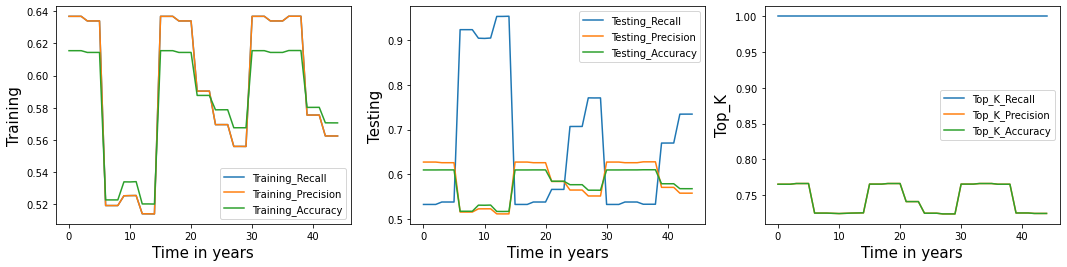

In [11]:
n_cols=3
n_rows=1
fig, axs=plt.subplots(n_rows,n_cols,figsize=(n_cols*6,n_rows*4))

ax = axs[0]
ax.plot(Output["Overall_Training_Recall"],label='Training_Recall')
ax.plot(Output["Overall_Training_Precision"],label='Training_Precision')
ax.plot(Output["Overall_Training_Accuracy"],label='Training_Accuracy')
ax.legend()
ax.set_xlabel("Time in years",fontsize=15);
ax.set_ylabel("Training",fontsize=15);

ax = axs[1]
ax.plot(Output["Overall_Testing_Recall"],label='Testing_Recall')
ax.plot(Output["Overall_Testing_Precision"],label='Testing_Precision')
ax.plot(Output["Overall_Testing_Accuracy"],label='Testing_Accuracy')
ax.legend()
ax.set_xlabel("Time in years",fontsize=15);
ax.set_ylabel("Testing",fontsize=15);

ax = axs[2]
ax.plot(Output["Top_K_Recall"],label='Top_K_Recall')
ax.plot(Output["Top_K_Precision"],label='Top_K_Precision')
ax.plot(Output["Top_K_Accuracy"],label='Top_K_Accuracy')
ax.legend()
ax.set_xlabel("Time in years",fontsize=15);
ax.set_ylabel("Top_K",fontsize=15);



In [12]:
for i in range (len(Output["Overall_Testing_Accuracy"])):
    print("=========================================",i,"==================================================")
    print("TeA=",Output["Overall_Testing_Accuracy"][i],"TeP=",Output["Overall_Testing_Precision"][i],
          "TeR=",Output["Overall_Testing_Recall"][i])
    print("KA=",Output["Top_K_Accuracy"][i],"KP=",Output["Top_K_Precision"][i],
          "KR=",Output["Top_K_Recall"][i])
    print(Output["Classifier"][i])
   

========================================= 0 ==================================================
TeA= 0.6101204643356168 TeP= 0.6277008872948424 TeR= 0.5332766885016312
KA= 0.7654098360655739 KP= 0.7654098360655739 KR= 1.0
LogisticRegression(n_jobs=8, random_state=43, solver='saga')
========================================= 1 ==================================================
TeA= 0.6101204643356168 TeP= 0.6277008872948424 TeR= 0.5332766885016312
KA= 0.7654098360655739 KP= 0.7654098360655739 KR= 1.0
LogisticRegression(n_jobs=8, random_state=43, solver='saga')
========================================= 2 ==================================================
TeA= 0.6101204643356168 TeP= 0.6277008872948424 TeR= 0.5332766885016312
KA= 0.7654098360655739 KP= 0.7654098360655739 KR= 1.0
LogisticRegression(n_jobs=8, random_state=43, solver='saga')
========================================= 3 ==================================================
TeA= 0.6102274579009075 TeP= 0.6262666863061048 TeR= 0.5386